In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.feature_selection import mutual_info_regression
from sklearn.neighbors import KernelDensity
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
from scipy import linalg
import scipy.integrate as integrate
from scipy.special import gamma
import time

from sklearn.mixture import GaussianMixture as GMM
from sklearn.mixture._gaussian_mixture import _estimate_log_gaussian_prob, _compute_precision_cholesky, _estimate_gaussian_covariances_full
from sklearn.utils import check_random_state
from sklearn import cluster
from sklearn.model_selection import KFold

import pandas as pd
from astropy.stats import sigma_clip
from scipy.stats import median_abs_deviation as mad

### Shapes 3D

In [51]:
# plot histogram with highest MI values
# first axis is label number, second axis is latent
all_MI_estimates = np.load('./shapes3D/MI_latents_labels.npy')
# these are from Lillian
beta2zdim6 = np.array([[0.0059155279794872164, 0.004425910215880301, 2.287343894399798, 0.004839882827017868, 0.00679878532434249, 0.015799111780296048],
                        [0.005291229773551627, 0.015401339350013865, 0.009326005135168024, 0.00576129665361449, 2.203242207071432, 0.015403195223842458],
                        [1.9313108691241967, 0.00706888997987716, 0.006802767957196686, 0.009614998217507302, 0.0042501708818623914, 0.016258122784980563],
                        [0.0046770068772649396, 0.18480622639093533, 0.007659799371723874, 0.5030696404705941, 0.029697928817851237, 0.010870909376811781],
                        [0.006490616998417474, 0.1410466939916793, 0.00802751293843795, 0.2828802819790144, 0.013277517860019936, 0.009239727270775265],
                        [0.007467694377759076, 0.010331056805112286, 0.012748510071551408, 0.00549790574357622, 0.032007430087424, 2.2785308522806096]])

beta2zdim6_latent_ordering = np.array([3, 6, 5, 1, 4, 2])
beta2zdim6_factor_ordering = [0, 5, 1, 2, 3, 4]
beta2zdim6_arr = beta2zdim6[:, beta2zdim6_latent_ordering - 1]
beta2zdim6_arr = beta2zdim6_arr[beta2zdim6_factor_ordering, :]

beta2zdim6 = np.roll(beta2zdim6, 1, axis=0)
sorted_args_lillian = np.argsort(beta2zdim6)[:, -2:]

In [52]:
label_list = ['wall_hue', 'floor_hue', 'object_hue', 'orientation', 'scale', 'shape'] # careful: rolled wall_hue at the beginning
all_MI_estimates_m = np.mean(all_MI_estimates, axis=-1)
all_MI_estimates_m = np.roll(all_MI_estimates_m, 1, axis=0)
all_MI_estimates_s = np.std(all_MI_estimates, axis=-1)
all_MI_estimates_s = np.roll(all_MI_estimates_s, 1, axis=0)

sorted_args = np.argsort(all_MI_estimates_m)[:, -2:]

latent_colour_scheme = ['#b35806','#f1a340','#fee0b6','#d8daeb','#998ec3','#542788']
#['#CC6677', '#DDCC77', '#117733', '#88CCEE', '#882255', '#999933']

(array([31.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([4.72791973e-05, 9.10339426e-04, 1.77339966e-03, 2.63645988e-03,
        3.49952011e-03, 4.36258034e-03, 5.22564057e-03, 6.08870080e-03,
        6.95176103e-03, 7.81482126e-03, 8.67788149e-03]),
 <a list of 10 Patch objects>)

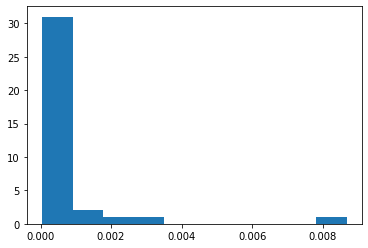

In [53]:
plt.hist(all_MI_estimates_s.flatten())

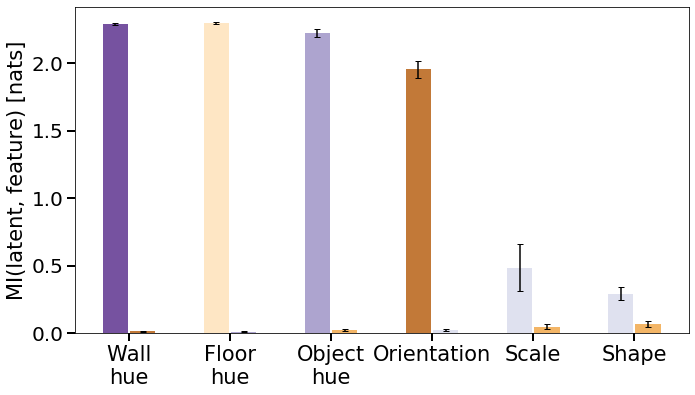

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(11, 6))
width = 0.50/2
alpha = 0.8
yerr_mul = 20
x = np.arange(len(label_list))  # the label locations

#rects1 = ax.bar(x+width/2 , 
#                np.choose(sorted_args_lillian[:, 0], beta2zdim6.T), 
#                width, color=np.choose(sorted_args_lillian[:, 0], latent_colour_scheme),
#                alpha=alpha, hatch='\\'
#                #yerr=np.choose(sorted_args[:, 1], all_MI_estimates_s.T),
#     )

#rects1 = ax.bar(x - 1.5*width-2*0.01, 
#                np.choose(sorted_args_lillian[:, 1], beta2zdim6.T), 
#                width, color=np.choose(sorted_args_lillian[:, 1], latent_colour_scheme),
#                alpha=alpha, hatch='\\',
#                #yerr=np.choose(sorted_args[:, 1], all_MI_estimates_s.T),
#     )

rects2 = ax.bar(x - width/2-0.01, 
                np.choose(sorted_args[:, 1], all_MI_estimates_m.T), 
                width, color=np.choose(sorted_args[:, 1], latent_colour_scheme),
                alpha=alpha,
                yerr=yerr_mul*np.choose(sorted_args[:, 1], all_MI_estimates_s.T), capsize=3
     )
rects3 = ax.bar(x + width/2+0.01, 
       [value*20 if value < 0.01 else value for value in np.choose(sorted_args[:, 0], all_MI_estimates_m.T) ], 
        width, color=np.choose(sorted_args[:, 0], latent_colour_scheme),
                alpha=alpha, yerr=yerr_mul*np.choose(sorted_args[:, 0], all_MI_estimates_s.T), capsize=3

     )
    
#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

ax.tick_params(axis='x', which='major', labelsize=21, length=10, width=2, size=8)
ax.tick_params(axis='y', which='major', labelsize=20, length=10, width=2, size=8)
ax.set_ylabel(f'MI(latent, feature) [nats]', fontsize=21)

ax.set_xticks(x)
ax.set_xticklabels([label.capitalize().replace("_", "\n") for label in label_list])

# build legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Patch(facecolor=latent_colour_scheme[i], label=f'Latent {i+1}') for i in range(6)]

#leg = ax.legend(handles=legend_elements, fontsize=30, frameon=False);
#for lh in leg.legendHandles: 
#    lh.set_alpha(alpha)
fig.savefig('./figures/MI_shapes3D.pdf', bbox_inches='tight');

In [55]:
# same, but with heatmap

In [4]:
all_MI_estimates = np.load('./shapes3D/MI_latents_labels.npy')
np.mean(all_MI_estimates, axis=-1).shape

(6, 6)

In [56]:
# plot histogram with highest MI values
# first axis is label number, second axis is latent
all_MI_estimates = np.load('./shapes3D/MI_latents_labels.npy')
# these are from Lillian
beta2zdim6 = np.array([[0.0059155279794872164, 0.004425910215880301, 2.287343894399798, 0.004839882827017868, 0.00679878532434249, 0.015799111780296048],
                        [0.005291229773551627, 0.015401339350013865, 0.009326005135168024, 0.00576129665361449, 2.203242207071432, 0.015403195223842458],
                        [1.9313108691241967, 0.00706888997987716, 0.006802767957196686, 0.009614998217507302, 0.0042501708818623914, 0.016258122784980563],
                        [0.0046770068772649396, 0.18480622639093533, 0.007659799371723874, 0.5030696404705941, 0.029697928817851237, 0.010870909376811781],
                        [0.006490616998417474, 0.1410466939916793, 0.00802751293843795, 0.2828802819790144, 0.013277517860019936, 0.009239727270775265],
                        [0.007467694377759076, 0.010331056805112286, 0.012748510071551408, 0.00549790574357622, 0.032007430087424, 2.2785308522806096]])

beta2zdim6_latent_ordering = np.array([3, 6, 5, 1, 4, 2])
beta2zdim6_factor_ordering = [0, 5, 1, 2, 3, 4]
beta2zdim6_arr = beta2zdim6[:, beta2zdim6_latent_ordering - 1]
beta2zdim6_arr = beta2zdim6_arr[beta2zdim6_factor_ordering, :]

beta2zdim6 = np.roll(beta2zdim6, 1, axis=0)
sorted_args_lillian = np.argsort(beta2zdim6)[:, -2:]

In [57]:
label_list = ['wall_hue', 'floor_hue', 'object_hue', 'orientation', 'scale', 'shape'] # careful: rolled wall_hue at the beginning
all_MI_estimates_m = np.mean(all_MI_estimates, axis=-1)
all_MI_estimates_m = np.roll(all_MI_estimates_m, 1, axis=0)
all_MI_estimates_s = np.std(all_MI_estimates, axis=-1)
all_MI_estimates_s = np.roll(all_MI_estimates_s, 1, axis=0)

sorted_args = np.argsort(all_MI_estimates_m)[:, -2:]

latent_colour_scheme = ['#b35806','#f1a340','#fee0b6','#d8daeb','#998ec3','#542788']
#['#CC6677', '#DDCC77', '#117733', '#88CCEE', '#882255', '#999933']

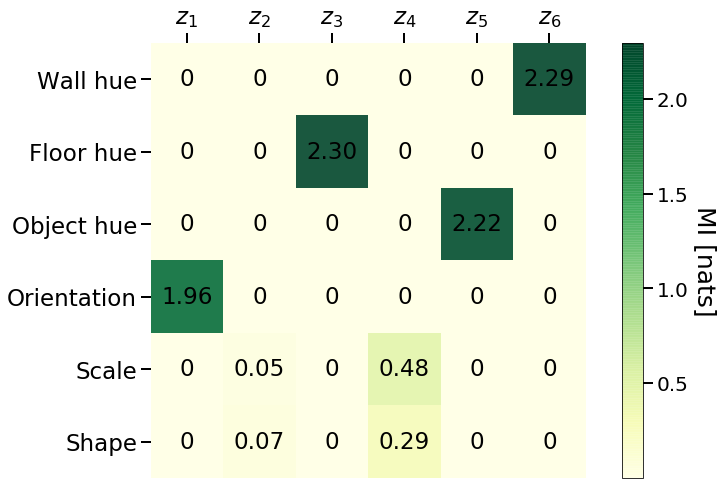

In [59]:
# plot

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

def heatmap(data, row_labels, col_labels, fsize=30, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.5)
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, cax=cax, **cbar_kw)
    cbar.ax.tick_params(labelsize=20, length=10, width=2) 
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom", fontsize=25)

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(labels=col_labels, fontsize=fsize)
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(labels=row_labels, fontsize=fsize)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False, length=10, width=2)

    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
    #         rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    #ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, gmm_mi_std=None, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()
        

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i, j] < 0.01:
                text = im.axes.text(j, i, matplotlib.ticker.StrMethodFormatter("{x:.0f}")(data[i, j], None), **kw) 
            else:
                #kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
                text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

vegetables = [label.capitalize().replace("_", " ") for label in label_list]
farmers = [f"$z_{i}$" for i in range(1, 7)]#[f"$z_{i+$" for i in range(6)]

harvest = all_MI_estimates_m


fig, (ax1) = plt.subplots(1, 1, figsize=(24, 8))


im, cbar = heatmap(harvest, vegetables, farmers, ax=ax1,
                   cmap="YlGn", cbarlabel="MI [nats]", alpha=0.9, fsize=23)
texts = annotate_heatmap(im, valfmt="{x:.2f}", fontsize=23)
#fig.tight_layout()
plt.savefig('./figures/MI_shapes3D_hm.pdf', bbox_inches='tight')

In [20]:
all_MI_estimates_m

array([[6.28729930e-04, 6.13152621e-04, 4.85850605e-04, 6.07341147e-04,
        4.57732774e-04, 2.28933610e+00],
       [3.30655948e-04, 3.52582959e-04, 2.29500784e+00, 4.50452214e-04,
        5.44391275e-04, 5.35197628e-04],
       [3.19895069e-04, 1.25555408e-03, 3.53057244e-04, 4.72017085e-04,
        2.22267396e+00, 3.39152809e-04],
       [1.95500989e+00, 5.75835089e-04, 4.08510523e-04, 1.11940241e-03,
        5.01270103e-04, 4.90775748e-04],
       [2.98103675e-04, 4.78504531e-02, 2.73146690e-04, 4.83604477e-01,
        1.87243202e-03, 4.58129904e-04],
       [7.90845796e-05, 6.90157123e-02, 2.46522328e-04, 2.92330021e-01,
        1.74966487e-04, 1.15425389e-04]])

In [23]:
all_MI_estimates_s.min()

4.7279197307931955e-05

### Halo data

In [30]:
KDE_02 = np.load('mi_truth_latents_epoch_27_bw_0.2.npy')[0].T
KDE_03 = np.load('mi_truth_latents_epoch_27_bw_0.3.npy')[0].T
KDE_01 = np.load('mi_truth_latents_epoch_27_bw_0.1.npy')[0].T

MI_radial = np.load('./haloes_MI_latent0_newproc.npy')
MI_radial_one = np.load('./haloes_MI_latent1_newproc.npy')
MI_radial_two = np.load('./haloes_MI_latent2_newproc.npy')

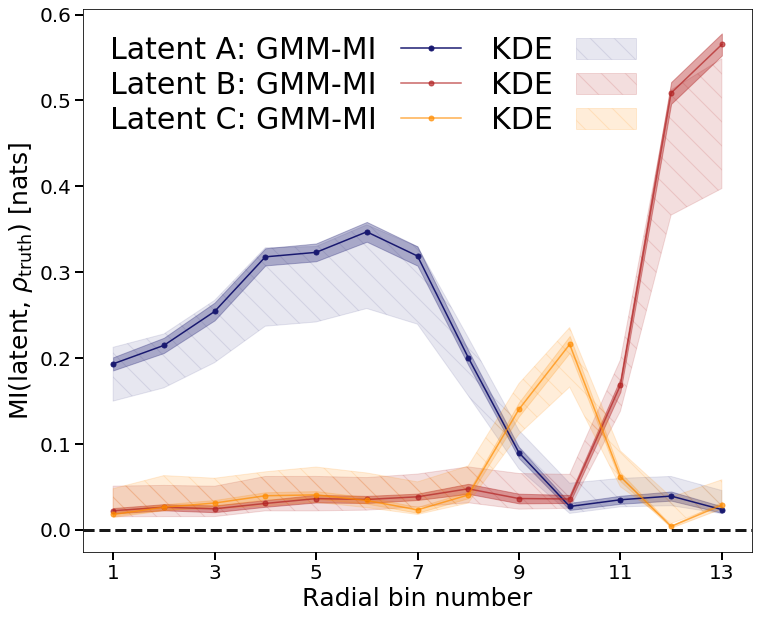

In [32]:
r_bins = 13

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial, axis=1), color='midnightblue', marker='o', markersize=5, alpha=1, label='Latent A: GMM-MI')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial, axis=1)- np.std(MI_radial, axis=1), np.mean(MI_radial, axis=1)+np.std(MI_radial, axis=1), color='midnightblue', alpha=0.3)

#ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 0], color='midnightblue', marker='o', markersize=5, alpha=0.1)
ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 0], KDE_03[:, 0], color='midnightblue', alpha=0.1, label='KDE', hatch="\\")

ax.plot(np.arange(1, 1+r_bins),  np.mean(MI_radial_one, axis=1), color='firebrick', marker='o', markersize=5, alpha=0.7, label='Latent B: GMM-MI')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial_one, axis=1)- np.std(MI_radial_one, axis=1), np.mean(MI_radial_one, axis=1)+ np.std(MI_radial_one, axis=1), color='firebrick', alpha=0.4)

#ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 1], color='firebrick', marker='o', markersize=5, alpha=0.1)
ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 1], KDE_03[:, 1], color='firebrick', alpha=0.15, label='KDE', hatch="\\")

ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial_two, axis=1), color='darkorange', marker='o', markersize=5, alpha=0.7, label='Latent C: GMM-MI')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial_two, axis=1)- np.std(MI_radial_two, axis=1), np.mean(MI_radial_two, axis=1)+ np.std(MI_radial_two, axis=1), color='darkorange', alpha=0.2)

#ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 2], color='darkorange', marker='o', markersize=5, alpha=0.1)
ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 2], KDE_03[:, 2], color='darkorange', alpha=0.15, label='KDE', hatch="\\")


ax.set_xlabel('Radial bin number', fontsize=25)
ax.set_ylabel(r'MI(latent, $\rho_{\rm{truth}}$) [nats]', fontsize=25)

ax.tick_params(axis='both', which='major', labelsize=20, length=10, width=2, size=8)

ax.set_xticks(np.arange(1, 14, 2))
ax.set_xticklabels(np.arange(1, 14, 2))

ax.axhline(0, ls='--', lw=3, color='k', alpha=0.9)
ax.legend(fontsize=30, ncol=2, labelspacing=0.2, columnspacing=1, markerfirst=False, frameon=False)
#ax.set_rasterized(True)
fig.savefig('./figures/MI_trend.pdf', bbox_inches='tight', format='pdf')
#fig.savefig('./figures/MI_trend.eps', bbox_inches='tight')
fig.savefig('./figures/MI_trend.png', bbox_inches='tight', dpi=600);

In [26]:
# also compare to MINE

In [30]:
MI_radial_mine = np.load('./mine-pytorch/mine/MI_halo_latent0_MINE.npy')
MI_radial_mine_one = np.load('./mine-pytorch/mine/MI_halo_latent1_MINE.npy')
MI_radial_mine_two = np.load('./mine-pytorch/mine/MI_halo_latent2_MINE.npy')

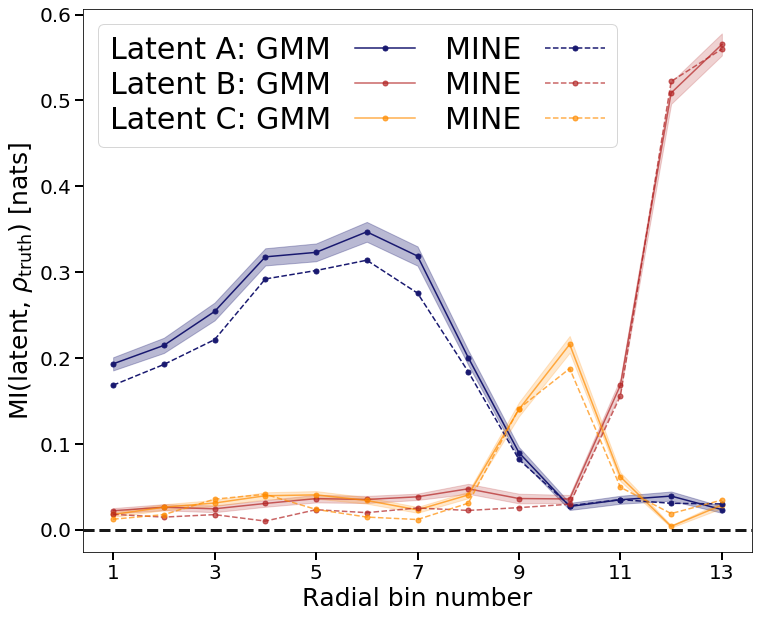

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# latent 0
ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial, axis=1), color='midnightblue', marker='o', markersize=5, alpha=1, label='Latent A: GMM')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial, axis=1)- np.std(MI_radial, axis=1), np.mean(MI_radial, axis=1)+np.std(MI_radial, axis=1), color='midnightblue', alpha=0.3)


#ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 0], color='midnightblue', marker='o', markersize=5, alpha=0.1)
#ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 0], KDE_03[:, 0], color='midnightblue', alpha=0.1, label='KDE', hatch="\\")


# latent 1
ax.plot(np.arange(1, 1+r_bins),  np.mean(MI_radial_one, axis=1), color='firebrick', marker='o', markersize=5, alpha=0.7, label='Latent B: GMM')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial_one, axis=1)- np.std(MI_radial_one, axis=1), np.mean(MI_radial_one, axis=1)+ np.std(MI_radial_one, axis=1), color='firebrick', alpha=0.2)

#ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 1], color='firebrick', marker='o', markersize=5, alpha=0.1)
#ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 1], KDE_03[:, 1], color='firebrick', alpha=0.15, label='KDE', hatch="\\")


# latent 2
ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial_two, axis=1), color='darkorange', marker='o', markersize=5, alpha=0.7, label='Latent C: GMM')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial_two, axis=1)- np.std(MI_radial_two, axis=1), np.mean(MI_radial_two, axis=1)+ np.std(MI_radial_two, axis=1), color='darkorange', alpha=0.2)

#ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 2], color='darkorange', marker='o', markersize=5, alpha=0.1)
#ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 2], KDE_03[:, 2], color='darkorange', alpha=0.15, label='KDE', hatch="\\")



ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial_mine, axis=1), color='midnightblue', marker='o', ls='--', markersize=5, alpha=1, label='MINE')
ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial_mine_one, axis=1), color='firebrick', marker='o', ls='--', markersize=5, alpha=0.7, label='MINE')
ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial_mine_two, axis=1), color='darkorange', marker='o', ls='--', markersize=5, alpha=0.7, label='MINE')


ax.set_xlabel('Radial bin number', fontsize=25)
ax.set_ylabel(r'MI(latent, $\rho_{\rm{truth}}$) [nats]', fontsize=25)

ax.tick_params(axis='both', which='major', labelsize=20, length=10, width=2, size=8)

ax.set_xticks(np.arange(1, 14, 2))
ax.set_xticklabels(np.arange(1, 14, 2))

ax.axhline(0, ls='--', lw=3, color='k', alpha=0.9)
ax.legend(fontsize=30, ncol=2, labelspacing=0.2, columnspacing=1, markerfirst=False)

fig.savefig('./figures/MI_MINE.pdf', bbox_inches='tight');

### GMM convergence number of components

In [1]:
import numpy as np
validation_ll = np.load('./validation_ll.npy')
aics = np.load('./aics.npy')
bics = np.load('./bics.npy')

components_range = 15

In [2]:
validation_ll

array([-1.06962039, -0.99437895, -0.98025929, -0.96900757, -0.96534966,
       -0.96450942, -0.96488079, -0.96479934, -0.96547767, -0.9658471 ,
       -0.96628445, -0.96621164, -0.96912665, -0.96805164, -0.96929564])

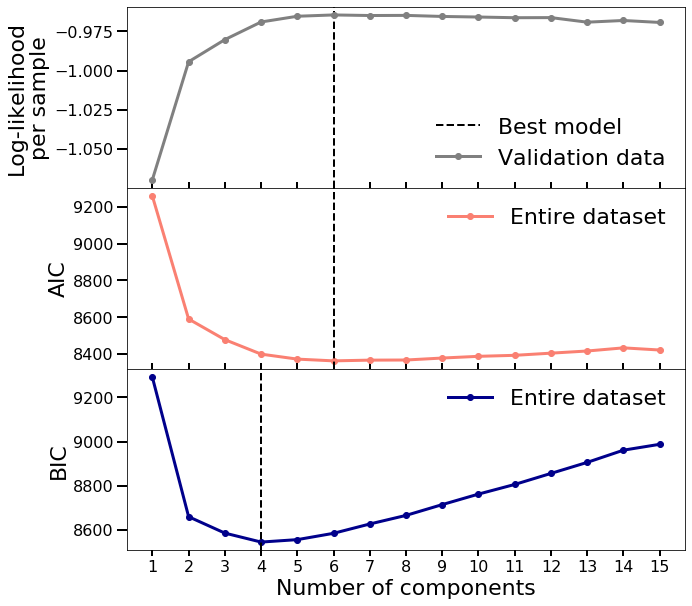

In [6]:
legendsize = 22
labelsize = 16
fig, (ax, ax1, ax2) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

ax.axvline(6, color='k', lw=2, ls='--', label='Best model')
ax.plot(np.arange(1, components_range+1), validation_ll, lw=3, linestyle='-', marker='o', color='grey', label='Validation data')
ax.set_ylabel("Log-likelihood\nper sample", fontsize=legendsize)

ax.set_xticks(np.arange(1, components_range+1))
ax.tick_params(axis='x', which='both', labelsize=labelsize, direction="in", length=6, width=2)
ax.tick_params(axis='y', which='both', labelsize=labelsize, length=10, width=2)

ax.legend(fontsize=legendsize, frameon=False)
#.add_patch(circle1)

ax1.plot(np.arange(1, components_range+1), aics[:], lw=3, linestyle='-', marker='o', color='salmon', label='Entire dataset')
ax1.set_ylabel(r"AIC", fontsize=legendsize)

ax1.tick_params(axis='x', which='both', labelsize=labelsize, direction="in", length=6, width=2)
ax1.tick_params(axis='y', which='both', labelsize=labelsize, length=10, width=2)
ax1.set_xticks(np.arange(1, components_range+1))

#circle1 = matplotlib.patches.Ellipse((6, 5100), 0.5, 40, color='black', fill=False, lw=3)
#ax1.add_patch(circle1);
ax1.axvline(6, color='k', lw=2, ls='--')
ax1.legend(fontsize=legendsize, frameon=False)

ax2.plot(np.arange(1, components_range+1), bics[:], lw=3, linestyle='-', marker='o', color='darkblue', label='Entire dataset')

ax2.set_xlabel('Number of components', fontsize=legendsize)
ax2.set_ylabel(r"BIC", fontsize=legendsize)

ax2.tick_params(axis='x', which='both', labelsize=labelsize, length=6, width=2)
ax2.tick_params(axis='y', which='both', labelsize=labelsize, length=10, width=2)
ax2.set_xticks(np.arange(1, components_range+1))
ax2.axvline(4, color='k', lw=2, ls='--')
ax2.legend(fontsize=legendsize, frameon=False)

plt.subplots_adjust(wspace=0, hspace=0)
fig.savefig('./figures/val_AIC_BIC.pdf', bbox_inches='tight');

### Sedaghat

In [5]:
indices_to_keep = [11, 19, 58, 85, 99, 124]
MI_all = np.load('./astro-machines/standalone_share/MI_all.npy')

MI_values = np.mean(MI_all, axis=-1)[:, indices_to_keep]

In [6]:
MI_values

array([[0.3265251 , 0.02903692, 0.05484083, 0.02597046, 0.03824319,
        1.49257794],
       [0.16495193, 0.68666442, 0.33732193, 1.3324999 , 0.16167743,
        0.21102659],
       [0.1910707 , 0.71214469, 0.36120186, 1.31609166, 0.15888542,
        0.2193807 ],
       [0.105293  , 0.04143128, 0.0371937 , 0.02843931, 0.04975308,
        0.02814582],
       [0.02450255, 0.04150152, 0.04498218, 0.03291239, 0.04286426,
        0.03709947],
       [0.20349979, 0.3324096 , 0.28867407, 0.37328707, 0.28995642,
        0.28574551],
       [0.18035736, 0.21492258, 0.12523272, 0.30214038, 0.04397318,
        0.21365431]])

(array([12., 11.,  7.,  5.,  0.,  1.,  3.,  1.,  0.,  2.]),
 array([0.00330522, 0.00758393, 0.01186264, 0.01614135, 0.02042007,
        0.02469878, 0.02897749, 0.0332562 , 0.03753491, 0.04181362,
        0.04609233]),
 <a list of 10 Patch objects>)

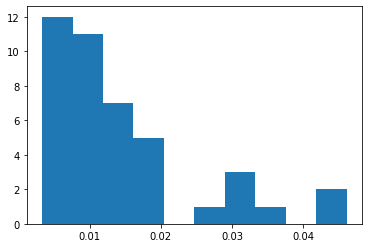

In [38]:
plt.hist(np.std(MI_all, axis=-1)[:, indices_to_keep].flatten())

In [39]:
#--- A simple joint Probability Density Estimator
def pde2(d1,d2,nbins = 10, sigma=0):
    if sigma > 0:
        d1 = sigma_clip(d1,sigma=sigma)
        d2 = sigma_clip(d2,sigma=sigma)
        
    h,_,_ = np.histogram2d(d1,d2,bins=[nbins,nbins])
    h = h / np.sum(h)
    return h

#----------------------------------------------------------------------------
# Mutual information for joint histogram
# from https://matthew-brett.github.io/teaching/mutual_information.html
#----------------------------------------------------------------------------
def mutual_information(hgram): 
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

labels = pd.read_csv('./astro-machines/standalone_share/harps_metadata_and_labels.csv')

codes_file = './astro-machines/standalone_share/encoded_harps_unique_128d_e182_i1500000.npy'
codes = pd.DataFrame(np.load(codes_file))

nDimensions = codes.shape[1]

#--- Compute MADS measures for all latent dimensions
measure = 'median' #or 'mean'
mads_threshold = 0.02
if measure == 'median':
    mads = mad(codes.values) # Median Absolute Deviation
else:
    mads = codes.mad().values # Mean Absolute Deviation

#--- Locate informative/significant dimensions
significant_dimensions = np.nonzero(mads > mads_threshold )[0]
print('Informative dimensions:',significant_dimensions)

#--- If looking at the 'unique' subset, drop unnecessary rows
if "unique" in codes_file:
    labels.dropna(subset=['unique_subset'],inplace=True)

#--- and reindex the codes dataframe accordingly
codes.loc[:,'dp_id'] = labels['dp_id'].values
labels = labels.set_index('dp_id')
codes = codes.set_index('dp_id')

Informative dimensions: [ 11  19  58  85  99 124]


# of labels: 4090


Text(0.5, 1.0, 'MI indicator for radvel')

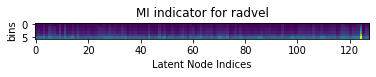

In [40]:
stellar_param = 'radvel' # Choose from ['radvel','Teff','Mass','E(B-V)','[M/H]','airmass','snr','vsini']
label = labels.loc[:,stellar_param].values


#-- Drop NaNs in labels
ind_mask = ~np.isnan(label)

#-- Ignore outlier (most probably erroneous) labels
label_ = sigma_clip(label,sigma=5,masked=True)
ind_mask = ind_mask & (~label_.mask)
label_ = label_.data[ind_mask]
print(f'# of labels: {len(label_)}')


#--- Compute the MI indicator with different binnings
nbinss = [5,10,20,40,80,160]
MI = np.zeros(nDimensions)
MIs = np.zeros([len(nbinss),nDimensions])

for b,nbins in enumerate(nbinss):
    for i in range(nDimensions):
        codes_ = codes.iloc[:,i].values
        codes_ = codes_[ind_mask]
        pqk = pde2(codes_,label_,nbins)
        MI[i] = mutual_information(pqk)
        MIs[b,i] = MI[i]

#--- Normalize MIs
#MIs /= np.max(MIs,1)[:,np.newaxis]

plt.figure()
plt.imshow(MIs);
plt.xlabel('Latent Node Indices')
plt.ylabel('bins')
plt.yticks(None);
plt.title("MI indicator for "+stellar_param)

In [41]:
sed_MI = np.zeros((6, nDimensions))
for k, stellar_param in enumerate(['radvel','Teff','Mass','[M/H]','airmass','snr']):
    label = labels.loc[:,stellar_param].values


    #-- Drop NaNs in labels
    ind_mask = ~np.isnan(label)

    #-- Ignore outlier (most probably erroneous) labels
    label_ = sigma_clip(label,sigma=5,masked=True)
    ind_mask = ind_mask & (~label_.mask)
    label_ = label_.data[ind_mask]
    print(f'# of labels: {len(label_)}')


    #--- Compute the MI indicator with different binnings
    nbinss = [40]
    MI = np.zeros(nDimensions)
    MIs = np.zeros([len(nbinss),nDimensions])

    for b,nbins in enumerate(nbinss):
        for i in range(nDimensions):
            codes_ = codes.iloc[:,i].values
            codes_ = codes_[ind_mask]
            pqk = pde2(codes_,label_,nbins)
            MI[i] = mutual_information(pqk)
            MIs[b,i] = MI[i]
            sed_MI[k, i] = MI[i] 

# of labels: 4090
# of labels: 4293


# of labels: 3351
# of labels: 1932
# of labels: 7007
# of labels: 6988


In [42]:
sed_MI = sed_MI[:, indices_to_keep]

In [43]:
sed_MI[3]

array([0.28191926, 0.2513608 , 0.0880489 , 0.25330127, 0.1900714 ,
       0.31163142])

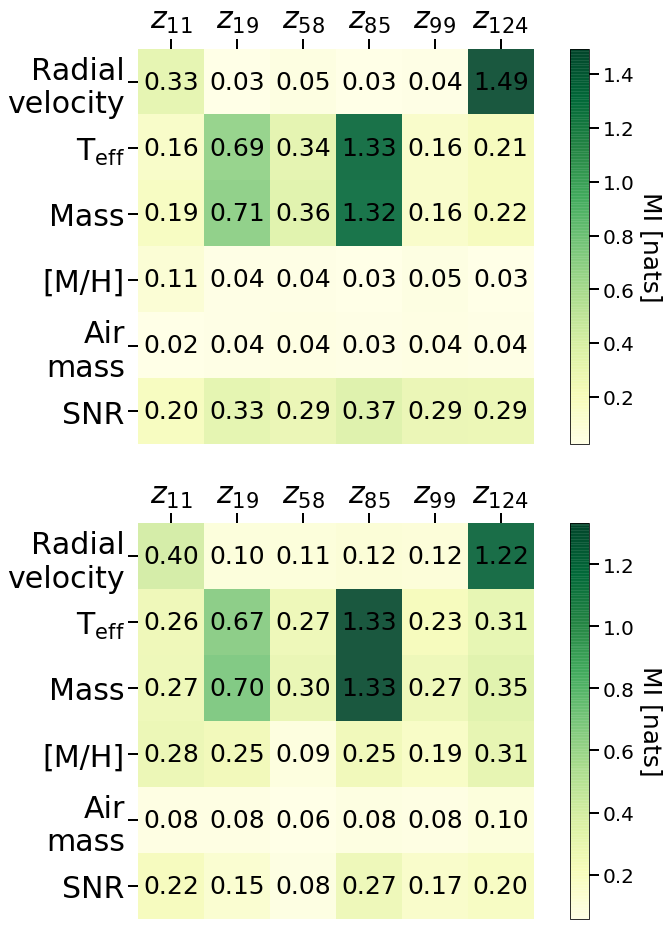

In [44]:
# plot

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

def heatmap(data, row_labels, col_labels, fsize=30, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.5)
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, cax=cax, **cbar_kw)
    cbar.ax.tick_params(labelsize=20, length=10, width=2) 
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom", fontsize=25)

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(labels=col_labels, fontsize=fsize)
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(labels=row_labels, fontsize=fsize)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False, length=10, width=2)

    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
    #         rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    
    
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    #ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, gmm_mi_std=None, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()
        

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            #if data[i, j] == 0:
            #    continue
            #kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

stellar_params_ = ['Radial\nvelocity','T$_{\mathregular{eff}}$','Mass','[M/H]','Air\nmass','SNR']#,'vsini']
vegetables = stellar_params_
farmers = [f"$z_{{{i}}}$" for i in indices_to_keep]#[f"$z_{i+$" for i in range(6)]

harvest = MI_values[:-1]


fig, (ax, ax1) = plt.subplots(2, 1, figsize=(12, 16))

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax,
                   cmap="YlGn", cbarlabel="MI [nats]", alpha=0.9)
texts = annotate_heatmap(im, valfmt="{x:.2f}", fontsize=25)

harvest = sed_MI

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax1,
                   cmap="YlGn", cbarlabel="MI [nats]", alpha=0.9)
texts = annotate_heatmap(im, valfmt="{x:.2f}", fontsize=25)
#fig.tight_layout()
#plt.subplots_adjust(hspace=0)
#plt.savefig('./figures/Sedaghat_MI.pdf', bbox_inches='tight')

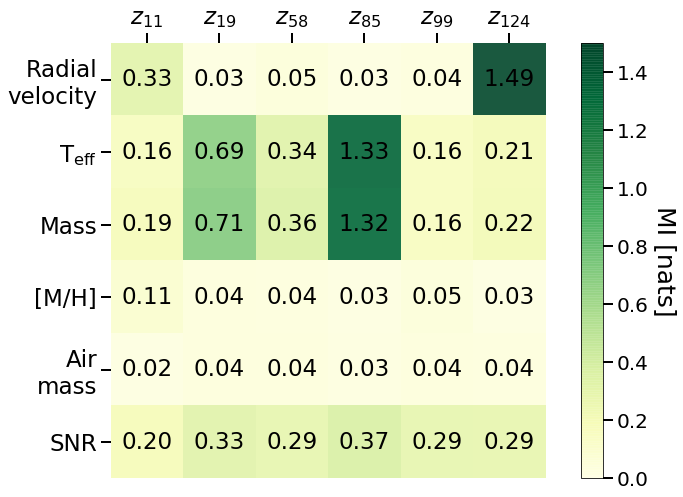

In [47]:
harvest = MI_values[:-1]

fig, (ax) = plt.subplots(1, 1, figsize=(12, 8))

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax,
                   cmap="YlGn", cbarlabel="MI [nats]", alpha=0.9, vmax=1.5, vmin=0, fsize=23)
texts = annotate_heatmap(im, valfmt="{x:.2f}", fontsize=23)

plt.savefig('./figures/Sedaghat_MI_1.pdf', bbox_inches='tight')

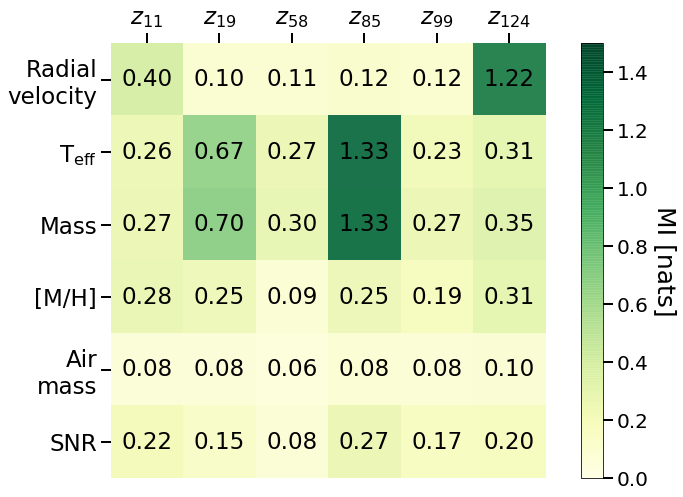

In [48]:
fig, (ax1) = plt.subplots(1, 1, figsize=(24, 8))


harvest = sed_MI

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax1,
                   cmap="YlGn", cbarlabel="MI [nats]", alpha=0.9, vmax=1.5, vmin=0,  fsize=23)
texts = annotate_heatmap(im, valfmt="{x:.2f}", fontsize=23)
#fig.tight_layout()
plt.savefig('./figures/Sedaghat_MI_2.pdf', bbox_inches='tight')

In [ ]:
# attempt to reproduce these figures in a histogram form

In [28]:
# plot histogram with highest MI values
# first axis is label number, second axis is latent
indices_to_keep = [11, 19, 58, 85, 99, 124]
MI_all = np.load('./astro-machines/standalone_share/MI_all.npy')

all_MI_estimates = MI_all[:-1, indices_to_keep, :]

# these are from Sedaghat
sorted_args_sed = np.argsort(sed_MI)[:, -2:]

In [29]:
stellar_params_ = ['Radial\nvelocity','T$_{\mathregular{eff}}$','Mass','[M/H]','Air\nmass','SNR']

label_list = stellar_params_#['wall_hue', 'floor_hue', 'object_hue', 'orientation', 'scale', 'shape'] # careful: rolled wall_hue at the beginning
all_MI_estimates_m = np.mean(all_MI_estimates, axis=-1)
#all_MI_estimates_m = np.roll(all_MI_estimates_m, 1, axis=0)
all_MI_estimates_s = np.std(all_MI_estimates, axis=-1)
#all_MI_estimates_s = np.roll(all_MI_estimates_s, 1, axis=0)

sorted_args = np.argsort(all_MI_estimates_m)[:, -2:]

latent_colour_scheme = ['#b35806','#f1a340','#fee0b6','#d8daeb','#998ec3','#542788']
#['#CC6677', '#DDCC77', '#117733', '#88CCEE', '#882255', '#999933']

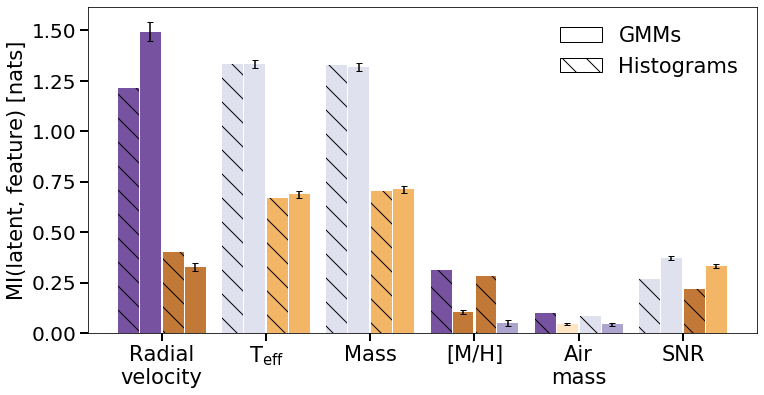

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
width = 0.8/4
alpha = 0.8
yerr_mul = 1
x = np.arange(len(label_list))  # the label locations

rects1 = ax.bar(x+width/2+0.01 , 
                np.choose(sorted_args_sed[:, 0], sed_MI.T), 
                width, color=np.choose(sorted_args_sed[:, 0], latent_colour_scheme),
                alpha=alpha, hatch='\\'
                #yerr=np.choose(sorted_args[:, 1], all_MI_estimates_s.T),
     )

rects1 = ax.bar(x - 1.5*width-2*0.01, 
                np.choose(sorted_args_sed[:, 1], sed_MI.T), 
                width, color=np.choose(sorted_args_sed[:, 1], latent_colour_scheme),
                alpha=alpha, hatch='\\',
                #yerr=np.choose(sorted_args[:, 1], all_MI_estimates_s.T),
     )

rects2 = ax.bar(x - width/2-0.01, 
                np.choose(sorted_args[:, 1], all_MI_estimates_m.T), 
                width, color=np.choose(sorted_args[:, 1], latent_colour_scheme),
                alpha=alpha,
                yerr=yerr_mul*np.choose(sorted_args[:, 1], all_MI_estimates_s.T), capsize=3
     )
rects3 = ax.bar(x + 1.5*width+2*0.01, 
       [value*1 if value < 0.01 else value for value in np.choose(sorted_args[:, 0], all_MI_estimates_m.T) ], 
        width, color=np.choose(sorted_args[:, 0], latent_colour_scheme),
                alpha=alpha, yerr=yerr_mul*np.choose(sorted_args[:, 0], all_MI_estimates_s.T), capsize=3

     )
    
#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

ax.tick_params(axis='x', which='major', labelsize=21, length=10, width=2, size=8)
ax.tick_params(axis='y', which='major', labelsize=20, length=10, width=2, size=8)
ax.set_ylabel(f'MI(latent, feature) [nats]', fontsize=21)

ax.set_xticks(x)
ax.set_xticklabels(label_list)

# build legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Patch(facecolor=latent_colour_scheme[i], label=f'Latent {i+1}') for i in range(6)]

#leg = ax.legend(handles=legend_elements, fontsize=30, frameon=False);
#for lh in leg.legendHandles: 
#    lh.set_alpha(alpha)
#fig.savefig('./figures/MI_shapes3D.pdf', bbox_inches='tight');

import matplotlib.patches as mpatches

w_patch = mpatches.Patch(edgecolor='black', facecolor='white', label='GMMs')
wh_patch = mpatches.Patch(edgecolor='black', facecolor='white', hatch='\\', label='Histograms')

plt.legend(handles=[w_patch, wh_patch], fontsize=21, frameon=False)

# Validation

### D1

In [126]:
knn_estimates = np.load('./mine-pytorch/mine/D1_knn.npy')
mine_estimates = np.load('./mine-pytorch/mine/D1_mine.npy')
all_MI_estimates = np.load('./mine-pytorch/mine/D1_ours.npy')
analytic = np.load('./mine-pytorch/mine/D1_analytic.npy')

rhos = np.linspace(-0.99, 0.99, 20)

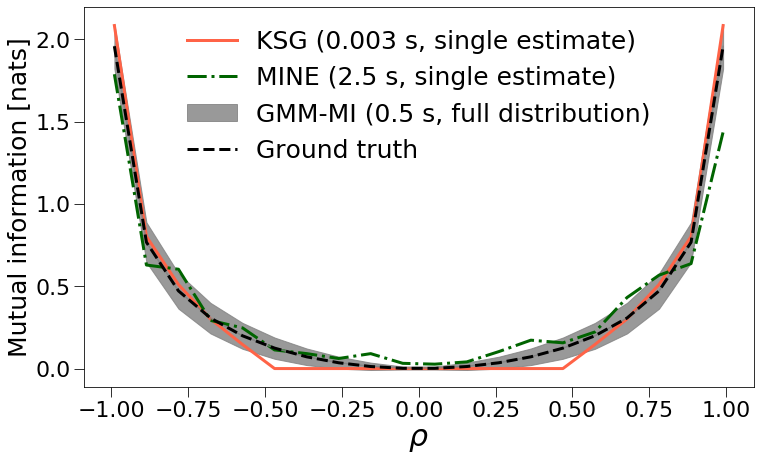

In [145]:
# let's plot all of this
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

sigmas = 2
lw=3
label = '$N=200$ samples to fit, 20 bootstrap realisations'
ax.tick_params(axis='both', which='major', labelsize=22, size=10)
ax.plot(rhos, knn_estimates, c='tomato', lw=lw, label='KSG (0.003 s, single estimate)')
ax.plot(rhos, mine_estimates, c='darkgreen', ls='-.', lw=lw, label='MINE (2.5 s, single estimate)')
ax.plot(rhos, all_MI_estimates[:, 0], color='grey', alpha=0.8)
ax.fill_between(rhos, all_MI_estimates[:, 0] - sigmas*all_MI_estimates[:, 1], all_MI_estimates[:, 0]+sigmas*all_MI_estimates[:, 1], color='grey', alpha=0.8, label='GMM-MI (0.5 s, full distribution)')
ax.plot(rhos, analytic, ls='--', c='black', lw=lw, label='Ground truth')

handles, labels = ax.get_legend_handles_labels()
i1, i2 = -1, -2
handles[i1], handles[i2] = handles[i2], handles[i1] 
labels[i1], labels[i2] = labels[i2], labels[i1] 

#ax.set_title(label, fontsize=30)
ax.legend(handles, labels, fontsize=25, frameon=False)
        
ax.set_xlabel(r'$\rho$', fontsize=30)
ax.set_ylabel('Mutual information [nats]', fontsize=25);

#ax.set_yscale('log')
#ax.set_ylim((1e-5, 2))

plt.savefig('./figures/D1_comparison.pdf',  bbox_inches='tight');

In [17]:
all_MI_estimates[:, 1]

array([0.06783154, 0.06072041, 0.05360693, 0.04649349, 0.0393834 ,
       0.03228192, 0.02519866, 0.01815431, 0.01119692, 0.00458583,
       0.00458583, 0.01119692, 0.01815431, 0.02519866, 0.03228192,
       0.0393834 , 0.04649349, 0.05360693, 0.06072041, 0.06783154])

### D3

In [79]:
knn_estimates = np.load('./mine-pytorch/mine/D3_knn.npy')
mine_estimates = np.load('./mine-pytorch/mine/D3_mine.npy')
all_MI_estimates = np.load('./mine-pytorch/mine/D3_ours.npy')
analytic = np.load('./mine-pytorch/mine/D3_analytic.npy')

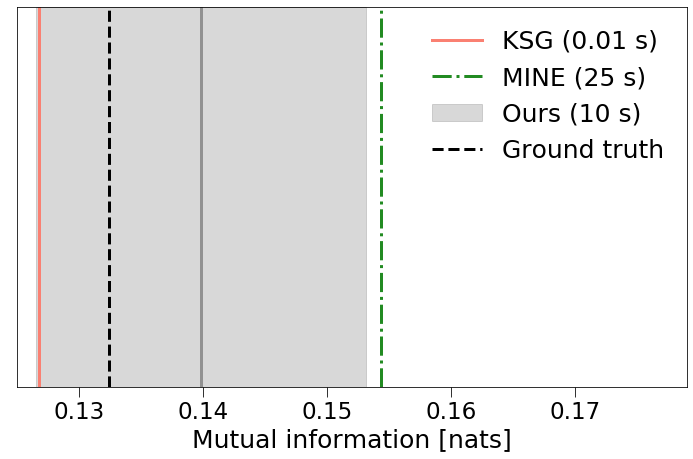

In [80]:
# let's plot all of this
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

lw=3
label = '$N=200$ samples to fit, 20 bootstrap realisations'
ax.tick_params(axis='both', which='major', labelsize=23, size=10)
ax.axvline(knn_estimates, c='salmon', lw=lw, label='KSG (0.01 s)')
ax.axvline(mine_estimates, c='forestgreen', ls='-.', lw=lw, label='MINE (25 s)')

ax.axvline(all_MI_estimates[:, 0], color='grey', alpha=0.8, lw=3)
ax.axvspan(all_MI_estimates[:, 0] - all_MI_estimates[:, 1], all_MI_estimates[:, 0]+all_MI_estimates[:, 1], color='grey', alpha=0.3, label='Ours (10 s)')
ax.axvline(analytic, ls='--', c='black', lw=lw, label='Ground truth')

handles, labels = ax.get_legend_handles_labels()
i1, i2 = -1, -2
handles[i1], handles[i2] = handles[i2], handles[i1] 
labels[i1], labels[i2] = labels[i2], labels[i1] 

#ax.set_title(label, fontsize=30)
ax.legend(handles, labels, fontsize=25, frameon=False)
        
ax.set_xlim((0.125, 0.179))
        
ax.axes.yaxis.set_ticks([])
ax.set_ylim((0.38, 0.62))
ax.set_xlabel('Mutual information [nats]', fontsize=25);

plt.savefig('./figures/D3_comparison.pdf',  bbox_inches='tight');

### Is bias dependent on sample size?

In [226]:
all_MI_estimates = np.load('./D3_bias_test_N_MI_4.npy')
np.save('./D3_bias_test_N_MI_4_tolissues.npy', all_MI_estimates)

In [227]:
all_MI_estimates = np.load('./D3_bias_test_N_MI_4_tolissues.npy')
all_MI_estimates[4, 2] =0.13219743307772355


np.save('./D3_bias_test_N_MI_4.npy', all_MI_estimates)

In [ ]:
100000 4 0.1287060095714087
100000 6 0.13168077314044757
100000 25 0.132432974881304
100000 28 0.13338669530267416
100000 35 0.13424731663496645
100000 37 0.13552313428093835
100000 44 0.13149042756503215
100000 51 0.13314756998968988
100000 57 0.1310395793865133
100000 65 0.1368864560005255
100000 67 0.13211112432946764
100000 70 0.13679477721437908
100000 72 0.1353895131822798
100000 73 0.12982948239441297
100000 75 0.13383496897739713
100000 84 0.12960423211052793

500
0 (array([], dtype=int64),)
1 (array([], dtype=int64),)
2 (array([], dtype=int64),)
3 (array([], dtype=int64),)
4 (array([], dtype=int64),)


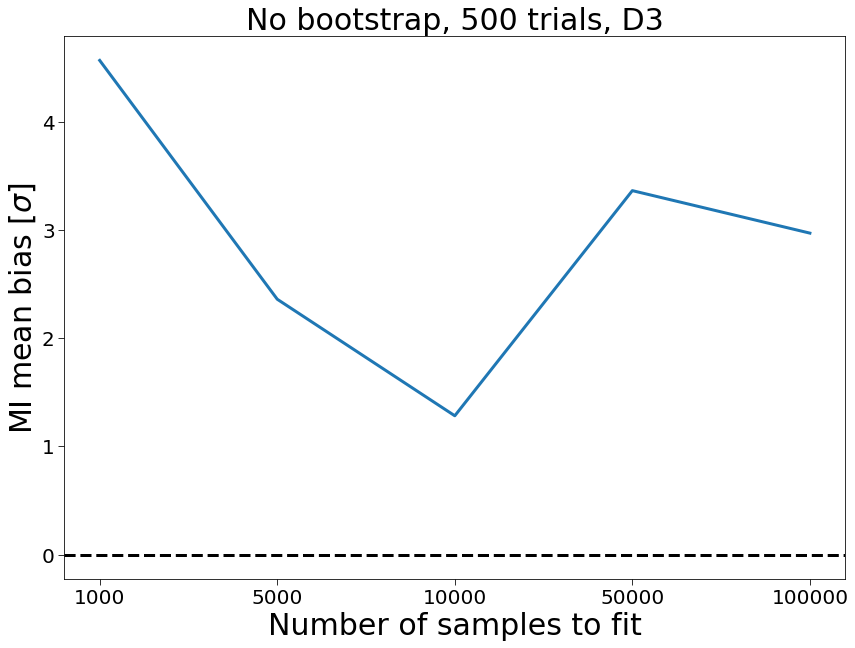

In [99]:
all_MI_estimates = np.zeros((5, 500))
for i in range(5):
    all_MI_estimates_ = np.load(f'./D3_bias_test_N_MI_{i}.npy')
    all_MI_estimates[:, i*100:(i+1)*100] = all_MI_estimates_

analytic = np.load('./mine-pytorch/mine/D3_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[1][0]-2
print(last_id)

all_MI_estimates = all_MI_estimates[:, :last_id]

for i in range(5):
    bad_idx = np.where(all_MI_estimates[i] < 0.05)
    print(i, bad_idx)
    all_MI_estimates[i][bad_idx] = analytic

all_MI_estimates = all_MI_estimates - analytic

legendsize = 25
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

ax1.plot(np.sqrt(last_id)*np.mean(all_MI_estimates, axis=1)/np.std(all_MI_estimates, axis=1), lw=3)
#ax1.plot(np.mean(all_MI_estimates, axis=1), lw=3)

ax1.axhline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
#ax1.legend(fontsize=legendsize, frameon=False, loc='upper right')
ax1.set_ylabel('MI mean bias [$\sigma$]', fontsize=30)
ax1.set_xlabel('Number of samples to fit', fontsize=30)

ax1.set_title('No bootstrap, 500 trials, D3', fontsize=30)

ax1.set_xticks(np.arange(5))
ax1.set_xticklabels([1000, 5000, 10000, 50000, 100000]);

In [100]:
np.mean(all_MI_estimates, axis=1)

array([0.00254218, 0.00062344, 0.00025723, 0.000359  , 0.00025965])

500
0 (array([], dtype=int64),)
1 (array([], dtype=int64),)
2 (array([], dtype=int64),)
3 (array([], dtype=int64),)
4 (array([], dtype=int64),)


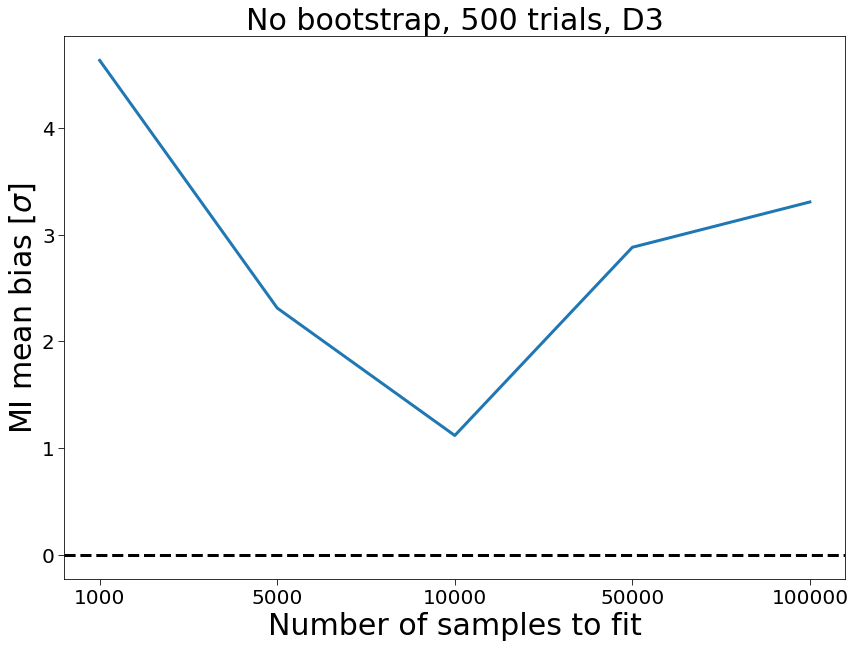

In [45]:
all_MI_estimates = np.load('./D3_bias_test_N_MI_diffinit.npy')
analytic = np.load('./mine-pytorch/mine/D3_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[1][0] - 1
print(last_id)

all_MI_estimates = all_MI_estimates[:, :last_id]

for i in range(5):
    bad_idx = np.where(all_MI_estimates[i] < 0.05)
    print(i, bad_idx)
    all_MI_estimates[i][bad_idx] = analytic

all_MI_estimates = all_MI_estimates - analytic

legendsize = 25
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

ax1.plot(np.sqrt(last_id)*np.mean(all_MI_estimates, axis=1)/np.std(all_MI_estimates, axis=1), lw=3)
#ax1.plot(np.mean(all_MI_estimates, axis=1), lw=3)

ax1.axhline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
#ax1.legend(fontsize=legendsize, frameon=False, loc='upper right')
ax1.set_ylabel('MI mean bias [$\sigma$]', fontsize=30)
ax1.set_xlabel('Number of samples to fit', fontsize=30)

ax1.set_title('No bootstrap, 500 trials, D3', fontsize=30)

ax1.set_xticks(np.arange(5))
ax1.set_xticklabels([1000, 5000, 10000, 50000, 100000]);

In [46]:
np.sqrt(last_id)*np.mean(all_MI_estimates, axis=1)/np.std(all_MI_estimates, axis=1)

array([4.63278553, 2.31109922, 1.11648196, 2.88084942, 3.30570921])

In [38]:
# (then redo on D5 and D5')

67
0 (array([], dtype=int64),)
1 (array([], dtype=int64),)
2 (array([], dtype=int64),)
3 (array([], dtype=int64),)
4 (array([], dtype=int64),)


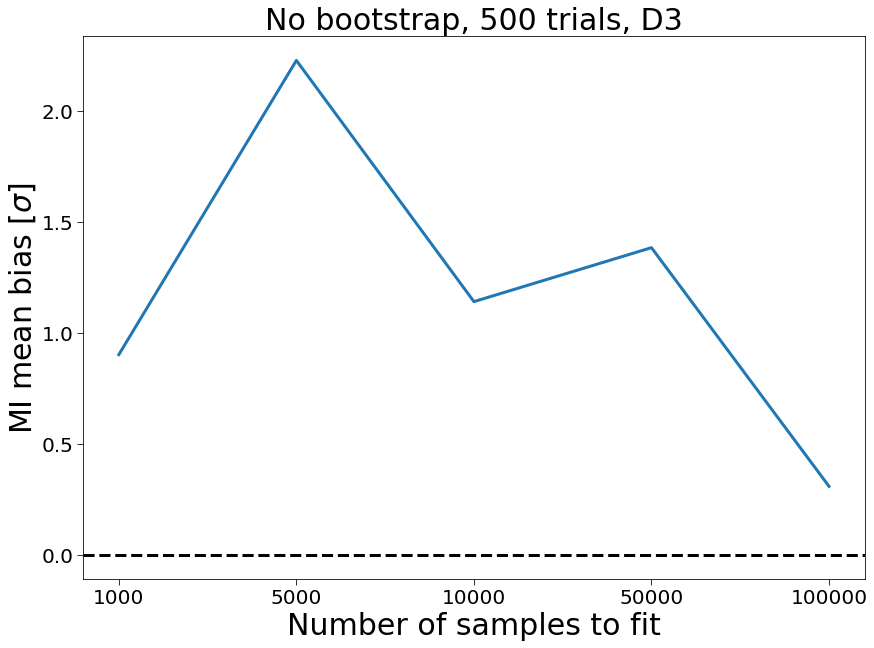

In [95]:
all_MI_estimates = np.load('./D3_bias_test_N_MI_exact.npy')
analytic = np.load('./mine-pytorch/mine/D3_analytic.npy')

last_id = np.where(all_MI_estimates == 0)[1][0] - 2
print(last_id)

all_MI_estimates = all_MI_estimates[:, :last_id]

for i in range(5):
    bad_idx = np.where(all_MI_estimates[i] < 0.05)
    print(i, bad_idx)
    all_MI_estimates[i][bad_idx] = analytic

all_MI_estimates = all_MI_estimates - analytic

legendsize = 25
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

ax1.plot(np.sqrt(last_id)*np.mean(all_MI_estimates, axis=1)/np.std(all_MI_estimates, axis=1), lw=3)
#ax1.plot(np.mean(all_MI_estimates, axis=1), lw=3)

ax1.axhline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
#ax1.legend(fontsize=legendsize, frameon=False, loc='upper right')
ax1.set_ylabel('MI mean bias [$\sigma$]', fontsize=30)
ax1.set_xlabel('Number of samples to fit', fontsize=30)

ax1.set_title('No bootstrap, 500 trials, D3', fontsize=30)

ax1.set_xticks(np.arange(5))
ax1.set_xticklabels([1000, 5000, 10000, 50000, 100000]);

In [93]:
np.std(all_MI_estimates, axis=1)

array([0.01155108, 0.00523147, 0.00436299, 0.00170563, 0.00128907])

30
0 (array([], dtype=int64),)
1 (array([], dtype=int64),)
2 (array([], dtype=int64),)
3 (array([], dtype=int64),)
4 (array([], dtype=int64),)


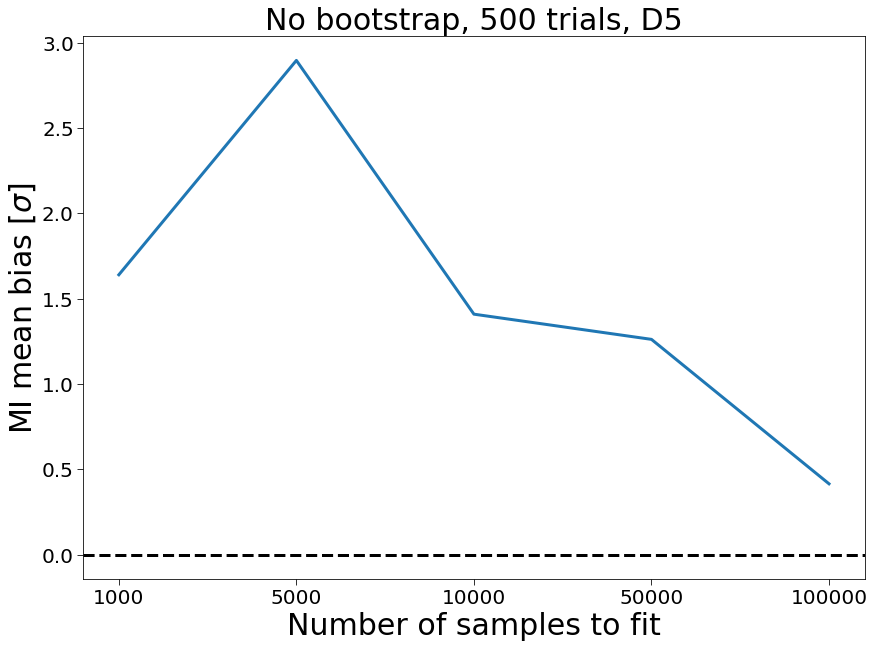

In [86]:
all_MI_estimates = np.load('./D5_bias_test_N_MI_exact.npy')
analytic = np.load('./mine-pytorch/mine/D5_analytic.npy')

last_id = np.where(all_MI_estimates == 0)[1][0] - 1
print(last_id)

all_MI_estimates = all_MI_estimates[:, :last_id]

for i in range(5):
    bad_idx = np.where(all_MI_estimates[i] < 0.05)
    print(i, bad_idx)
    all_MI_estimates[i][bad_idx] = analytic

all_MI_estimates = all_MI_estimates - analytic

legendsize = 25
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

ax1.plot(np.sqrt(last_id)*np.mean(all_MI_estimates, axis=1)/np.std(all_MI_estimates, axis=1), lw=3)
#ax1.plot(np.mean(all_MI_estimates, axis=1), lw=3)

ax1.axhline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
#ax1.legend(fontsize=legendsize, frameon=False, loc='upper right')
ax1.set_ylabel('MI mean bias [$\sigma$]', fontsize=30)
ax1.set_xlabel('Number of samples to fit', fontsize=30)

ax1.set_title('No bootstrap, 500 trials, D5', fontsize=30)

ax1.set_xticks(np.arange(5))
ax1.set_xticklabels([1000, 5000, 10000, 50000, 100000]);

### Final test of dependence on sample size

In [ ]:
# todo

No handles with labels found to put in legend.


500
0 (array([], dtype=int64),)
1 (array([], dtype=int64),)
2 (array([], dtype=int64),)
3 (array([], dtype=int64),)
4 (array([], dtype=int64),)


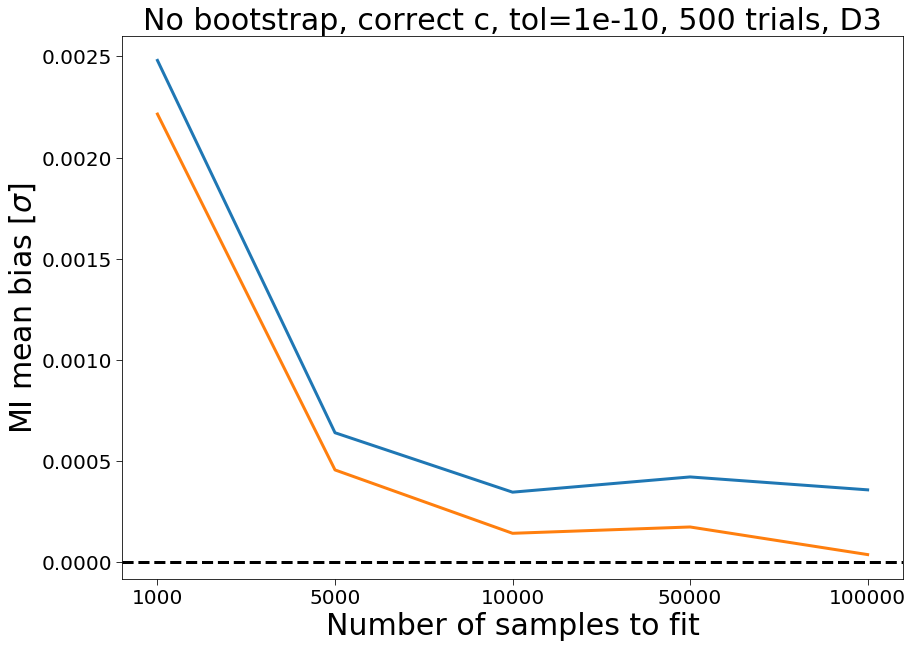

In [8]:
all_MI_estimates_ = np.load('./D3_bias_test_N_MI_exact_final.npy')[:, :340]
all_MI_estimates__ = np.load('./D3_bias_test_N_MI_exact_final_2.npy')[:, 340:]
all_MI_estimates = np.concatenate((all_MI_estimates_, all_MI_estimates__), axis=1)

analytic = np.load('./mine-pytorch/mine/D3_analytic_MC.npy')

last_id = 500#np.where(all_MI_estimates == 0)[1][0] - 1
print(last_id)

all_MI_estimates = all_MI_estimates[:, :last_id, :]

for i in range(5):
    bad_idx = np.where(all_MI_estimates[i, :, 0] < 0.05)
    print(i, bad_idx)
    #all_MI_estimates[i][bad_idx] = analytic

all_MI_estimates = all_MI_estimates - analytic

legendsize = 25
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

#ax1.plot(np.sqrt(last_id)*np.mean(all_MI_estimates[:, :, 0], axis=1)/np.std(all_MI_estimates[:, :, 0], axis=1), lw=3, label='MC')
#ax1.plot(np.sqrt(last_id)*np.mean(all_MI_estimates[:, :, 1], axis=1)/np.std(all_MI_estimates[:, :, 1], axis=1), lw=3, label='Quadrature')
ax1.plot(np.mean(all_MI_estimates[:, :, 0], axis=1), lw=3)
ax1.plot(np.mean(all_MI_estimates[:, :, 1], axis=1), lw=3)

ax1.axhline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False)
ax1.set_ylabel('MI mean bias [$\sigma$]', fontsize=30)
ax1.set_xlabel('Number of samples to fit', fontsize=30)

ax1.set_title('No bootstrap, correct c, tol=1e-10, 500 trials, D3', fontsize=30)

ax1.set_xticks(np.arange(5))
ax1.set_xticklabels([1000, 5000, 10000, 50000, 100000]);

In [138]:
np.sqrt(last_id)*np.mean(all_MI_estimates[:, :, 0], axis=1)/np.std(all_MI_estimates[:, :, 0], axis=1)

array([4.48172505, 2.4172264 , 1.7590006 , 4.15866404, 4.02463029])

No handles with labels found to put in legend.


500
0 (array([], dtype=int64),)
1 (array([], dtype=int64),)
2 (array([], dtype=int64),)
3 (array([], dtype=int64),)
4 (array([], dtype=int64),)


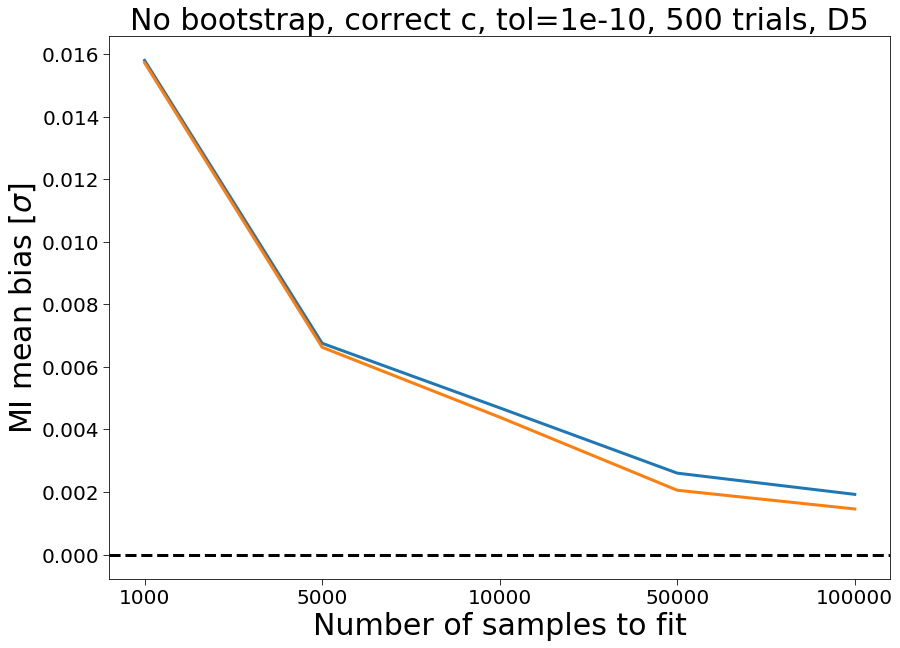

In [5]:
all_MI_estimates_ = np.load('./D5_bias_test_N_MI_exact_final.npy')[:, :181]
all_MI_estimates__ = np.load('./D5_bias_test_N_MI_exact_final_2.npy')[:, 182:366]
all_MI_estimates___ = np.load('./D5_bias_test_N_MI_exact_final_3.npy')[:, 366:]

all_MI_estimates = np.concatenate((all_MI_estimates_, all_MI_estimates__, all_MI_estimates___), axis=1)

analytic = np.load('./mine-pytorch/mine/D5_analytic_MC.npy')

last_id = 500#np.where(all_MI_estimates == 0)[1][0] - 1
print(last_id)

all_MI_estimates = all_MI_estimates[:, :last_id, :]

for i in range(5):
    bad_idx = np.where(all_MI_estimates[i, :, 0] < 0.05)
    print(i, bad_idx)
    #all_MI_estimates[i][bad_idx] = analytic

all_MI_estimates = all_MI_estimates - analytic

legendsize = 25
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

#ax1.plot(np.sqrt(last_id)*np.mean(all_MI_estimates[:, :, 0], axis=1)/np.std(all_MI_estimates[:, :, 0], axis=1), lw=3, label='MC')
#ax1.plot(np.sqrt(last_id)*np.mean(all_MI_estimates[:, :, 1], axis=1)/np.std(all_MI_estimates[:, :, 1], axis=1), lw=3, label='Quadrature')
ax1.plot(np.std(all_MI_estimates[:, :, 0], axis=1), lw=3)
ax1.plot(np.std(all_MI_estimates[:, :, 1], axis=1), lw=3)
#ax1.plot(np.mean(all_MI_estimates, axis=1), lw=3)

ax1.axhline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper right')
ax1.set_ylabel('MI mean bias [$\sigma$]', fontsize=30)
ax1.set_xlabel('Number of samples to fit', fontsize=30)

ax1.set_title('No bootstrap, correct c, tol=1e-10, 500 trials, D5', fontsize=30)

ax1.set_xticks(np.arange(5))
ax1.set_xticklabels([1000, 5000, 10000, 50000, 100000]);

In [157]:
np.sqrt(last_id)*np.mean(all_MI_estimates[:, :, 0], axis=1)/np.std(all_MI_estimates[:, :, 0], axis=1)

array([10.08530763,  3.2268017 ,  2.56302032,  2.78489152,  1.9397693 ])

No handles with labels found to put in legend.


500
0 (array([], dtype=int64),)
1 (array([], dtype=int64),)
2 (array([], dtype=int64),)
3 (array([], dtype=int64),)
4 (array([], dtype=int64),)


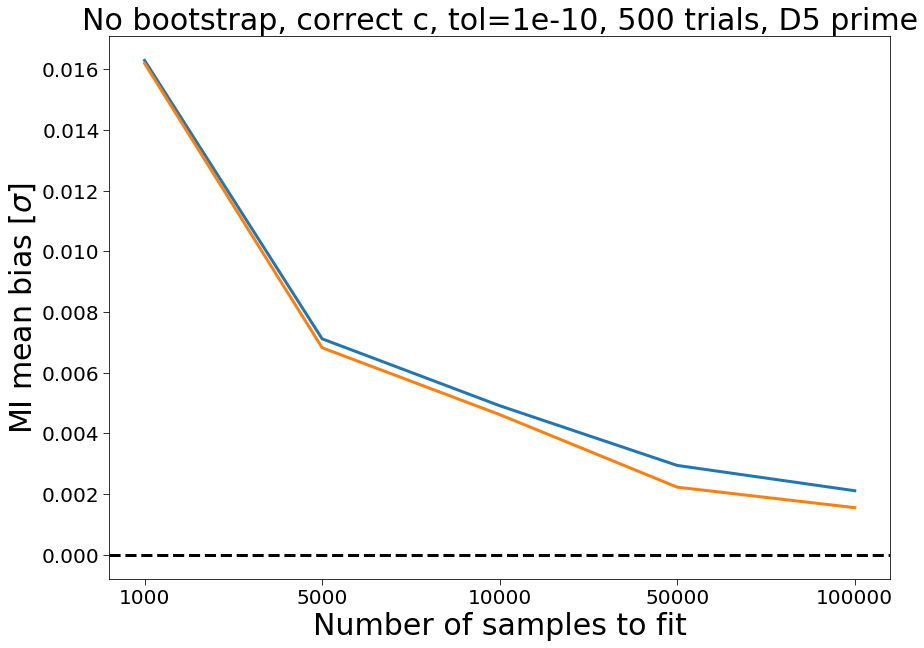

In [6]:
all_MI_estimates_ = np.load('./D5p_bias_test_N_MI_exact_final.npy')[:, :183]
all_MI_estimates__ = np.load('./D5p_bias_test_N_MI_exact_final_2.npy')[:, 184:301]
all_MI_estimates___ = np.load('./D5p_bias_test_N_MI_exact_final_3.npy')[:, 301:356]
all_MI_estimates____ = np.load('./D5p_bias_test_N_MI_exact_final_4.npy')[:, 357:]

all_MI_estimates = np.concatenate((all_MI_estimates_, all_MI_estimates__, all_MI_estimates___, all_MI_estimates____), axis=1)

analytic = np.load('./mine-pytorch/mine/D5p_analytic_MC.npy')
#0.17972193484434484

last_id = 500#np.where(all_MI_estimates == 0)[1][0] - 1
print(last_id)

all_MI_estimates = all_MI_estimates[:, :last_id, :]

for i in range(5):
    bad_idx = np.where(all_MI_estimates[i, :, 0] < 0.05)
    print(i, bad_idx)
    #all_MI_estimates[i][bad_idx] = analytic

all_MI_estimates = all_MI_estimates - analytic

legendsize = 25
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

#ax1.plot(np.sqrt(last_id)*np.mean(all_MI_estimates[:, :, 0], axis=1)/np.std(all_MI_estimates[:, :, 0], axis=1), lw=3, label='MC')
#ax1.plot(np.sqrt(last_id)*np.mean(all_MI_estimates[:, :, 1], axis=1)/np.std(all_MI_estimates[:, :, 1], axis=1), lw=3, label='Quadrature')
ax1.plot(np.std(all_MI_estimates[:, :, 0], axis=1), lw=3)
ax1.plot(np.std(all_MI_estimates[:, :, 1], axis=1), lw=3)
#ax1.plot(np.mean(all_MI_estimates, axis=1), lw=3)

ax1.axhline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper right')
ax1.set_ylabel('MI mean bias [$\sigma$]', fontsize=30)
ax1.set_xlabel('Number of samples to fit', fontsize=30)

ax1.set_title('No bootstrap, correct c, tol=1e-10, 500 trials, D5 prime', fontsize=30)

ax1.set_xticks(np.arange(5))
ax1.set_xticklabels([1000, 5000, 10000, 50000, 100000]);

In [160]:
np.sqrt(last_id)*np.mean(all_MI_estimates[:, :, 0], axis=1)/np.std(all_MI_estimates[:, :, 0], axis=1)

array([9.28945241, 3.63358738, 3.32777229, 0.80049504, 2.56490758])

No handles with labels found to put in legend.


500
0 (array([], dtype=int64),)
1 (array([], dtype=int64),)
2 (array([], dtype=int64),)
3 (array([], dtype=int64),)
4 (array([], dtype=int64),)


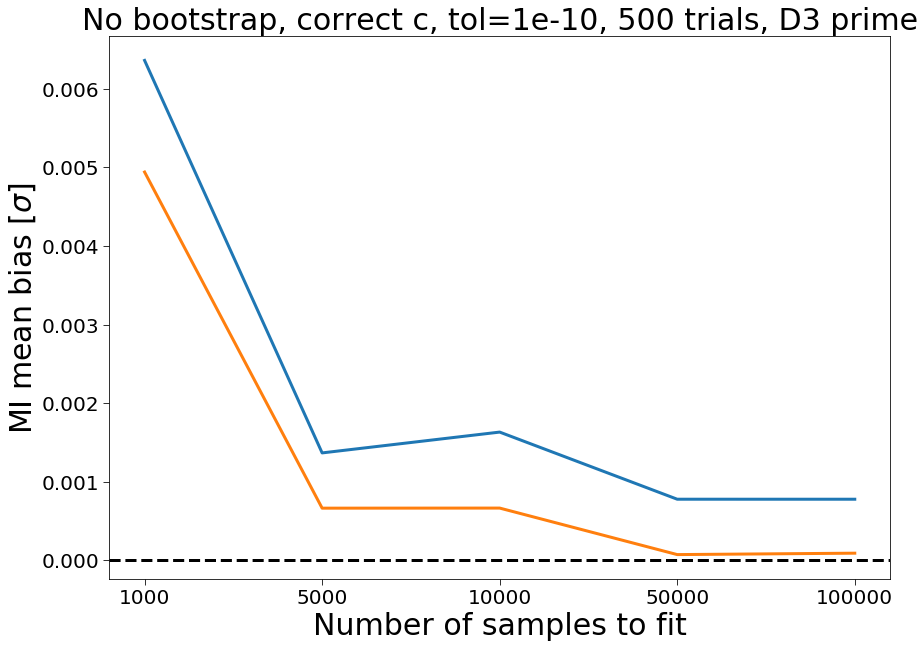

In [7]:
all_MI_estimates = np.load('./D3p_bias_test_N_MI_exact_final.npy')#[:, :340]
#all_MI_estimates__ = np.load('./D3_bias_test_N_MI_exact_final_2.npy')[:, 340:]
#all_MI_estimates = np.concatenate((all_MI_estimates_, all_MI_estimates__), axis=1)

analytic = np.load('./mine-pytorch/mine/D3p_analytic_MC.npy')
#0.38881453368446306

last_id = 500#np.where(all_MI_estimates == 0)[1][0] - 1
print(last_id)

all_MI_estimates = all_MI_estimates[:, :last_id, :]

for i in range(5):
    bad_idx = np.where(all_MI_estimates[i, :, 0] < 0.05)
    print(i, bad_idx)
    #all_MI_estimates[i][bad_idx] = analytic

all_MI_estimates = all_MI_estimates - analytic

legendsize = 25
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

#ax1.plot(np.sqrt(last_id)*np.mean(all_MI_estimates[:, :, 0], axis=1)/np.std(all_MI_estimates[:, :, 0], axis=1), lw=3, label='MC')
#ax1.plot(np.sqrt(last_id)*np.mean(all_MI_estimates[:, :, 1], axis=1)/np.std(all_MI_estimates[:, :, 1], axis=1), lw=3, label='Quadrature')
ax1.plot(np.mean(all_MI_estimates[:, :, 0], axis=1), lw=3)
ax1.plot(np.mean(all_MI_estimates[:, :, 1], axis=1), lw=3)
#ax1.plot(np.mean(all_MI_estimates, axis=1), lw=3)

ax1.axhline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper right')
ax1.set_ylabel('MI mean bias [$\sigma$]', fontsize=30)
ax1.set_xlabel('Number of samples to fit', fontsize=30)

ax1.set_title('No bootstrap, correct c, tol=1e-10, 500 trials, D3 prime', fontsize=30)

ax1.set_xticks(np.arange(5))
ax1.set_xticklabels([1000, 5000, 10000, 50000, 100000]);

### Confirming the bias is in the fitting by looking at likelihoods

500


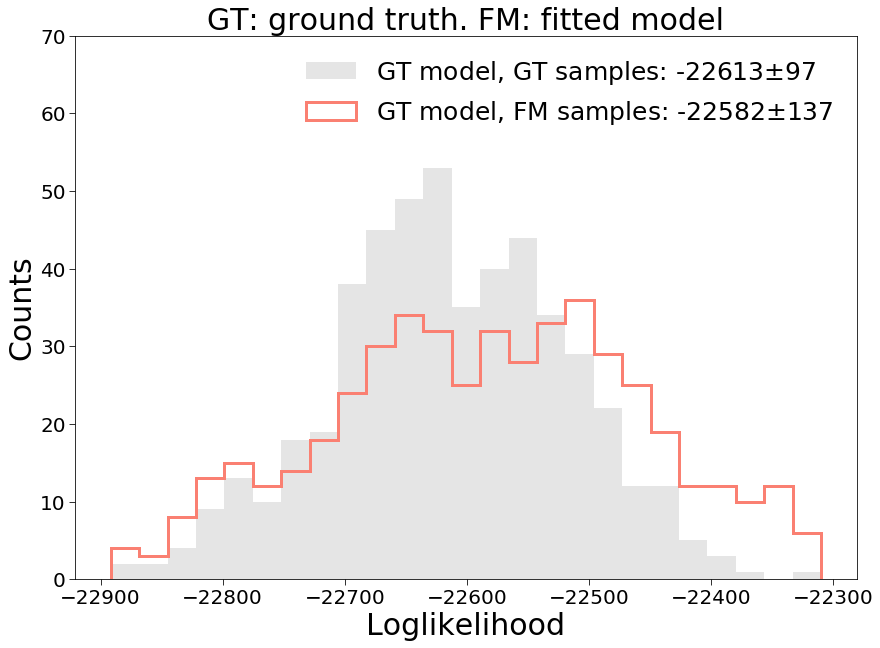

In [131]:
all_MI_estimates = np.load('./D3_bias_test_logL.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

bins=25
alpha=0.2
legendsize=25

mmin = np.minimum(np.min(all_MI_estimates[:last_id, 0]), np.min(all_MI_estimates[:last_id, 1]))
mmax = np.maximum(np.max(all_MI_estimates[:last_id, 0]), np.max(all_MI_estimates[:last_id, 1]))


ax1.hist(all_MI_estimates[:last_id, 0].flatten(), alpha=alpha, bins=bins, 
         label=f'GT model, GT samples: {np.mean(all_MI_estimates[:last_id, 0]):.0f}$\pm${np.std(all_MI_estimates[:last_id, 0]):.0f}', color='grey', range=(mmin, mmax))

ax1.hist(all_MI_estimates[:last_id, 2].flatten(), alpha=1, bins=bins, lw=3, 
         label=f'GT model, FM samples: {np.mean(all_MI_estimates[:last_id, 2]):.0f}$\pm${np.std(all_MI_estimates[:last_id, 2]):.0f}', color='salmon', range=(mmin, mmax),  histtype='step')

#ax1.hist(all_MI_estimates[:last_id, 1].flatten()-analytic, alpha=1, bins=bins, 
#         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1] - analytic)) / (np.std(all_MI_estimates[:last_id, 1]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, 1] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id, 1]- analytic)/np.sqrt(last_id):.4f}', color='salmon', range=(mmin, mmax), histtype='step', lw=3)


#ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper right')
ax1.set_xlabel('Loglikelihood', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)
ax1.set_ylim((0, 70))

ax1.set_title('GT: ground truth. FM: fitted model', fontsize=30);

500


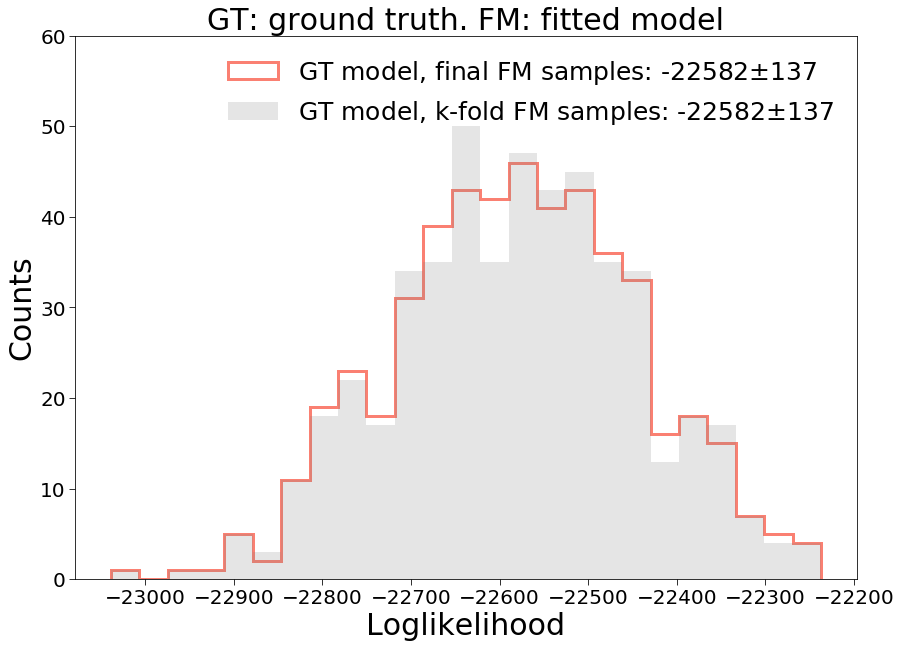

In [245]:
all_MI_estimates = np.load('./D3_bias_test_logL_overfit.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

bins=25
alpha=0.2
legendsize=25

mmin = np.min([np.min(all_MI_estimates[:last_id, 1]), np.min(all_MI_estimates[:last_id, 2])])
mmax = np.max([np.max(all_MI_estimates[:last_id, 1]), np.max(all_MI_estimates[:last_id, 2])])


#ax1.hist(all_MI_estimates[:last_id, 0].flatten(), alpha=alpha, bins=bins, 
#         label=f'GT model, GT samples: {np.mean(all_MI_estimates[:last_id, 0]):.0f}$\pm${np.std(all_MI_estimates[:last_id, 0]):.0f}', color='grey', range=(mmin, mmax))

ax1.hist(all_MI_estimates[:last_id, 1].flatten(), alpha=1, bins=bins, lw=3, 
         label=f'GT model, final FM samples: {np.mean(all_MI_estimates[:last_id, 1]):.0f}$\pm${np.std(all_MI_estimates[:last_id, 1]):.0f}', color='salmon', range=(mmin, mmax),  histtype='step')

ax1.hist(all_MI_estimates[:last_id, 2].flatten(), alpha=0.2, bins=bins, 
         label=f'GT model, k-fold FM samples: {np.mean(all_MI_estimates[:last_id, 2]):.0f}$\pm${np.std(all_MI_estimates[:last_id, 2]):.0f}', color='grey', range=(mmin, mmax))

#ax1.hist(all_MI_estimates[:last_id, 1].flatten()-analytic, alpha=1, bins=bins, 
#         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1] - analytic)) / (np.std(all_MI_estimates[:last_id, 1]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, 1] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id, 1]- analytic)/np.sqrt(last_id):.4f}', color='salmon', range=(mmin, mmax), histtype='step', lw=3)


#ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper right')
ax1.set_xlabel('Loglikelihood', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)
ax1.set_ylim((0, 60))

ax1.set_title('GT: ground truth. FM: fitted model', fontsize=30);

500


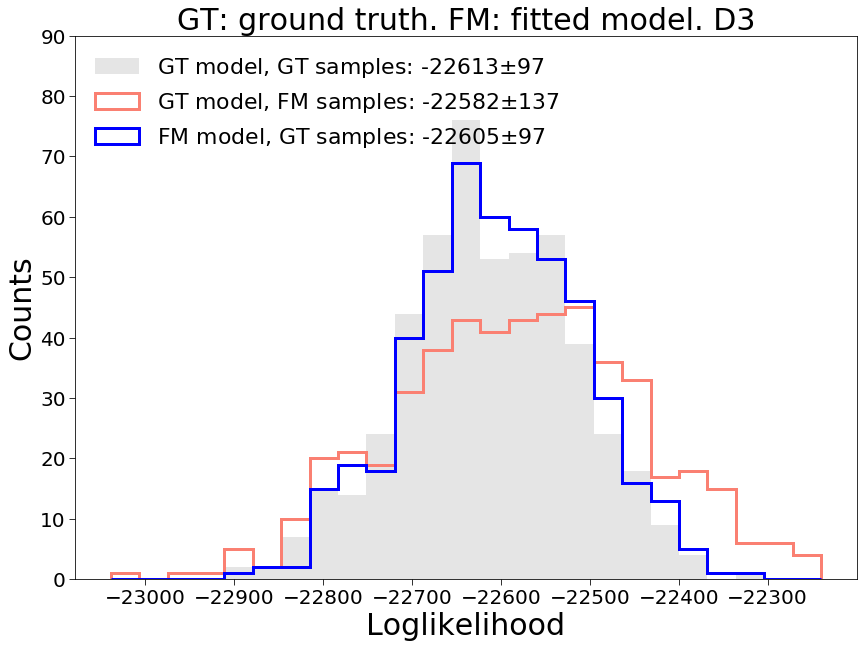

In [31]:
all_MI_estimates = np.load('./D3_bias_test_logL_furthertests.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

bins=25
alpha=0.2
legendsize=22

mmin = np.min([np.min(all_MI_estimates[:last_id, 0]), np.min(all_MI_estimates[:last_id, 1]), np.min(all_MI_estimates[:last_id, 3])])
mmax = np.max([np.max(all_MI_estimates[:last_id, 0]), np.max(all_MI_estimates[:last_id, 1]), np.max(all_MI_estimates[:last_id, 3])])


ax1.hist(all_MI_estimates[:last_id, 0].flatten(), alpha=alpha, bins=bins, 
         label=f'GT model, GT samples: {np.mean(all_MI_estimates[:last_id, 0]):.0f}$\pm${np.std(all_MI_estimates[:last_id, 0]):.0f}', color='grey', range=(mmin, mmax))

ax1.hist(all_MI_estimates[:last_id, 1].flatten(), alpha=1, bins=bins, lw=3, 
         label=f'GT model, FM samples: {np.mean(all_MI_estimates[:last_id, 1]):.0f}$\pm${np.std(all_MI_estimates[:last_id, 1]):.0f}', color='salmon', range=(mmin, mmax),  histtype='step')

ax1.hist(all_MI_estimates[:last_id, 3].flatten(), alpha=1, bins=bins, lw=3, 
         label=f'FM model, GT samples: {np.mean(all_MI_estimates[:last_id, 3]):.0f}$\pm${np.std(all_MI_estimates[:last_id, 3]):.0f}', color='blue', range=(mmin, mmax),  histtype='step')

#ax1.hist(all_MI_estimates[:last_id, 1].flatten()-analytic, alpha=1, bins=bins, 
#         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1] - analytic)) / (np.std(all_MI_estimates[:last_id, 1]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, 1] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id, 1]- analytic)/np.sqrt(last_id):.4f}', color='salmon', range=(mmin, mmax), histtype='step', lw=3)


#ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Loglikelihood', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)
ax1.set_ylim((0, 90))

ax1.set_title('GT: ground truth. FM: fitted model. D3', fontsize=30);

500


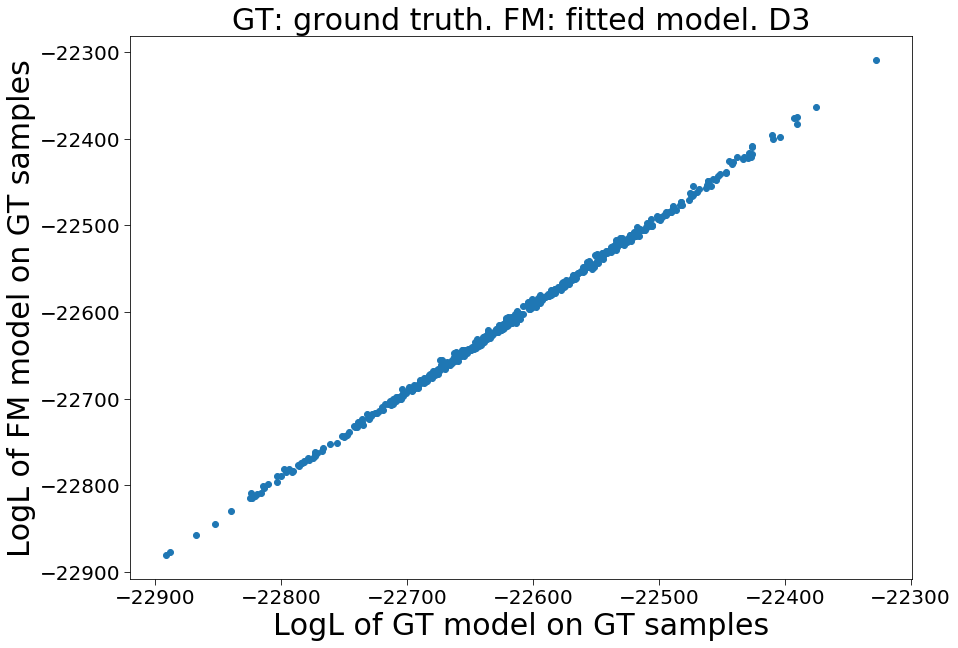

In [35]:
all_MI_estimates = np.load('./D3_bias_test_logL_furthertests.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))



ax1.scatter(all_MI_estimates[:, 0], all_MI_estimates[:, 3]) 



#ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
#ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('LogL of GT model on GT samples', fontsize=30)
ax1.set_ylabel('LogL of FM model on GT samples', fontsize=30)

ax1.set_title('GT: ground truth. FM: fitted model. D3', fontsize=30);

500


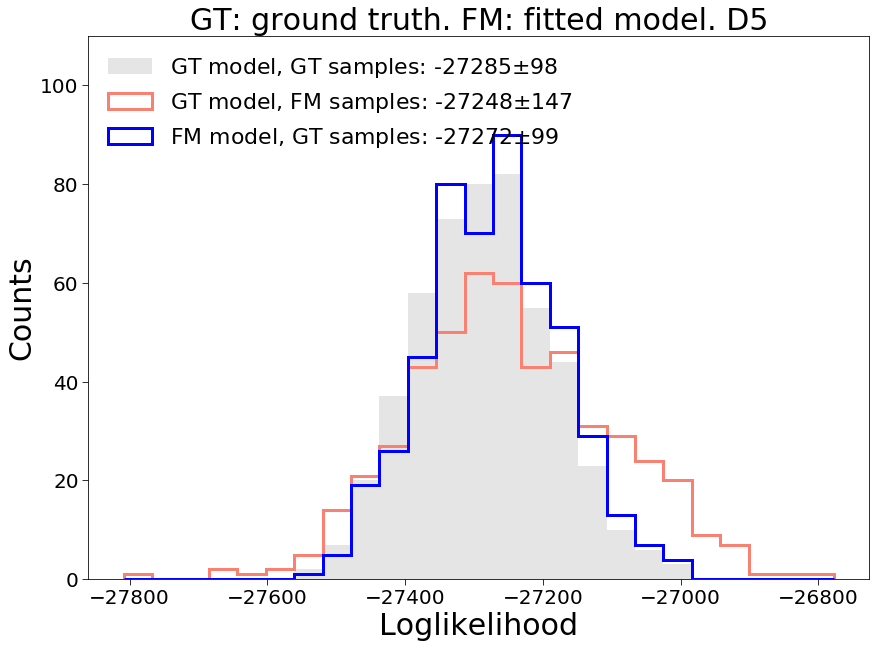

In [13]:
all_MI_estimates = np.load('./D5_bias_test_logL_furthertests.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

bins=25
alpha=0.2
legendsize=22

mmin = np.min([np.min(all_MI_estimates[:last_id, 0]), np.min(all_MI_estimates[:last_id, 1]), np.min(all_MI_estimates[:last_id, 3])])
mmax = np.max([np.max(all_MI_estimates[:last_id, 0]), np.max(all_MI_estimates[:last_id, 1]), np.max(all_MI_estimates[:last_id, 3])])


ax1.hist(all_MI_estimates[:last_id, 0].flatten(), alpha=alpha, bins=bins, 
         label=f'GT model, GT samples: {np.mean(all_MI_estimates[:last_id, 0]):.0f}$\pm${np.std(all_MI_estimates[:last_id, 0]):.0f}', color='grey', range=(mmin, mmax))

ax1.hist(all_MI_estimates[:last_id, 1].flatten(), alpha=1, bins=bins, lw=3, 
         label=f'GT model, FM samples: {np.mean(all_MI_estimates[:last_id, 1]):.0f}$\pm${np.std(all_MI_estimates[:last_id, 1]):.0f}', color='salmon', range=(mmin, mmax),  histtype='step')

ax1.hist(all_MI_estimates[:last_id, 3].flatten(), alpha=1, bins=bins, lw=3, 
         label=f'FM model, GT samples: {np.mean(all_MI_estimates[:last_id, 3]):.0f}$\pm${np.std(all_MI_estimates[:last_id, 3]):.0f}', color='blue', range=(mmin, mmax),  histtype='step')

#ax1.hist(all_MI_estimates[:last_id, 1].flatten()-analytic, alpha=1, bins=bins, 
#         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1] - analytic)) / (np.std(all_MI_estimates[:last_id, 1]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, 1] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id, 1]- analytic)/np.sqrt(last_id):.4f}', color='salmon', range=(mmin, mmax), histtype='step', lw=3)


#ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Loglikelihood', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)
ax1.set_ylim((0, 110))

ax1.set_title('GT: ground truth. FM: fitted model. D5', fontsize=30);

500


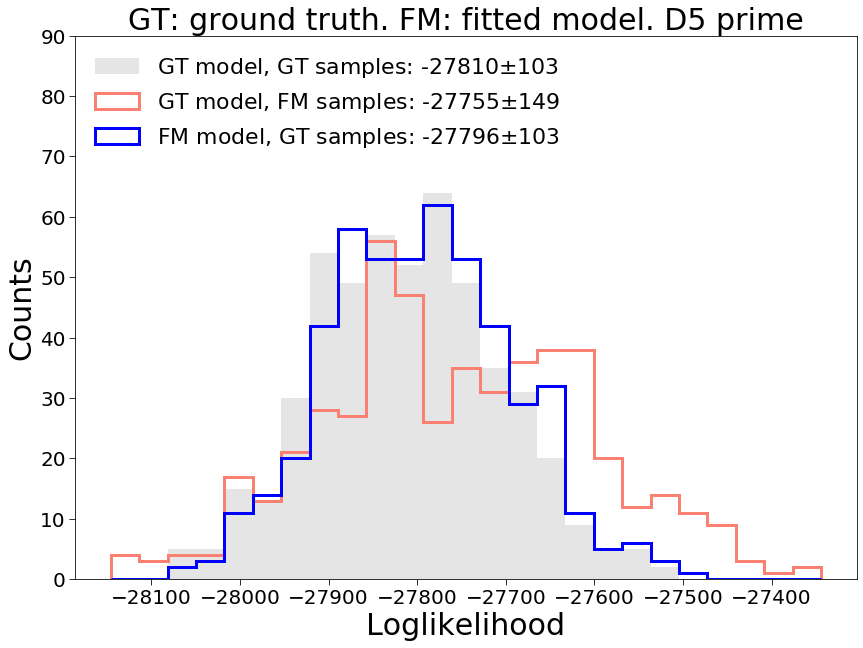

In [14]:
all_MI_estimates = np.load('./D5p_bias_test_logL_furthertests.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

bins=25
alpha=0.2
legendsize=22

mmin = np.min([np.min(all_MI_estimates[:last_id, 0]), np.min(all_MI_estimates[:last_id, 1]), np.min(all_MI_estimates[:last_id, 3])])
mmax = np.max([np.max(all_MI_estimates[:last_id, 0]), np.max(all_MI_estimates[:last_id, 1]), np.max(all_MI_estimates[:last_id, 3])])


ax1.hist(all_MI_estimates[:last_id, 0].flatten(), alpha=alpha, bins=bins, 
         label=f'GT model, GT samples: {np.mean(all_MI_estimates[:last_id, 0]):.0f}$\pm${np.std(all_MI_estimates[:last_id, 0]):.0f}', color='grey', range=(mmin, mmax))

ax1.hist(all_MI_estimates[:last_id, 1].flatten(), alpha=1, bins=bins, lw=3, 
         label=f'GT model, FM samples: {np.mean(all_MI_estimates[:last_id, 1]):.0f}$\pm${np.std(all_MI_estimates[:last_id, 1]):.0f}', color='salmon', range=(mmin, mmax),  histtype='step')

ax1.hist(all_MI_estimates[:last_id, 3].flatten(), alpha=1, bins=bins, lw=3, 
         label=f'FM model, GT samples: {np.mean(all_MI_estimates[:last_id, 3]):.0f}$\pm${np.std(all_MI_estimates[:last_id, 3]):.0f}', color='blue', range=(mmin, mmax),  histtype='step')

#ax1.hist(all_MI_estimates[:last_id, 1].flatten()-analytic, alpha=1, bins=bins, 
#         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1] - analytic)) / (np.std(all_MI_estimates[:last_id, 1]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, 1] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id, 1]- analytic)/np.sqrt(last_id):.4f}', color='salmon', range=(mmin, mmax), histtype='step', lw=3)


#ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Loglikelihood', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)
ax1.set_ylim((0, 90))

ax1.set_title('GT: ground truth. FM: fitted model. D5 prime', fontsize=30);

In [140]:
chi2 = np.load('./D3_chi2_final_v2.npy')
biases = np.load('./D3_biases_final_v2.npy')
bad_idx = np.load('./D3_bad_idx_final_v2.npy')

#chi2 = chi2[biases>-4]
#biases = biases[biases>-4]

#np.sort(biases)

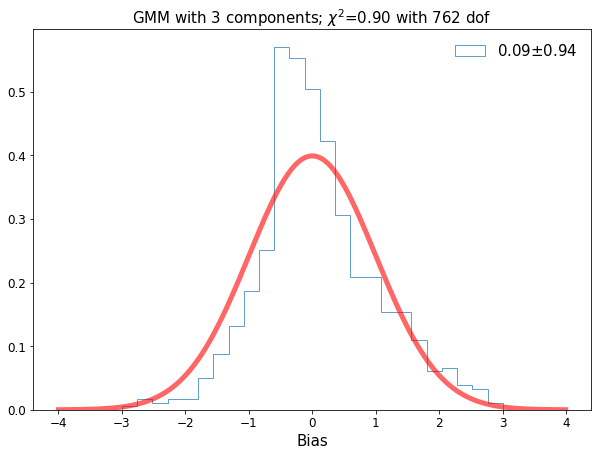

In [199]:
chi2 = np.load('./D3_chi2_final_v2.npy')
biases = np.load('./D3_biases_final_v2.npy')
bad_idx = np.load('./D3_bad_idx_final_v2.npy')

chi2 = chi2[bad_idx]
biases = biases[bad_idx]

df = len(chi2)-1
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 7))

#ax.errorbar(random_states, np.mean(MI_estimates, axis=1), np.sqrt(np.var(MI_estimates, axis=1)), fmt='x', color='salmon', label='Bootstrap')

ax1.hist(np.array(biases).flatten(), histtype='step', alpha=0.7, bins=25, label=f'{np.mean(biases):.2f}$\pm${np.std(biases):.2f}', range=(-3, 3), density='True')
x = np.linspace(-4, 4, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Bias', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(fontsize=15, frameon=False)
ax1.plot(x, y,
       'r-', lw=5, alpha=0.6, label='Gaussian pdf')
ax1.set_title(f'GMM with {3} components; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);


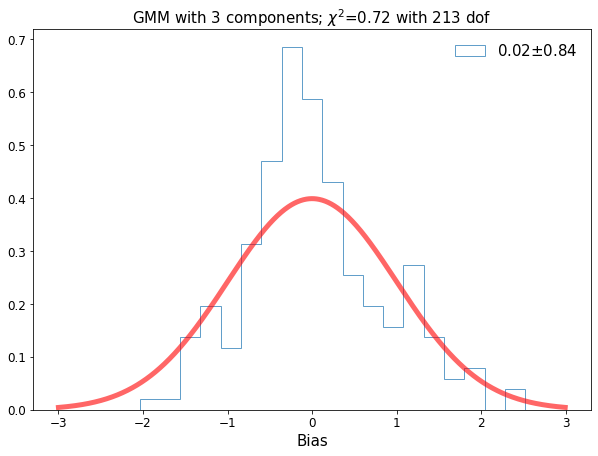

In [198]:
chi2 = np.load('./D3_chi2_final_v2_bs500.npy')
biases = np.load('./D3_biases_final_v2_bs500.npy')
bad_idx = np.load('./D3_bad_idx_final_v2_bs500.npy')

#chi2 = chi2[bad_idx]
#biases = biases[bad_idx]

df = len(chi2)-1
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 7))

#ax.errorbar(random_states, np.mean(MI_estimates, axis=1), np.sqrt(np.var(MI_estimates, axis=1)), fmt='x', color='salmon', label='Bootstrap')

ax1.hist(np.array(biases).flatten(), histtype='step', alpha=0.7, bins=25, label=f'{np.mean(biases):.2f}$\pm${np.std(biases):.2f}', range=(-3, 3), density='True')
x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Bias', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(fontsize=15, frameon=False)
ax1.plot(x, y,
       'r-', lw=5, alpha=0.6, label='Gaussian pdf')
ax1.set_title(f'GMM with {3} components; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);


In [274]:
# with right bs and smaller tol

-4.265139359126379
4.332672162546194


(None, None)

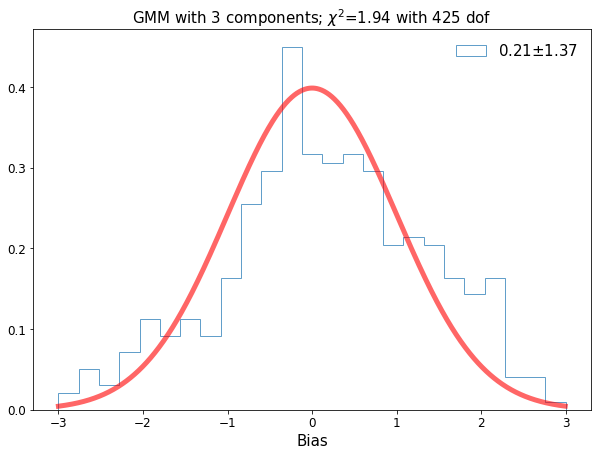

In [339]:
badidx = False

for i in range(4):
    if i == 0:
        chi2 = np.load(f'./D3_chi2_final_v2_bs100_tol1e-6_N100000.npy')
        biases = np.load(f'./D3_biases_final_v2_bs100_tol1e-6_N100000.npy')
        bad_idx = np.load(f'./D3_bad_idx_final_v2_bs100_tol1e-6_N100000.npy')
        
        if badidx:
            chi2 = chi2[bad_idx]
            biases = biases[bad_idx]
    else:
        c = np.load(f'./D3_chi2_final_v2_bs100_tol1e-6_N100000_{i}.npy')
        b = np.load(f'./D3_biases_final_v2_bs100_tol1e-6_N100000_{i}.npy')
        bi = np.load(f'./D3_bad_idx_final_v2_bs100_tol1e-6_N100000_{i}.npy')
        
        if badidx:
            c = c[bi]
            b = b[bi]
    
        chi2 = np.append(chi2, c)
        biases = np.append(biases, b)
        
#chi2 = chi2[biases<4]
#biases = biases[biases<4]

#chi2 = chi2[bad_idx]
#biases = biases[bad_idx]

df = len(chi2)-1
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 7))

#ax.errorbar(random_states, np.mean(MI_estimates, axis=1), np.sqrt(np.var(MI_estimates, axis=1)), fmt='x', color='salmon', label='Bootstrap')

ax1.hist(np.array(biases).flatten(), histtype='step', alpha=0.7, bins=25, label=f'{np.mean(biases):.2f}$\pm${np.std(biases):.2f}', range=(-3, 3), density='True')
x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Bias', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(fontsize=15, frameon=False)
ax1.plot(x, y,
       'r-', lw=5, alpha=0.6, label='Gaussian pdf')
ax1.set_title(f'GMM with {3} components; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

print(np.min(biases)), print(np.max(biases))

In [162]:
# try diff mean

-3.547333074581941
4.338058587589462
-3.785552395628515
4.33281049257802


(None, None)

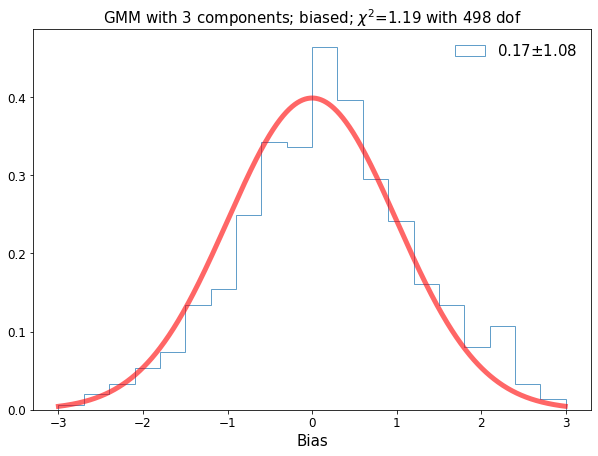

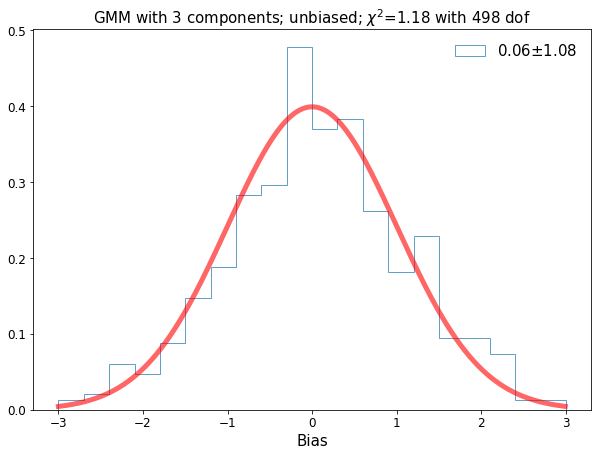

In [4]:
badidx = True

chi2 = np.load(f'./D3_chi2_final_v2_bs100_tol1e-6_N10000_diffmean_b.npy')
biases = np.load(f'./D3_biases_final_v2_bs100_tol1e-6_N10000_diffmean_b.npy')
bad_idx = np.load(f'./D3_bad_idx_final_v2_bs100_tol1e-6_N10000_diffmean_b.npy')

if badidx:
    chi2 = chi2[bad_idx]
    biases = biases[bad_idx]

    
#chi2 = chi2[biases<4]
#biases = biases[biases<4]

#chi2 = chi2[bad_idx]
#biases = biases[bad_idx]

df = len(chi2)-1
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 7))

#ax.errorbar(random_states, np.mean(MI_estimates, axis=1), np.sqrt(np.var(MI_estimates, axis=1)), fmt='x', color='salmon', label='Bootstrap')

ax1.hist(np.array(biases).flatten(), histtype='step', alpha=0.7, bins=20, label=f'{np.mean(biases):.2f}$\pm${np.std(biases):.2f}', range=(-3, 3), density='True')
x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Bias', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(fontsize=15, frameon=False)
ax1.plot(x, y,
       'r-', lw=5, alpha=0.6, label='Gaussian pdf')
ax1.set_title(f'GMM with {3} components; biased; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

print(np.min(biases)), print(np.max(biases))

    
chi2 = np.load(f'./D3_chi2_final_v2_bs100_tol1e-6_N10000_diffmean_unb.npy')
biases = np.load(f'./D3_biases_final_v2_bs100_tol1e-6_N10000_diffmean_unb.npy')

if badidx:
    chi2 = chi2[bad_idx]
    biases = biases[bad_idx]
    
df = len(chi2)-1
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 7))

#ax.errorbar(random_states, np.mean(MI_estimates, axis=1), np.sqrt(np.var(MI_estimates, axis=1)), fmt='x', color='salmon', label='Bootstrap')

ax1.hist(np.array(biases).flatten(), histtype='step', alpha=0.7, bins=20, label=f'{np.mean(biases):.2f}$\pm${np.std(biases):.2f}', range=(-3, 3), density='True')
x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Bias', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(fontsize=15, frameon=False)
ax1.plot(x, y,
       'r-', lw=5, alpha=0.6, label='Gaussian pdf')
ax1.set_title(f'GMM with {3} components; unbiased; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

print(np.min(biases)), print(np.max(biases))

In [492]:
len(bad_idx)

489

-3.8073282983746397
3.8908666770509837
-3.8589296756609723
3.8456310685551336


(None, None)

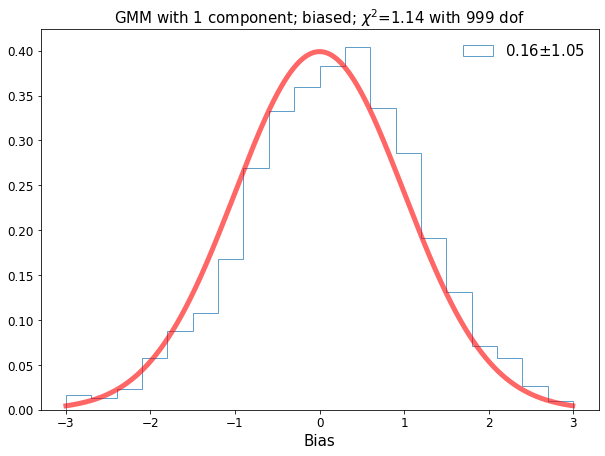

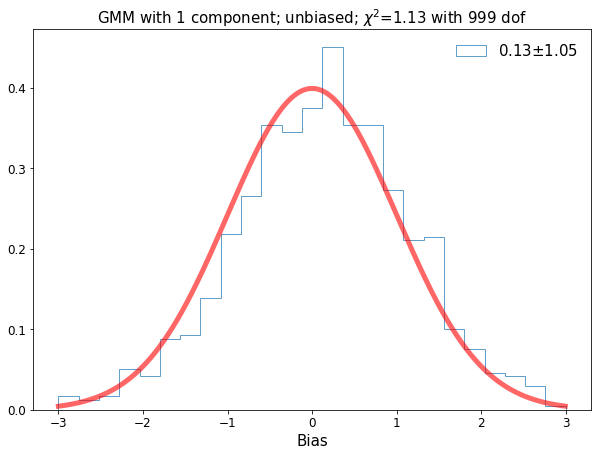

In [447]:
#d1
badidx = False

chi2 = np.load(f'./D1_chi2_final_v2_bs100_tol1e-6_N10000_diffmean_b.npy')
biases = np.load(f'./D1_biases_final_v2_bs100_tol1e-6_N10000_diffmean_b.npy')
bad_idx = np.load(f'./D1_bad_idx_final_v2_bs100_tol1e-6_N10000_diffmean_b.npy')

if badidx:
    chi2 = chi2[bad_idx]
    biases = biases[bad_idx]

    
#chi2 = chi2[biases<4]
#biases = biases[biases<4]

#chi2 = chi2[bad_idx]
#biases = biases[bad_idx]

df = len(chi2)-1
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 7))

#ax.errorbar(random_states, np.mean(MI_estimates, axis=1), np.sqrt(np.var(MI_estimates, axis=1)), fmt='x', color='salmon', label='Bootstrap')

ax1.hist(np.array(biases).flatten(), histtype='step', alpha=0.7, bins=20, label=f'{np.mean(biases):.2f}$\pm${np.std(biases):.2f}', range=(-3, 3), density='True')
x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Bias', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(fontsize=15, frameon=False)
ax1.plot(x, y,
       'r-', lw=5, alpha=0.6, label='Gaussian pdf')
ax1.set_title(f'GMM with {1} component; biased; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

print(np.min(biases)), print(np.max(biases))

    
chi2 = np.load(f'./D1_chi2_final_v2_bs100_tol1e-6_N10000_diffmean_unb.npy')
biases = np.load(f'./D1_biases_final_v2_bs100_tol1e-6_N10000_diffmean_unb.npy')

if badidx:
    chi2 = chi2[bad_idx]
    biases = biases[bad_idx]
    
df = len(chi2)-1
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 7))

#ax.errorbar(random_states, np.mean(MI_estimates, axis=1), np.sqrt(np.var(MI_estimates, axis=1)), fmt='x', color='salmon', label='Bootstrap')

ax1.hist(np.array(biases).flatten(), histtype='step', alpha=0.7, bins=25, label=f'{np.mean(biases):.2f}$\pm${np.std(biases):.2f}', range=(-3, 3), density='True')
x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Bias', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(fontsize=15, frameon=False)
ax1.plot(x, y,
       'r-', lw=5, alpha=0.6, label='Gaussian pdf')
ax1.set_title(f'GMM with {1} component; unbiased; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

print(np.min(biases)), print(np.max(biases))

-1.8875572104357576
2.627531648635152
-2.102824204846394
2.2410724365848864


(None, None)

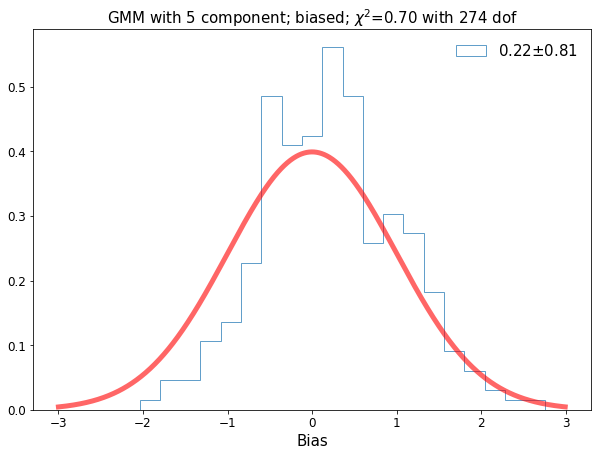

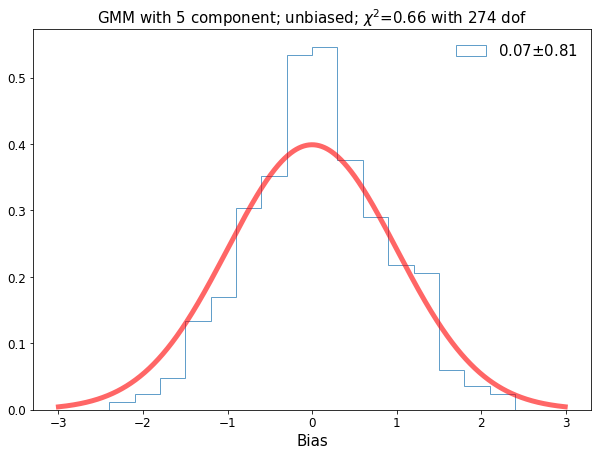

In [490]:
#d5
badidx = False

chi2 = np.load(f'./D5_chi2_final_v2_bs100_tol1e-6_N10000_diffmean_b.npy')
biases = np.load(f'./D5_biases_final_v2_bs100_tol1e-6_N10000_diffmean_b.npy')
bad_idx = np.load(f'./D5_bad_idx_final_v2_bs100_tol1e-6_N10000_diffmean_b.npy')

if badidx:
    chi2 = chi2[bad_idx]
    biases = biases[bad_idx]

    
#chi2 = chi2[biases<4]
#biases = biases[biases<4]

#chi2 = chi2[bad_idx]
#biases = biases[bad_idx]

df = len(chi2)-1
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 7))

#ax.errorbar(random_states, np.mean(MI_estimates, axis=1), np.sqrt(np.var(MI_estimates, axis=1)), fmt='x', color='salmon', label='Bootstrap')

ax1.hist(np.array(biases).flatten(), histtype='step', alpha=0.7, bins=25, label=f'{np.mean(biases):.2f}$\pm${np.std(biases):.2f}', range=(-3, 3), density='True')
x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Bias', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(fontsize=15, frameon=False)
ax1.plot(x, y,
       'r-', lw=5, alpha=0.6, label='Gaussian pdf')
ax1.set_title(f'GMM with {5} component; biased; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

print(np.min(biases)), print(np.max(biases))

    
chi2 = np.load(f'./D5_chi2_final_v2_bs100_tol1e-6_N10000_diffmean_unb.npy')
biases = np.load(f'./D5_biases_final_v2_bs100_tol1e-6_N10000_diffmean_unb.npy')

if badidx:
    chi2 = chi2[bad_idx]
    biases = biases[bad_idx]
    
df = len(chi2)-1
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 7))

#ax.errorbar(random_states, np.mean(MI_estimates, axis=1), np.sqrt(np.var(MI_estimates, axis=1)), fmt='x', color='salmon', label='Bootstrap')

ax1.hist(np.array(biases).flatten(), histtype='step', alpha=0.7, bins=20, label=f'{np.mean(biases):.2f}$\pm${np.std(biases):.2f}', range=(-3, 3), density='True')
x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Bias', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(fontsize=15, frameon=False)
ax1.plot(x, y,
       'r-', lw=5, alpha=0.6, label='Gaussian pdf')
ax1.set_title(f'GMM with {5} component; unbiased; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

print(np.min(biases)), print(np.max(biases))

-1.819164129319266
2.778602331468792
-2.1403125251801653
2.747523414531533


(None, None)

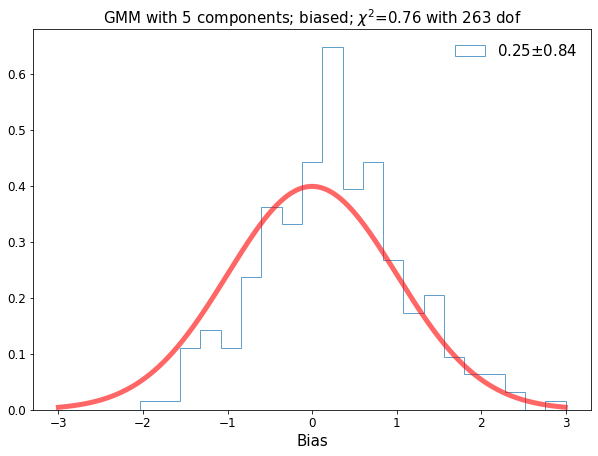

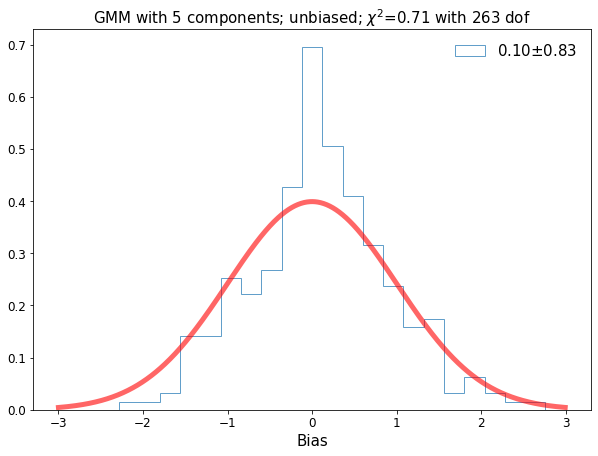

In [428]:
#d5
badidx = False

chi2 = np.load(f'./D5p_chi2_final_v2_bs100_tol1e-6_N10000_diffmean_b.npy')
biases = np.load(f'./D5p_biases_final_v2_bs100_tol1e-6_N10000_diffmean_b.npy')
bad_idx = np.load(f'./D5p_bad_idx_final_v2_bs100_tol1e-6_N10000_diffmean_b.npy')

if badidx:
    chi2 = chi2[bad_idx]
    biases = biases[bad_idx]

    
#chi2 = chi2[biases<4]
#biases = biases[biases<4]

#chi2 = chi2[bad_idx]
#biases = biases[bad_idx]

df = len(chi2)-1
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 7))

#ax.errorbar(random_states, np.mean(MI_estimates, axis=1), np.sqrt(np.var(MI_estimates, axis=1)), fmt='x', color='salmon', label='Bootstrap')

ax1.hist(np.array(biases).flatten(), histtype='step', alpha=0.7, bins=25, label=f'{np.mean(biases):.2f}$\pm${np.std(biases):.2f}', range=(-3, 3), density='True')
x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Bias', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(fontsize=15, frameon=False)
ax1.plot(x, y,
       'r-', lw=5, alpha=0.6, label='Gaussian pdf')
ax1.set_title(f'GMM with {5} components; biased; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

print(np.min(biases)), print(np.max(biases))

    
chi2 = np.load(f'./D5p_chi2_final_v2_bs100_tol1e-6_N10000_diffmean_unb.npy')
biases = np.load(f'./D5p_biases_final_v2_bs100_tol1e-6_N10000_diffmean_unb.npy')

if badidx:
    chi2 = chi2[bad_idx]
    biases = biases[bad_idx]
    
df = len(chi2)-1
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 7))

#ax.errorbar(random_states, np.mean(MI_estimates, axis=1), np.sqrt(np.var(MI_estimates, axis=1)), fmt='x', color='salmon', label='Bootstrap')

ax1.hist(np.array(biases).flatten(), histtype='step', alpha=0.7, bins=25, label=f'{np.mean(biases):.2f}$\pm${np.std(biases):.2f}', range=(-3, 3), density='True')
x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Bias', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(fontsize=15, frameon=False)
ax1.plot(x, y,
       'r-', lw=5, alpha=0.6, label='Gaussian pdf')
ax1.set_title(f'GMM with {5} components; unbiased; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

print(np.min(biases)), print(np.max(biases))

-3.1403370058310953


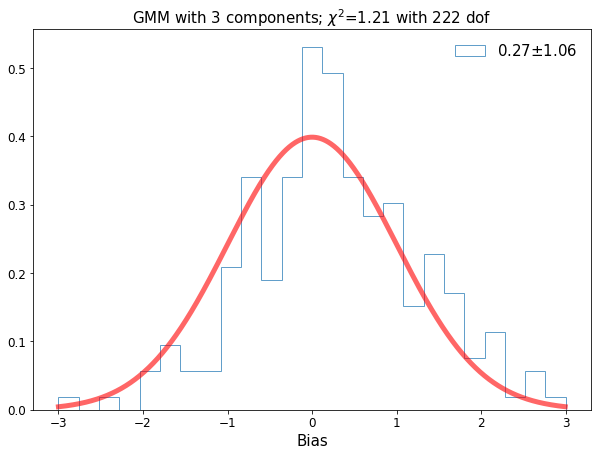

In [344]:
chi2 = np.load('./D3_chi2_final_v2_bs100_tol1e-6_diffseed.npy')
biases = np.load('./D3_biases_final_v2_bs100_tol1e-6_diffseed.npy')
bad_idx = np.load('./D3_bad_idx_final_v2_bs100_tol1e-6_diffseed.npy')

#chi2 = chi2[100:]
#biases = biases[100:]

#chi2 = chi2[bad_idx]
#biases = biases[bad_idx]

df = len(chi2)-1
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 7))

#ax.errorbar(random_states, np.mean(MI_estimates, axis=1), np.sqrt(np.var(MI_estimates, axis=1)), fmt='x', color='salmon', label='Bootstrap')

ax1.hist(np.array(biases).flatten(), histtype='step', alpha=0.7, bins=25, label=f'{np.mean(biases):.2f}$\pm${np.std(biases):.2f}', range=(-3, 3), density='True')
x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Bias', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(fontsize=15, frameon=False)
ax1.plot(x, y,
       'r-', lw=5, alpha=0.6, label='Gaussian pdf')
ax1.set_title(f'GMM with {3} components; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

print(np.min(biases))

-3.8073282983746397


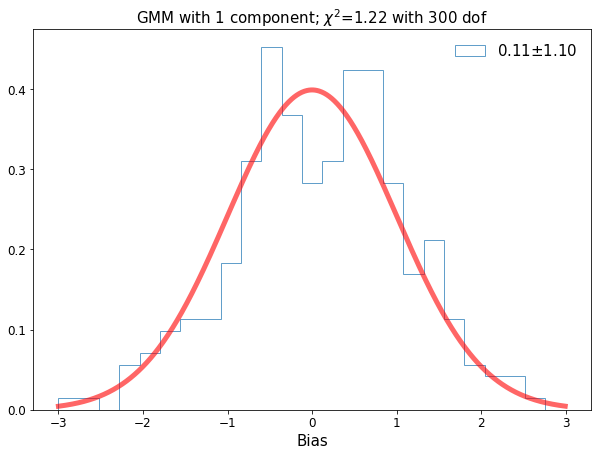

In [418]:
chi2 = np.load('./D1_chi2_final_v2_bs100_tol1e-6.npy')
biases = np.load('./D1_biases_final_v2_bs100_tol1e-6.npy')
bad_idx = np.load('./D1_bad_idx_final_v2_bs100_tol1e-6.npy')

#chi2 = chi2[bad_idx]
#biases = biases[bad_idx]

chi2 = chi2[100:401]
biases = biases[100:401]

df = len(chi2)-1
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 7))
bins=25
#ax.errorbar(random_states, np.mean(MI_estimates, axis=1), np.sqrt(np.var(MI_estimates, axis=1)), fmt='x', color='salmon', label='Bootstrap')

ax1.hist(np.array(biases).flatten(), histtype='step', alpha=0.7, bins=bins, label=f'{np.mean(biases):.2f}$\pm${np.std(biases):.2f}', range=(-3, 3), density='True')
x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Bias', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(fontsize=15, frameon=False)
ax1.plot(x, y,
       'r-', lw=5, alpha=0.6, label='Gaussian pdf')
ax1.set_title(f'GMM with {1} component; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

print(np.min(biases))

-2.1476568027598897


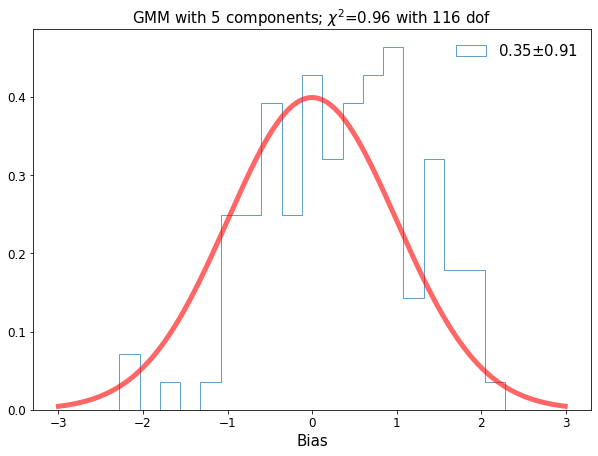

In [469]:
chi2 = np.load('./D5_chi2_final_v2_bs100_tol1e-6.npy')
biases = np.load('./D5_biases_final_v2_bs100_tol1e-6.npy')
bad_idx = np.load('./D5_bad_idx_final_v2_bs100_tol1e-6.npy')

#chi2 = chi2[bad_idx]#:]#[np.argsort(np.abs(chi2-1))[:500]]
#biases = biases[bad_idx]#[np.argsort(np.abs(chi2-1))[:500]]

df = len(chi2)-1
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 7))
bins=25
#ax.errorbar(random_states, np.mean(MI_estimates, axis=1), np.sqrt(np.var(MI_estimates, axis=1)), fmt='x', color='salmon', label='Bootstrap')

ax1.hist(np.array(biases).flatten(), histtype='step', alpha=0.7, bins=bins, label=f'{np.mean(biases):.2f}$\pm${np.std(biases):.2f}', range=(-3, 3), density='True')
x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Bias', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(fontsize=15, frameon=False)
ax1.plot(x, y,
       'r-', lw=5, alpha=0.6, label='Gaussian pdf')
ax1.set_title(f'GMM with {5} components; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

print(np.min(biases))

-1.7923824628680343


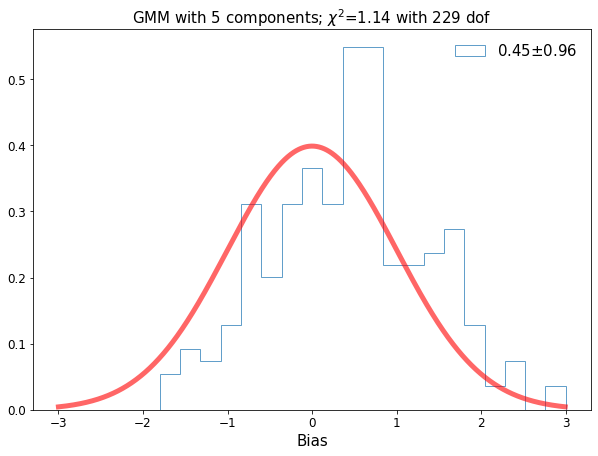

In [470]:
chi2 = np.load('./D5p_chi2_final_v2_bs100_tol1e-6.npy')
biases = np.load('./D5p_biases_final_v2_bs100_tol1e-6.npy')
bad_idx = np.load('./D5p_bad_idx_final_v2_bs100_tol1e-6.npy')

#chi2 = chi2[bad_idx]#:]#[np.argsort(np.abs(chi2-1))[:500]]
#biases = biases[bad_idx]#[np.argsort(np.abs(chi2-1))[:500]]

df = len(chi2)-1
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 7))
bins=25
#ax.errorbar(random_states, np.mean(MI_estimates, axis=1), np.sqrt(np.var(MI_estimates, axis=1)), fmt='x', color='salmon', label='Bootstrap')

ax1.hist(np.array(biases).flatten(), histtype='step', alpha=0.7, bins=bins, label=f'{np.mean(biases):.2f}$\pm${np.std(biases):.2f}', range=(-3, 3), density='True')
x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Bias', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(fontsize=15, frameon=False)
ax1.plot(x, y,
       'r-', lw=5, alpha=0.6, label='Gaussian pdf')
ax1.set_title(f'GMM with {5} components; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

print(np.min(biases))

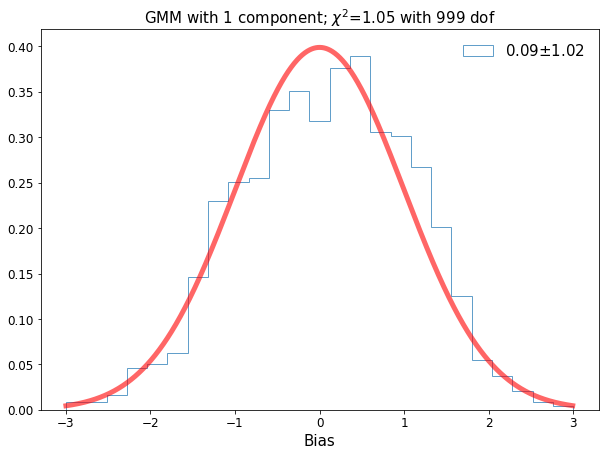

In [300]:
chi2 = np.load('./D1_chi2_final_v2.npy')
biases = np.load('./D1_biases_final_v2.npy')
bad_idx = np.load('./D1_bad_idx_v2.npy')

#chi2 = chi2[:50]
#biases = biases[:50]

df = len(chi2)-1
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 7))
bins=25
#ax.errorbar(random_states, np.mean(MI_estimates, axis=1), np.sqrt(np.var(MI_estimates, axis=1)), fmt='x', color='salmon', label='Bootstrap')

ax1.hist(np.array(biases).flatten(), histtype='step', alpha=0.7, bins=bins, label=f'{np.mean(biases):.2f}$\pm${np.std(biases):.2f}', range=(-3, 3), density='True')
x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Bias', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(fontsize=15, frameon=False)
ax1.plot(x, y,
       'r-', lw=5, alpha=0.6, label='Gaussian pdf')
ax1.set_title(f'GMM with {1} component; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);


### D5

In [435]:
knn_estimates = np.load('./mine-pytorch/mine/D5_knn.npy')
mine_estimates = np.load('./mine-pytorch/mine/D5_mine.npy')
all_MI_estimates = np.load('./mine-pytorch/mine/D5_ours.npy')
analytic = np.load('./mine-pytorch/mine/D5_analytic.npy')

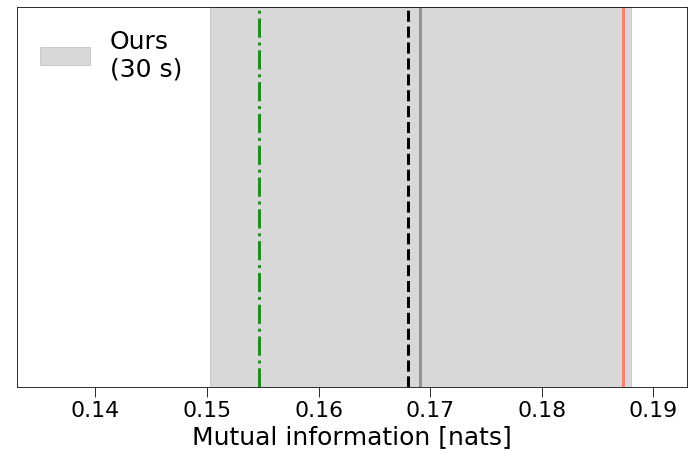

In [75]:
# let's plot all of this
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

lw=3
label = '$N=200$ samples to fit, 20 bootstrap realisations'
ax.tick_params(axis='both', which='major', labelsize=22, size=10)
#ax.axvline(knn_estimates, c='salmon', lw=lw, label='KSG (0.01 s)')
ax.axvline(knn_estimates, c='salmon', lw=lw)
#ax.axvline(mine_estimates, c='forestgreen', ls='-.', lw=lw, label='MINE (25 s)')
ax.axvline(mine_estimates, c='forestgreen', ls='-.', lw=lw)

ax.axvline(all_MI_estimates[:, 0], color='grey', alpha=0.8, lw=3)
ax.axvspan(all_MI_estimates[:, 0] - all_MI_estimates[:, 1], all_MI_estimates[:, 0]+all_MI_estimates[:, 1], color='grey', alpha=0.3, label='Ours\n(30 s)')
#ax.errorbar( np.mean(MI_estimates), 0.5, 0, np.std(MI_estimates), fmt='.', markersize=20, color='grey', capsize=10, elinewidth=2, label='Ours (30 s)')
#ax.axvline(analytic, ls='--', c='black', lw=lw, label='Ground truth')
ax.axvline(analytic, ls='--', c='black', lw=lw)


#handles, labels = ax.get_legend_handles_labels()
#i1, i2 = -1, -2
#handles[i1], handles[i2] = handles[i2], handles[i1] 
#labels[i1], labels[i2] = labels[i2], labels[i1] 

#ax.set_title(label, fontsize=30)
ax.legend(fontsize=25, frameon=False, loc='upper left')
        
ax.set_xlim((0.133, 0.193))
        
ax.axes.yaxis.set_ticks([])
ax.set_ylim((0.38, 0.62))
ax.set_xlabel('Mutual information [nats]', fontsize=25);

plt.savefig('./figures/D5_comparison.pdf',  bbox_inches='tight');

### All residuals

In [240]:
def load_data(dataset, suffix):
    chi2 = np.load(f'./{dataset}_chi2_{suffix}.npy')
    biases = np.load(f'./{dataset}_biases_{suffix}.npy')
    return chi2, biases

#bad_idx = np.load('./D1_bad_idx.npy')

ranges = 3
bins = 20
size = 1001

chi2_d1, biases_d1 = load_data('D1', 'final')
chi2_d1_, biases_d1_ = load_data('D1', 'final_bis')
chi2_d1 = np.concatenate((chi2_d1, chi2_d1_))
biases_d1 = np.concatenate((biases_d1, biases_d1_))

idx = np.random.choice(np.arange(len(chi2_d1)), size)
chi2_d1 = chi2_d1[idx]
biases_d1 = biases_d1[idx]


chi2_d3, biases_d3 = load_data('D3', 'final_bis')
chi2_d5, biases_d5 = load_data('D5', 'final_bis')

In [117]:
best_chi = 2

for _ in range(500):
    chi2_d1, biases_d1 = load_data('D1', 'final')
    chi2_d1_, biases_d1_ = load_data('D1', 'final_bis')
    chi2_d1 = np.concatenate((chi2_d1, chi2_d1_))
    biases_d1 = np.concatenate((biases_d1, biases_d1_))

    idx = np.random.choice(np.arange(len(chi2_d1)), size)
    chi2_d1 = chi2_d1[idx]
    biases_d1 = biases_d1[idx]
    df = len(chi2_d1)-1
    chired = np.sum(chi2_d1)/df
    if np.abs(chired - 1) < best_chi:
        best_chi = np.abs(chired - 1)
        best_idx = idx
        print(best_chi)

0.19847074311116542
0.1457350449630217
0.10780375203902626
0.052131167357787556
0.03247221006508649


In [223]:
chi2_d1, biases_d1 = load_data('D1', 'final')
chi2_d1_, biases_d1_ = load_data('D1', 'final_bis')
chi2_d1 = np.concatenate((chi2_d1, chi2_d1_))
biases_d1 = np.concatenate((biases_d1, biases_d1_))
#chi2_d1 = chi2_d1[best_idx]
#biases_d1 = biases_d1[best_idx]

In [224]:
#best_idx_1 = np.copy(best_idx)
chi2_d1 = chi2_d1[best_idx_1]
biases_d1 = biases_d1[best_idx_1]

0.16$\pm$1.04,
$\chi^2_{{red}}$=1.14 with 999 dof


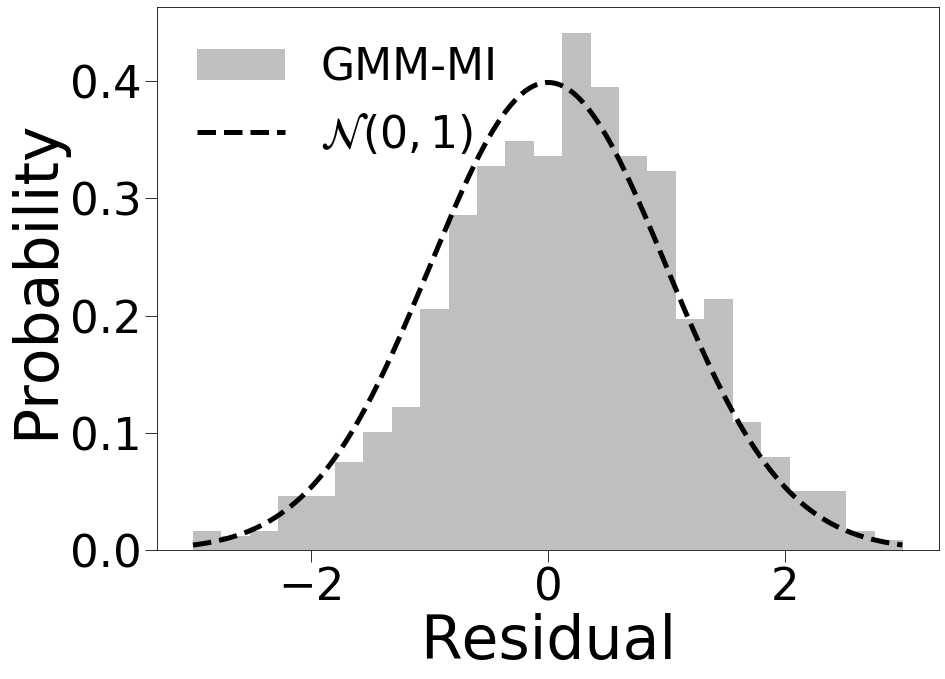

In [247]:
chi2_d1, biases_d1 = load_data('D1', 'final_v2_bs100_tol1e-6')
#chi2_d1 = chi2_d1[best_idx]
#biases_d1 = biases_d1[best_idx]

df = len(chi2_d1)-1
#print(df)
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))
bins=25
alpha=0.5
legendsize=44

ax1.hist(np.array(biases_d1).flatten(), alpha=alpha, bins=bins, 
         label='GMM-MI', color='grey', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d3).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D3, {np.mean(biases_d3):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d3)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d5).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D5, {np.mean(biases_d5):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d5)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')

   
label = f'D1: {np.mean(biases_d1):.2f}$\pm${np.std(biases_d1):.2f}, $\chi^2_{{{{red}}}}$={np.sum(chi2_d1)/df:.2f} with {df} dof'


print(f'{np.mean(biases_d1):.2f}$\pm${np.std(biases):.2f},\n$\chi^2_{{{{red}}}}$={np.sum(chi2_d1)/df:.2f} with {df} dof')



x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Residual', fontsize=60)
ax1.set_ylabel('Probability', fontsize=60)

ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.plot(x, y, c='black', ls='--', lw=5, alpha=1, label=r'$\mathcal{N}(0, 1)$')
#ax1.set_title(f'GMM with {1} component; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

handles, labels = ax1.get_legend_handles_labels()
i1, i2 = -1, -2
handles[i1], handles[i2] = handles[i2], handles[i1] 
labels[i1], labels[i2] = labels[i2], labels[i1] 


ax1.tick_params(axis='both', which='major', labelsize=45, size=12)
ax1.legend(handles, labels, fontsize=legendsize, frameon=False, loc='upper left')
#ax1.set_title(label, fontsize=25)

plt.savefig('./figures/D1_residuals.pdf',  bbox_inches='tight');

0.22$\pm$1.10,
$\chi^2_{{red}}$=1.22 with 732 dof


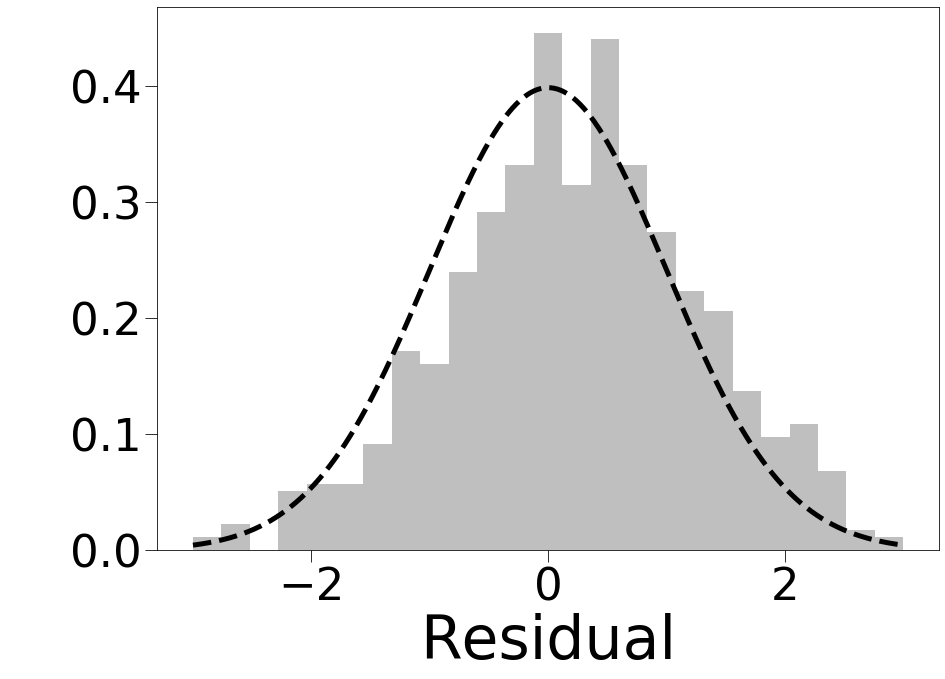

In [276]:
chi2_d1, biases_d1 = load_data('D3', 'final_v2_bs100_tol1e-6')
#chi2_d1 = chi2_d1[best_idx]
#biases_d1 = biases_d1[best_idx]

df = len(chi2_d1)-1
#print(df)
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))
bins=25
alpha=0.5
legendsize=44

ax1.hist(np.array(biases_d1).flatten(), alpha=alpha, bins=bins, 
         label='GMM-MI', color='grey', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d3).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D3, {np.mean(biases_d3):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d3)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d5).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D5, {np.mean(biases_d5):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d5)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')

   
label = f'D1: {np.mean(biases_d1):.2f}$\pm${np.std(biases_d1):.2f}, $\chi^2_{{{{red}}}}$={np.sum(chi2_d1)/df:.2f} with {df} dof'


print(f'{np.mean(biases_d1):.2f}$\pm${np.std(biases):.2f},\n$\chi^2_{{{{red}}}}$={np.sum(chi2_d1)/df:.2f} with {df} dof')



x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Residual', fontsize=60)
ax1.set_ylabel('Probability', fontsize=60, color='white')

ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.plot(x, y, c='black', ls='--', lw=5, alpha=1, label=r'$\mathcal{N}(0, 1)$')
#ax1.set_title(f'GMM with {1} component; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

handles, labels = ax1.get_legend_handles_labels()
i1, i2 = -1, -2
handles[i1], handles[i2] = handles[i2], handles[i1] 
labels[i1], labels[i2] = labels[i2], labels[i1] 


ax1.tick_params(axis='both', which='major', labelsize=45, size=12)
#ax1.legend(handles, labels, fontsize=legendsize, frameon=False, loc='upper left')
#ax1.set_title(label, fontsize=25)

plt.savefig('./figures/D3_residuals.pdf',  bbox_inches='tight');

0.18$\pm$1.10,
$\chi^2_{{red}}$=1.26 with 500 dof


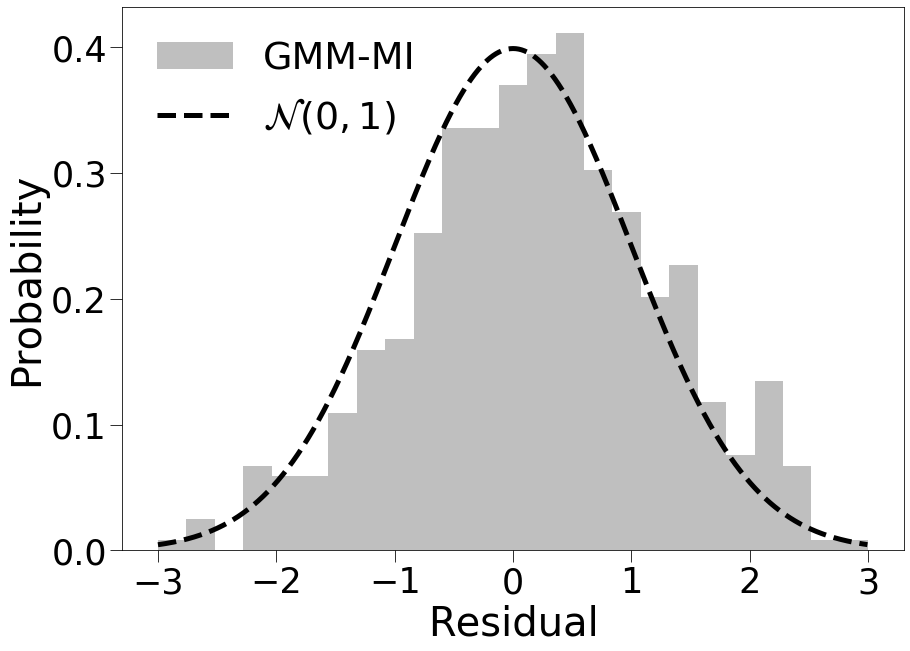

In [464]:
badidx = False

chi2_d1 = np.load(f'./D3_chi2_final_v2_bs100_tol1e-6_N10000_diffmean_b.npy')
biases_d1 = np.load(f'./D3_biases_final_v2_bs100_tol1e-6_N10000_diffmean_b.npy')
bad_idx = np.load(f'./D3_bad_idx_final_v2_bs100_tol1e-6_N10000_diffmean_b.npy')

if badidx:
    chi2_d1 = chi2_d1[bad_idx]
    biases_d1 = biases_d1[bad_idx]
    
chi2_d1 = chi2_d1[:501]
biases_d1 = biases_d1[:501]

df = len(chi2_d1)-1
#print(df)
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))
bins=25
alpha=0.5
legendsize=38

ax1.hist(np.array(biases_d1).flatten(), alpha=alpha, bins=bins, 
         label='GMM-MI', color='grey', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d3).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D3, {np.mean(biases_d3):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d3)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d5).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D5, {np.mean(biases_d5):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d5)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')

   
label = f'D1: {np.mean(biases_d1):.2f}$\pm${np.std(biases_d1):.2f}, $\chi^2_{{{{red}}}}$={np.sum(chi2_d1)/df:.2f} with {df} dof'


print(f'{np.mean(biases_d1):.2f}$\pm${np.std(biases_d1):.2f},\n$\chi^2_{{{{red}}}}$={np.sum(chi2_d1)/df:.2f} with {df} dof')



x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Residual', fontsize=40)
ax1.set_ylabel('Probability', fontsize=40)

ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.plot(x, y, c='black', ls='--', lw=5, alpha=1, label=r'$\mathcal{N}(0, 1)$')
#ax1.set_title(f'GMM with {1} component; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

handles, labels = ax1.get_legend_handles_labels()
i1, i2 = -1, -2
handles[i1], handles[i2] = handles[i2], handles[i1] 
labels[i1], labels[i2] = labels[i2], labels[i1] 


ax1.tick_params(axis='both', which='major', labelsize=35, size=12)
ax1.legend(handles, labels, fontsize=legendsize, frameon=False, loc='upper left')
#ax1.set_title(label, fontsize=25)

plt.savefig('./figures/D3_residuals.pdf',  bbox_inches='tight');

0.18$\pm$1.10,
$\chi^2_{{red}}$=1.26 with 500 dof


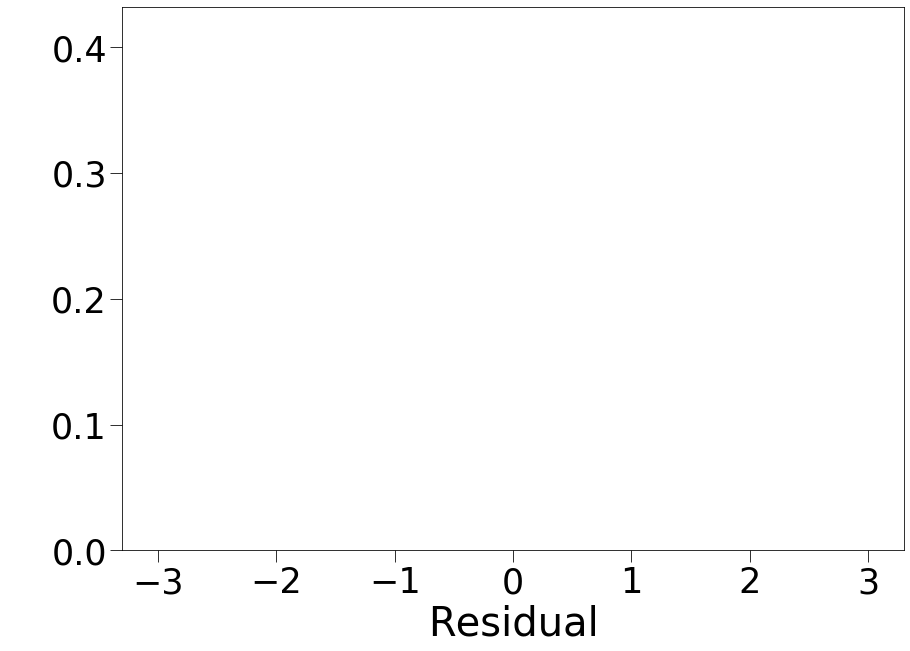

In [467]:
badidx = False

chi2_d1 = np.load(f'./D3_chi2_final_v2_bs100_tol1e-6_N10000_diffmean_b.npy')
biases_d1 = np.load(f'./D3_biases_final_v2_bs100_tol1e-6_N10000_diffmean_b.npy')
bad_idx = np.load(f'./D3_bad_idx_final_v2_bs100_tol1e-6_N10000_diffmean_b.npy')

if badidx:
    chi2_d1 = chi2_d1[bad_idx]
    biases_d1 = biases_d1[bad_idx]
    
chi2_d1 = chi2_d1[:501]
biases_d1 = biases_d1[:501]

df = len(chi2_d1)-1
#print(df)
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))
bins=25
alpha=0.5
legendsize=38

ax1.hist(np.array(biases_d1).flatten(), alpha=alpha, bins=bins, 
         label='GMM-MI', color='white', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d3).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D3, {np.mean(biases_d3):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d3)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d5).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D5, {np.mean(biases_d5):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d5)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')

   
label = f'D1: {np.mean(biases_d1):.2f}$\pm${np.std(biases_d1):.2f}, $\chi^2_{{{{red}}}}$={np.sum(chi2_d1)/df:.2f} with {df} dof'


print(f'{np.mean(biases_d1):.2f}$\pm${np.std(biases_d1):.2f},\n$\chi^2_{{{{red}}}}$={np.sum(chi2_d1)/df:.2f} with {df} dof')



x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Residual', fontsize=40)
ax1.set_ylabel('Probability', fontsize=40, color='white')

ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.plot(x, y, c='white', ls='--', lw=5, alpha=1, label=r'$\mathcal{N}(0, 1)$')
#ax1.set_title(f'GMM with {1} component; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

handles, labels = ax1.get_legend_handles_labels()
i1, i2 = -1, -2
handles[i1], handles[i2] = handles[i2], handles[i1] 
labels[i1], labels[i2] = labels[i2], labels[i1] 


ax1.tick_params(axis='both', which='major', labelsize=35, size=12)
#ax1.legend(handles, labels, fontsize=legendsize, frameon=False, loc='upper left')
#ax1.set_title(label, fontsize=25)

plt.savefig('./figures/D5_residuals.pdf',  bbox_inches='tight');

0.18$\pm$1.10,
$\chi^2_{{red}}$=1.26 with 500 dof


Text(0.5, 1.0, 'D3 (using bootstrap mean): 0.18$\\pm$1.10, $\\chi^2_{{red}}$=1.26 with 500 dof')

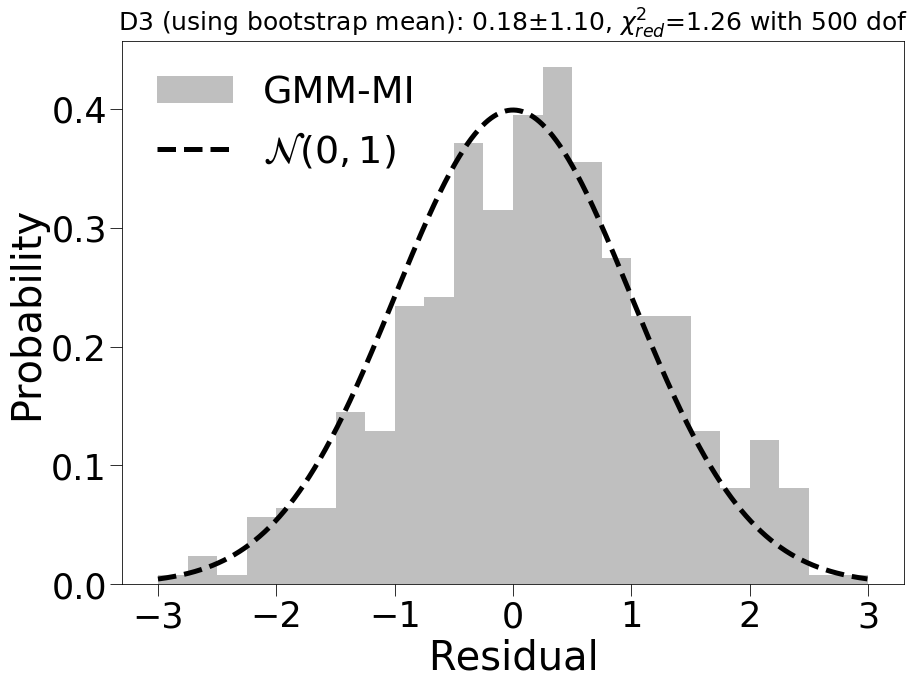

In [477]:
badidx = False

chi2_d1 = np.load(f'./D3_chi2_final_v2_bs100_tol1e-6_N10000_diffmean_b.npy')
biases_d1 = np.load(f'./D3_biases_final_v2_bs100_tol1e-6_N10000_diffmean_b.npy')
bad_idx = np.load(f'./D3_bad_idx_final_v2_bs100_tol1e-6_N10000_diffmean_b.npy')

if badidx:
    chi2_d1 = chi2_d1[bad_idx]
    biases_d1 = biases_d1[bad_idx]
    
chi2_d1 = chi2_d1[:501]
biases_d1 = biases_d1[:501]

df = len(chi2_d1)-1
#print(df)
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))
bins=24
alpha=0.5
legendsize=38

ax1.hist(np.array(biases_d1).flatten(), alpha=alpha, bins=bins, 
         label='GMM-MI', color='grey', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d3).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D3, {np.mean(biases_d3):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d3)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d5).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D5, {np.mean(biases_d5):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d5)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')

   
label = f'D3 (using bootstrap mean): {np.mean(biases_d1):.2f}$\pm${np.std(biases_d1):.2f}, $\chi^2_{{{{red}}}}$={np.sum(chi2_d1)/df:.2f} with {df} dof'


print(f'{np.mean(biases_d1):.2f}$\pm${np.std(biases_d1):.2f},\n$\chi^2_{{{{red}}}}$={np.sum(chi2_d1)/df:.2f} with {df} dof')



x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Residual', fontsize=40)
ax1.set_ylabel('Probability', fontsize=40)

ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.plot(x, y, c='black', ls='--', lw=5, alpha=1, label=r'$\mathcal{N}(0, 1)$')
#ax1.set_title(f'GMM with {1} component; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

handles, labels = ax1.get_legend_handles_labels()
i1, i2 = -1, -2
handles[i1], handles[i2] = handles[i2], handles[i1] 
labels[i1], labels[i2] = labels[i2], labels[i1] 


ax1.tick_params(axis='both', which='major', labelsize=35, size=12)
ax1.legend(handles, labels, fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_title(label, fontsize=25)

#plt.savefig('./figures/D3_residuals.pdf',  bbox_inches='tight');

0.07$\pm$1.11,
$\chi^2_{{red}}$=1.23 with 500 dof


Text(0.5, 1.0, 'D3 (using single MI estimate as mean): 0.07$\\pm$1.11, $\\chi^2_{{red}}$=1.23 with 500 dof')

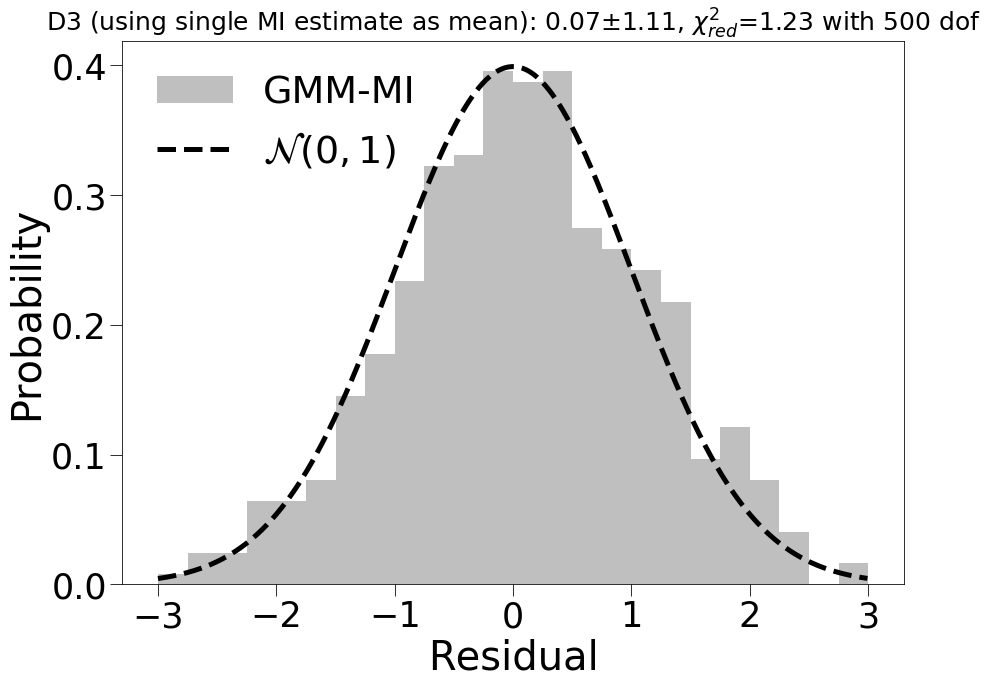

In [480]:
badidx = False

chi2_d1 = np.load(f'./D3_chi2_final_v2_bs100_tol1e-6_N10000_diffmean_unb.npy')
biases_d1 = np.load(f'./D3_biases_final_v2_bs100_tol1e-6_N10000_diffmean_unb.npy')
bad_idx = np.load(f'./D3_bad_idx_final_v2_bs100_tol1e-6_N10000_diffmean_b.npy')

if badidx:
    chi2_d1 = chi2_d1[bad_idx]
    biases_d1 = biases_d1[bad_idx]
    
chi2_d1 = chi2_d1[:501]
biases_d1 = biases_d1[:501]

df = len(chi2_d1)-1
#print(df)
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))
bins=24
alpha=0.5
legendsize=38

ax1.hist(np.array(biases_d1).flatten(), alpha=alpha, bins=bins, 
         label='GMM-MI', color='grey', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d3).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D3, {np.mean(biases_d3):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d3)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d5).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D5, {np.mean(biases_d5):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d5)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')

   
label = f'D3 (using single MI estimate as mean): {np.mean(biases_d1):.2f}$\pm${np.std(biases_d1):.2f}, $\chi^2_{{{{red}}}}$={np.sum(chi2_d1)/df:.2f} with {df} dof'


print(f'{np.mean(biases_d1):.2f}$\pm${np.std(biases_d1):.2f},\n$\chi^2_{{{{red}}}}$={np.sum(chi2_d1)/df:.2f} with {df} dof')



x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Residual', fontsize=40)
ax1.set_ylabel('Probability', fontsize=40)

ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.plot(x, y, c='black', ls='--', lw=5, alpha=1, label=r'$\mathcal{N}(0, 1)$')
#ax1.set_title(f'GMM with {1} component; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

handles, labels = ax1.get_legend_handles_labels()
i1, i2 = -1, -2
handles[i1], handles[i2] = handles[i2], handles[i1] 
labels[i1], labels[i2] = labels[i2], labels[i1] 


ax1.tick_params(axis='both', which='major', labelsize=35, size=12)
ax1.legend(handles, labels, fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_title(label, fontsize=25)

#plt.savefig('./figures/D3_residuals.pdf',  bbox_inches='tight');

-3.2405808476719526
0.19$\pm$1.05,
$\chi^2_{{red}}$=1.15 with 300 dof


Text(0.5, 1.0, 'D3: 0.19$\\pm$1.05, $\\chi^2_{{red}}$=1.15 with 300 dof')

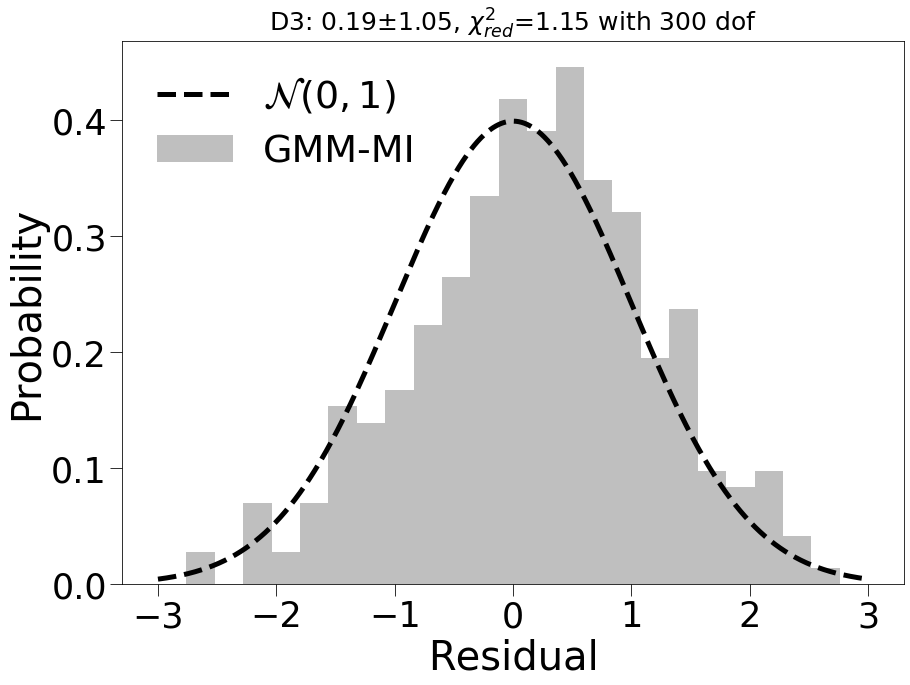

In [419]:
chi2_d1, biases_d1 = load_data('D3', 'final_v2_bs100_tol1e-6')
#chi2_d1 = chi2_d1[best_idx]
#biases_d1 = biases_d1[best_idx]
chi2_d1 = chi2_d1[100:401]
biases_d1 = biases_d1[100:401]

print(np.min(biases_d1))

df = len(chi2_d1)-1
#print(df)
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))
bins=25
alpha=0.5
legendsize=38

ax1.hist(np.array(biases_d1).flatten(), alpha=alpha, bins=bins, 
         label='GMM-MI', color='grey', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d3).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D3, {np.mean(biases_d3):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d3)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d5).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D5, {np.mean(biases_d5):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d5)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')

label = f'D3: {np.mean(biases_d1):.2f}$\pm${np.std(biases_d1):.2f}, $\chi^2_{{{{red}}}}$={np.sum(chi2_d1)/df:.2f} with {df} dof'
print(f'{np.mean(biases_d1):.2f}$\pm${np.std(biases_d1):.2f},\n$\chi^2_{{{{red}}}}$={np.sum(chi2_d1)/df:.2f} with {df} dof')


x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Residual', fontsize=40)
ax1.set_ylabel('Probability', fontsize=40)

ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.plot(x, y, c='black', ls='--', lw=5, alpha=1, label=r'$\mathcal{N}(0, 1)$')
#ax1.set_title(f'GMM with {1} component; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

ax1.tick_params(axis='both', which='major', labelsize=35, size=12)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')

ax1.set_title(label, fontsize=25)
#plt.savefig('./figures/D3_residuals.pdf',  bbox_inches='tight');

0.28$\pm$0.96,
$\chi^2_{{red}}$=0.99 with 500 dof


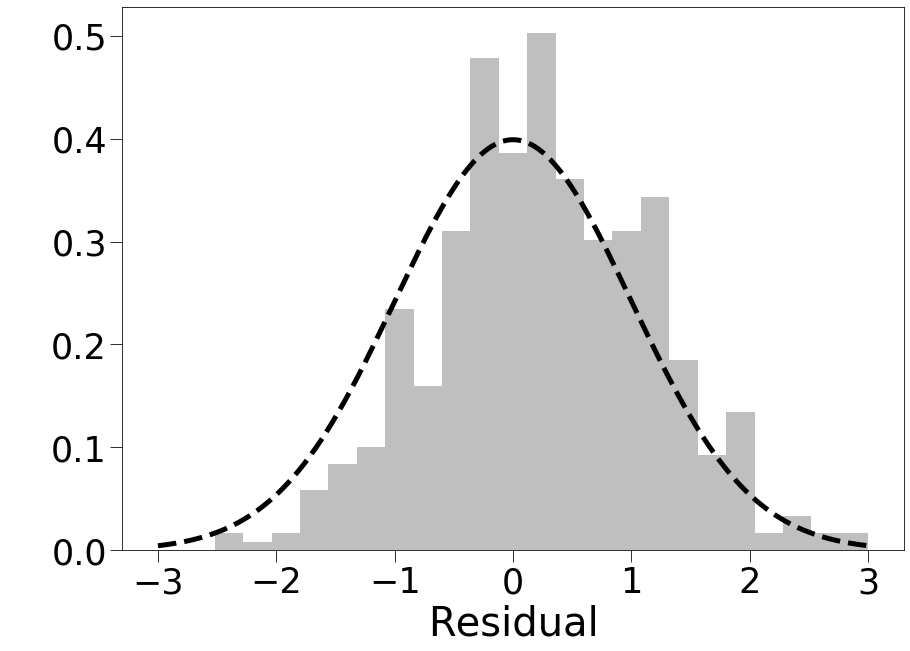

In [255]:
chi2_d1, biases_d1 = load_data('D5', 'final_bis')
chi2_d1 = chi2_d1[150:651]
biases_d1 = biases_d1[150:651]

df = len(chi2_d1)-1
#print(df)
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))
bins=25
alpha=0.5
legendsize=38

ax1.hist(np.array(biases_d1).flatten(), alpha=alpha, bins=bins, 
         label='GMM-MI', color='grey', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d3).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D3, {np.mean(biases_d3):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d3)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d5).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D5, {np.mean(biases_d5):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d5)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')

         
print(f'{np.mean(biases_d1):.2f}$\pm${np.std(biases_d1):.2f},\n$\chi^2_{{{{red}}}}$={np.sum(chi2_d1)/df:.2f} with {df} dof')


x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Residual', fontsize=40)
ax1.set_ylabel('Probability', fontsize=40, color='white')

ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.plot(x, y, c='black', ls='--', lw=5, alpha=1, label=r'$\mathcal{N}(0, 1)$')
#ax1.set_title(f'GMM with {1} component; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

ax1.tick_params(axis='both', which='major', labelsize=35, size=12)
#ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')

plt.savefig('./figures/D5_residuals.pdf',  bbox_inches='tight');

In [454]:
size = 301
chi2_d3, biases_d3 = load_data('D1', 'final_v2_bs100_tol1e-6')
#chi2_d3_, biases_d3_ = load_data('D3', 'final_bis')
#chi2_d3 = np.concatenate((chi2_d3, chi2_d3_))
#biases_d3 = np.concatenate((biases_d3, biases_d3_))

In [459]:
best_chi = 2
best_bias = 2

for _ in range(50):
    chi2_d3, biases_d3 = load_data('D1', 'final_v2_bs100_tol1e-6')
    #chi2_d3_, biases_d3_ = load_data('D3', 'final_bis')
    #chi2_d3 = np.concatenate((chi2_d3, chi2_d3_))
    #biases_d3 = np.concatenate((biases_d3, biases_d3_))

    idx = np.random.choice(np.arange(len(chi2_d3)), size)
    chi2_d3 = chi2_d3[idx]
    biases_d3 = biases_d3[idx]
    df = len(chi2_d3)-1
    chired = np.sum(chi2_d3)/df
    
    biases = np.mean(biases_d3)
    if np.abs(chired - 1) < best_chi and np.abs(biases) < best_bias:
    #if np.abs(chired) < best_chi:
        best_chi = np.abs(chired - 1)
        best_bias = np.abs(biases)

        best_idx = idx
        print(best_chi, best_bias)

chi2_d1, biases_d1 = load_data('D1', 'final_v2_bs100_tol1e-6')
chi2_d1 = chi2_d1[best_idx]
biases_d1 = biases_d1[best_idx]

print(f'{np.mean(biases_d1):.2f}$\pm${np.std(biases_d1):.2f},\n$\chi^2_{{{{red}}}}$={np.sum(chi2_d1)/df:.2f} with {df} dof')

0.09681814407987877 0.0622049695129898
0.06$\pm$1.04,
$\chi^2_{{red}}$=1.10 with 300 dof


In [211]:
chi2_d1, biases_d1 = load_data('D3', 'final')
chi2_d1_, biases_d1_ = load_data('D3', 'final_bis')
chi2_d1 = np.concatenate((chi2_d1, chi2_d1_))
biases_d1 = np.concatenate((biases_d1, biases_d1_))
chi2_d1 = chi2_d1[best_idx]
biases_d1 = biases_d1[best_idx]

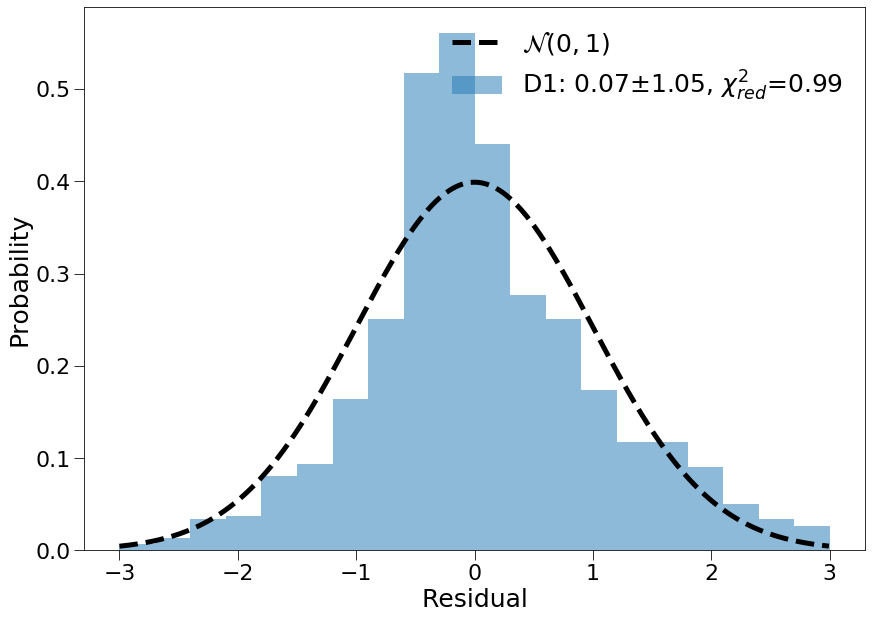

In [212]:
df = len(chi2_d1)-1
#print(df)
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))
bins=20
alpha=0.5
legendsize=25

ax1.hist(np.array(biases_d1).flatten(), alpha=alpha, bins=bins, 
         label=f'D1: {np.mean(biases_d1):.2f}$\pm${np.std(biases):.2f}, $\chi^2_{{{{red}}}}$={np.sum(chi2_d1)/df:.2f}', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d3).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D3, {np.mean(biases_d3):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d3)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d5).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D5, {np.mean(biases_d5):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d5)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')



x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Residual', fontsize=25)
ax1.set_ylabel('Probability', fontsize=25)

ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.plot(x, y, c='black', ls='--', lw=5, alpha=1, label=r'$\mathcal{N}(0, 1)$')
#ax1.set_title(f'GMM with {1} component; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

ax1.tick_params(axis='both', which='major', labelsize=22, size=10)
ax1.legend(fontsize=legendsize, frameon=False);

In [213]:
chi2_d5, biases_d5 = load_data('D5', 'final')
chi2_d5_, biases_d5_ = load_data('D5', 'final_bis')
chi2_d5 = np.concatenate((chi2_d5, chi2_d5_))
biases_d5 = np.concatenate((biases_d5, biases_d5_))

In [215]:
best_chi = 2

for _ in range(2000):
    chi2_d5, biases_d5 = load_data('D5', 'final')
    chi2_d5_, biases_d5_ = load_data('D5', 'final_bis')
    chi2_d5 = np.concatenate((chi2_d5, chi2_d5_))
    biases_d5 = np.concatenate((biases_d5, biases_d5_))

    idx = np.random.choice(np.arange(len(chi2_d5)), size)
    chi2_d5 = chi2_d5[idx]
    biases_d5 = biases_d5[idx]
    df = len(chi2_d5)-1
    chired = np.sum(chi2_d5)/df
    if np.abs(chired-1) < best_chi:
        best_chi = np.abs(chired-1)
        best_idx = idx
        print(best_chi)

0.11051845908903668
0.08601656843908956
0.07440099503913578
0.035037354922263786
0.02277718272388274
0.019257620092420713
0.012441612106334987
0.002404231425676251
0.00029434387015703223
0.0001955999454508195


In [216]:
chi2_d1, biases_d1 = load_data('D5', 'final')
chi2_d1_, biases_d1_ = load_data('D5', 'final_bis')
chi2_d1 = np.concatenate((chi2_d1, chi2_d1_))
biases_d1 = np.concatenate((biases_d1, biases_d1_))
chi2_d1 = chi2_d1[best_idx]
biases_d1 = biases_d1[best_idx]

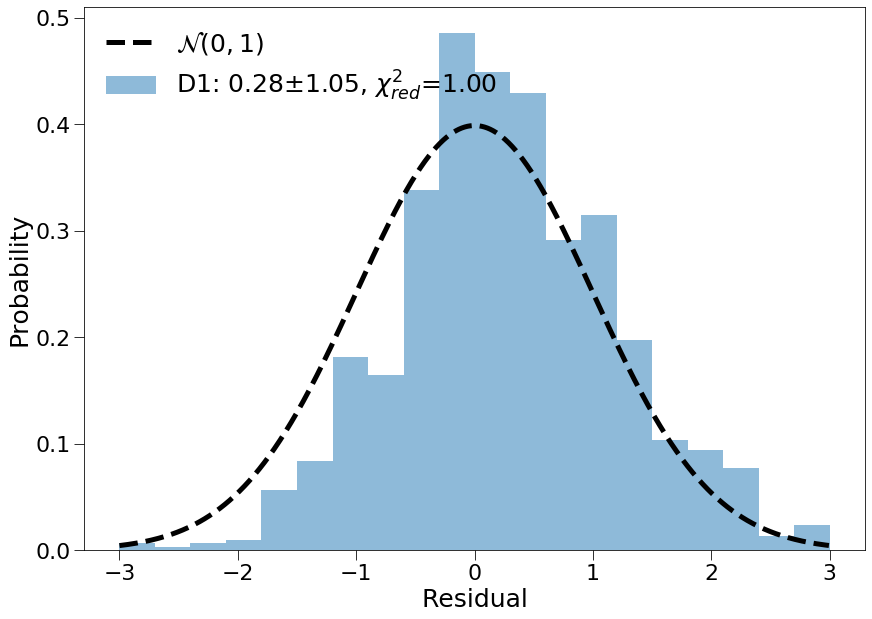

In [217]:
df = len(chi2_d1)-1
#print(df)
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))
bins=20
alpha=0.5
legendsize=25

ax1.hist(np.array(biases_d1).flatten(), alpha=alpha, bins=bins, 
         label=f'D1: {np.mean(biases_d1):.2f}$\pm${np.std(biases):.2f}, $\chi^2_{{{{red}}}}$={np.sum(chi2_d1)/df:.2f}', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d3).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D3, {np.mean(biases_d3):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d3)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d5).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D5, {np.mean(biases_d5):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d5)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')



x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Residual', fontsize=25)
ax1.set_ylabel('Probability', fontsize=25)

ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.plot(x, y, c='black', ls='--', lw=5, alpha=1, label=r'$\mathcal{N}(0, 1)$')
#ax1.set_title(f'GMM with {1} component; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

ax1.tick_params(axis='both', which='major', labelsize=22, size=10)
ax1.legend(fontsize=legendsize, frameon=False);

### Tests for bias

In [ ]:
# here

500 0.754


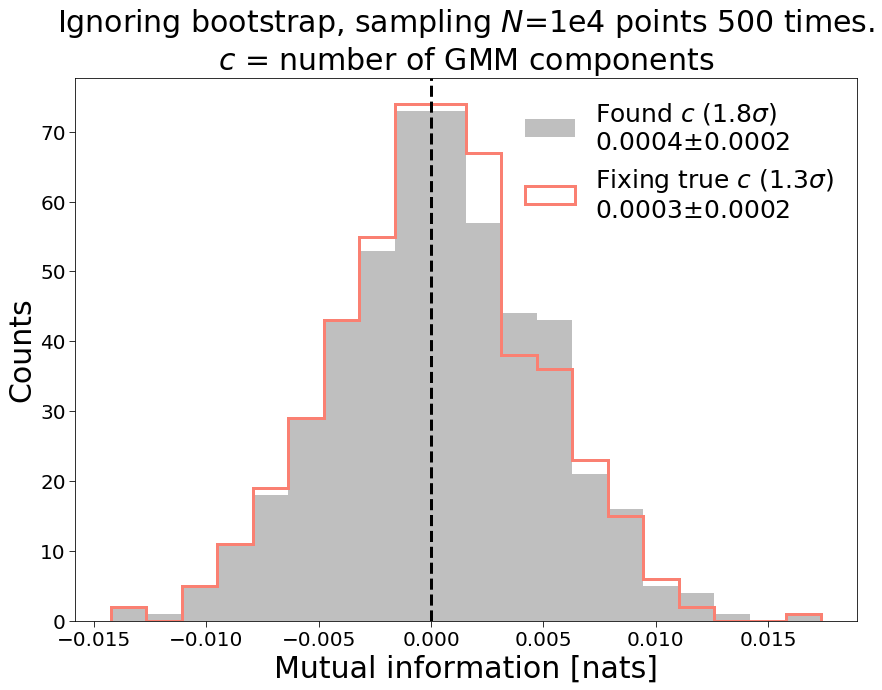

In [63]:
all_MI_estimates = np.load('./D3_bias_test_mean_MIs.npy')
bad_idx = np.load('./D3_bias_test_mean_idx.npy')
analytic = np.load('./mine-pytorch/mine/D3_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]
print(last_id, len(bad_idx)/last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

mmin = np.min(all_MI_estimates[:last_id]-analytic)
mmax = np.max(all_MI_estimates[:last_id]-analytic)

bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, 0].flatten()-analytic, alpha=alpha, bins=bins, 
         label=f'Found $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 0] - analytic)) / (np.std(all_MI_estimates[:last_id, 0]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, 0] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id, 0]-analytic)/np.sqrt(last_id):.4f}', color='grey', range=(mmin, mmax))

ax1.hist(all_MI_estimates[:last_id, 1].flatten()-analytic, alpha=1, bins=bins, 
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1] - analytic)) / (np.std(all_MI_estimates[:last_id, 1]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, 1] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id, 1]- analytic)/np.sqrt(last_id):.4f}', color='salmon', range=(mmin, mmax), histtype='step', lw=3)


ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper right')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('Ignoring bootstrap, sampling $N$=1e4 points 500 times.\n$c$ = number of GMM components', fontsize=30);

500 1.138


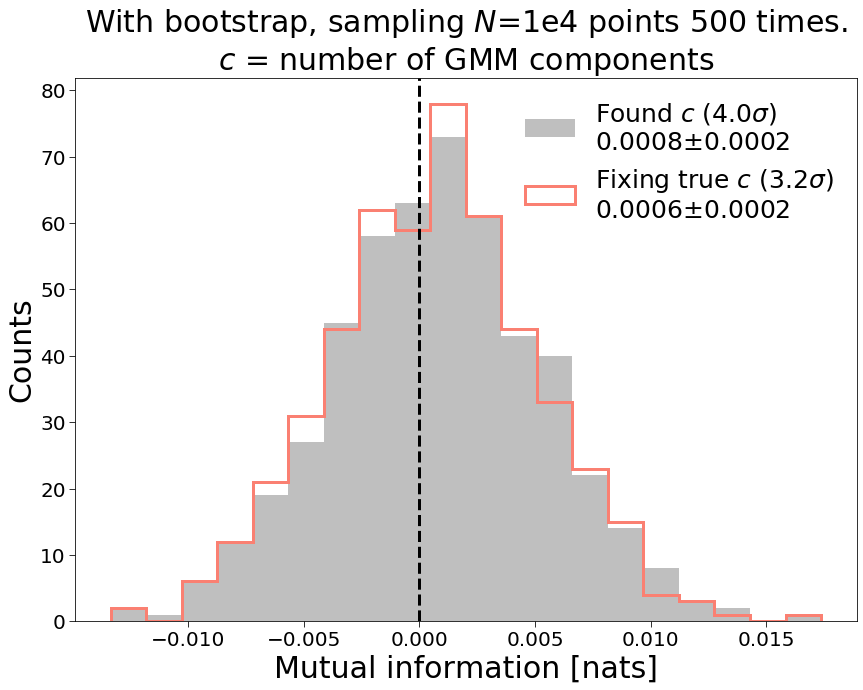

In [160]:
all_MI_estimates = np.load('./D3_bias_test_mean_MIs_bootstrap.npy')
bad_idx = np.load('./D3_bias_test_mean_idx_bootstrap.npy')
analytic = np.load('./mine-pytorch/mine/D3_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]
print(last_id, len(bad_idx)/last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

mmin = np.min(all_MI_estimates[:last_id]-analytic)
mmax = np.max(all_MI_estimates[:last_id]-analytic)

bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, 0].flatten()-analytic, alpha=alpha, bins=bins, 
         label=f'Found $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 0] - analytic)) / (np.std(all_MI_estimates[:last_id, 0]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, 0] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id, 0]-analytic)/np.sqrt(last_id):.4f}', color='grey', range=(mmin, mmax))

ax1.hist(all_MI_estimates[:last_id, 1].flatten()-analytic, alpha=1, bins=bins, 
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1] - analytic)) / (np.std(all_MI_estimates[:last_id, 1]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, 1] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id, 1]- analytic)/np.sqrt(last_id):.4f}', color='salmon', range=(mmin, mmax), histtype='step', lw=3)


ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper right')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('With bootstrap, sampling $N$=1e4 points 500 times.\n$c$ = number of GMM components', fontsize=30);

500


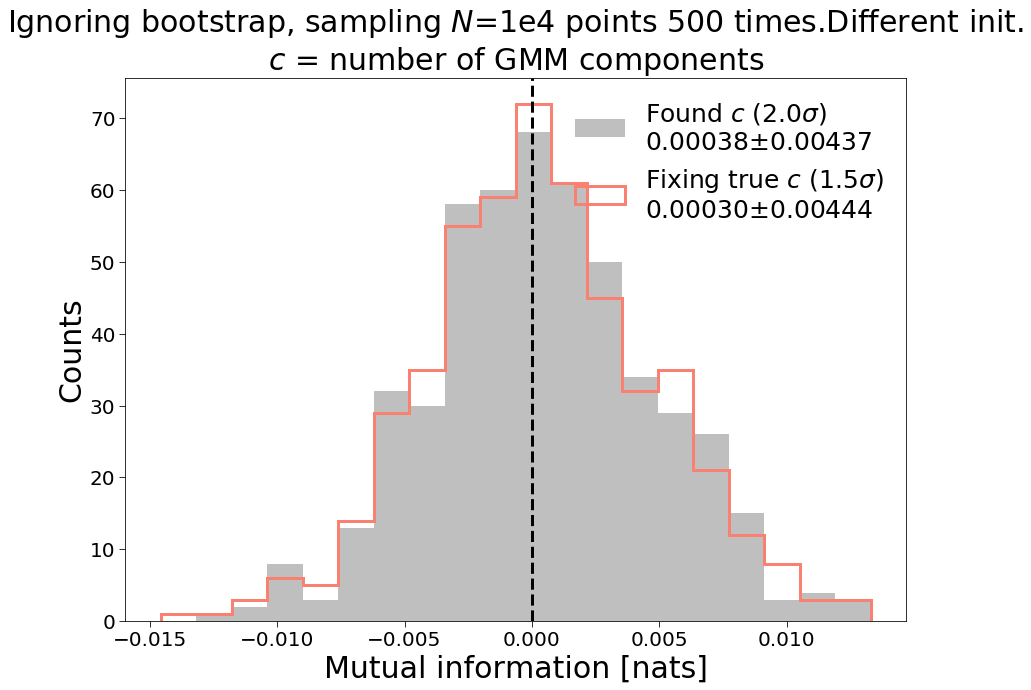

In [638]:
all_MI_estimates = np.load('./D3_bias_test_mean_MIs_diffinit.npy')
bad_idx = np.load('./D3_bias_test_mean_idx_diffinit.npy')
analytic = np.load('./mine-pytorch/mine/D3_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

mmin = np.min(all_MI_estimates[:last_id]-analytic)
mmax = np.max(all_MI_estimates[:last_id]-analytic)

bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, 0].flatten()-analytic, alpha=alpha, bins=bins, 
         label=f'Found $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 0] - analytic)) / (np.std(all_MI_estimates[:last_id, 0]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, 0] - analytic):.5f}$\pm${np.std(all_MI_estimates[:last_id, 0]-analytic):.5f}', color='grey', range=(mmin, mmax))

ax1.hist(all_MI_estimates[:last_id, 1].flatten()-analytic, alpha=1, bins=bins, 
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1] - analytic)) / (np.std(all_MI_estimates[:last_id, 1]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, 1] - analytic):.5f}$\pm${np.std(all_MI_estimates[:last_id, 1]- analytic):.5f}', color='salmon', range=(mmin, mmax), histtype='step', lw=3)


ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper right')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('Ignoring bootstrap, sampling $N$=1e4 points 500 times.Different init.\n$c$ = number of GMM components', fontsize=30);

500


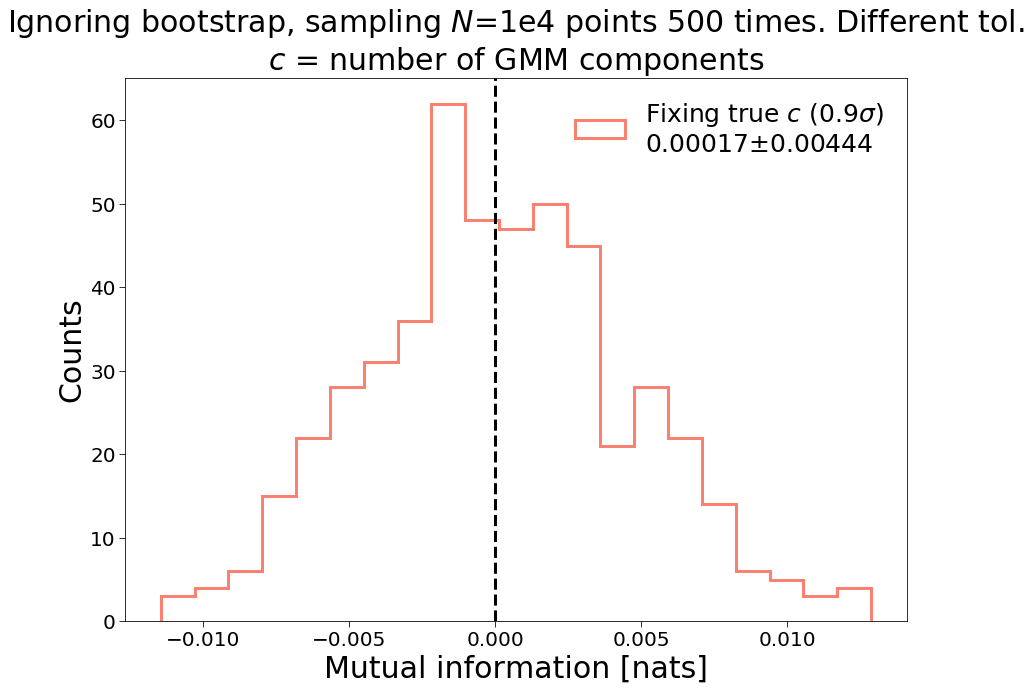

In [639]:
all_MI_estimates = np.load('./D3_bias_test_mean_MIs_difftol.npy')
#bad_idx = np.load('./D3_bias_test_mean_idx_diffinit.npy')
analytic = np.load('./mine-pytorch/mine/D3_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

mmin = np.min(all_MI_estimates[:last_id]-analytic)
mmax = np.max(all_MI_estimates[:last_id]-analytic)

bins=21
alpha=0.5
legendsize=25

#ax1.hist(all_MI_estimates[:last_id, 0].flatten()-analytic, alpha=alpha, bins=bins, 
#         label=f'Found $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 0] - analytic)) / (np.std(all_MI_estimates[:last_id, 0]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, 0] - analytic):.5f}$\pm${np.std(all_MI_estimates[:last_id, 0]-analytic):.5f}', color='grey', range=(mmin, mmax))

ax1.hist(all_MI_estimates[:last_id, 1].flatten()-analytic, alpha=1, bins=bins, 
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1] - analytic)) / (np.std(all_MI_estimates[:last_id, 1]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, 1] - analytic):.5f}$\pm${np.std(all_MI_estimates[:last_id, 1]- analytic):.5f}', color='salmon', range=(mmin, mmax), histtype='step', lw=3)


ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper right')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('Ignoring bootstrap, sampling $N$=1e4 points 500 times. Different tol.\n$c$ = number of GMM components', fontsize=30);

500


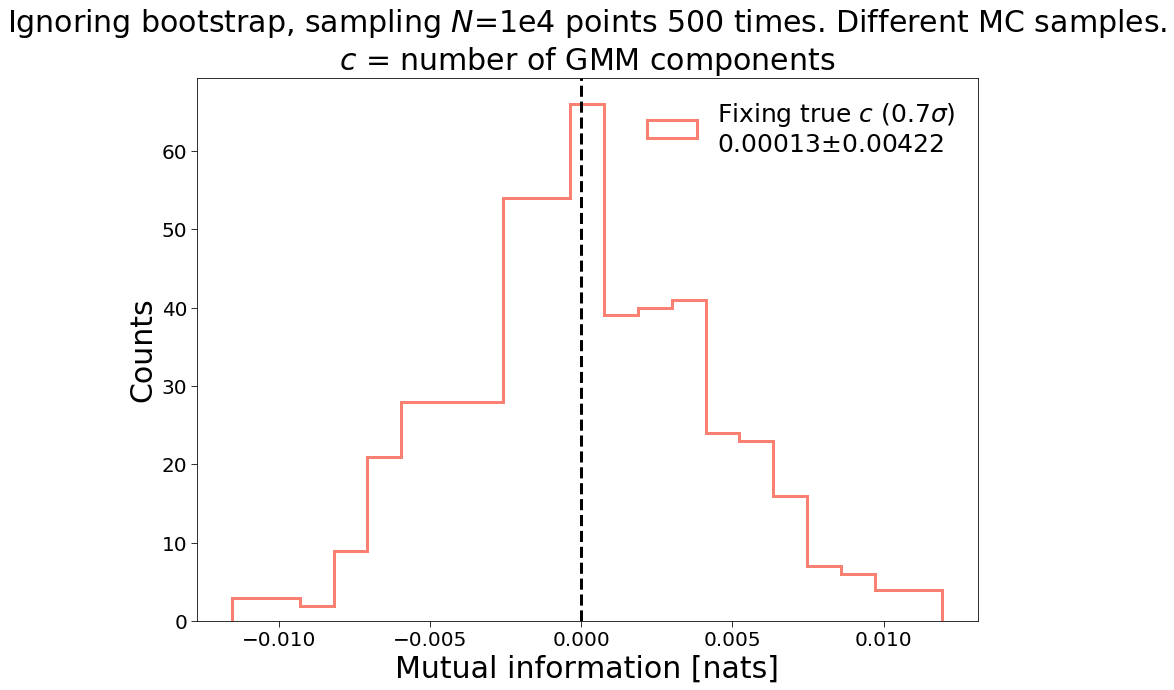

In [534]:
all_MI_estimates = np.load('./D3_bias_test_mean_MIs_diffMCsamples.npy')
#bad_idx = np.load('./D3_bias_test_mean_idx_diffinit.npy')
analytic = np.load('./mine-pytorch/mine/D3_analytic.npy')

last_id = 500#np.minimum(np.where(all_MI_estimates == 0)[0][0], 500)
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

mmin = np.min(all_MI_estimates[:last_id]-analytic)
mmax = np.max(all_MI_estimates[:last_id]-analytic)

bins=21
alpha=0.5
legendsize=25

#ax1.hist(all_MI_estimates[:last_id, 0].flatten()-analytic, alpha=alpha, bins=bins, 
#         label=f'Found $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 0] - analytic)) / (np.std(all_MI_estimates[:last_id, 0]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, 0] - analytic):.5f}$\pm${np.std(all_MI_estimates[:last_id, 0]-analytic):.5f}', color='grey', range=(mmin, mmax))

ax1.hist(all_MI_estimates[:last_id, 1].flatten()-analytic, alpha=1, bins=bins, 
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1] - analytic)) / (np.std(all_MI_estimates[:last_id, 1]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, 1] - analytic):.5f}$\pm${np.std(all_MI_estimates[:last_id, 1]- analytic):.5f}', color='salmon', range=(mmin, mmax), histtype='step', lw=3)


ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper right')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('Ignoring bootstrap, sampling $N$=1e4 points 500 times. Different MC samples.\n$c$ = number of GMM components', fontsize=30);

500


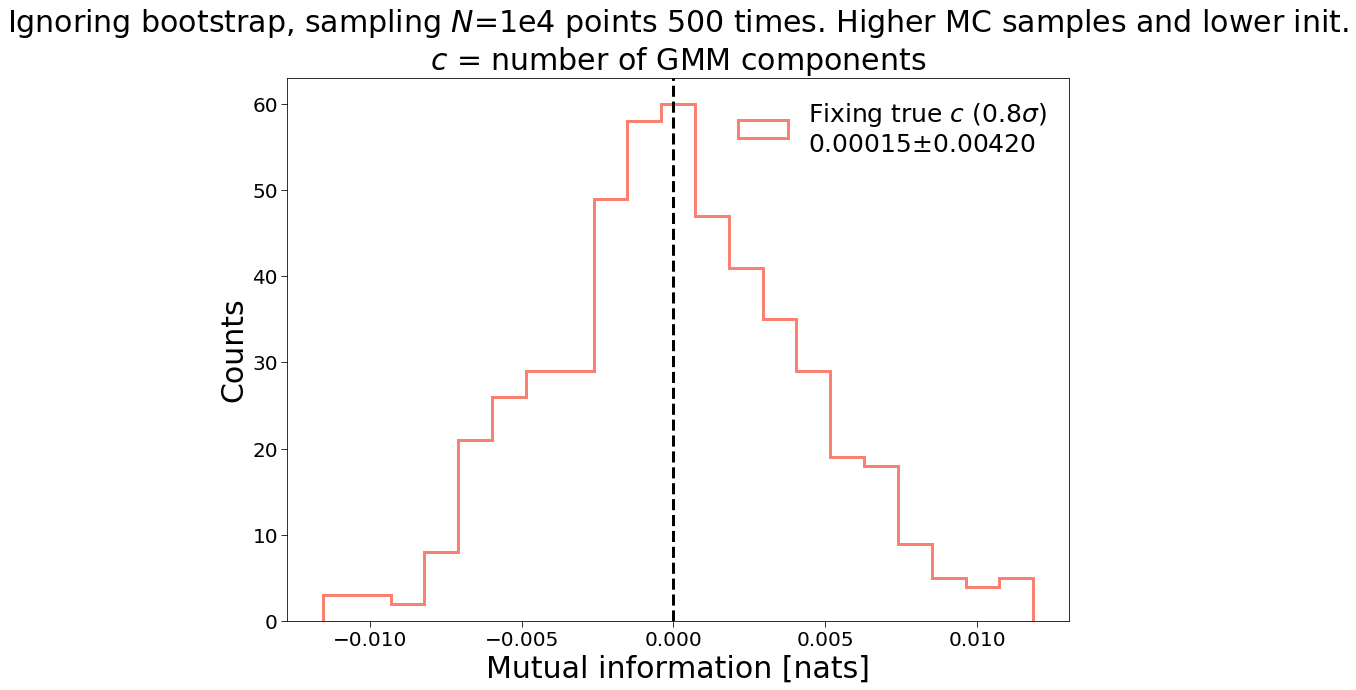

In [601]:
all_MI_estimates = np.load('./D3_bias_test_mean_MIs_difftol_diffMC.npy')
#bad_idx = np.load('./D3_bias_test_mean_idx_diffinit.npy')
analytic = np.load('./mine-pytorch/mine/D3_analytic.npy')

last_id = 500#np.minimum(np.where(all_MI_estimates == 0)[0][0], 500)
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

mmin = np.min(all_MI_estimates[:last_id]-analytic)
mmax = np.max(all_MI_estimates[:last_id]-analytic)

bins=21
alpha=0.5
legendsize=25

#ax1.hist(all_MI_estimates[:last_id, 0].flatten()-analytic, alpha=alpha, bins=bins, 
#         label=f'Found $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 0] - analytic)) / (np.std(all_MI_estimates[:last_id, 0]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, 0] - analytic):.5f}$\pm${np.std(all_MI_estimates[:last_id, 0]-analytic):.5f}', color='grey', range=(mmin, mmax))

ax1.hist(all_MI_estimates[:last_id, 1].flatten()-analytic, alpha=1, bins=bins, 
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1] - analytic)) / (np.std(all_MI_estimates[:last_id, 1]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, 1] - analytic):.5f}$\pm${np.std(all_MI_estimates[:last_id, 1]- analytic):.5f}', color='salmon', range=(mmin, mmax), histtype='step', lw=3)


ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper right')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('Ignoring bootstrap, sampling $N$=1e4 points 500 times. Higher MC samples and lower init.\n$c$ = number of GMM components', fontsize=30);

500 1.344
0.1552343562326235


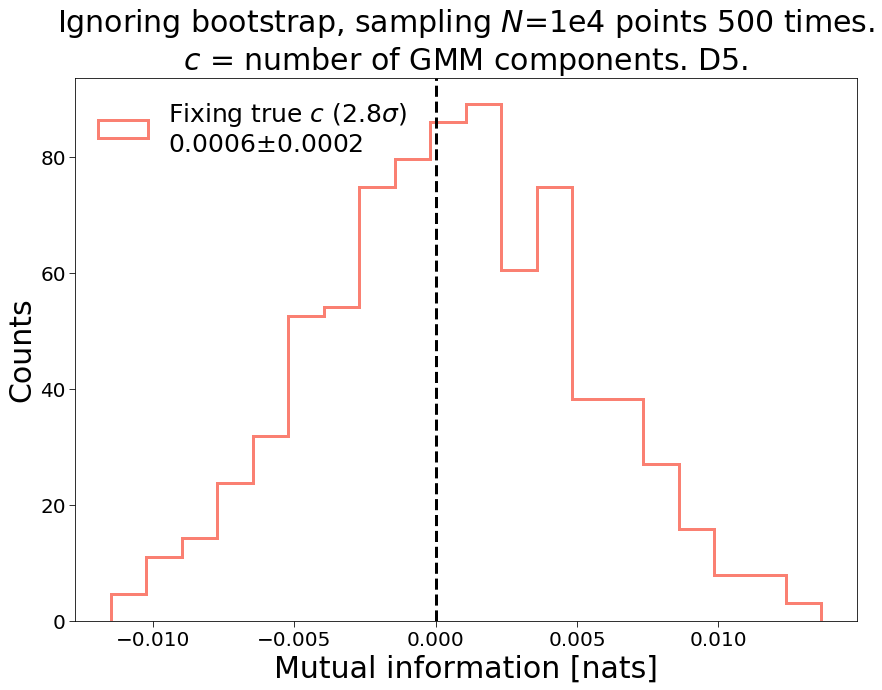

In [247]:
all_MI_estimates = np.load('./D5_bias_test_mean_MIs.npy')
bad_idx = np.load('./D5_bias_test_mean_idx.npy')
analytic = np.load('./mine-pytorch/mine/D5_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]
print(last_id, len(bad_idx)/last_id)

# there was a problem here, but we can ignore it since we fixed the number of components there
all_MI_estimates[95, 1] = analytic

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

mmin = np.min(all_MI_estimates[:last_id]-analytic)
mmax = np.max(all_MI_estimates[:last_id]-analytic)

print(np.min(all_MI_estimates[:last_id]))


bins=20
alpha=0.5
legendsize=25

#ax1.hist(all_MI_estimates[:last_id, 0].flatten()-analytic, alpha=alpha, bins=bins, 
#         label=f'Found $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 0] - analytic)) / (np.std(all_MI_estimates[:last_id, 0]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, 0] - analytic):.5f}$\pm${np.std(all_MI_estimates[:last_id, 0]-analytic):.5f}', color='grey', range=(mmin, mmax))

ax1.hist(all_MI_estimates[:last_id, 1].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1] - analytic)) / (np.std(all_MI_estimates[:last_id, 1]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, 1] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id, 1]- analytic)/np.sqrt(last_id):.4f}', color='salmon', histtype='step', lw=3)


x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('Ignoring bootstrap, sampling $N$=1e4 points 500 times.\n$c$ = number of GMM components. D5.', fontsize=30);

25 15.04
0.17259889039759674
0.19046452329926988


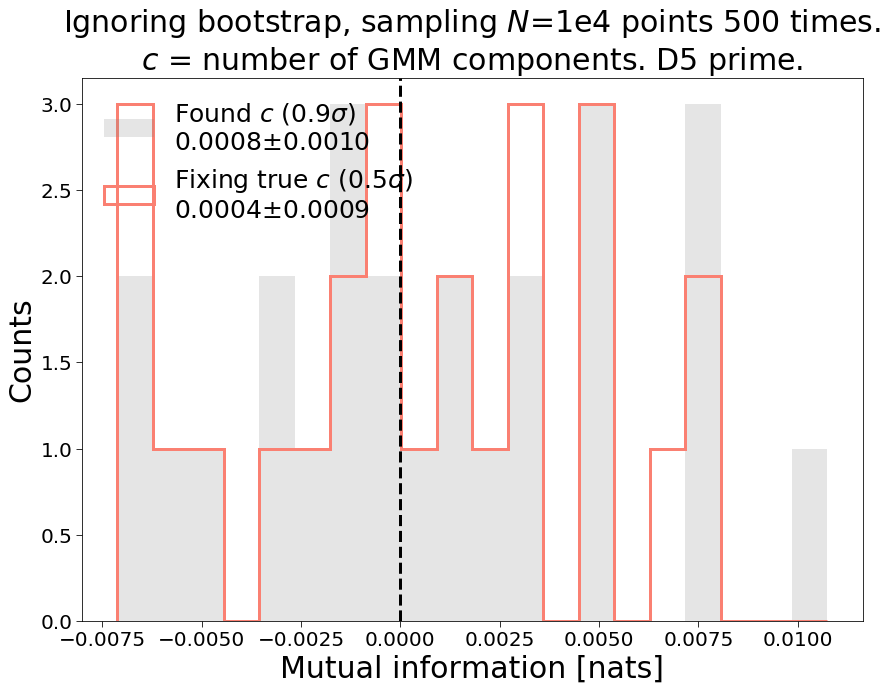

In [58]:
all_MI_estimates = np.load('./D5p_bias_test_mean_MIs.npy')
bad_idx = np.load('./D5p_bias_test_mean_idx.npy')
analytic = 0.17972193484434484

last_id = 500#np.where(all_MI_estimates == 0)[0][0]
print(last_id, len(bad_idx)/last_id)

# there was a problem here, but we can ignore it since we fixed the number of components there
#all_MI_estimates[95, 1] = analytic

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

mmin = np.min(all_MI_estimates[:last_id]-analytic)
mmax = np.max(all_MI_estimates[:last_id]-analytic)

print(np.min(all_MI_estimates[:last_id]))
print(np.max(all_MI_estimates[:last_id]))


bins=20
alpha=0.2
legendsize=25

ax1.hist(all_MI_estimates[:last_id, 0].flatten()-analytic, alpha=alpha, bins=bins, 
         label=f'Found $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 0] - analytic)) / (np.std(all_MI_estimates[:last_id, 0]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, 0] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id, 0]-analytic)/np.sqrt(last_id):.4f}', color='grey', range=(mmin, mmax))

ax1.hist(all_MI_estimates[:last_id, 1].flatten()-analytic, alpha=1, bins=bins, 
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1] - analytic)) / (np.std(all_MI_estimates[:last_id, 1]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, 1] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id, 1]- analytic)/np.sqrt(last_id):.4f}',  range=(mmin, mmax), color='salmon', histtype='step', lw=3)


x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('Ignoring bootstrap, sampling $N$=1e4 points 500 times.\n$c$ = number of GMM components. D5 prime.', fontsize=30);

484 0.6962809917355371


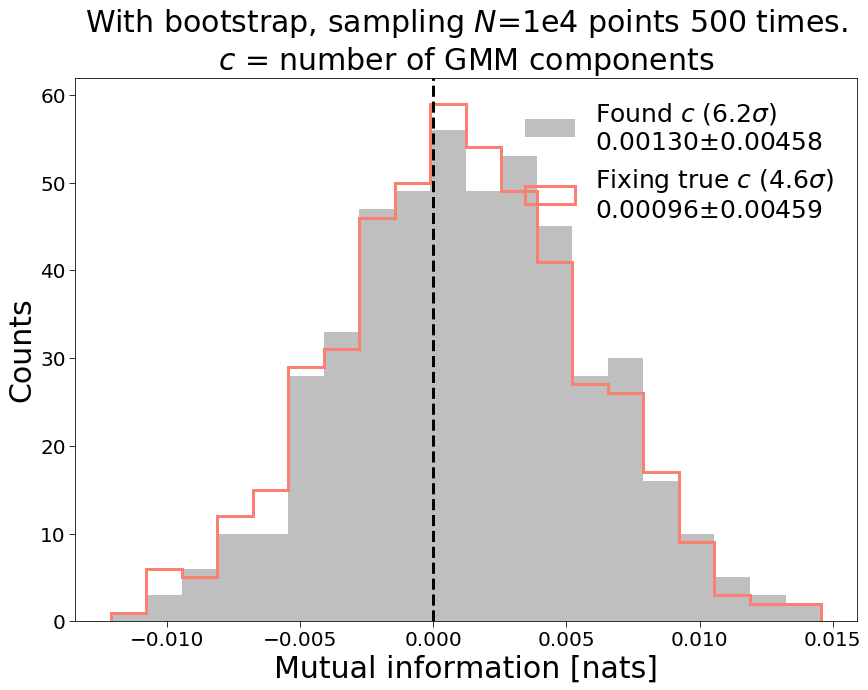

In [130]:
all_MI_estimates = np.load('./D5p_bias_test_mean_MIs_bootstrap.npy')
bad_idx = np.load('./D5_bias_test_mean_idx_bootstrap.npy')
analytic = np.load('./mine-pytorch/mine/D5_analytic.npy')

last_id = np.where(all_MI_estimates == 0)[0][0]
print(last_id, len(bad_idx)/last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

mmin = np.min(all_MI_estimates[:last_id]-analytic)
mmax = np.max(all_MI_estimates[:last_id]-analytic)

bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, 0].flatten()-analytic, alpha=alpha, bins=bins, 
         label=f'Found $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 0] - analytic)) / (np.std(all_MI_estimates[:last_id, 0]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, 0] - analytic):.5f}$\pm${np.std(all_MI_estimates[:last_id, 0]-analytic):.5f}', color='grey', range=(mmin, mmax))

ax1.hist(all_MI_estimates[:last_id, 1].flatten()-analytic, alpha=1, bins=bins, 
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1] - analytic)) / (np.std(all_MI_estimates[:last_id, 1]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, 1] - analytic):.5f}$\pm${np.std(all_MI_estimates[:last_id, 1]- analytic):.5f}', color='salmon', range=(mmin, mmax), histtype='step', lw=3)


ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper right')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('With bootstrap, sampling $N$=1e4 points 500 times.\n$c$ = number of GMM components', fontsize=30);

### Ignore covariance regularization

500
0.1181330866936064


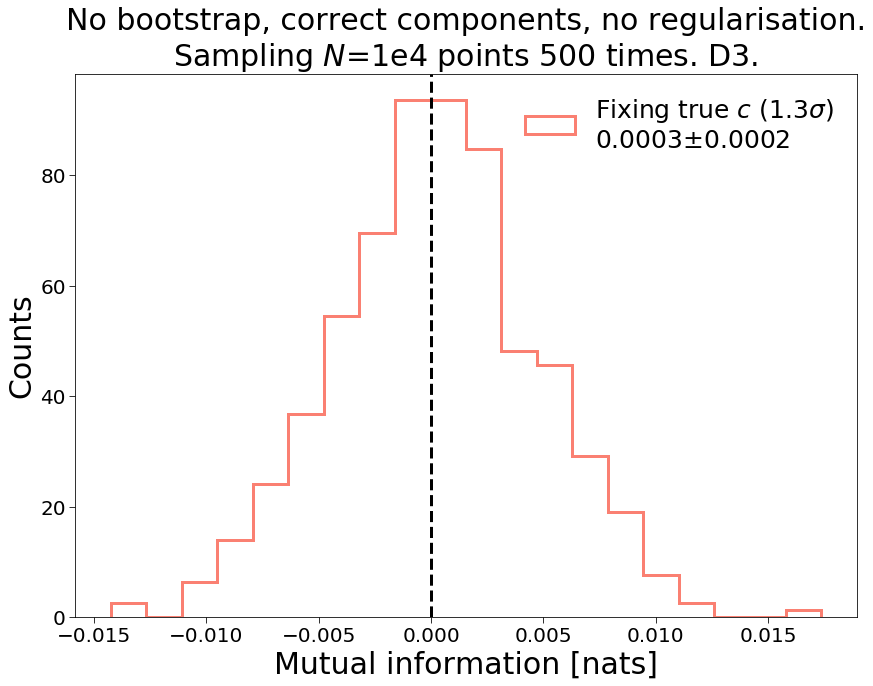

In [54]:
all_MI_estimates = np.load('./D3_bias_test_MI_regcovar0.npy')
analytic = np.load('./mine-pytorch/mine/D3_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]
print(last_id)


fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

mmin = np.min(all_MI_estimates[:last_id]-analytic)
mmax = np.max(all_MI_estimates[:last_id]-analytic)

print(np.min(all_MI_estimates[:last_id]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id] - analytic)) / (np.std(all_MI_estimates[:last_id]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id]- analytic)/np.sqrt(last_id):.4f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper right')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('No bootstrap, correct components, no regularisation.\nSampling $N$=1e4 points 500 times. D3.', fontsize=30);

500
473


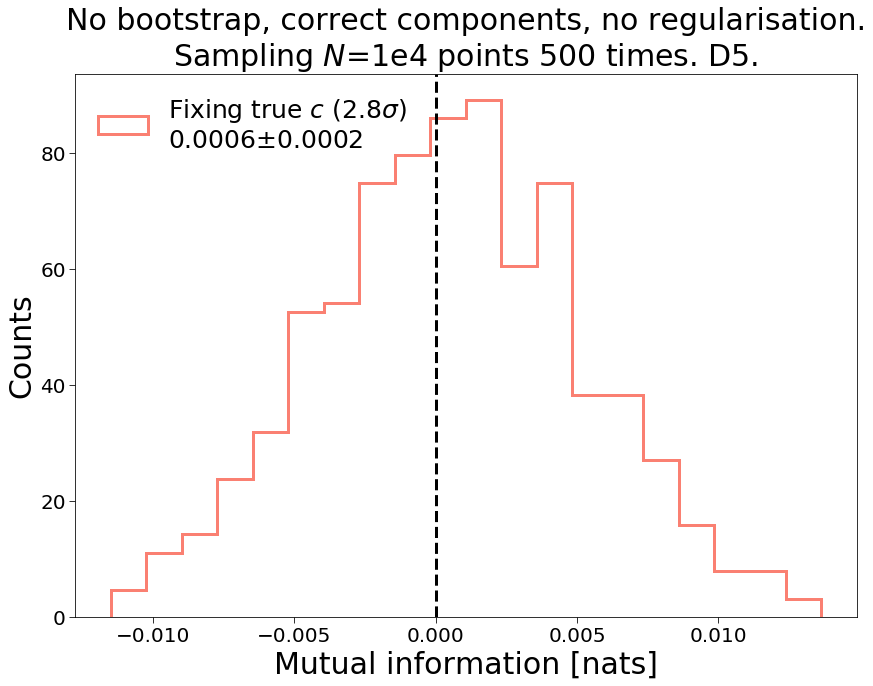

In [80]:
all_MI_estimates = np.load('./D5_bias_test_MI_regcovar0.npy')
analytic = np.load('./mine-pytorch/mine/D5_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]
print(last_id)

#there was a problem here, but we can ignore it since we fixed the number of components there
all_MI_estimates[95] = analytic

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

mmin = np.min(all_MI_estimates[:last_id]-analytic)
mmax = np.max(all_MI_estimates[:last_id]-analytic)

print(np.argmin(all_MI_estimates[:last_id]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id] - analytic)) / (np.std(all_MI_estimates[:last_id]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id]- analytic)/np.sqrt(last_id):.4f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('No bootstrap, correct components, no regularisation.\nSampling $N$=1e4 points 500 times. D5.', fontsize=30);

500
0.16706261874730954


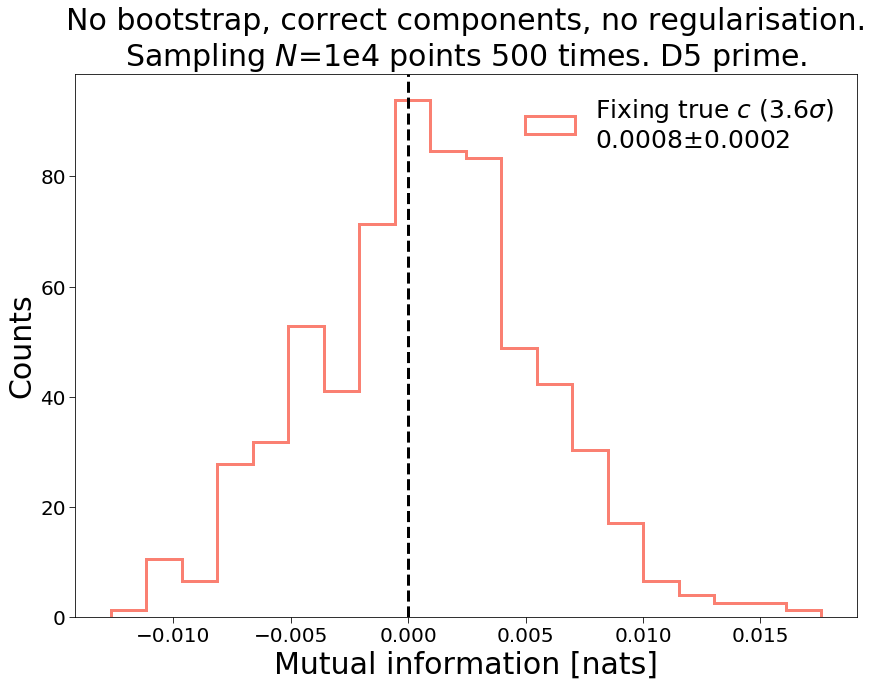

In [81]:
all_MI_estimates = np.load('./D5p_bias_test_MI_regcovar0.npy')
analytic = 0.17972193484434484

last_id = 500#np.where(all_MI_estimates == 0)[0][0]
print(last_id)


fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

mmin = np.min(all_MI_estimates[:last_id]-analytic)
mmax = np.max(all_MI_estimates[:last_id]-analytic)

print(np.min(all_MI_estimates[:last_id]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id] - analytic)) / (np.std(all_MI_estimates[:last_id]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id]- analytic)/np.sqrt(last_id):.4f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper right')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('No bootstrap, correct components, no regularisation.\nSampling $N$=1e4 points 500 times. D5 prime.', fontsize=30);

### New D3

500
0.37292283988864283
0.4055880464511461


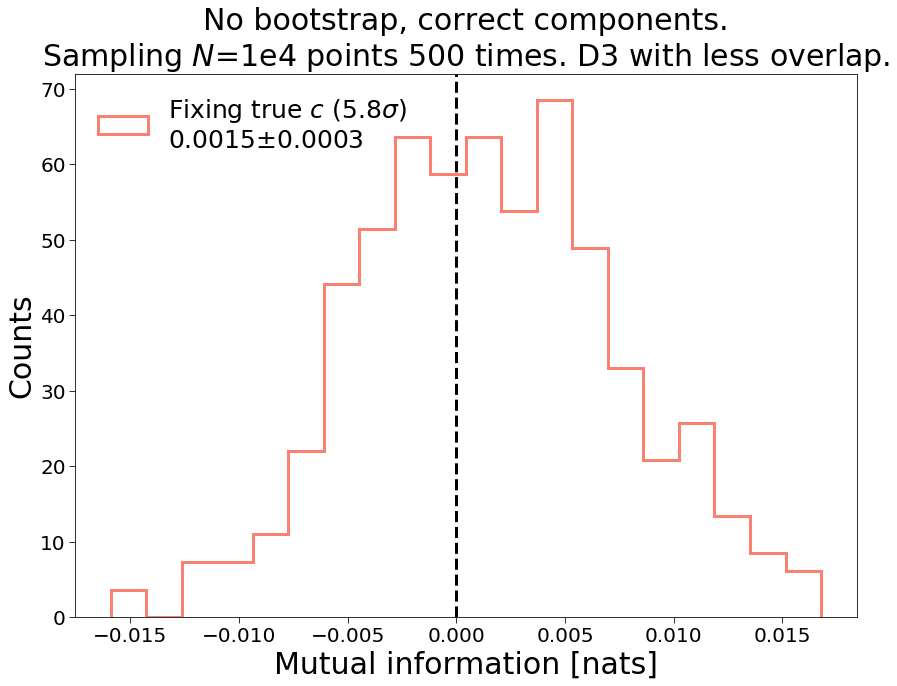

In [80]:
all_MI_estimates = np.load('./D3p_bias_test_MI.npy')
analytic = 0.38881453368446306#0.07682792465247745
#np.load('./mine-pytorch/mine/D3_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

#all_MI_estimates[77] = analytic

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

mmin = np.min(all_MI_estimates[:last_id]-analytic)
mmax = np.max(all_MI_estimates[:last_id]-analytic)

print(np.min(all_MI_estimates[:last_id]))
print(np.max(all_MI_estimates[:last_id]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id] - analytic)) / (np.std(all_MI_estimates[:last_id]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id]- analytic)/np.sqrt(last_id):.4f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('No bootstrap, correct components.\nSampling $N$=1e4 points 500 times. D3 with less overlap.', fontsize=30);

500
0.3758976821454492
0.4055254440655586


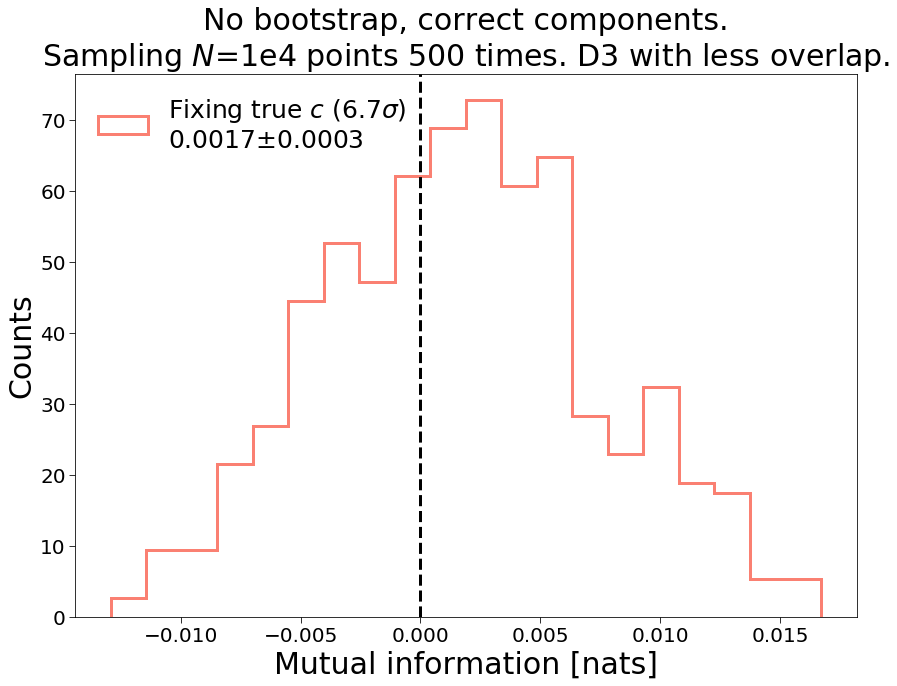

In [89]:
all_MI_estimates = np.load('./D3p_bias_test_MI_initfromCV.npy')
analytic = 0.38881453368446306#0.07682792465247745
#np.load('./mine-pytorch/mine/D3_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

#all_MI_estimates[77] = analytic

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

mmin = np.min(all_MI_estimates[:last_id]-analytic)
mmax = np.max(all_MI_estimates[:last_id]-analytic)

print(np.min(all_MI_estimates[:last_id]))
print(np.max(all_MI_estimates[:last_id]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id] - analytic)) / (np.std(all_MI_estimates[:last_id]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id]- analytic)/np.sqrt(last_id):.4f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('No bootstrap, correct components.\nSampling $N$=1e4 points 500 times. D3 with less overlap.', fontsize=30);

500
0.37452496472890995
0.4036770864831638


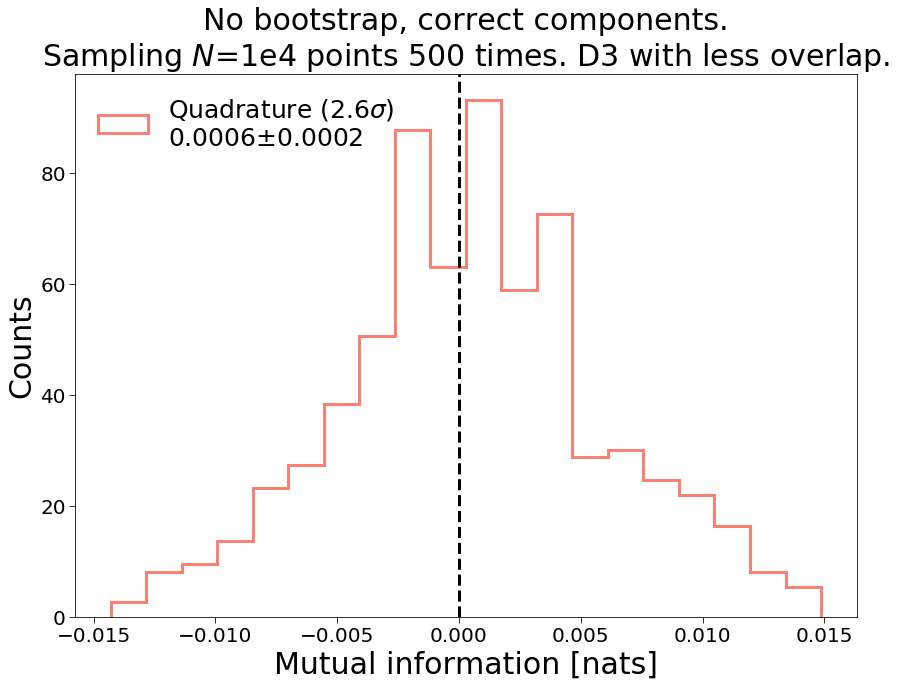

In [98]:
all_MI_estimates = np.load('./D3p_bias_test_MI_initfromCV_exact.npy')
analytic = 0.38881453368446306#0.07682792465247745
#np.load('./mine-pytorch/mine/D3_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

#all_MI_estimates[77] = analytic

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

mmin = np.min(all_MI_estimates[:last_id]-analytic)
mmax = np.max(all_MI_estimates[:last_id]-analytic)

print(np.min(all_MI_estimates[:last_id]))
print(np.max(all_MI_estimates[:last_id]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Quadrature ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id] - analytic)) / (np.std(all_MI_estimates[:last_id]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id]- analytic)/np.sqrt(last_id):.4f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('No bootstrap, correct components.\nSampling $N$=1e4 points 500 times. D3 with less overlap.', fontsize=30);

500
0.1207736993423183
0.14427931903065327


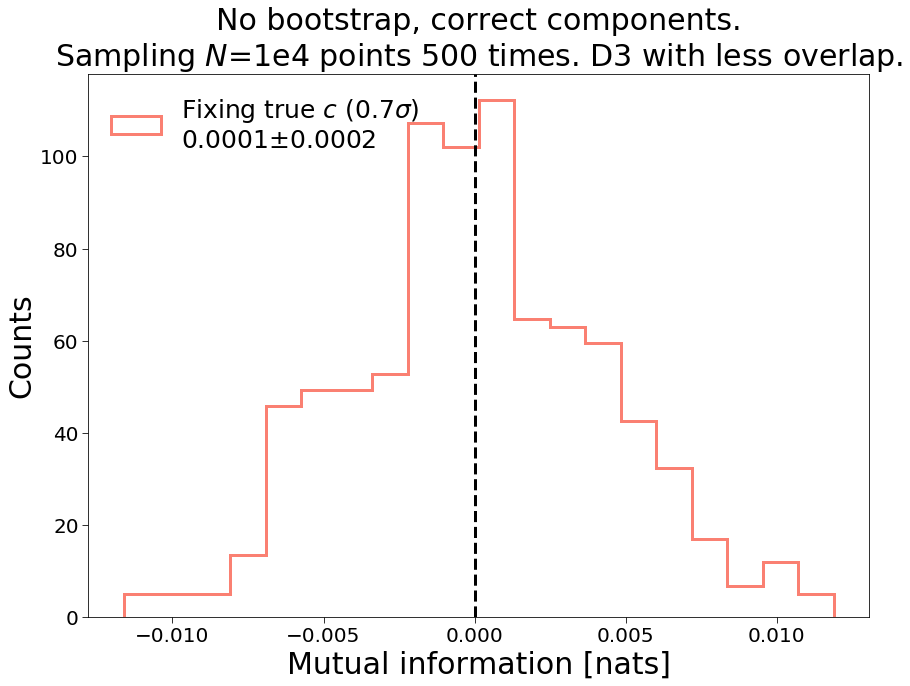

In [100]:
all_MI_estimates = np.load('./D3_bias_test_MI_initfromCV_exact.npy')
analytic = np.load('./mine-pytorch/mine/D3_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

#all_MI_estimates[77] = analytic

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

mmin = np.min(all_MI_estimates[:last_id]-analytic)
mmax = np.max(all_MI_estimates[:last_id]-analytic)

print(np.min(all_MI_estimates[:last_id]))
print(np.max(all_MI_estimates[:last_id]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id] - analytic)) / (np.std(all_MI_estimates[:last_id]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id]- analytic)/np.sqrt(last_id):.4f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('No bootstrap, correct components.\nSampling $N$=1e4 points 500 times. D3 with less overlap.', fontsize=30);

500
0.1184364430270921
0.1496778058225059


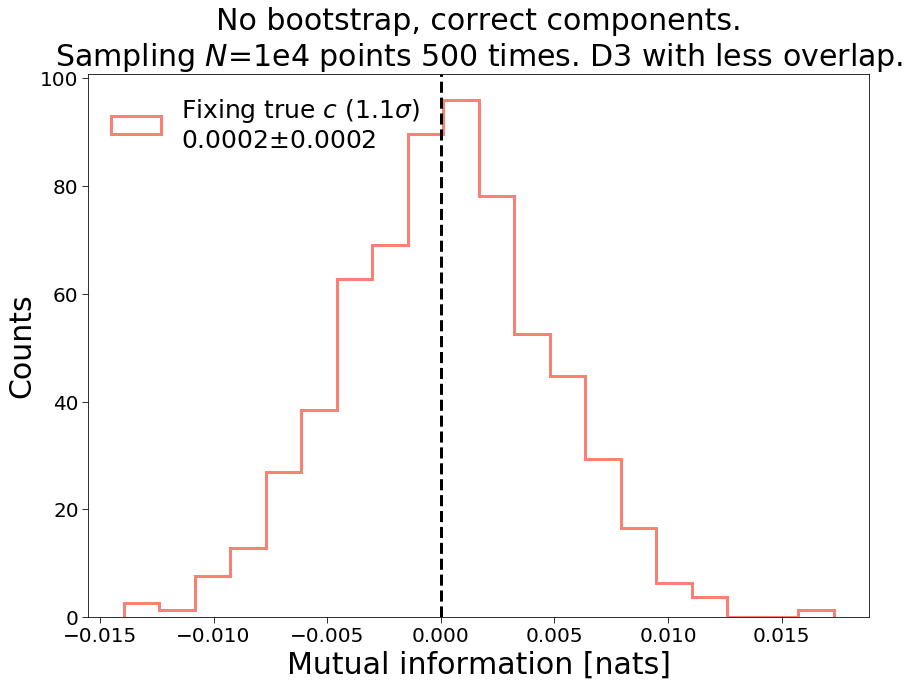

In [6]:
all_MI_estimates = np.load('./D3_bias_test_MI_initfromCV_MC.npy')
analytic = np.load('./mine-pytorch/mine/D3_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

#all_MI_estimates[77] = analytic

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

mmin = np.min(all_MI_estimates[:last_id]-analytic)
mmax = np.max(all_MI_estimates[:last_id]-analytic)

print(np.min(all_MI_estimates[:last_id]))
print(np.max(all_MI_estimates[:last_id]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id] - analytic)) / (np.std(all_MI_estimates[:last_id]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id]- analytic)/np.sqrt(last_id):.4f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('No bootstrap, correct components.\nSampling $N$=1e4 points 500 times. D3 with less overlap.', fontsize=30);

500
0.11813308669360358
0.14974489757421708


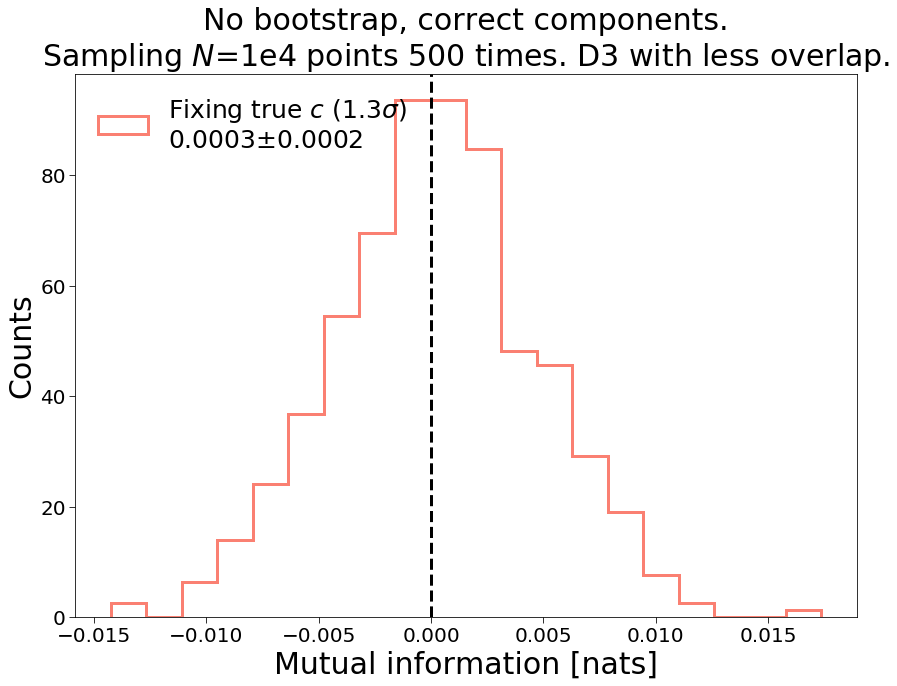

In [86]:
all_MI_estimates = np.load('./D3_bias_test_MI_initfrominit_MC.npy')
analytic = np.load('./mine-pytorch/mine/D3_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

#all_MI_estimates[77] = analytic

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

mmin = np.min(all_MI_estimates[:last_id]-analytic)
mmax = np.max(all_MI_estimates[:last_id]-analytic)

print(np.min(all_MI_estimates[:last_id]))
print(np.max(all_MI_estimates[:last_id]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id] - analytic)) / (np.std(all_MI_estimates[:last_id]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id]- analytic)/np.sqrt(last_id):.4f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('No bootstrap, correct components.\nSampling $N$=1e4 points 500 times. D3 with less overlap.', fontsize=30);

500
0.15605365929275175
0.18139734445324548


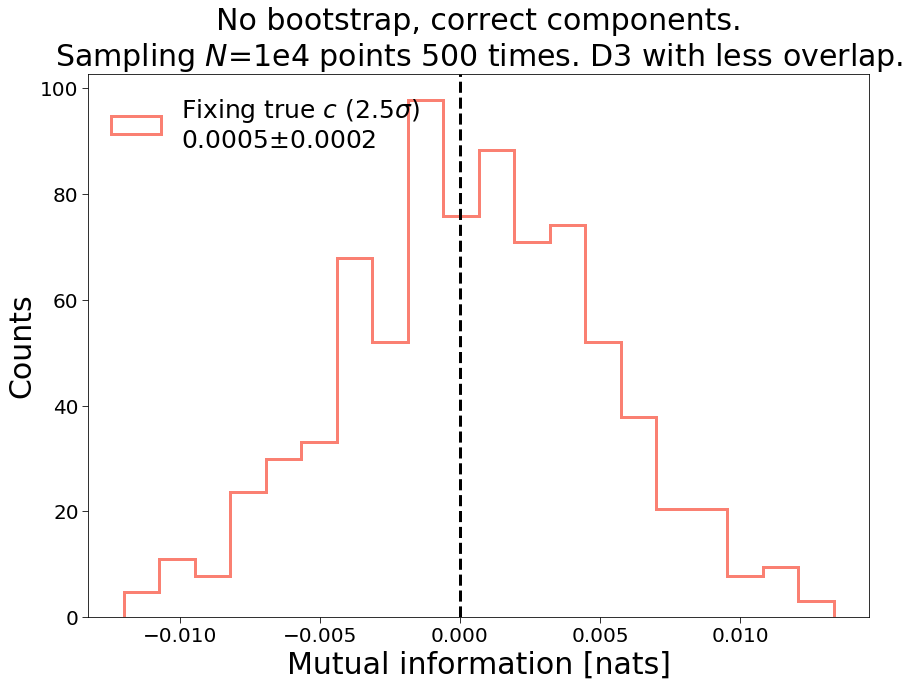

In [89]:
all_MI_estimates = np.load('./D5_bias_test_MI_initfromCV_MC.npy')
analytic = np.load('./mine-pytorch/mine/D5_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

#all_MI_estimates[77] = analytic

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

mmin = np.min(all_MI_estimates[:last_id]-analytic)
mmax = np.max(all_MI_estimates[:last_id]-analytic)

print(np.min(all_MI_estimates[:last_id]))
print(np.max(all_MI_estimates[:last_id]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id] - analytic)) / (np.std(all_MI_estimates[:last_id]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id]- analytic)/np.sqrt(last_id):.4f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('No bootstrap, correct components.\nSampling $N$=1e4 points 500 times. D3 with less overlap.', fontsize=30);

500
0.1574901321439559
0.18091579298876637


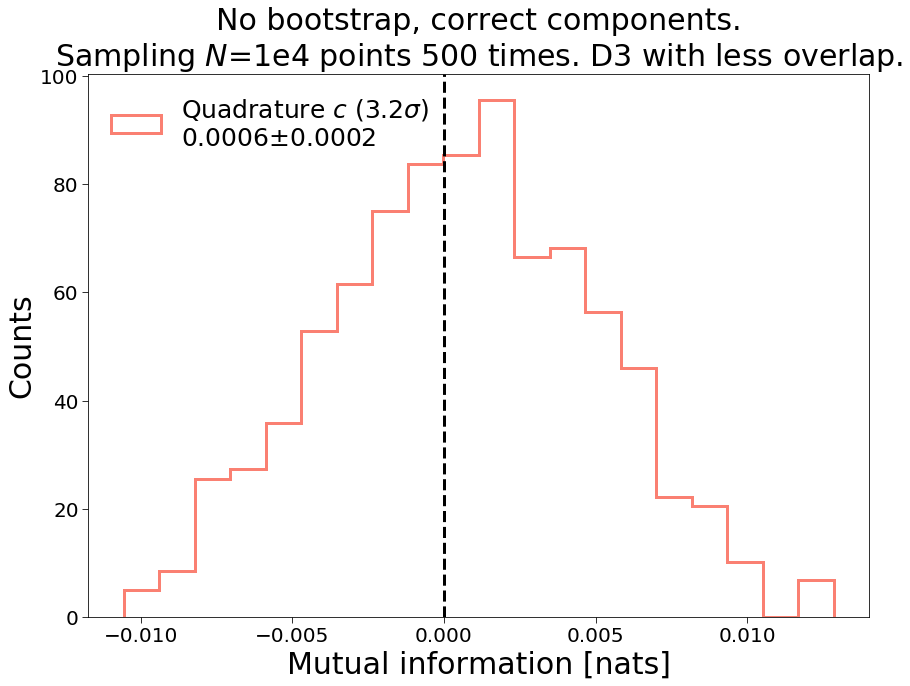

In [97]:
all_MI_estimates = np.load('./D5_bias_test_MI_initfromCV_exact.npy')
analytic = np.load('./mine-pytorch/mine/D5_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

#all_MI_estimates[77] = analytic

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

mmin = np.min(all_MI_estimates[:last_id]-analytic)
mmax = np.max(all_MI_estimates[:last_id]-analytic)

print(np.min(all_MI_estimates[:last_id]))
print(np.max(all_MI_estimates[:last_id]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Quadrature $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id] - analytic)) / (np.std(all_MI_estimates[:last_id]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id]- analytic)/np.sqrt(last_id):.4f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('No bootstrap, correct components.\nSampling $N$=1e4 points 500 times. D3 with less overlap.', fontsize=30);

500
0.16716271813236785
0.19688167721815292


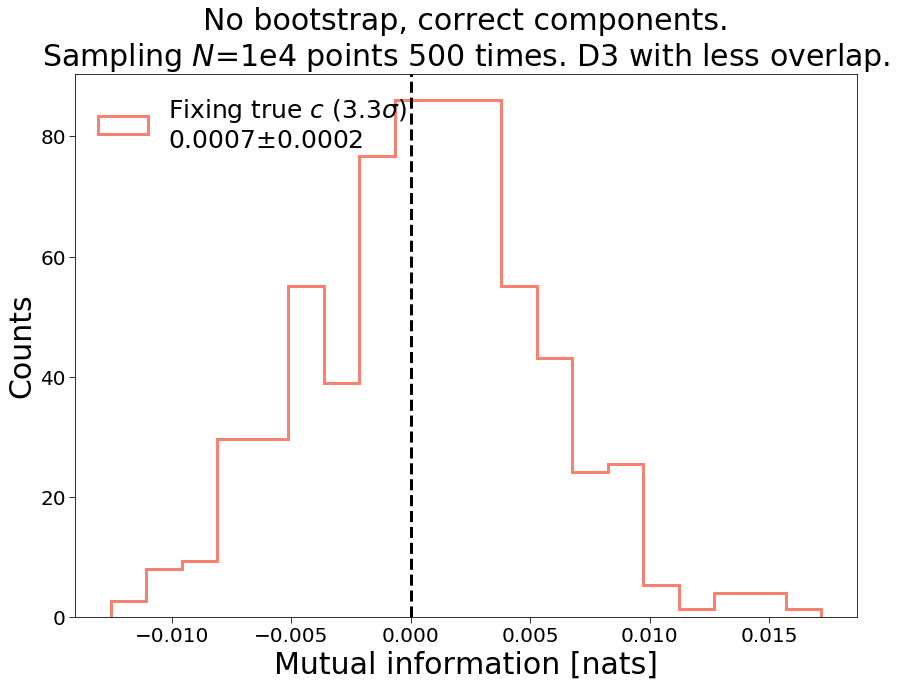

In [92]:
all_MI_estimates = np.load('./D5p_bias_test_MI_initfromCV_MC.npy')
analytic = 0.17972193484434484

last_id = 500#np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

#all_MI_estimates[77] = analytic

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

mmin = np.min(all_MI_estimates[:last_id]-analytic)
mmax = np.max(all_MI_estimates[:last_id]-analytic)

print(np.min(all_MI_estimates[:last_id]))
print(np.max(all_MI_estimates[:last_id]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id] - analytic)) / (np.std(all_MI_estimates[:last_id]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id]- analytic)/np.sqrt(last_id):.4f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('No bootstrap, correct components.\nSampling $N$=1e4 points 500 times. D3 with less overlap.', fontsize=30);

500
0.16788997594201738
0.1933679841573459


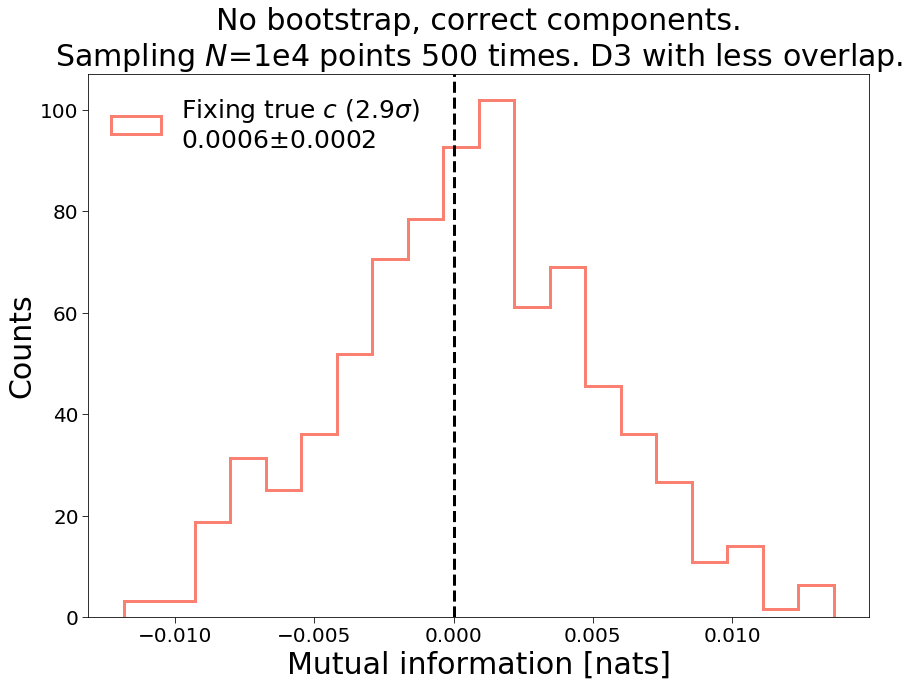

In [93]:
all_MI_estimates = np.load('./D5p_bias_test_MI_initfromCV_exact.npy')
analytic = 0.17972193484434484

last_id = 500#np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

#all_MI_estimates[77] = analytic

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

mmin = np.min(all_MI_estimates[:last_id]-analytic)
mmax = np.max(all_MI_estimates[:last_id]-analytic)

print(np.min(all_MI_estimates[:last_id]))
print(np.max(all_MI_estimates[:last_id]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id] - analytic)) / (np.std(all_MI_estimates[:last_id]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id]- analytic)/np.sqrt(last_id):.4f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('No bootstrap, correct components.\nSampling $N$=1e4 points 500 times. D3 with less overlap.', fontsize=30);

500
0.1184364430270921
0.1496778058225059


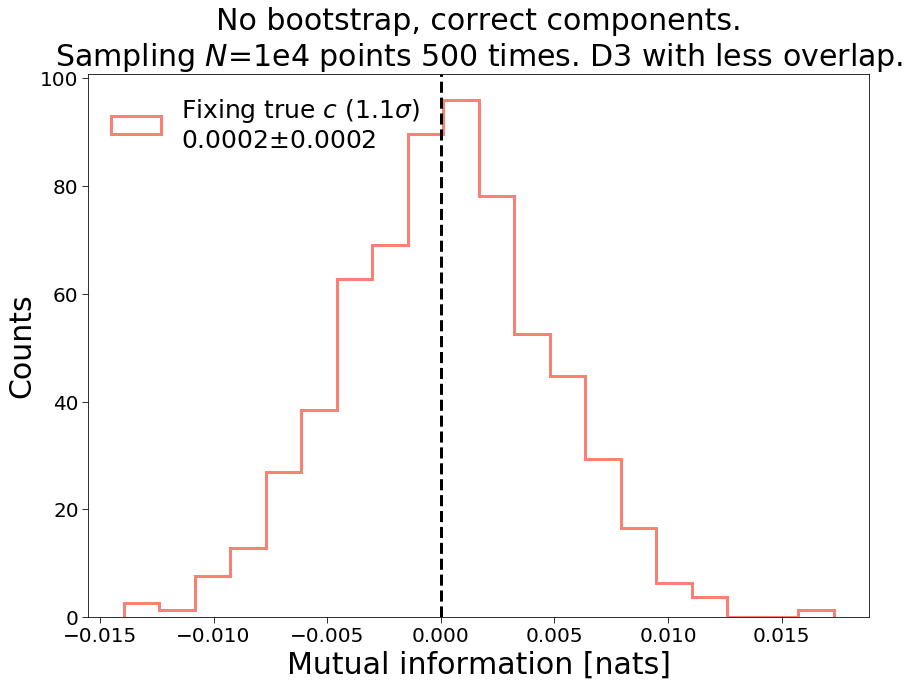

In [77]:
all_MI_estimates = np.load('./D3_bias_test_MI_initfromCV_diffseed.npy')
analytic = np.load('./mine-pytorch/mine/D3_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

#all_MI_estimates[77] = 
analytic

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

mmin = np.min(all_MI_estimates[:last_id]-analytic)
mmax = np.max(all_MI_estimates[:last_id]-analytic)

print(np.min(all_MI_estimates[:last_id]))
print(np.max(all_MI_estimates[:last_id]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id] - analytic)) / (np.std(all_MI_estimates[:last_id]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id]- analytic)/np.sqrt(last_id):.4f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('No bootstrap, correct components.\nSampling $N$=1e4 points 500 times. D3 with less overlap.', fontsize=30);

### New init, no bootstrap, correct c

500
82
0.1496778058225059


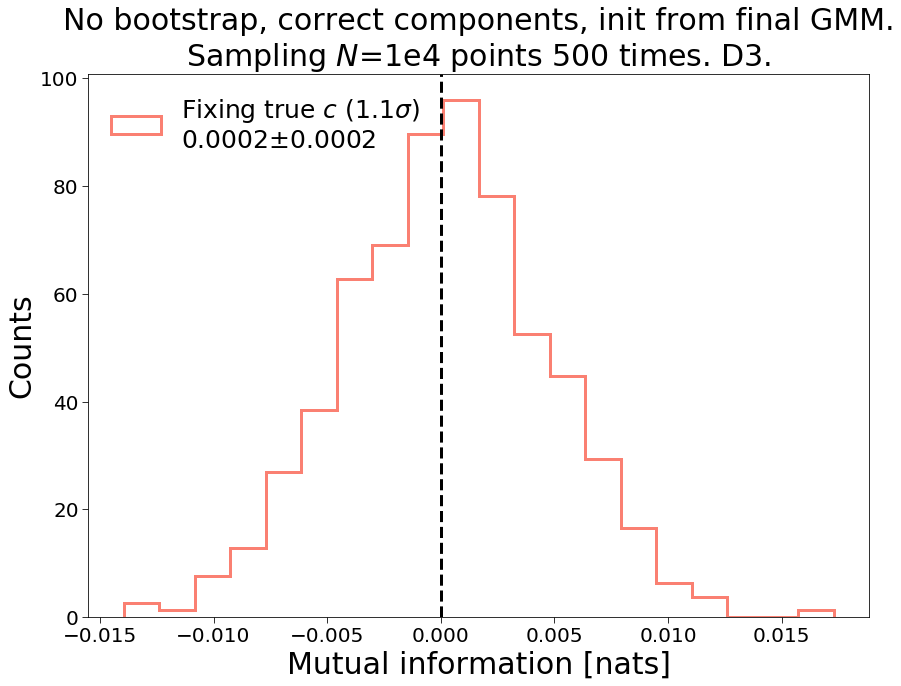

In [23]:
all_MI_estimates = np.load('./D3_bias_test_MI_initfromCV_diffseed.npy')
analytic = np.load('./mine-pytorch/mine/D3_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

#all_MI_estimates[120, 0] = analytic
#all_MI_estimates[120, 1] = analytic

#mmin = np.min(all_MI_estimates[:last_id]-analytic)
#mmax = np.max(all_MI_estimates[:last_id]-analytic)

print(np.argmin(all_MI_estimates[:last_id]))
print(np.max(all_MI_estimates[:last_id]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id] - analytic)) / (np.std(all_MI_estimates[:last_id]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id]- analytic)/np.sqrt(last_id):.4f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('No bootstrap, correct components, init from final GMM.\nSampling $N$=1e4 points 500 times. D3.', fontsize=30);

500
0.15605365929275175
0.18139734445324548


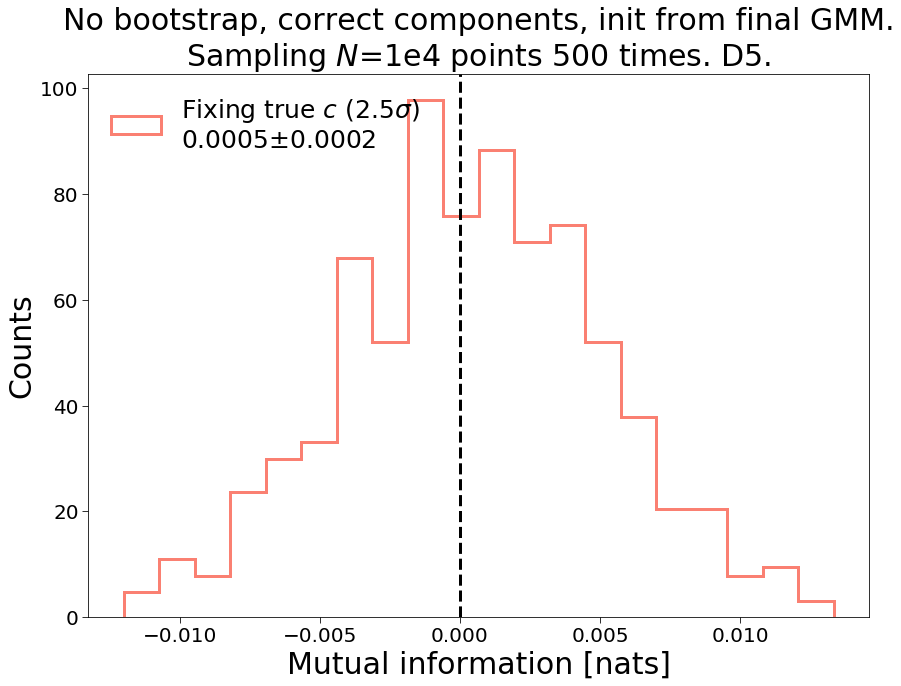

In [22]:
all_MI_estimates = np.load('./D5_bias_test_MI_initfromCV_diffseed.npy')
analytic = np.load('./mine-pytorch/mine/D5_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

#all_MI_estimates[120, 0] = analytic
#all_MI_estimates[120, 1] = analytic

#mmin = np.min(all_MI_estimates[:last_id]-analytic)
#mmax = np.max(all_MI_estimates[:last_id]-analytic)

print(np.min(all_MI_estimates[:last_id]))
print(np.max(all_MI_estimates[:last_id]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id] - analytic)) / (np.std(all_MI_estimates[:last_id]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id]- analytic)/np.sqrt(last_id):.4f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('No bootstrap, correct components, init from final GMM.\nSampling $N$=1e4 points 500 times. D5.', fontsize=30);

500
0.16716271813236785
0.19688167721815292


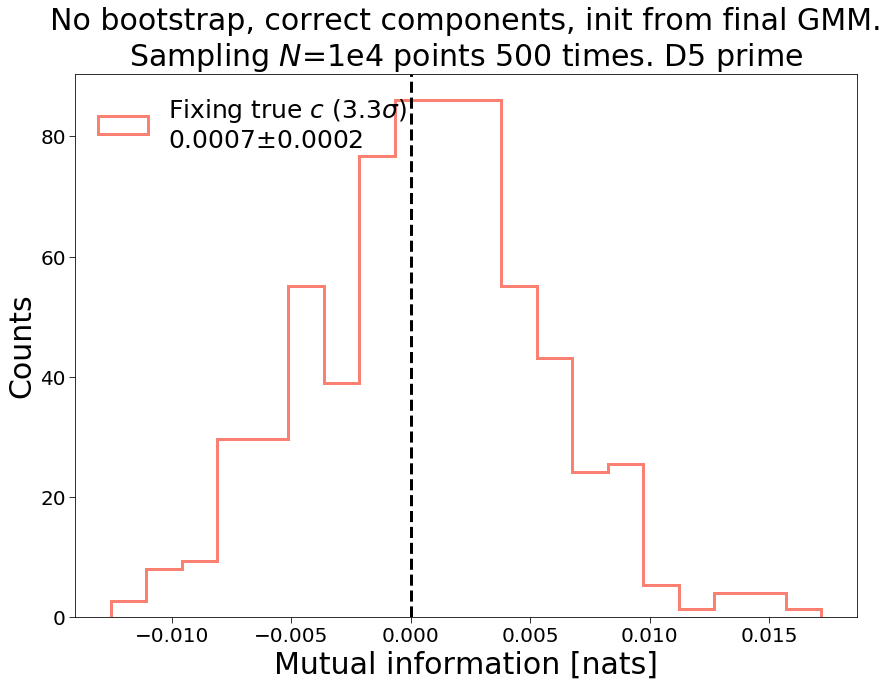

In [21]:
all_MI_estimates = np.load('./D5p_bias_test_MI_initfromCV_diffseed.npy')
analytic = 0.17972193484434484

last_id = 500#np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

#all_MI_estimates[120, 0] = analytic
#all_MI_estimates[120, 1] = analytic

#mmin = np.min(all_MI_estimates[:last_id]-analytic)
#mmax = np.max(all_MI_estimates[:last_id]-analytic)

print(np.min(all_MI_estimates[:last_id]))
print(np.max(all_MI_estimates[:last_id]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id] - analytic)) / (np.std(all_MI_estimates[:last_id]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id] - analytic):.4f}$\pm${np.std(all_MI_estimates[:last_id]- analytic)/np.sqrt(last_id):.4f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('No bootstrap, correct components, init from final GMM.\nSampling $N$=1e4 points 500 times. D5 prime', fontsize=30);

### New init, with bootstrap, correct c

500
82
0.14978118016906414


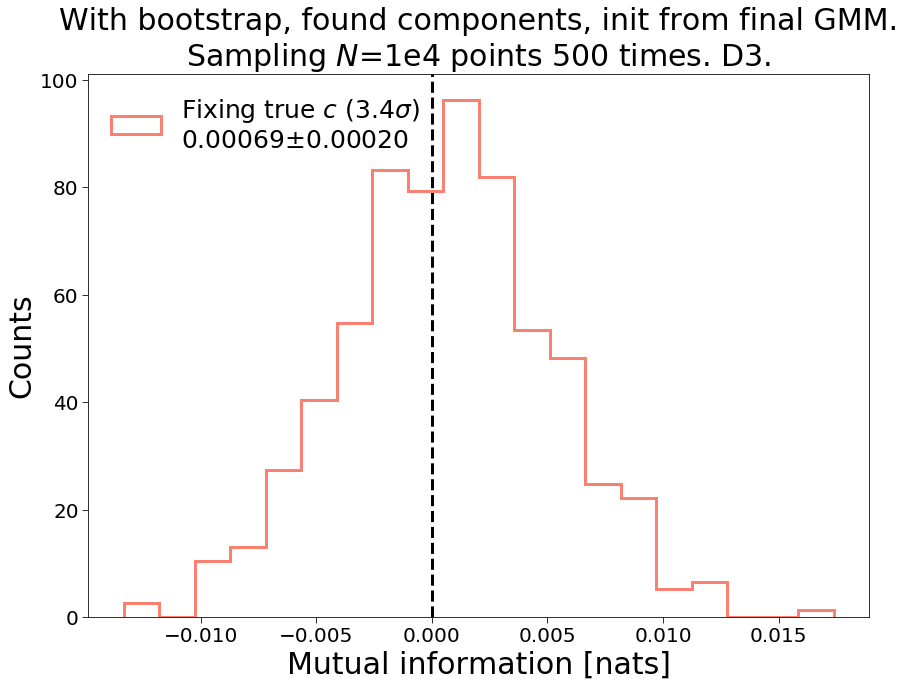

In [455]:
all_MI_estimates = np.load('./D3_bias_test_MI_bs_diffinit_truec.npy')
analytic = np.load('./mine-pytorch/mine/D3_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

#all_MI_estimates[120, 0] = analytic
#all_MI_estimates[120, 1] = analytic

#mmin = np.min(all_MI_estimates[:last_id]-analytic)
#mmax = np.max(all_MI_estimates[:last_id]-analytic)

idx = 1
print(np.argmin(all_MI_estimates[:last_id, idx]))
print(np.max(all_MI_estimates[:last_id, idx]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, idx].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, idx] - analytic)) / (np.std(all_MI_estimates[:last_id, idx]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, idx] - analytic):.5f}$\pm${np.std(all_MI_estimates[:last_id, idx]- analytic)/np.sqrt(last_id):.5f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('With bootstrap, found components, init from final GMM.\nSampling $N$=1e4 points 500 times. D3.', fontsize=30);

332
280
0.18206141705417078


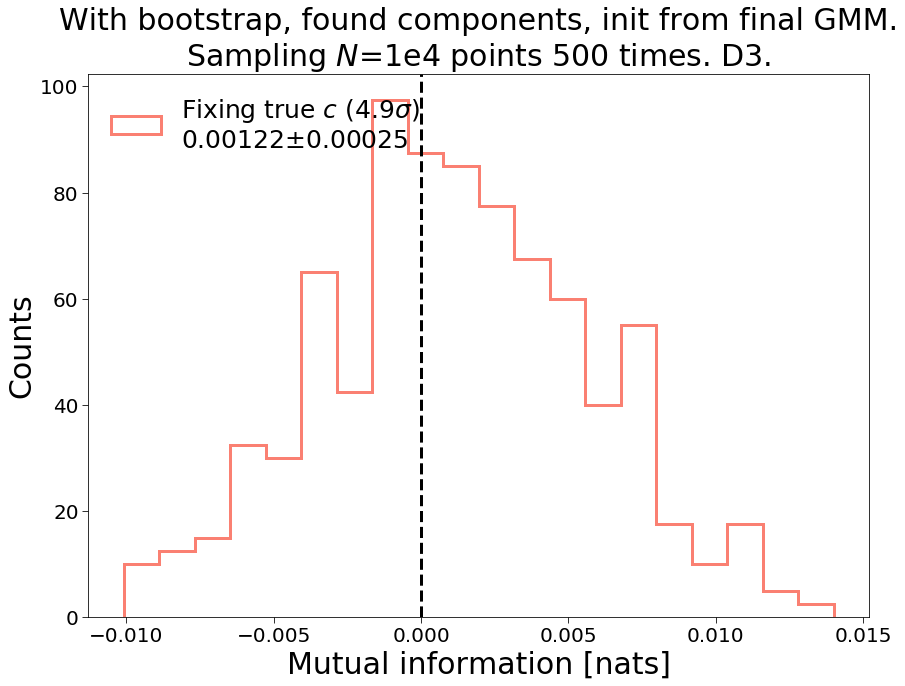

In [456]:
all_MI_estimates = np.load('./D5_bias_test_MI_bs_diffinit_truec.npy')
analytic = np.load('./mine-pytorch/mine/D5_analytic.npy')

last_id = np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

#all_MI_estimates[120, 0] = analytic
#all_MI_estimates[120, 1] = analytic

#mmin = np.min(all_MI_estimates[:last_id]-analytic)
#mmax = np.max(all_MI_estimates[:last_id]-analytic)

idx = 1
print(np.argmin(all_MI_estimates[:last_id, idx]))
print(np.max(all_MI_estimates[:last_id, idx]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, idx].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, idx] - analytic)) / (np.std(all_MI_estimates[:last_id, idx]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, idx] - analytic):.5f}$\pm${np.std(all_MI_estimates[:last_id, idx]- analytic)/np.sqrt(last_id):.5f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('With bootstrap, found components, init from final GMM.\nSampling $N$=1e4 points 500 times. D3.', fontsize=30);

356
342
0.19754772567356046


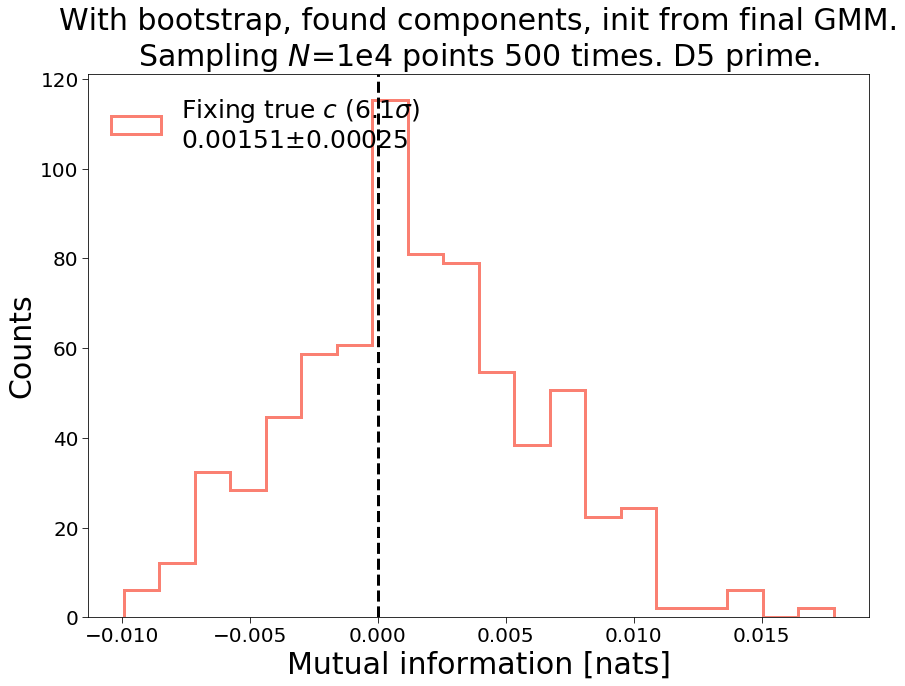

In [457]:
all_MI_estimates = np.load('./D5p_bias_test_MI_bs_diffinit_truec.npy')
analytic = 0.17972193484434484

last_id = np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

#all_MI_estimates[120, 0] = analytic
#all_MI_estimates[120, 1] = analytic

#mmin = np.min(all_MI_estimates[:last_id]-analytic)
#mmax = np.max(all_MI_estimates[:last_id]-analytic)

idx = 1
print(np.argmin(all_MI_estimates[:last_id, idx]))
print(np.max(all_MI_estimates[:last_id, idx]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, idx].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, idx] - analytic)) / (np.std(all_MI_estimates[:last_id, idx]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, idx] - analytic):.5f}$\pm${np.std(all_MI_estimates[:last_id, idx]- analytic)/np.sqrt(last_id):.5f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('With bootstrap, found components, init from final GMM.\nSampling $N$=1e4 points 500 times. D5 prime.', fontsize=30);

### New init, found c and no bootstrap

500
82
0.14967780582004445


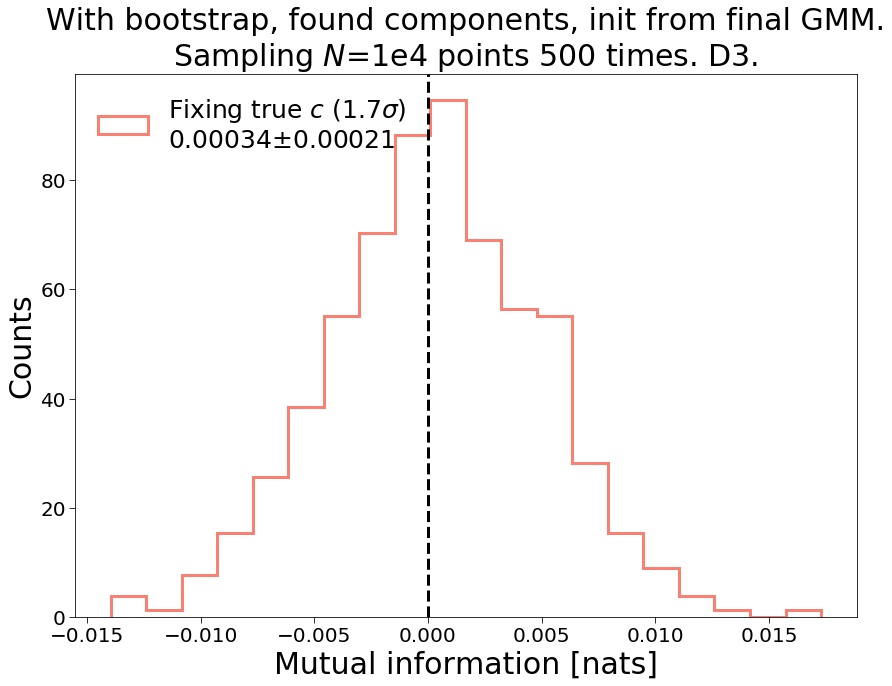

In [459]:
all_MI_estimates = np.load('./D3_bias_test_MI_bs_diffinit.npy')
analytic = np.load('./mine-pytorch/mine/D3_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

#all_MI_estimates[120, 0] = analytic
#all_MI_estimates[120, 1] = analytic

#mmin = np.min(all_MI_estimates[:last_id]-analytic)
#mmax = np.max(all_MI_estimates[:last_id]-analytic)

idx = 0
print(np.argmin(all_MI_estimates[:last_id, idx]))
print(np.max(all_MI_estimates[:last_id, idx]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, idx].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, idx] - analytic)) / (np.std(all_MI_estimates[:last_id, idx]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, idx] - analytic):.5f}$\pm${np.std(all_MI_estimates[:last_id, idx]- analytic)/np.sqrt(last_id):.5f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('With bootstrap, found components, init from final GMM.\nSampling $N$=1e4 points 500 times. D3.', fontsize=30);

386
382
0.18117227757690882


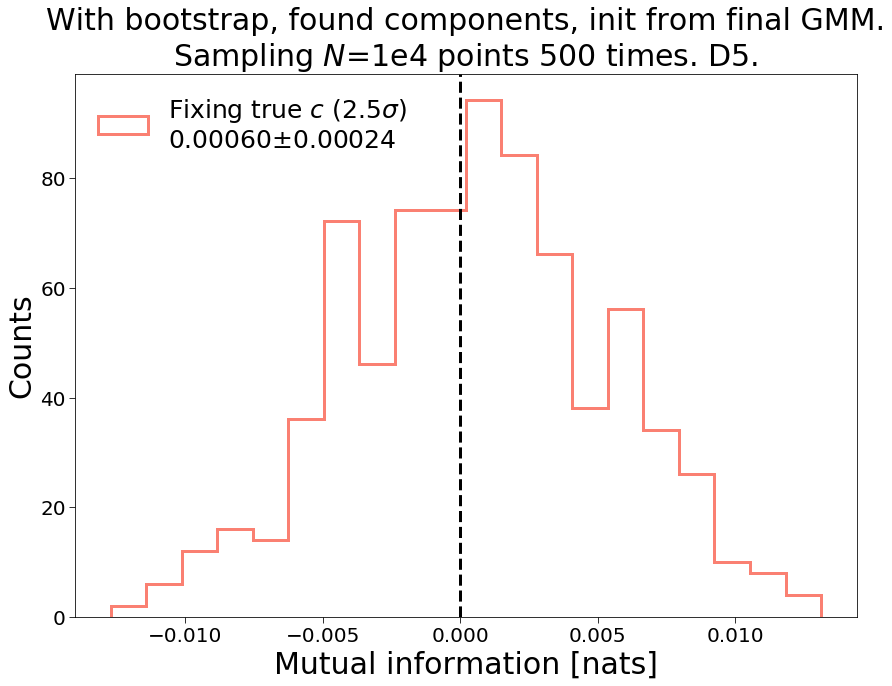

In [461]:
all_MI_estimates = np.load('./D5_bias_test_MI_bs_diffinit.npy')
analytic = np.load('./mine-pytorch/mine/D5_analytic.npy')

last_id = np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

#mmin = np.min(all_MI_estimates[:last_id]-analytic)
#mmax = np.max(all_MI_estimates[:last_id]-analytic)

#all_MI_estimates[176, 0] = analytic
#all_MI_estimates[176, 1] = analytic

#idx = 1
print(np.argmin(all_MI_estimates[:last_id, idx]))
print(np.max(all_MI_estimates[:last_id, idx]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, idx].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, idx] - analytic)) / (np.std(all_MI_estimates[:last_id, idx]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, idx] - analytic):.5f}$\pm${np.std(all_MI_estimates[:last_id, idx]- analytic)/np.sqrt(last_id):.5f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('With bootstrap, found components, init from final GMM.\nSampling $N$=1e4 points 500 times. D5.', fontsize=30);

421
414
0.19688167721540284


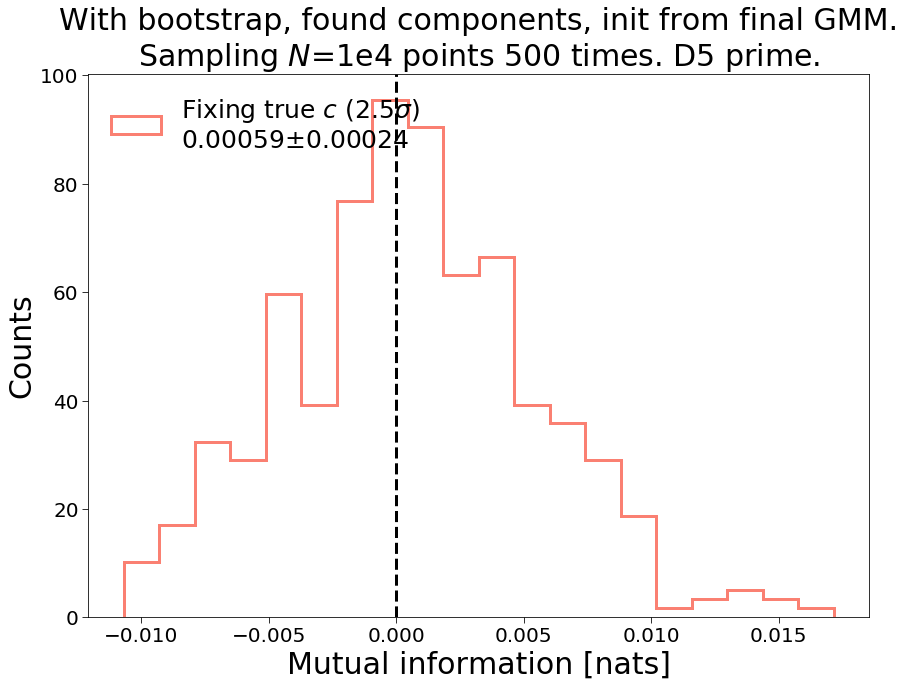

In [462]:
all_MI_estimates = np.load('./D5p_bias_test_MI_bs_diffinit.npy')
analytic = 0.17972193484434484

last_id = np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

#mmin = np.min(all_MI_estimates[:last_id]-analytic)
#mmax = np.max(all_MI_estimates[:last_id]-analytic)

#all_MI_estimates[482, 0] = analytic
#all_MI_estimates[482, 1] = analytic

idx = 0
print(np.argmin(all_MI_estimates[:last_id, idx]))
print(np.max(all_MI_estimates[:last_id, idx]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, idx].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, idx] - analytic)) / (np.std(all_MI_estimates[:last_id, idx]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, idx] - analytic):.5f}$\pm${np.std(all_MI_estimates[:last_id, idx]- analytic)/np.sqrt(last_id):.5f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('With bootstrap, found components, init from final GMM.\nSampling $N$=1e4 points 500 times. D5 prime.', fontsize=30);

### New init, found c and with bootstrap

500
82
0.14978118016906414


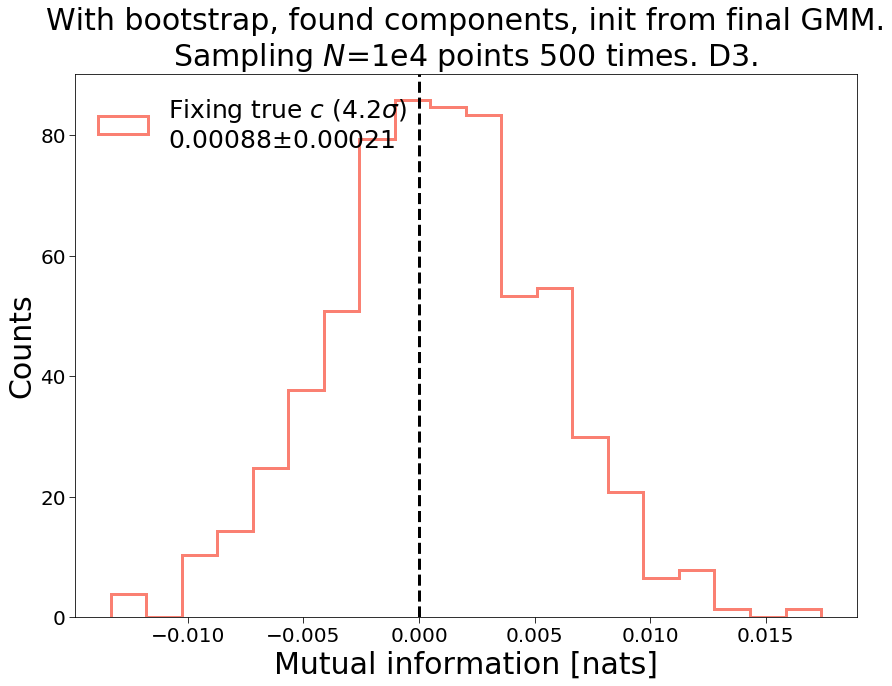

In [464]:
all_MI_estimates = np.load('./D3_bias_test_MI_bs_diffinit.npy')
analytic = np.load('./mine-pytorch/mine/D3_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

#all_MI_estimates[120, 0] = analytic
#all_MI_estimates[120, 1] = analytic

#mmin = np.min(all_MI_estimates[:last_id]-analytic)
#mmax = np.max(all_MI_estimates[:last_id]-analytic)

idx = 1
print(np.argmin(all_MI_estimates[:last_id, idx]))
print(np.max(all_MI_estimates[:last_id, idx]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, idx].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, idx] - analytic)) / (np.std(all_MI_estimates[:last_id, idx]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, idx] - analytic):.5f}$\pm${np.std(all_MI_estimates[:last_id, idx]- analytic)/np.sqrt(last_id):.5f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('With bootstrap, found components, init from final GMM.\nSampling $N$=1e4 points 500 times. D3.', fontsize=30);

387
382
0.18206141705417078


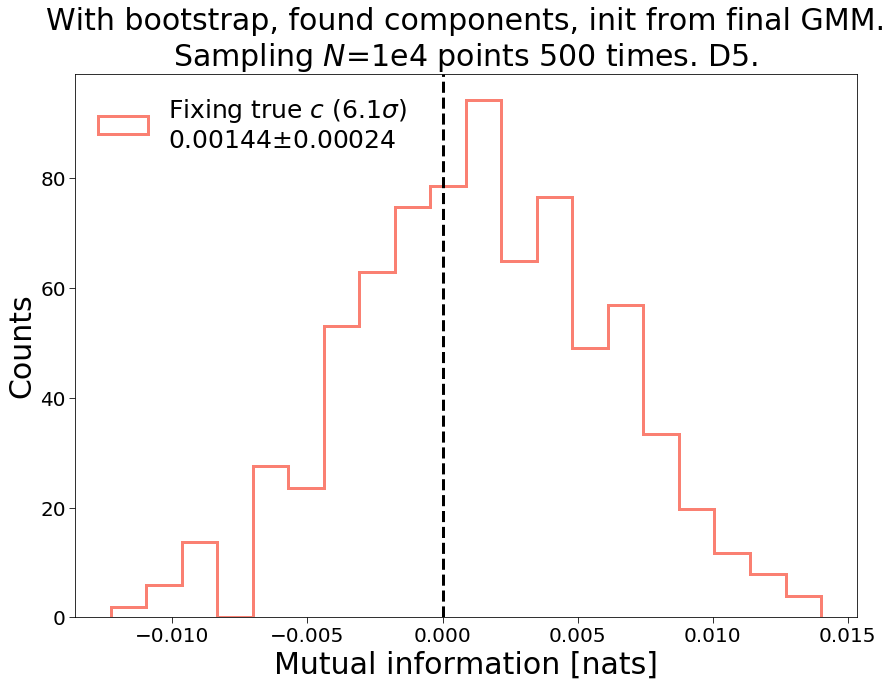

In [465]:
all_MI_estimates = np.load('./D5_bias_test_MI_bs_diffinit.npy')
analytic = np.load('./mine-pytorch/mine/D5_analytic.npy')

last_id = np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

#mmin = np.min(all_MI_estimates[:last_id]-analytic)
#mmax = np.max(all_MI_estimates[:last_id]-analytic)

#all_MI_estimates[176, 0] = analytic
#all_MI_estimates[176, 1] = analytic

#idx = 1
print(np.argmin(all_MI_estimates[:last_id, idx]))
print(np.max(all_MI_estimates[:last_id, idx]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, idx].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, idx] - analytic)) / (np.std(all_MI_estimates[:last_id, idx]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, idx] - analytic):.5f}$\pm${np.std(all_MI_estimates[:last_id, idx]- analytic)/np.sqrt(last_id):.5f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('With bootstrap, found components, init from final GMM.\nSampling $N$=1e4 points 500 times. D5.', fontsize=30);

422
382
0.19754772567356046


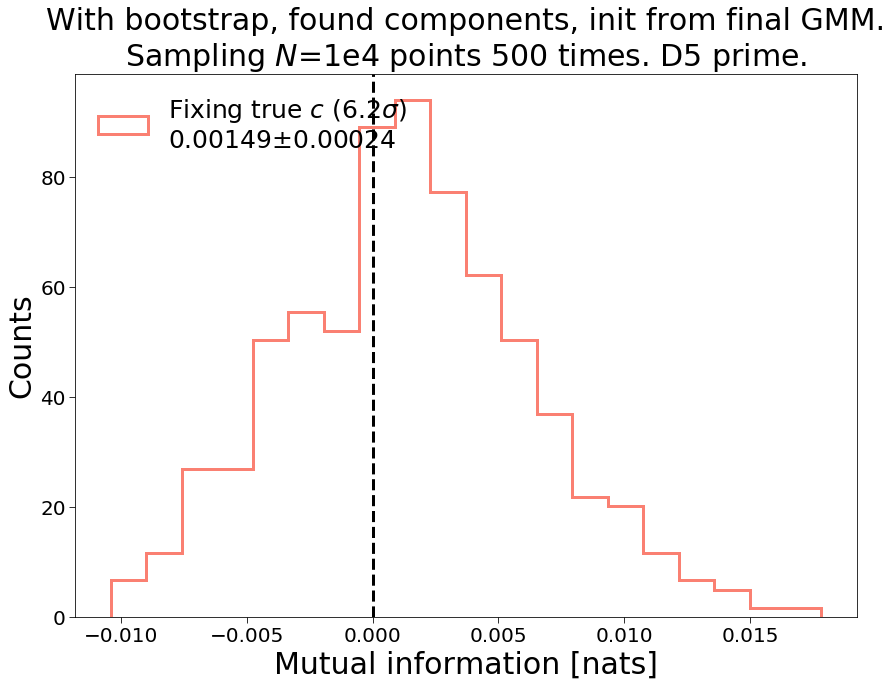

In [466]:
all_MI_estimates = np.load('./D5p_bias_test_MI_bs_diffinit.npy')
analytic = 0.17972193484434484

last_id = np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

#mmin = np.min(all_MI_estimates[:last_id]-analytic)
#mmax = np.max(all_MI_estimates[:last_id]-analytic)

#all_MI_estimates[482, 0] = analytic
#all_MI_estimates[482, 1] = analytic

print(np.argmin(all_MI_estimates[:last_id, idx]))
print(np.max(all_MI_estimates[:last_id, idx]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, idx].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, idx] - analytic)) / (np.std(all_MI_estimates[:last_id, idx]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id, idx] - analytic):.5f}$\pm${np.std(all_MI_estimates[:last_id, idx]- analytic)/np.sqrt(last_id):.5f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('With bootstrap, found components, init from final GMM.\nSampling $N$=1e4 points 500 times. D5 prime.', fontsize=30);

### Including bootstrap stddev, what are the final residuals we'd put in the paper?

500
82
0.14978118016906414


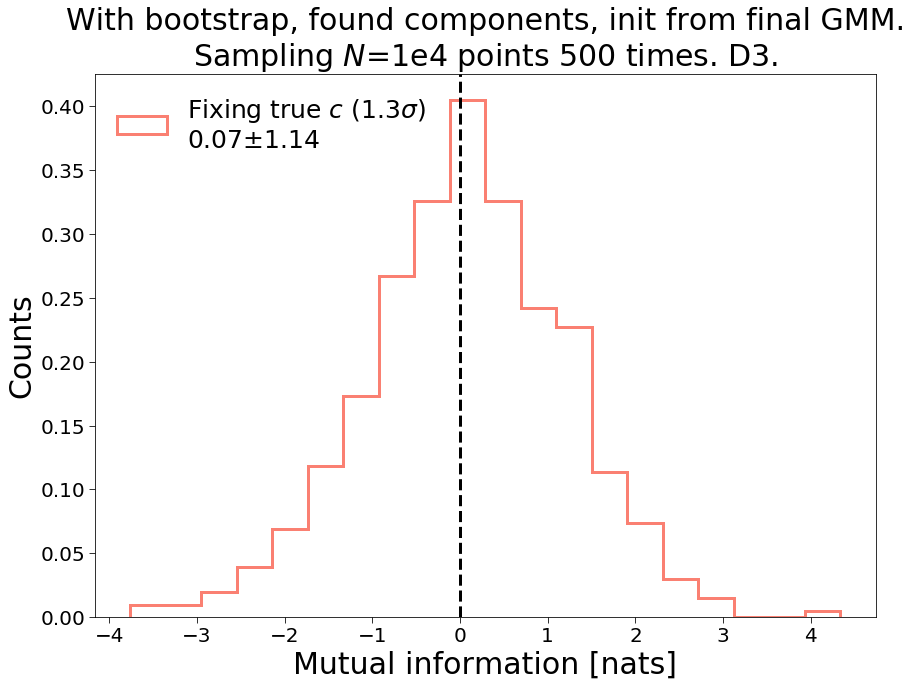

In [470]:
all_MI_estimates = np.load('./D3_bias_test_MI_bs_diffinit.npy')
analytic = np.load('./mine-pytorch/mine/D3_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

#all_MI_estimates[120, 0] = analytic
#all_MI_estimates[120, 1] = analytic

#mmin = np.min(all_MI_estimates[:last_id]-analytic)
#mmax = np.max(all_MI_estimates[:last_id]-analytic)

print(np.argmin(all_MI_estimates[:last_id, idx]))
print(np.max(all_MI_estimates[:last_id, idx]))

idx = 0

bins=20
alpha=0.5
legendsize=25
biases = (all_MI_estimates[:last_id, idx].flatten()-analytic)/all_MI_estimates[:last_id, 2].flatten()

ax1.hist(biases, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*np.mean(biases) / np.std(biases):.1f}$\sigma$)\n{np.mean(biases):.2f}$\pm${np.std(biases):.2f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('With bootstrap, found components, init from final GMM.\nSampling $N$=1e4 points 500 times. D3.', fontsize=30);

387
382
0.18206141705417078


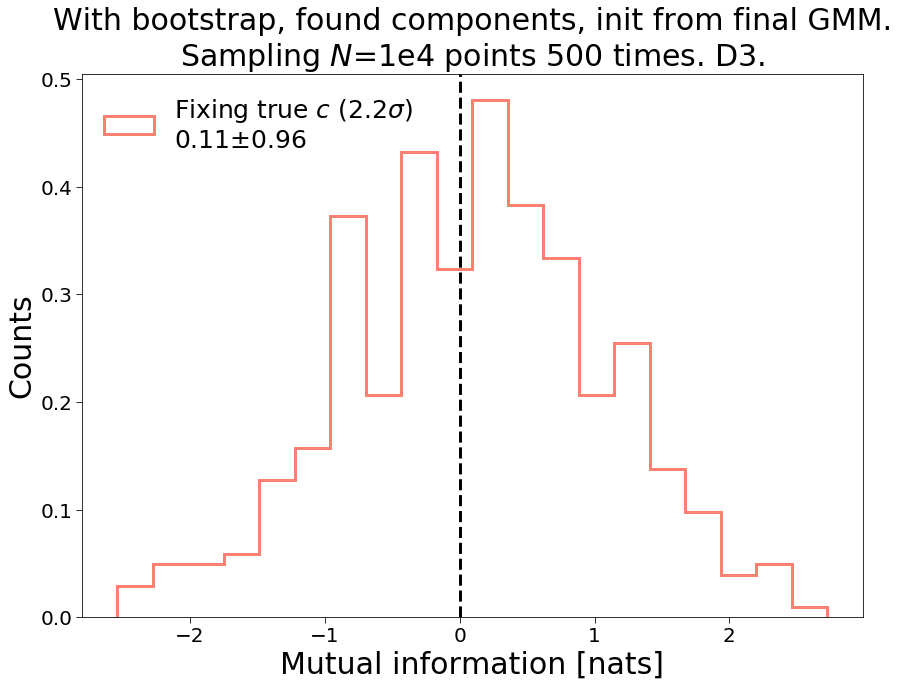

In [473]:
all_MI_estimates = np.load('./D5_bias_test_MI_bs_diffinit.npy')
analytic = np.load('./mine-pytorch/mine/D5_analytic.npy')

last_id = np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

#all_MI_estimates[120, 0] = analytic
#all_MI_estimates[120, 1] = analytic

#mmin = np.min(all_MI_estimates[:last_id]-analytic)
#mmax = np.max(all_MI_estimates[:last_id]-analytic)

print(np.argmin(all_MI_estimates[:last_id, idx]))
print(np.max(all_MI_estimates[:last_id, idx]))

idx = 0

bins=20
alpha=0.5
legendsize=25
biases = (all_MI_estimates[:last_id, idx].flatten()-analytic)/all_MI_estimates[:last_id, 2].flatten()

ax1.hist(biases, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*np.mean(biases) / np.std(biases):.1f}$\sigma$)\n{np.mean(biases):.2f}$\pm${np.std(biases):.2f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('With bootstrap, found components, init from final GMM.\nSampling $N$=1e4 points 500 times. D3.', fontsize=30);

422
382
0.19754772567356046


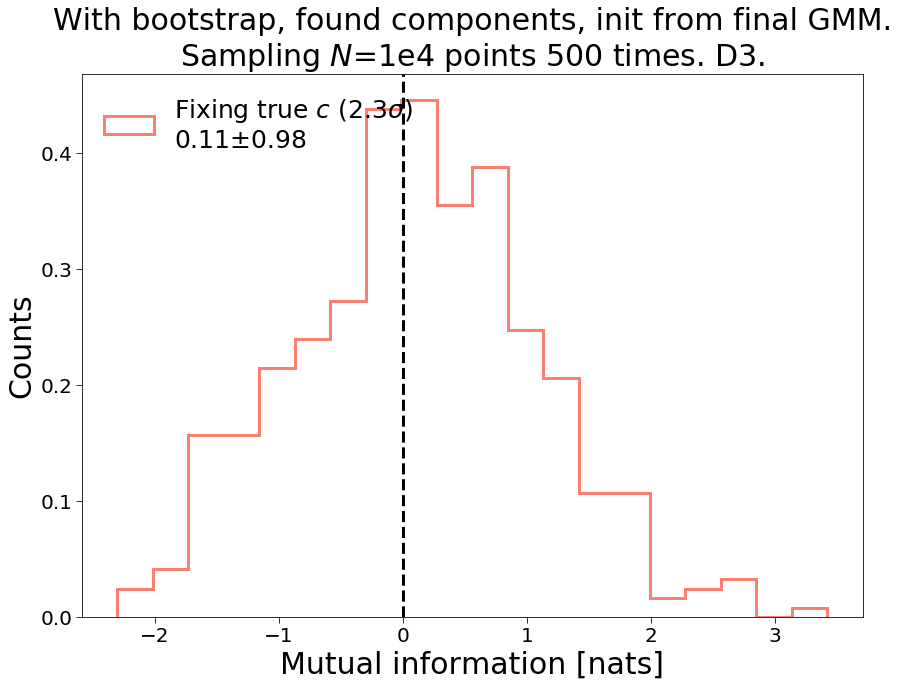

In [476]:
all_MI_estimates = np.load('./D5p_bias_test_MI_bs_diffinit.npy')
analytic = 0.17972193484434484

last_id = np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

#all_MI_estimates[120, 0] = analytic
#all_MI_estimates[120, 1] = analytic

#mmin = np.min(all_MI_estimates[:last_id]-analytic)
#mmax = np.max(all_MI_estimates[:last_id]-analytic)

print(np.argmin(all_MI_estimates[:last_id, idx]))
print(np.max(all_MI_estimates[:last_id, idx]))

idx = 0

bins=20
alpha=0.5
legendsize=25
biases = (all_MI_estimates[:last_id, idx].flatten()-analytic)/all_MI_estimates[:last_id, 2].flatten()

ax1.hist(biases, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*np.mean(biases) / np.std(biases):.1f}$\sigma$)\n{np.mean(biases):.2f}$\pm${np.std(biases):.2f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('With bootstrap, found components, init from final GMM.\nSampling $N$=1e4 points 500 times. D3.', fontsize=30);

### New init, no bootstrap, correct c, but taking median

500
105
0.14591721479549263


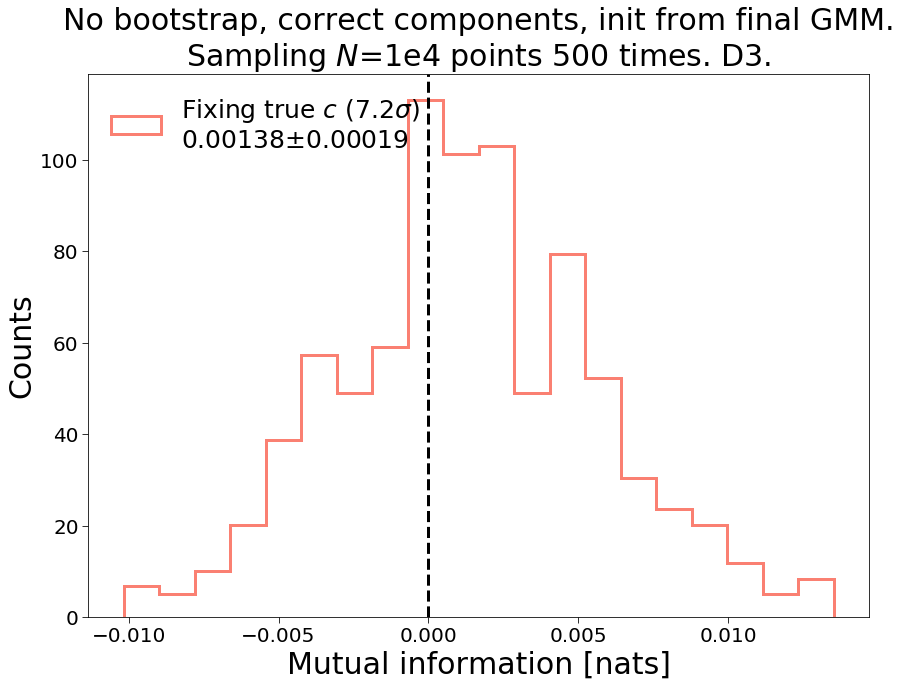

In [13]:
all_MI_estimates = np.load('./D3_bias_test_MI_initfromCV_diffseed_median_1_init.npy')
analytic = np.load('./mine-pytorch/mine/D3_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

all_MI_estimates[63] = analytic
all_MI_estimates[330] = analytic
all_MI_estimates[166] = analytic
all_MI_estimates[406] = analytic
all_MI_estimates[89] = analytic
all_MI_estimates[199] = analytic
all_MI_estimates[15] = analytic
all_MI_estimates[14] = analytic


#all_MI_estimates[120, 1] = analytic

#mmin = np.min(all_MI_estimates[:last_id]-analytic)
#mmax = np.max(all_MI_estimates[:last_id]-analytic)

print(np.argmin(all_MI_estimates[:last_id]))
print(np.max(all_MI_estimates[:last_id]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id] - analytic)) / (np.std(all_MI_estimates[:last_id]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id] - analytic):.5f}$\pm${np.std(all_MI_estimates[:last_id]- analytic)/np.sqrt(last_id):.5f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('No bootstrap, correct components, init from final GMM.\nSampling $N$=1e4 points 500 times. D3.', fontsize=30);

346
280
0.18021847196723415


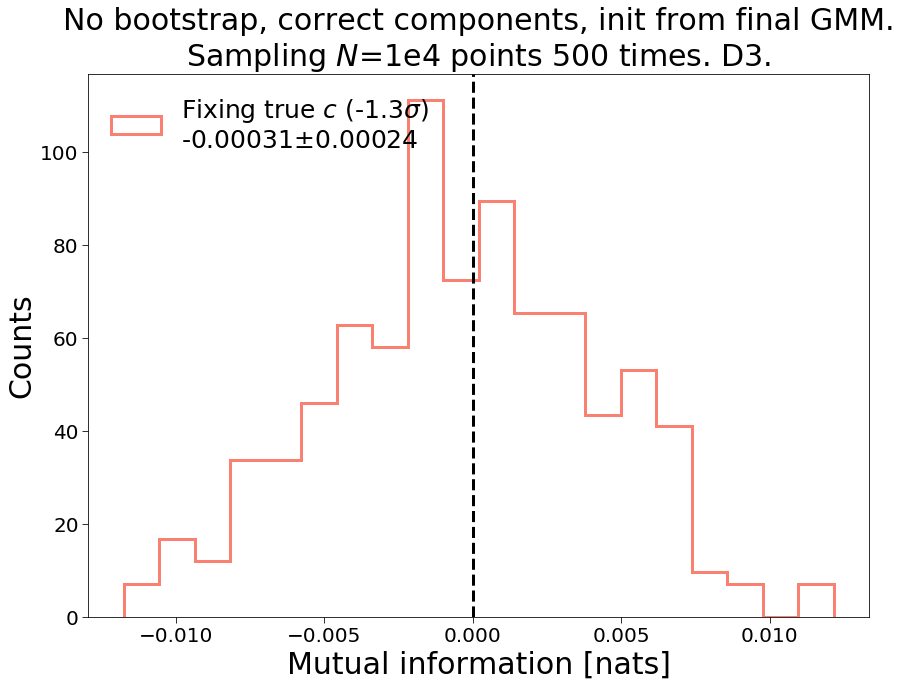

In [15]:
all_MI_estimates = np.load('./D5_bias_test_MI_initfromCV_diffseed_median_0_init.npy')
analytic = np.load('./mine-pytorch/mine/D5_analytic.npy')

last_id = np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

all_MI_estimates[38] = analytic

#mmin = np.min(all_MI_estimates[:last_id]-analytic)
#mmax = np.max(all_MI_estimates[:last_id]-analytic)

print(np.argmin(all_MI_estimates[:last_id]))
print(np.max(all_MI_estimates[:last_id]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id] - analytic)) / (np.std(all_MI_estimates[:last_id]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id] - analytic):.5f}$\pm${np.std(all_MI_estimates[:last_id]- analytic)/np.sqrt(last_id):.5f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('No bootstrap, correct components, init from final GMM.\nSampling $N$=1e4 points 500 times. D3.', fontsize=30);

142
31
0.19066927757494695


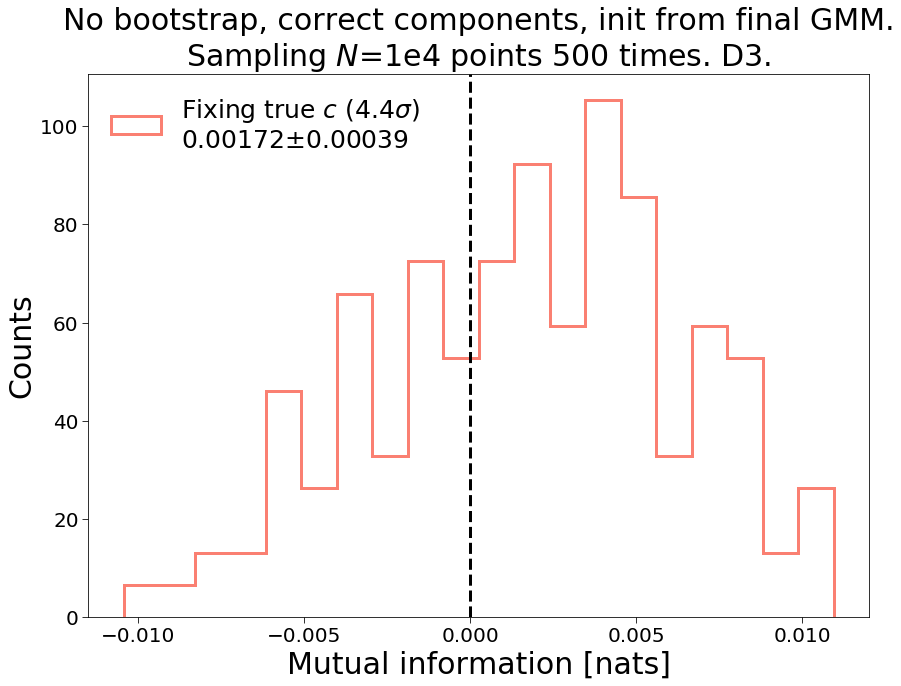

In [546]:
all_MI_estimates = np.load('./D5p_bias_test_MI_initfromCV_diffseed_median_1.npy')
analytic = 0.17972193484434484

last_id = np.where(all_MI_estimates == 0)[0][0]-1
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

all_MI_estimates[60] = analytic
#all_MI_estimates[91] = analytic
#all_MI_estimates[155] = analytic
#all_MI_estimates[163] = analytic
#all_MI_estimates[308] = analytic
#all_MI_estimates[444] = analytic


#mmin = np.min(all_MI_estimates[:last_id]-analytic)
#mmax = np.max(all_MI_estimates[:last_id]-analytic)

print(np.argmin(all_MI_estimates[:last_id]))
print(np.max(all_MI_estimates[:last_id]))


bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id].flatten()-analytic, alpha=1, bins=bins, density=True,
         label=f'Fixing true $c$ ({np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id] - analytic)) / (np.std(all_MI_estimates[:last_id]- analytic)):.1f}$\sigma$)\n{np.mean(all_MI_estimates[:last_id] - analytic):.5f}$\pm${np.std(all_MI_estimates[:last_id]- analytic)/np.sqrt(last_id):.5f}', color='salmon', histtype='step', lw=3)


#x = np.linspace(-0.015, 0.015, 1000, endpoint=False)
#y = multivariate_normal.pdf(x, mean=np.mean(all_MI_estimates[:last_id, 1] - analytic), cov=np.var(all_MI_estimates[:last_id, 1] - analytic))
#ax1.plot(x, y,
#       'b-', lw=5, alpha=0.6, label='Gaussian pdf')

ax1.axvline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('Mutual information [nats]', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)

ax1.set_title('No bootstrap, correct components, init from final GMM.\nSampling $N$=1e4 points 500 times. D3.', fontsize=30);

### Second test on number of duplicates

100


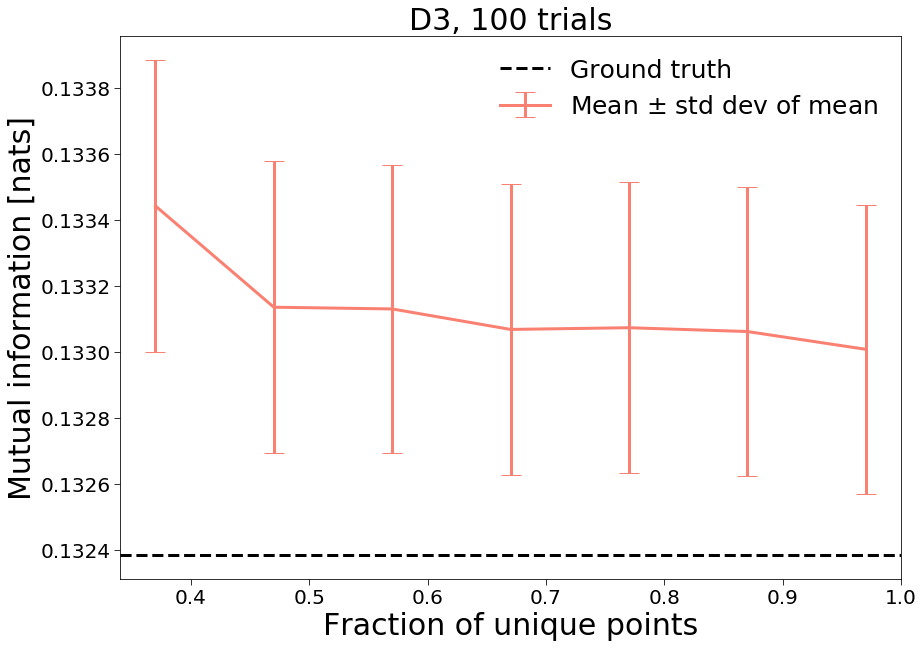

In [166]:
all_MI_estimates = np.load('./D3_bias_test_duplicates.npy')
analytic = np.load('./mine-pytorch/mine/D3_analytic.npy')
fractions = np.arange(0.37, 1.05, 0.1)

last_id = 100#np.where(all_MI_estimates == 0)[1][0]-1
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

legendsize=25

ax1.errorbar(fractions, np.mean(all_MI_estimates[:, :last_id], axis=1), 
             np.std(all_MI_estimates[:, :last_id], axis=1)/np.sqrt(last_id), ls='-', lw=3,
             elinewidth=3, capsize=10, color='salmon', label='Mean $\pm$ std dev of mean')

#ax1.scatter(fractions, np.mean(all_MI_estimates[:, :last_id], axis=1), color='salmon', s=200)

ax1.axhline(analytic, ls='--', lw=3, c='k', label='Ground truth')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper right')
ax1.set_ylabel('Mutual information [nats]', fontsize=30)
ax1.set_xlabel('Fraction of unique points', fontsize=30)
ax1.set_title(f'D3, {last_id} trials', fontsize=30);
#ax1.set_title('With bootstrap, sampling $N$=1e4 points 500 times.\n$c$ = number of GMM components', fontsize=30);

In [608]:
np.concatenate((np.arange(0.37, 1.05, 0.1), np.arange(0.40, 1.05, 0.1)))

array([0.37, 0.47, 0.57, 0.67, 0.77, 0.87, 0.97, 0.4 , 0.5 , 0.6 , 0.7 ,
       0.8 , 0.9 , 1.  ])

507


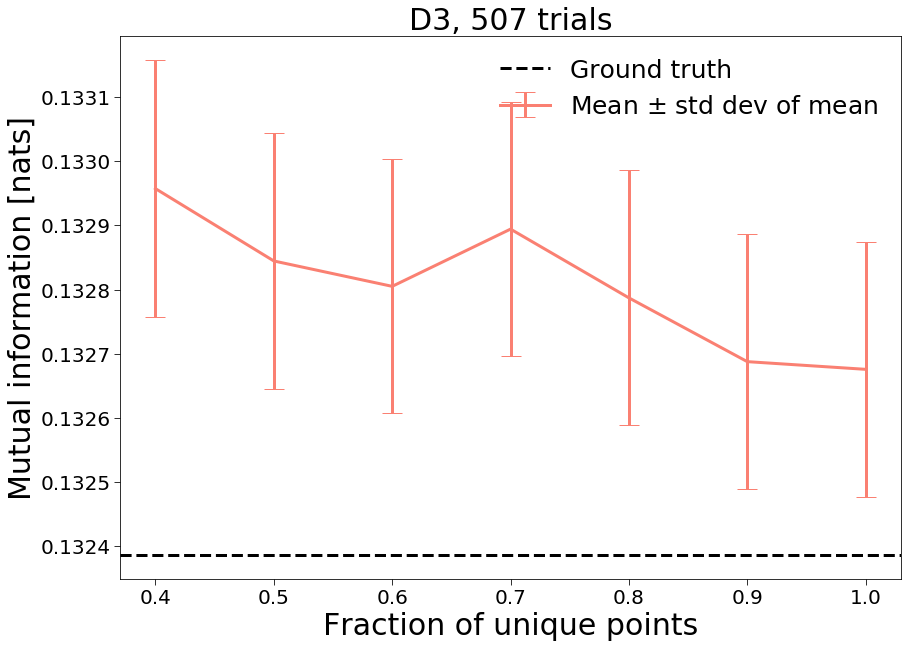

In [165]:
all_MI_estimates = np.load('./D3_bias_test_duplicates_diffractions_500.npy')
analytic = np.load('./mine-pytorch/mine/D3_analytic.npy')
fractions = np.arange(0.40, 1.05, 0.1)

last_id = np.where(all_MI_estimates == 0)[1][0]-1
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

legendsize=25

ax1.errorbar(fractions, np.mean(all_MI_estimates[:, :last_id], axis=1), 
             np.std(all_MI_estimates[:, :last_id], axis=1)/np.sqrt(last_id), ls='-', lw=3,
             elinewidth=3, capsize=10, color='salmon', label='Mean $\pm$ std dev of mean')

#ax1.scatter(fractions, np.mean(all_MI_estimates[:, :last_id], axis=1), color='salmon', s=200)

ax1.axhline(analytic, ls='--', lw=3, c='k', label='Ground truth')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper right')
ax1.set_ylabel('Mutual information [nats]', fontsize=30)
ax1.set_xlabel('Fraction of unique points', fontsize=30)
ax1.set_title(f'D3, {last_id} trials', fontsize=30);
#ax1.set_title('With bootstrap, sampling $N$=1e4 points 500 times.\n$c$ = number of GMM components', fontsize=30);

In [ ]:
# here

485


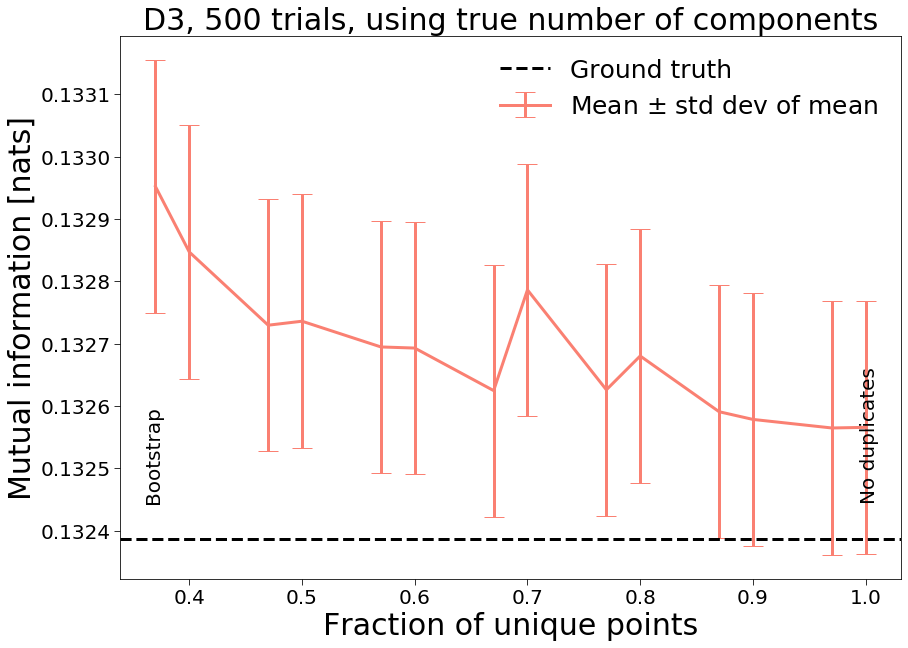

In [164]:
all_MI_estimates = np.concatenate((np.load('./D3_bias_test_duplicates_500.npy'), np.load('./D3_bias_test_duplicates_diffractions_500.npy')))
analytic = np.load('./mine-pytorch/mine/D3_analytic.npy')
fractions = np.sort(np.concatenate((np.arange(0.37, 1.05, 0.1), np.arange(0.40, 1.05, 0.1))))
fractions_idx = np.argsort(np.concatenate((np.arange(0.37, 1.05, 0.1), np.arange(0.40, 1.05, 0.1))))
all_MI_estimates = all_MI_estimates[fractions_idx]

last_id = 485#np.where(all_MI_estimates == 0)[1][0]-1
print(last_id)

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

legendsize=25

ax1.errorbar(fractions, np.mean(all_MI_estimates[:, :last_id], axis=1), 
             np.std(all_MI_estimates[:, :last_id], axis=1)/np.sqrt(last_id), ls='-', lw=3,
             elinewidth=3, capsize=10, color='salmon', label='Mean $\pm$ std dev of mean')

#ax1.scatter(fractions, np.mean(all_MI_estimates[:, :last_id], axis=1), color='salmon', s=200)

ax1.axhline(analytic, ls='--', lw=3, c='k', label='Ground truth')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper right')
ax1.set_ylabel('Mutual information [nats]', fontsize=30)
ax1.set_xlabel('Fraction of unique points', fontsize=30)
ax1.set_title(f'D3, {500} trials, using true number of components', fontsize=30)

ax1.text(0.36, 0.13245, "Bootstrap", fontsize=20, rotation=90);
ax1.text(0.995, 0.13245, "No duplicates", fontsize=20, rotation=90);

#ax1.set_title('With bootstrap, sampling $N$=1e4 points 500 times.\n$c$ = number of GMM components', fontsize=30);

### Dispersion test

In [6]:
all_MI_estimates = np.load('./D3_bias_test_dispersion_MI.npy')
all_ds = np.load('./D3_bias_test_dispersion_ds.npy')
analytic = np.load('./mine-pytorch/mine/D3_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0] - 1

mi = all_MI_estimates[:last_id]
ds = all_ds[:last_id, 0]
ds_x = all_ds[:last_id, 1]
ds_y = all_ds[:last_id, 2]

d_true, d_x_true, d_y_true = 0.14349375000000003, 0.55, 0.28

bias_sigma = np.sqrt(last_id) * np.mean(mi - analytic) / np.std(mi - analytic)

bias_d = np.sqrt(last_id) * np.mean(ds - d_true) / np.std(ds - d_true)
bias_dx = np.sqrt(last_id) * np.mean(ds_x - d_x_true) / np.std(ds_x - d_x_true)
bias_dy = np.sqrt(last_id) * np.mean(ds_y - d_y_true) / np.std(ds_y - d_y_true)

print(bias_sigma, bias_d, bias_dx, bias_dy)

1.2835204167203285 -6.815278410892062 -0.8664754313811461 -8.02775504924161


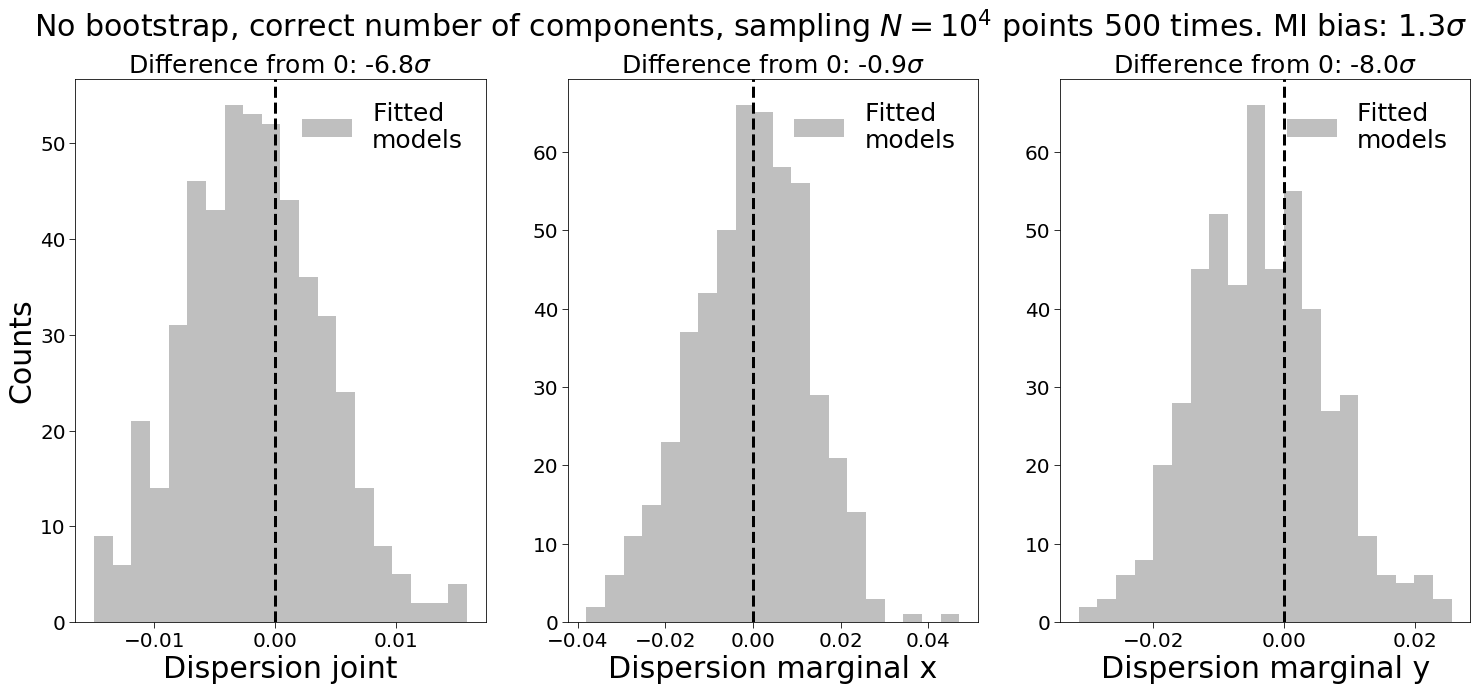

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 10))

bins=20
alpha=0.5
legendsize=25

ax1.hist(ds - d_true, alpha=alpha, bins=bins, 
         label=f'Fitted\nmodels', color='grey')
ax1.set_title(f'Difference from 0: {bias_d:.1f}$\sigma$', fontsize=25)


ax1.axvline(0, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper right')
ax1.set_xlabel('Dispersion joint', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)


ax2.hist(ds_x - d_x_true, alpha=alpha, bins=bins, 
         label=f'Fitted\nmodels', color='grey')
ax2.set_title(f'Difference from 0: {bias_dx:.1f}$\sigma$', fontsize=25)

ax2.set_xlabel('Dispersion marginal x', fontsize=30)

ax2.axvline(0, ls='--', lw=3, c='k')
ax2.tick_params(axis='both', which='major', labelsize=20, size=6)
ax2.legend(fontsize=legendsize, frameon=False, loc='upper right')

ax3.hist(ds_y - d_y_true, alpha=alpha, bins=bins, 
         label=f'Fitted\nmodels', color='grey')
ax3.set_title(f'Difference from 0: {bias_dy:.1f}$\sigma$', fontsize=25)

ax3.set_xlabel('Dispersion marginal y', fontsize=30)

ax3.axvline(0, ls='--', lw=3, c='k')
ax3.tick_params(axis='both', which='major', labelsize=20, size=6)
ax3.legend(fontsize=legendsize, frameon=False, loc='upper right')


plt.suptitle(f'No bootstrap, correct number of components, sampling $N=10^4$ points {last_id} times. MI bias: {bias_sigma:.1f}$\sigma$', fontsize=30);

### Extra dispersion test where we look at the same thing for all 4 datasets, and we also plot the scatter with MI

In [ ]:
# todo

In [122]:
all_MI_estimates = np.load('./D3_bias_test_dispersion_MI_check.npy')
all_ds = np.load('./D3_bias_test_dispersion_ds_check.npy')
analytic = np.load('./mine-pytorch/mine/D3_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0] - 1

mi_mc = all_MI_estimates[:last_id, 0]
mi_exact = all_MI_estimates[:last_id, 1]
ds = all_ds[:last_id, 0]
ds_x = all_ds[:last_id, 1]
ds_y = all_ds[:last_id, 2]

d_true, d_x_true, d_y_true = 0.14349375000000003, 0.55, 0.28

bias_sigma_mc = np.sqrt(last_id) * np.mean(mi_mc - analytic) / np.std(mi_mc - analytic)
bias_sigma_exact = np.sqrt(last_id) * np.mean(mi_exact - analytic) / np.std(mi_exact - analytic)

bias_d = np.sqrt(last_id) * np.mean(ds - d_true) / np.std(ds - d_true)
bias_dx = np.sqrt(last_id) * np.mean(ds_x - d_x_true) / np.std(ds_x - d_x_true)
bias_dy = np.sqrt(last_id) * np.mean(ds_y - d_y_true) / np.std(ds_y - d_y_true)

print(bias_sigma_mc, bias_sigma_exact, bias_d, bias_dx, bias_dy)

1.1164819619346398 0.7174611170185444 -3.87929170772688 0.5249770543152503 -5.086032933998893


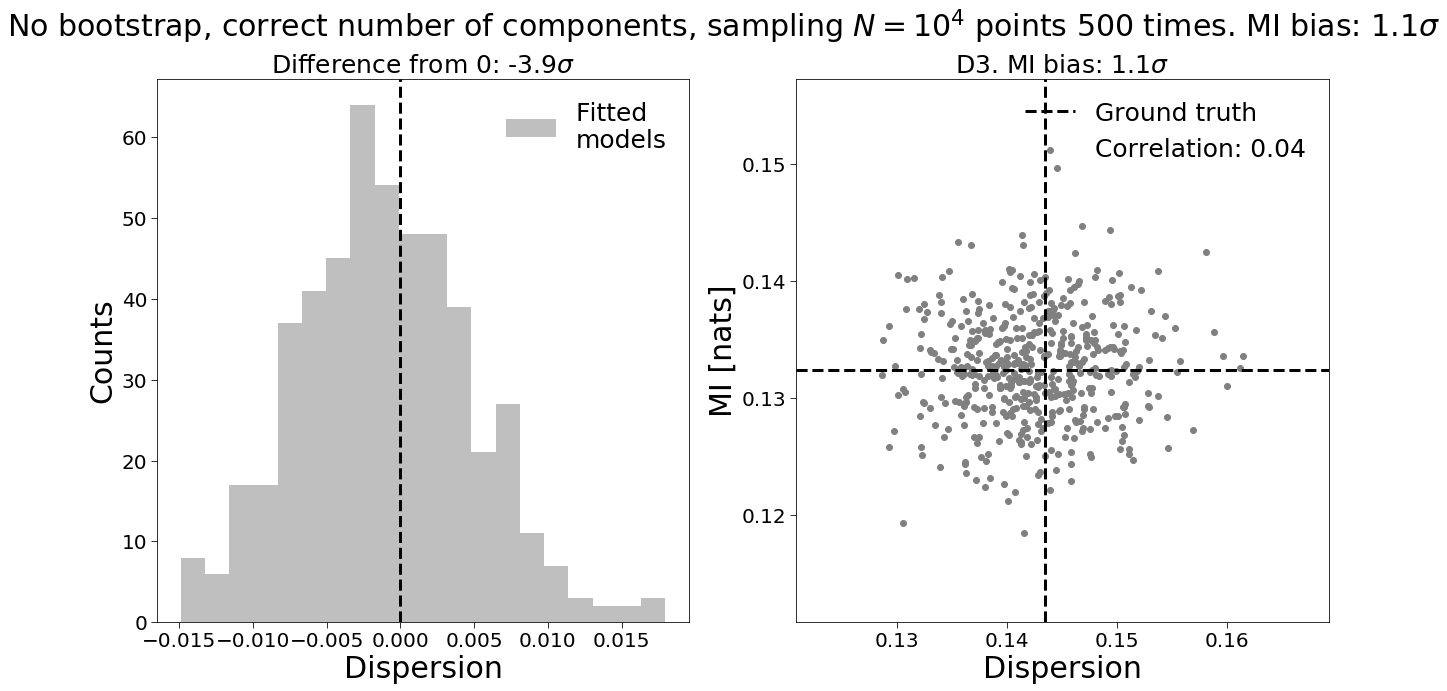

In [123]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 10))

bins=20
alpha=0.5
legendsize=25

ax1.hist(ds - d_true, alpha=alpha, bins=bins, 
         label=f'Fitted\nmodels', color='grey')
ax1.set_title(f'Difference from 0: {bias_d:.1f}$\sigma$', fontsize=25)

ax1.axvline(0, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper right')
ax1.set_xlabel('Dispersion', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)


ax2.scatter(ds, mi_mc, color='grey', label=f'Correlation: {np.corrcoef(ds, mi_mc)[0, 1]:.2f}')
#ax2.set_title(f'Difference from 0: {bias_dx:.1f}$\sigma$', fontsize=25)
ax2.axhline(analytic, ls='--', lw=3, c='k', label='Ground truth')
ax2.axvline(d_true, ls='--', lw=3, c='k')

ax2.set_xlabel('Dispersion', fontsize=30)
ax2.set_ylabel('MI [nats]', fontsize=30)

ax2.set_title(f'D3. MI bias: {bias_sigma_mc:.1f}$\sigma$', fontsize=25)


#ax2.axvline(0, ls='--', lw=3, c='k')
ax2.tick_params(axis='both', which='major', labelsize=20, size=6)
ax2.legend(fontsize=legendsize, frameon=False)


plt.suptitle(f'No bootstrap, correct number of components, sampling $N=10^4$ points {last_id} times. MI bias: {bias_sigma_mc:.1f}$\sigma$', fontsize=30);

In [124]:
all_MI_estimates = np.load('./D5_bias_test_dispersion_MI_check.npy')
all_ds = np.load('./D5_bias_test_dispersion_ds_check.npy')
analytic = np.load('./mine-pytorch/mine/D5_analytic.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0] - 1

mi_mc = all_MI_estimates[:last_id, 0]
mi_exact = all_MI_estimates[:last_id, 1]
ds = all_ds[:last_id, 0]
ds_x = all_ds[:last_id, 1]
ds_y = all_ds[:last_id, 2]

d_true, d_x_true, d_y_true = 0.16010375000000004, 0.486, 0.336

bias_sigma_mc = np.sqrt(last_id) * np.mean(mi_mc - analytic) / np.std(mi_mc - analytic)
bias_sigma_exact = np.sqrt(last_id) * np.mean(mi_exact - analytic) / np.std(mi_exact - analytic)

bias_d = np.sqrt(last_id) * np.mean(ds - d_true) / np.std(ds - d_true)
bias_dx = np.sqrt(last_id) * np.mean(ds_x - d_x_true) / np.std(ds_x - d_x_true)
bias_dy = np.sqrt(last_id) * np.mean(ds_y - d_y_true) / np.std(ds_y - d_y_true)

print(bias_sigma_mc, bias_sigma_exact, bias_d, bias_dx, bias_dy)

2.4536256321635608 3.198522231479892 -1.7430827101554944 0.08566190210577795 -1.737049731331986


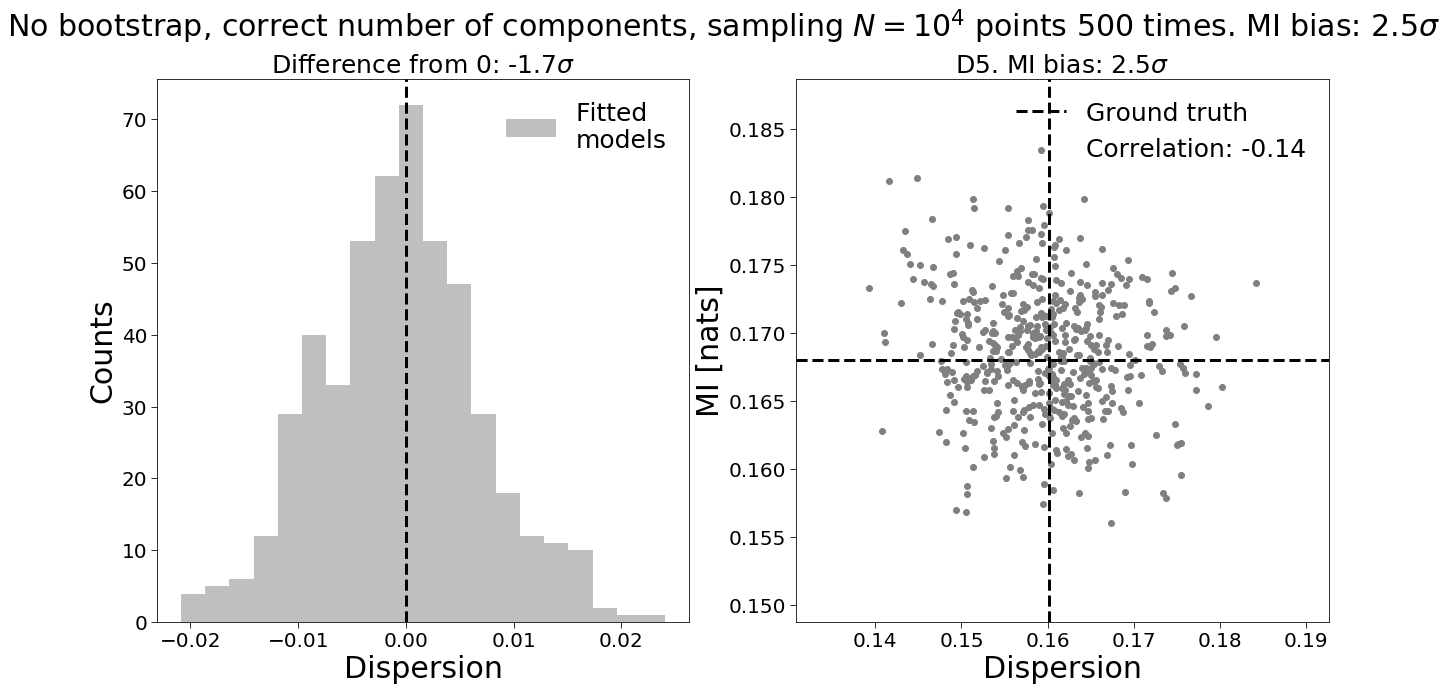

In [126]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 10))

bins=20
alpha=0.5
legendsize=25

ax1.hist(ds - d_true, alpha=alpha, bins=bins, 
         label=f'Fitted\nmodels', color='grey')
ax1.set_title(f'Difference from 0: {bias_d:.1f}$\sigma$', fontsize=25)

ax1.axvline(0, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper right')
ax1.set_xlabel('Dispersion', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)


ax2.scatter(ds, mi_mc, color='grey', label=f'Correlation: {np.corrcoef(ds, mi_mc)[0, 1]:.2f}')
#ax2.set_title(f'Difference from 0: {bias_dx:.1f}$\sigma$', fontsize=25)
ax2.axhline(analytic, ls='--', lw=3, c='k', label='Ground truth')
ax2.axvline(d_true, ls='--', lw=3, c='k')

ax2.set_xlabel('Dispersion', fontsize=30)
ax2.set_ylabel('MI [nats]', fontsize=30)

ax2.set_title(f'D5. MI bias: {bias_sigma_mc:.1f}$\sigma$', fontsize=25)


#ax2.axvline(0, ls='--', lw=3, c='k')
ax2.tick_params(axis='both', which='major', labelsize=20, size=6)
ax2.legend(fontsize=legendsize, frameon=False)


plt.suptitle(f'No bootstrap, correct number of components, sampling $N=10^4$ points {last_id} times. MI bias: {bias_sigma_mc:.1f}$\sigma$', fontsize=30);

In [127]:
all_MI_estimates = np.load('./D5p_bias_test_dispersion_MI_check.npy')
all_ds = np.load('./D5p_bias_test_dispersion_ds_check.npy')
analytic = 0.17972193484434484

last_id = 500#np.where(all_MI_estimates == 0)[0][0] - 1

mi_mc = all_MI_estimates[:last_id, 0]
mi_exact = all_MI_estimates[:last_id, 1]
ds = all_ds[:last_id, 0]
ds_x = all_ds[:last_id, 1]
ds_y = all_ds[:last_id, 2]

d_true, d_x_true, d_y_true = (0.16010375000000004, 0.486, 0.336)

bias_sigma_mc = np.sqrt(last_id) * np.mean(mi_mc - analytic) / np.std(mi_mc - analytic)
bias_sigma_exact = np.sqrt(last_id) * np.mean(mi_exact - analytic) / np.std(mi_exact - analytic)

bias_d = np.sqrt(last_id) * np.mean(ds - d_true) / np.std(ds - d_true)
bias_dx = np.sqrt(last_id) * np.mean(ds_x - d_x_true) / np.std(ds_x - d_x_true)
bias_dy = np.sqrt(last_id) * np.mean(ds_y - d_y_true) / np.std(ds_y - d_y_true)

print(bias_sigma_mc, bias_sigma_exact, bias_d, bias_dx, bias_dy)

3.2685170759183597 2.929534695169922 -2.0689233795560957 0.1732748685137089 -2.245890478994522


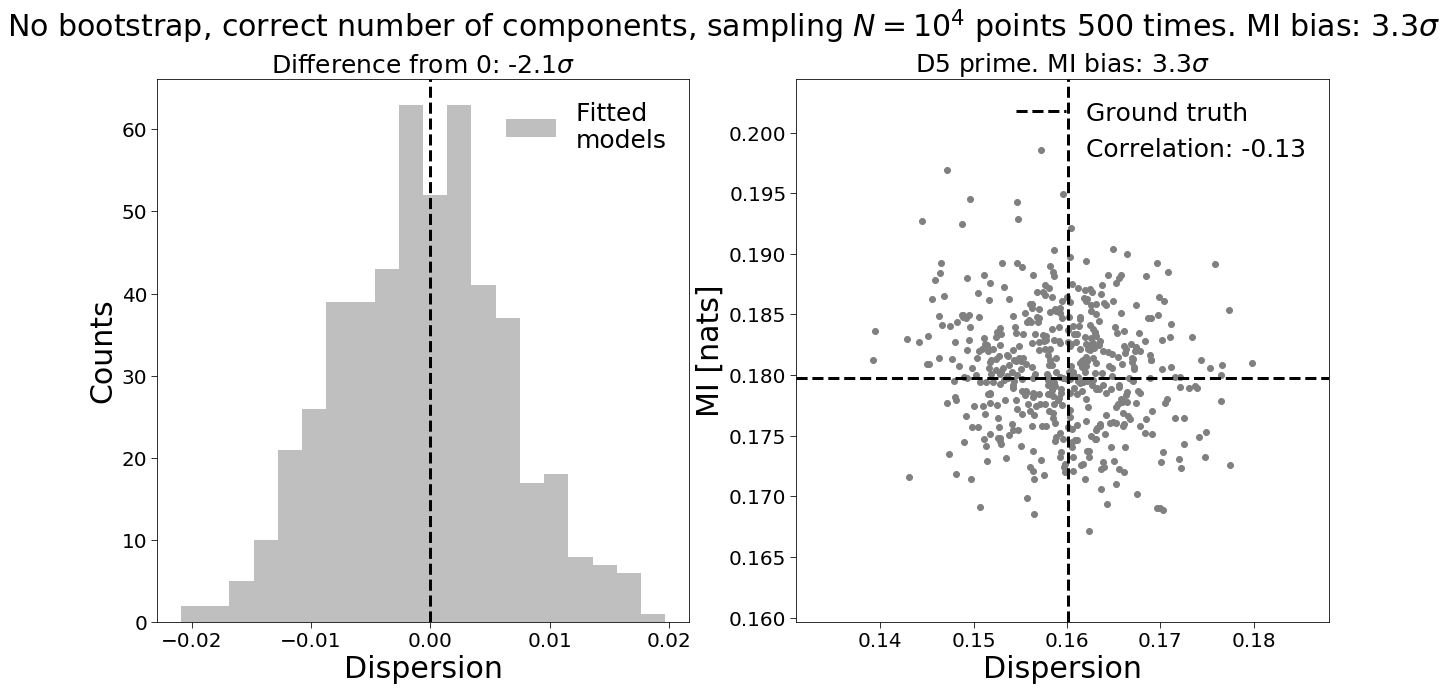

In [129]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 10))

bins=20
alpha=0.5
legendsize=25

ax1.hist(ds - d_true, alpha=alpha, bins=bins, 
         label=f'Fitted\nmodels', color='grey')
ax1.set_title(f'Difference from 0: {bias_d:.1f}$\sigma$', fontsize=25)

ax1.axvline(0, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper right')
ax1.set_xlabel('Dispersion', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)


ax2.scatter(ds, mi_mc, color='grey', label=f'Correlation: {np.corrcoef(ds, mi_mc)[0, 1]:.2f}')
#ax2.set_title(f'Difference from 0: {bias_dx:.1f}$\sigma$', fontsize=25)
ax2.axhline(analytic, ls='--', lw=3, c='k', label='Ground truth')
ax2.axvline(d_true, ls='--', lw=3, c='k')

ax2.set_xlabel('Dispersion', fontsize=30)
ax2.set_ylabel('MI [nats]', fontsize=30)

ax2.set_title(f'D5 prime. MI bias: {bias_sigma_mc:.1f}$\sigma$', fontsize=25)

#ax2.axvline(0, ls='--', lw=3, c='k')
ax2.tick_params(axis='both', which='major', labelsize=20, size=6)
ax2.legend(fontsize=legendsize, frameon=False)


plt.suptitle(f'No bootstrap, correct number of components, sampling $N=10^4$ points {last_id} times. MI bias: {bias_sigma_mc:.1f}$\sigma$', fontsize=30);

In [132]:
all_MI_estimates = np.load('./D3p_bias_test_dispersion_MI_check.npy')
all_ds = np.load('./D3p_bias_test_dispersion_ds_check.npy')
analytic =  0.38881453368446306

last_id = 500#np.where(all_MI_estimates == 0)[0][0] - 1

mi_mc = all_MI_estimates[:last_id, 0]
mi_exact = all_MI_estimates[:last_id, 1]
ds = all_ds[:last_id, 0]
ds_x = all_ds[:last_id, 1]
ds_y = all_ds[:last_id, 2]

d_true, d_x_true, d_y_true = 0.14349375000000003, 0.55, 0.28

bias_sigma_mc = np.sqrt(last_id) * np.mean(mi_mc - analytic) / np.std(mi_mc - analytic)
bias_sigma_exact = np.sqrt(last_id) * np.mean(mi_exact - analytic) / np.std(mi_exact - analytic)

bias_d = np.sqrt(last_id) * np.mean(ds - d_true) / np.std(ds - d_true)
bias_dx = np.sqrt(last_id) * np.mean(ds_x - d_x_true) / np.std(ds_x - d_x_true)
bias_dy = np.sqrt(last_id) * np.mean(ds_y - d_y_true) / np.std(ds_y - d_y_true)

print(bias_sigma_mc, bias_sigma_exact, bias_d, bias_dx, bias_dy)

6.699212836895975 2.644608220933445 -1.3854731598316772 0.07761217889755463 -1.78542945893493


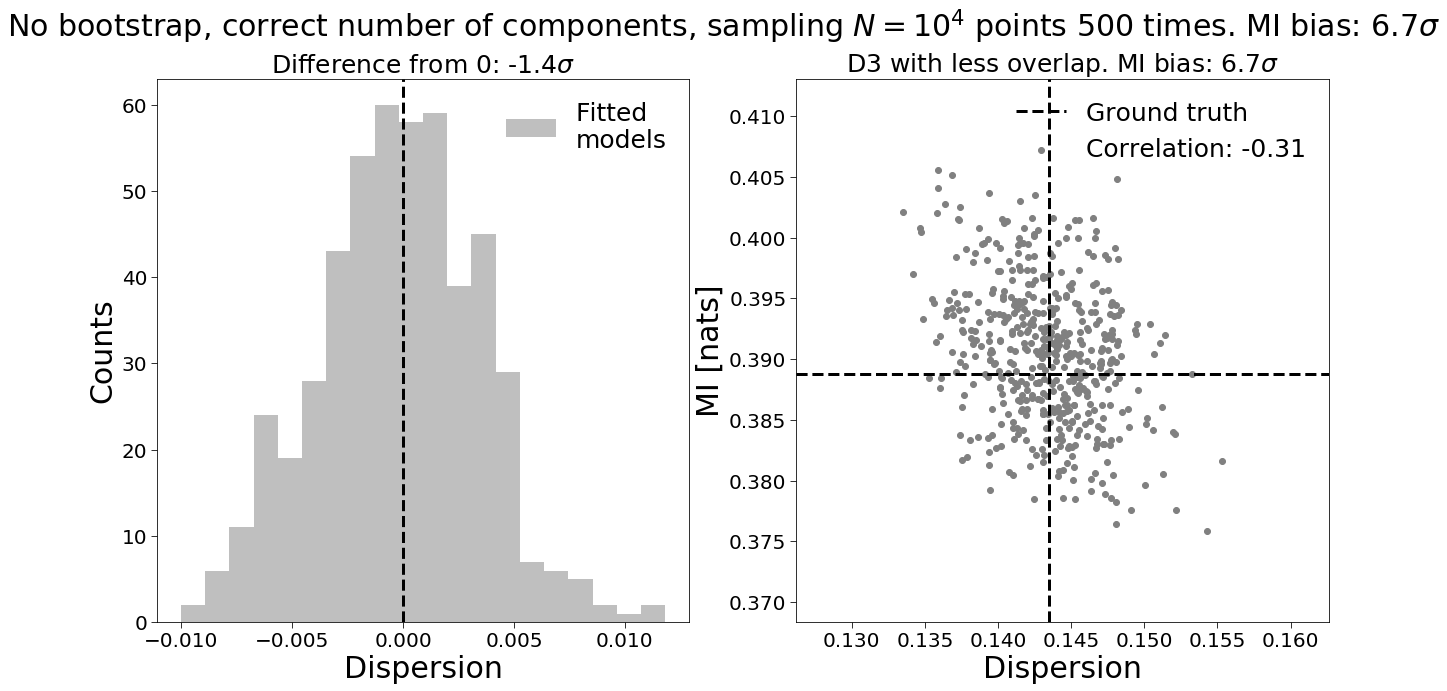

In [133]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 10))

bins=20
alpha=0.5
legendsize=25

ax1.hist(ds - d_true, alpha=alpha, bins=bins, 
         label=f'Fitted\nmodels', color='grey')
ax1.set_title(f'Difference from 0: {bias_d:.1f}$\sigma$', fontsize=25)

ax1.axvline(0, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper right')
ax1.set_xlabel('Dispersion', fontsize=30)
ax1.set_ylabel('Counts', fontsize=30)


ax2.scatter(ds, mi_mc, color='grey', label=f'Correlation: {np.corrcoef(ds, mi_mc)[0, 1]:.2f}')
#ax2.set_title(f'Difference from 0: {bias_dx:.1f}$\sigma$', fontsize=25)
ax2.axhline(analytic, ls='--', lw=3, c='k', label='Ground truth')
ax2.axvline(d_true, ls='--', lw=3, c='k')

ax2.set_xlabel('Dispersion', fontsize=30)
ax2.set_ylabel('MI [nats]', fontsize=30)

ax2.set_title(f'D3 with less overlap. MI bias: {bias_sigma_mc:.1f}$\sigma$', fontsize=25)


#ax2.axvline(0, ls='--', lw=3, c='k')
ax2.tick_params(axis='both', which='major', labelsize=20, size=6)
ax2.legend(fontsize=legendsize, frameon=False, loc='upper right')


plt.suptitle(f'No bootstrap, correct number of components, sampling $N=10^4$ points {last_id} times. MI bias: {bias_sigma_mc:.1f}$\sigma$', fontsize=30);

### Check if with a simpler start we remove MI bias

In [118]:
# todo

500


Text(0.5, 0.98, 'Simple start, 500 trials, D3.')

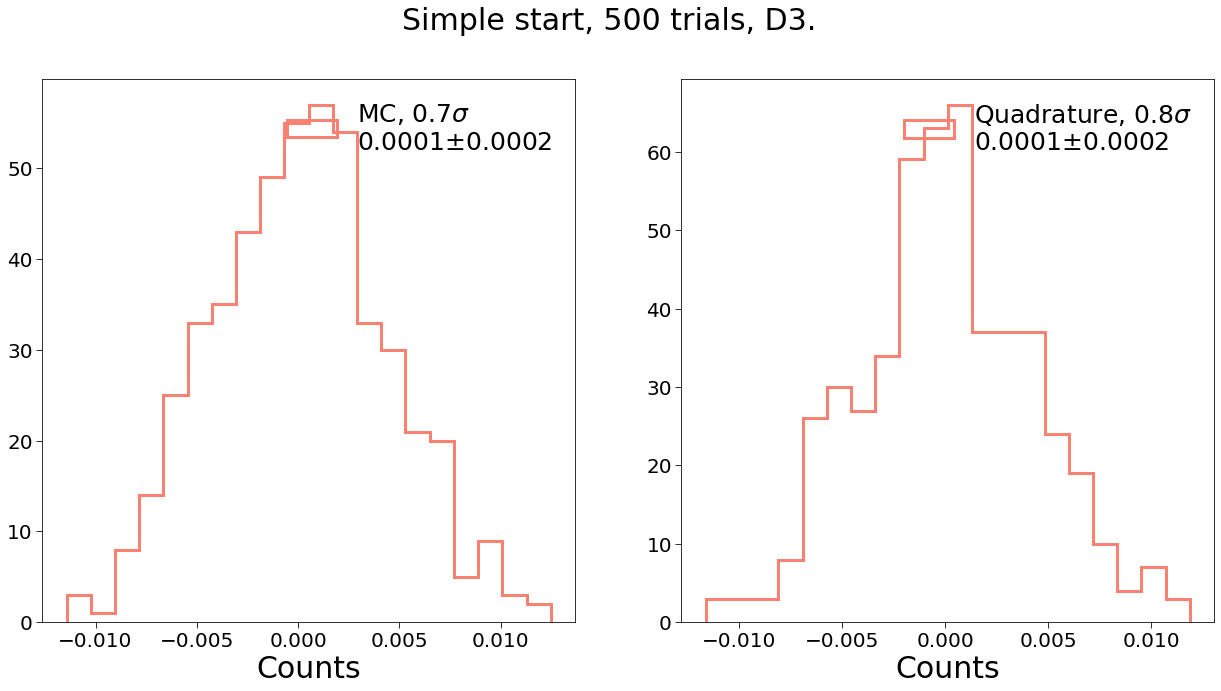

In [119]:
all_MI_estimates = np.load('./D3_bias_test_MI_simplestart.npy')

analytic = np.load('./mine-pytorch/mine/D3_analytic_MC.npy')

last_id = 500#np.where(all_MI_estimates == 0)[1][0] - 1
print(last_id)

all_MI_estimates = all_MI_estimates[:last_id, :]
all_MI_estimates = all_MI_estimates - analytic

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 10))

bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, 0].flatten(), alpha=1, bins=bins, 
         label=f'MC, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 0])) / (np.std(all_MI_estimates[:last_id, 0])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 0]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 0])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)

ax2.hist(all_MI_estimates[:last_id, 1].flatten(), alpha=1, bins=bins, 
         label=f'Quadrature, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1])) / (np.std(all_MI_estimates[:last_id, 1])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 1]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 1])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)




#ax1.axhline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False)
ax1.set_xlabel('MI [nats]', fontsize=30)
ax1.set_xlabel('Counts', fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=20, size=6)
ax2.legend(fontsize=legendsize, frameon=False)
ax2.set_xlabel('MI [nats]', fontsize=30)
ax2.set_xlabel('Counts', fontsize=30)

plt.suptitle('Simple start, 500 trials, D3.', fontsize=30)

#ax1.set_xticks(np.arange(5))
#ax1.set_xticklabels([1000, 5000, 10000, 50000, 100000]);

500


Text(0.5, 0.98, 'Simple start, 500 trials, D5.')

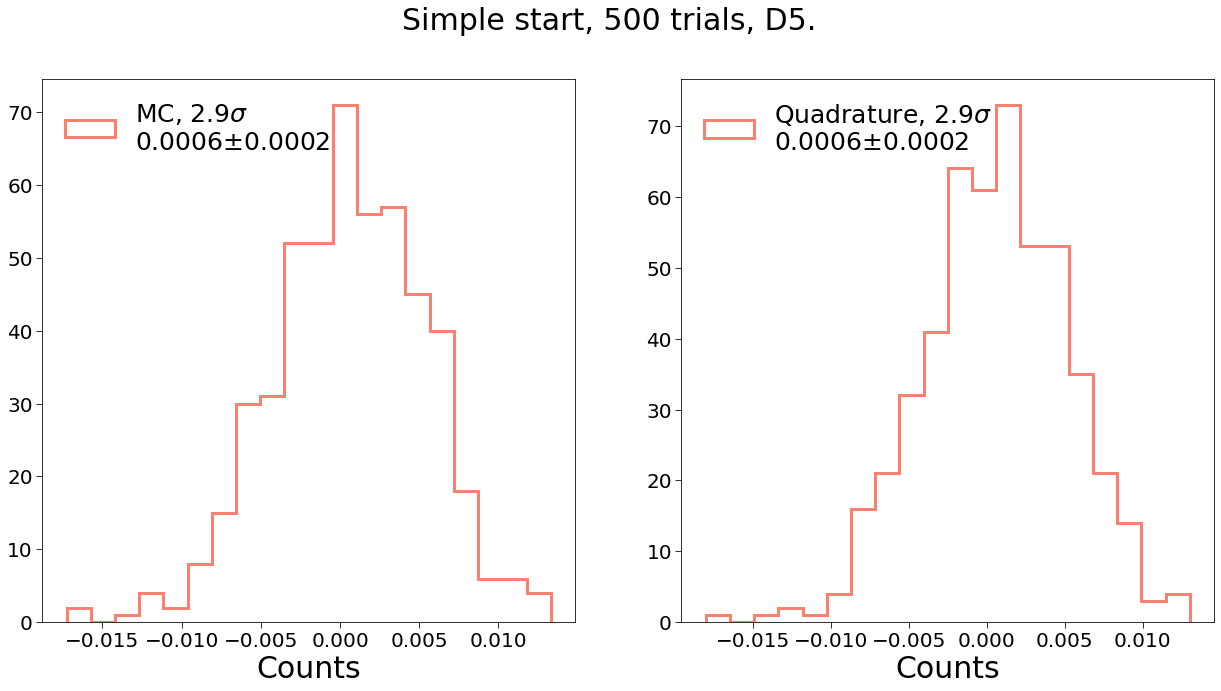

In [51]:
all_MI_estimates = np.load('./D5_bias_test_MI_simplestart.npy')

analytic = np.load('./mine-pytorch/mine/D5_analytic_MC.npy')

last_id = 500#np.where(all_MI_estimates == 0)[1][0] - 1
print(last_id)

all_MI_estimates = all_MI_estimates[:last_id, :]
all_MI_estimates = all_MI_estimates - analytic

all_MI_estimates[all_MI_estimates<-0.02] = 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 10))

bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, 0].flatten(), alpha=1, bins=bins, 
         label=f'MC, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 0])) / (np.std(all_MI_estimates[:last_id, 0])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 0]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 0])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)

ax2.hist(all_MI_estimates[:last_id, 1].flatten(), alpha=1, bins=bins, 
         label=f'Quadrature, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1])) / (np.std(all_MI_estimates[:last_id, 1])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 1]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 1])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)




#ax1.axhline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('MI [nats]', fontsize=30)
ax1.set_xlabel('Counts', fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=20, size=6)
ax2.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax2.set_xlabel('MI [nats]', fontsize=30)
ax2.set_xlabel('Counts', fontsize=30)

plt.suptitle('Simple start, 500 trials, D5.', fontsize=30)

#ax1.set_xticks(np.arange(5))
#ax1.set_xticklabels([1000, 5000, 10000, 50000, 100000]);

500


Text(0.5, 0.98, 'Simple start, 500 trials, D5.')

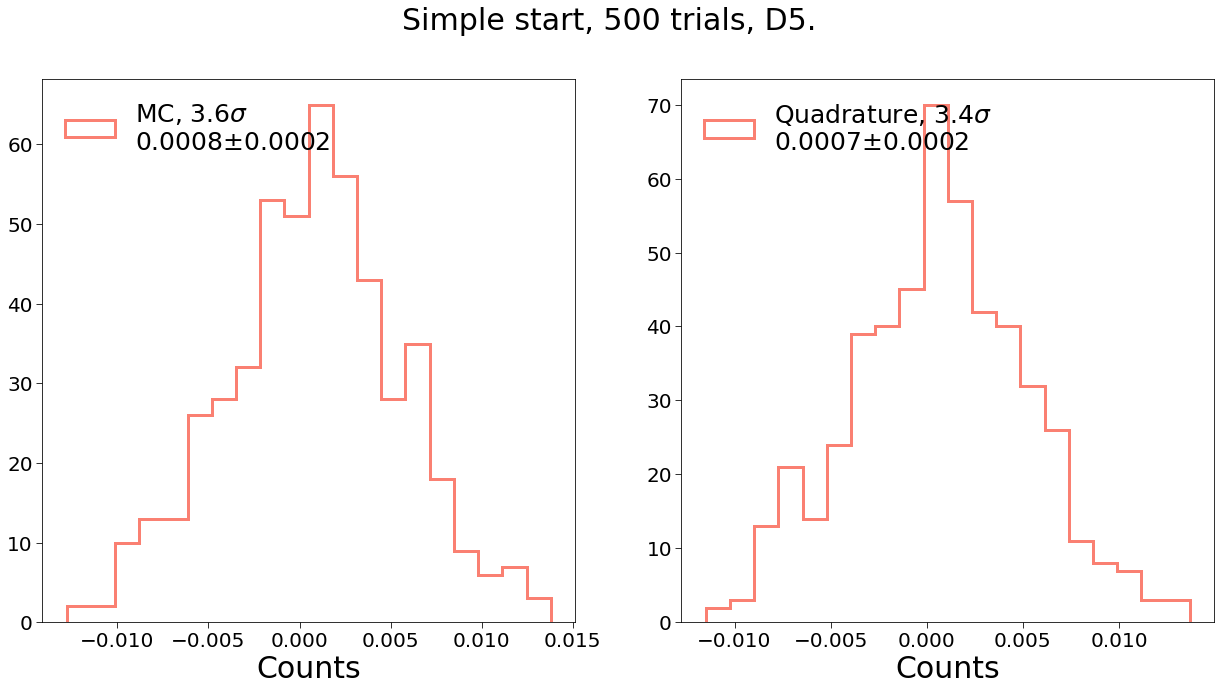

In [123]:
all_MI_estimates = np.load('./D5p_bias_test_MI_simplestart.npy')

analytic = np.load('./mine-pytorch/mine/D5p_analytic_MC.npy')

last_id = 500#np.where(all_MI_estimates == 0)[1][0] - 1
print(last_id)

all_MI_estimates = all_MI_estimates[:last_id, :]
all_MI_estimates = all_MI_estimates - analytic

all_MI_estimates[all_MI_estimates<-0.02] = 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 10))

bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, 0].flatten(), alpha=1, bins=bins, 
         label=f'MC, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 0])) / (np.std(all_MI_estimates[:last_id, 0])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 0]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 0])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)

ax2.hist(all_MI_estimates[:last_id, 1].flatten(), alpha=1, bins=bins, 
         label=f'Quadrature, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1])) / (np.std(all_MI_estimates[:last_id, 1])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 1]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 1])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)




#ax1.axhline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('MI [nats]', fontsize=30)
ax1.set_xlabel('Counts', fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=20, size=6)
ax2.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax2.set_xlabel('MI [nats]', fontsize=30)
ax2.set_xlabel('Counts', fontsize=30)

plt.suptitle('Simple start, 500 trials, D5.', fontsize=30)

#ax1.set_xticks(np.arange(5))
#ax1.set_xticklabels([1000, 5000, 10000, 50000, 100000]);

500


Text(0.5, 0.98, 'Simple start, 500 trials, D3 prime.')

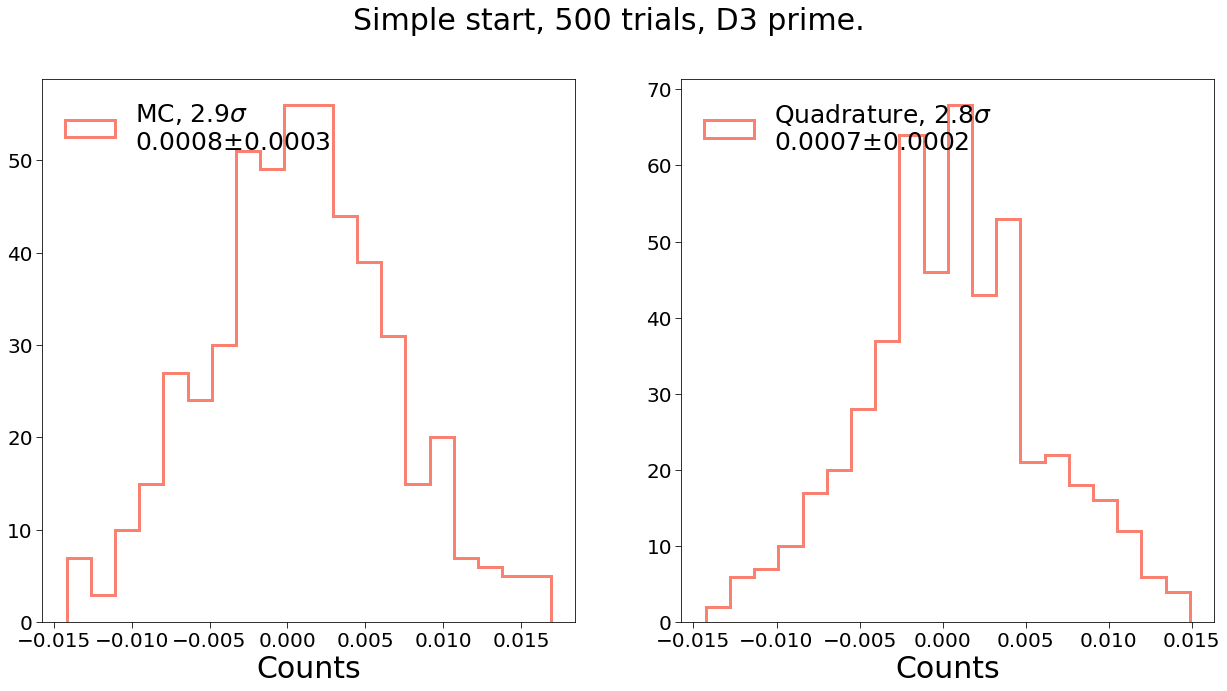

In [124]:
all_MI_estimates = np.load('./D3p_bias_test_MI_simplestart.npy')

analytic = np.load('./mine-pytorch/mine/D3p_analytic_MC.npy')

last_id = 500#np.where(all_MI_estimates == 0)[1][0] - 1
print(last_id)

all_MI_estimates = all_MI_estimates[:last_id, :]
all_MI_estimates = all_MI_estimates - analytic

#all_MI_estimates = all_MI_estimates[all_MI_estimates[:, 0]>-0.02, 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 10))

bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, 0].flatten(), alpha=1, bins=bins, 
         label=f'MC, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 0])) / (np.std(all_MI_estimates[:last_id, 0])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 0]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 0])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)

ax2.hist(all_MI_estimates[:last_id, 1].flatten(), alpha=1, bins=bins, 
         label=f'Quadrature, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1])) / (np.std(all_MI_estimates[:last_id, 1])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 1]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 1])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)




#ax1.axhline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('MI [nats]', fontsize=30)
ax1.set_xlabel('Counts', fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=20, size=6)
ax2.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax2.set_xlabel('MI [nats]', fontsize=30)
ax2.set_xlabel('Counts', fontsize=30)

plt.suptitle('Simple start, 500 trials, D3 prime.', fontsize=30)

#ax1.set_xticks(np.arange(5))
#ax1.set_xticklabels([1000, 5000, 10000, 50000, 100000]);

### Now we try changing from stopping on training data to validation data. It only changes the init step, so it shouldn't be much a problem - i.e., it should not change by much the final fit.

In [ ]:
# todo

500


Text(0.5, 0.98, 'Stop val, 500 trials, D3.')

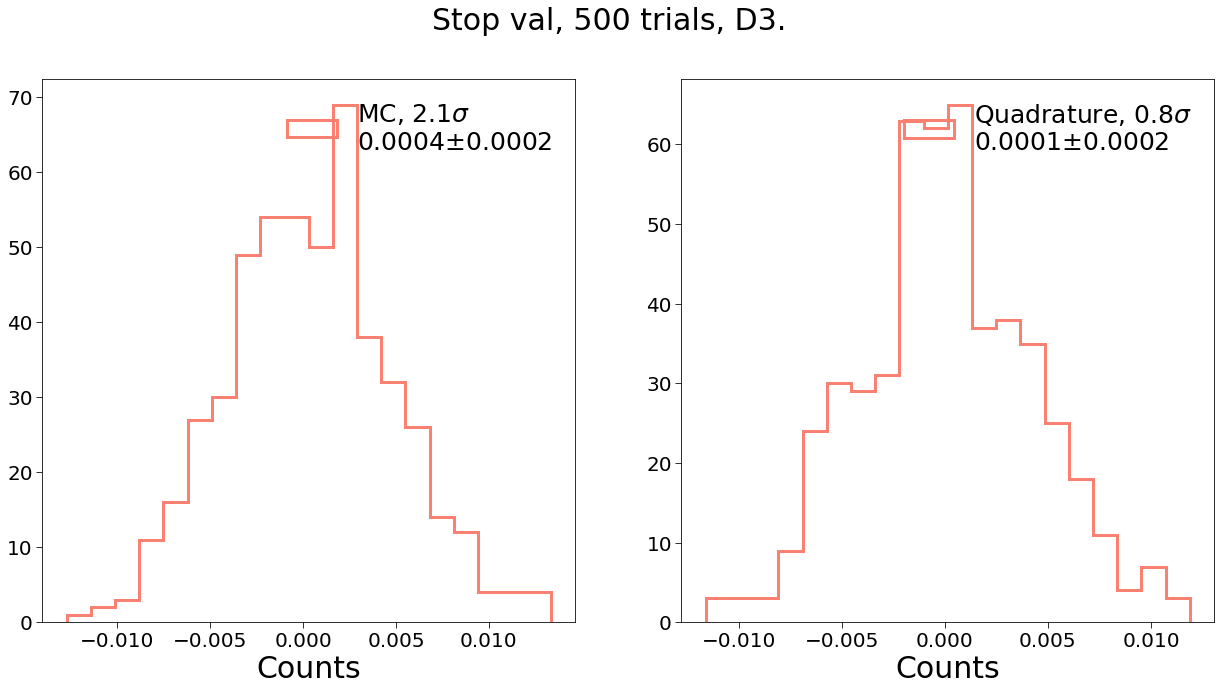

In [126]:
all_MI_estimates = np.load('./D3_bias_test_stopval.npy')

analytic = np.load('./mine-pytorch/mine/D3_analytic_MC.npy')

last_id = 500#np.where(all_MI_estimates == 0)[1][0] - 1
print(last_id)

all_MI_estimates = all_MI_estimates[:last_id, :]
all_MI_estimates = all_MI_estimates - analytic

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 10))

bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, 0].flatten(), alpha=1, bins=bins, 
         label=f'MC, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 0])) / (np.std(all_MI_estimates[:last_id, 0])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 0]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 0])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)

ax2.hist(all_MI_estimates[:last_id, 1].flatten(), alpha=1, bins=bins, 
         label=f'Quadrature, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1])) / (np.std(all_MI_estimates[:last_id, 1])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 1]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 1])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)




#ax1.axhline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False)
ax1.set_xlabel('MI [nats]', fontsize=30)
ax1.set_xlabel('Counts', fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=20, size=6)
ax2.legend(fontsize=legendsize, frameon=False)
ax2.set_xlabel('MI [nats]', fontsize=30)
ax2.set_xlabel('Counts', fontsize=30)

plt.suptitle('Stop val, 500 trials, D3.', fontsize=30)

#ax1.set_xticks(np.arange(5))
#ax1.set_xticklabels([1000, 5000, 10000, 50000, 100000]);

500


Text(0.5, 0.98, 'Stop val, 500 trials, D5.')

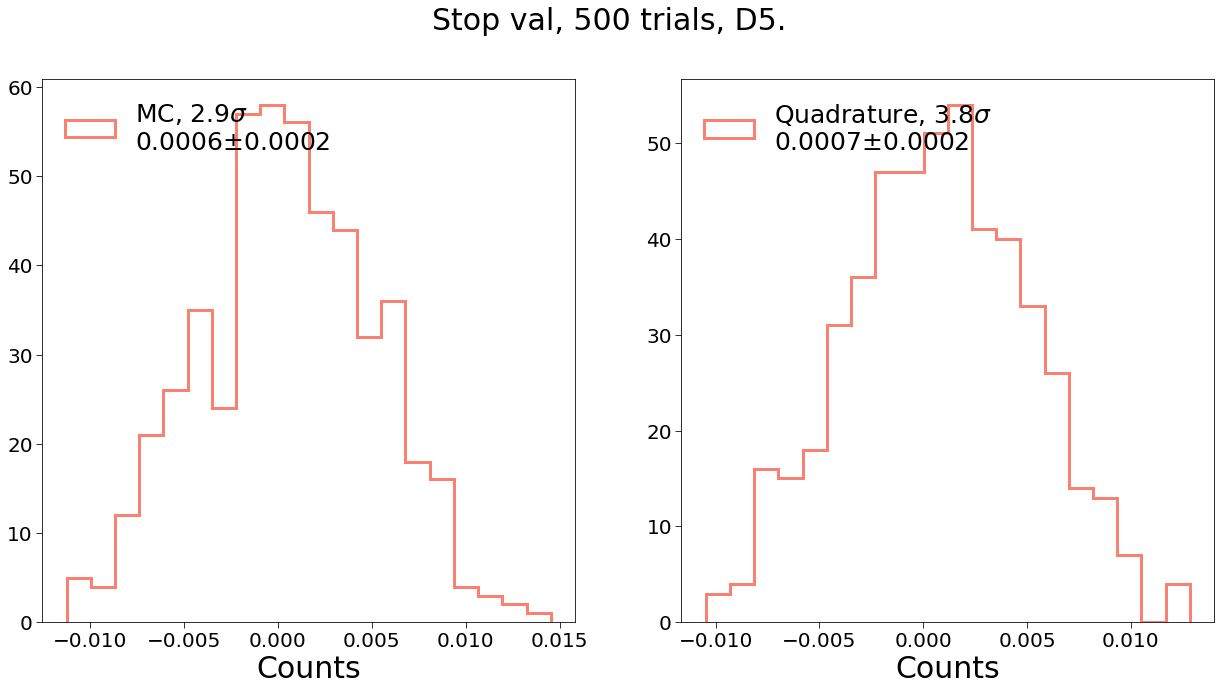

In [127]:
all_MI_estimates = np.load('./D5_bias_test_stopval.npy')

analytic = np.load('./mine-pytorch/mine/D5_analytic_MC.npy')

last_id = 500#np.where(all_MI_estimates == 0)[1][0] - 1
print(last_id)

all_MI_estimates = all_MI_estimates[:last_id, :]
all_MI_estimates = all_MI_estimates - analytic

#all_MI_estimates[all_MI_estimates<-0.02] = 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 10))

bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, 0].flatten(), alpha=1, bins=bins, 
         label=f'MC, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 0])) / (np.std(all_MI_estimates[:last_id, 0])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 0]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 0])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)

ax2.hist(all_MI_estimates[:last_id, 1].flatten(), alpha=1, bins=bins, 
         label=f'Quadrature, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1])) / (np.std(all_MI_estimates[:last_id, 1])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 1]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 1])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)




#ax1.axhline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('MI [nats]', fontsize=30)
ax1.set_xlabel('Counts', fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=20, size=6)
ax2.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax2.set_xlabel('MI [nats]', fontsize=30)
ax2.set_xlabel('Counts', fontsize=30)

plt.suptitle('Stop val, 500 trials, D5.', fontsize=30)

#ax1.set_xticks(np.arange(5))
#ax1.set_xticklabels([1000, 5000, 10000, 50000, 100000]);

500


Text(0.5, 0.98, 'Stop val, 500 trials, D5 prime.')

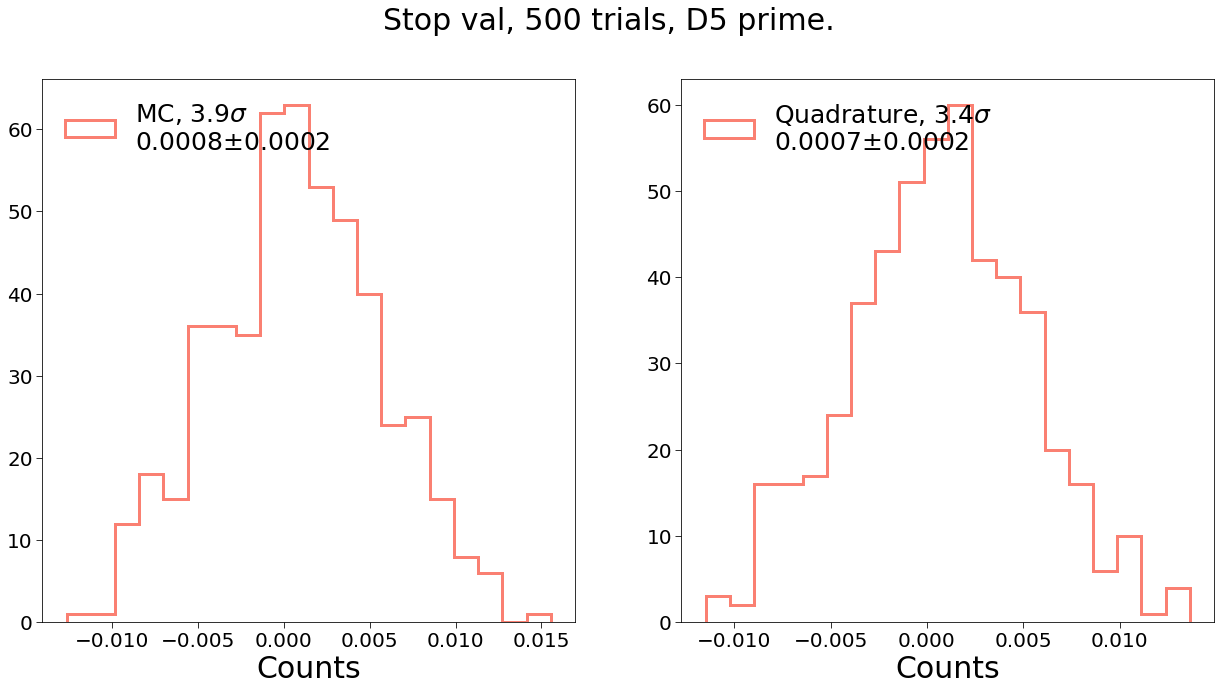

In [128]:
all_MI_estimates = np.load('./D5p_bias_test_stopval.npy')

analytic = np.load('./mine-pytorch/mine/D5p_analytic_MC.npy')

last_id = 500#np.where(all_MI_estimates == 0)[1][0] - 1
print(last_id)

all_MI_estimates = all_MI_estimates[:last_id, :]
all_MI_estimates = all_MI_estimates - analytic

#all_MI_estimates[all_MI_estimates<-0.02] = 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 10))

bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, 0].flatten(), alpha=1, bins=bins, 
         label=f'MC, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 0])) / (np.std(all_MI_estimates[:last_id, 0])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 0]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 0])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)

ax2.hist(all_MI_estimates[:last_id, 1].flatten(), alpha=1, bins=bins, 
         label=f'Quadrature, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1])) / (np.std(all_MI_estimates[:last_id, 1])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 1]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 1])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)




#ax1.axhline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('MI [nats]', fontsize=30)
ax1.set_xlabel('Counts', fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=20, size=6)
ax2.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax2.set_xlabel('MI [nats]', fontsize=30)
ax2.set_xlabel('Counts', fontsize=30)

plt.suptitle('Stop val, 500 trials, D5 prime.', fontsize=30)

#ax1.set_xticks(np.arange(5))
#ax1.set_xticklabels([1000, 5000, 10000, 50000, 100000]);

500


Text(0.5, 0.98, 'Stop val, 500 trials, D3 prime.')

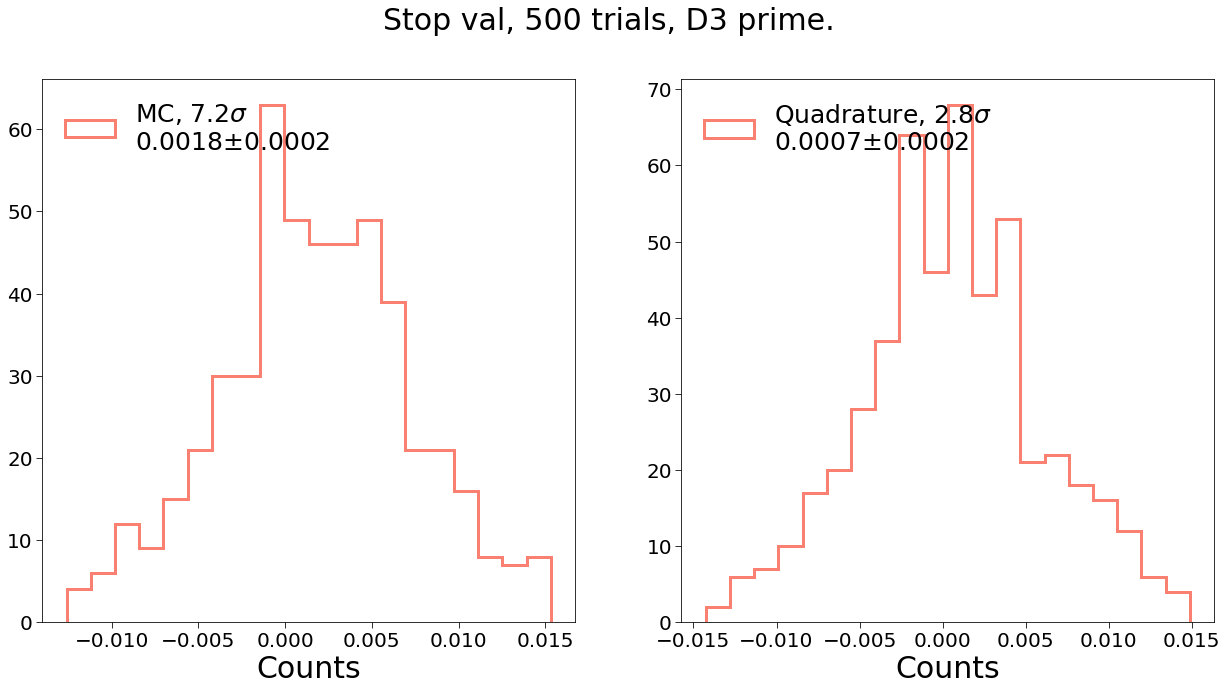

In [129]:
all_MI_estimates = np.load('./D3p_bias_test_stopval.npy')

analytic = np.load('./mine-pytorch/mine/D3p_analytic_MC.npy')

last_id = 500#np.where(all_MI_estimates == 0)[1][0] - 1
print(last_id)

all_MI_estimates = all_MI_estimates[:last_id, :]
all_MI_estimates = all_MI_estimates - analytic

#all_MI_estimates = all_MI_estimates[all_MI_estimates[:, 0]>-0.02, 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 10))

bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, 0].flatten(), alpha=1, bins=bins, 
         label=f'MC, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 0])) / (np.std(all_MI_estimates[:last_id, 0])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 0]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 0])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)

ax2.hist(all_MI_estimates[:last_id, 1].flatten(), alpha=1, bins=bins, 
         label=f'Quadrature, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1])) / (np.std(all_MI_estimates[:last_id, 1])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 1]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 1])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)




#ax1.axhline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('MI [nats]', fontsize=30)
ax1.set_xlabel('Counts', fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=20, size=6)
ax2.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax2.set_xlabel('MI [nats]', fontsize=30)
ax2.set_xlabel('Counts', fontsize=30)

plt.suptitle('Stop val, 500 trials, D3 prime.', fontsize=30)

#ax1.set_xticks(np.arange(5))
#ax1.set_xticklabels([1000, 5000, 10000, 50000, 100000]);

### Check if a different init on D3' changes anything

In [152]:
# todo

500


Text(0.5, 0.98, 'Stop val, 500 trials, D3.')

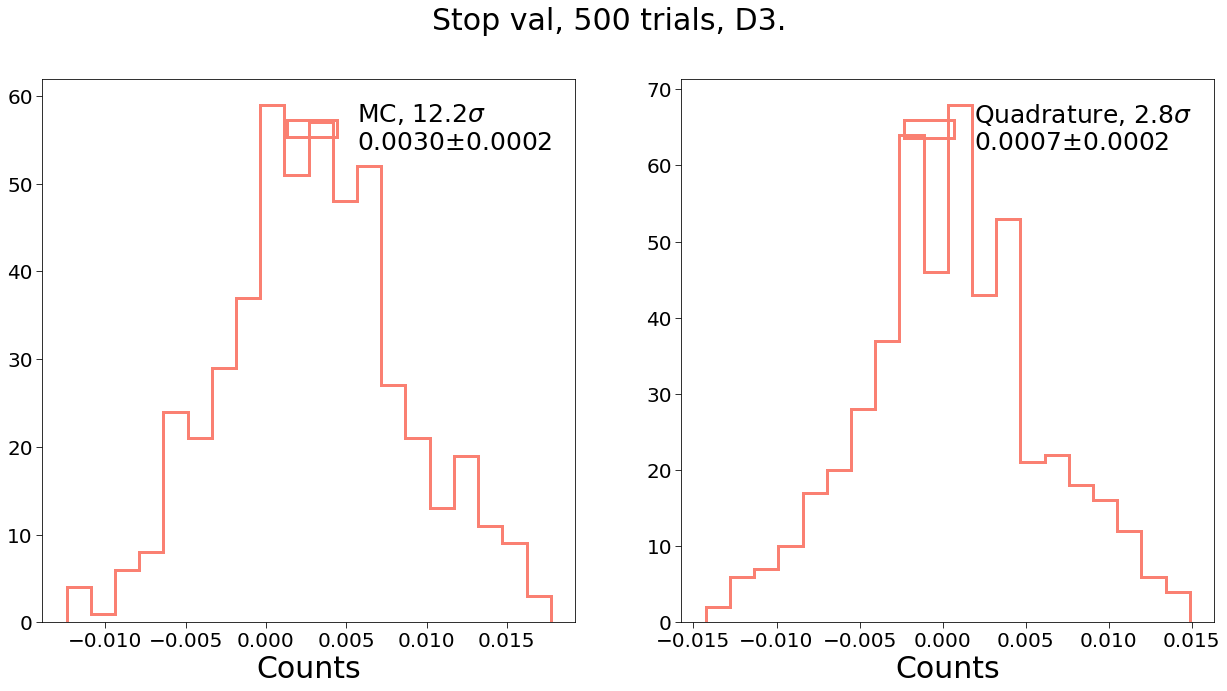

In [163]:
all_MI_estimates = np.load('./D3p_bias_test_kmeans_sklearn.npy')

analytic = np.load('./mine-pytorch/mine/D3p_analytic_MC.npy')

last_id = 500#np.where(all_MI_estimates == 0)[1][0] - 1
print(last_id)

all_MI_estimates = all_MI_estimates[:last_id, :]
all_MI_estimates = all_MI_estimates - analytic

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 10))

bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, 0].flatten(), alpha=1, bins=bins, 
         label=f'MC, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 0])) / (np.std(all_MI_estimates[:last_id, 0])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 0]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 0])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)

ax2.hist(all_MI_estimates[:last_id, 1].flatten(), alpha=1, bins=bins, 
         label=f'Quadrature, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1])) / (np.std(all_MI_estimates[:last_id, 1])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 1]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 1])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)




#ax1.axhline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False)
ax1.set_xlabel('MI [nats]', fontsize=30)
ax1.set_xlabel('Counts', fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=20, size=6)
ax2.legend(fontsize=legendsize, frameon=False)
ax2.set_xlabel('MI [nats]', fontsize=30)
ax2.set_xlabel('Counts', fontsize=30)

plt.suptitle('Stop val, 500 trials, D3.', fontsize=30)

#ax1.set_xticks(np.arange(5))
#ax1.set_xticklabels([1000, 5000, 10000, 50000, 100000]);

500


Text(0.5, 0.98, 'Stop val, 500 trials, D5.')

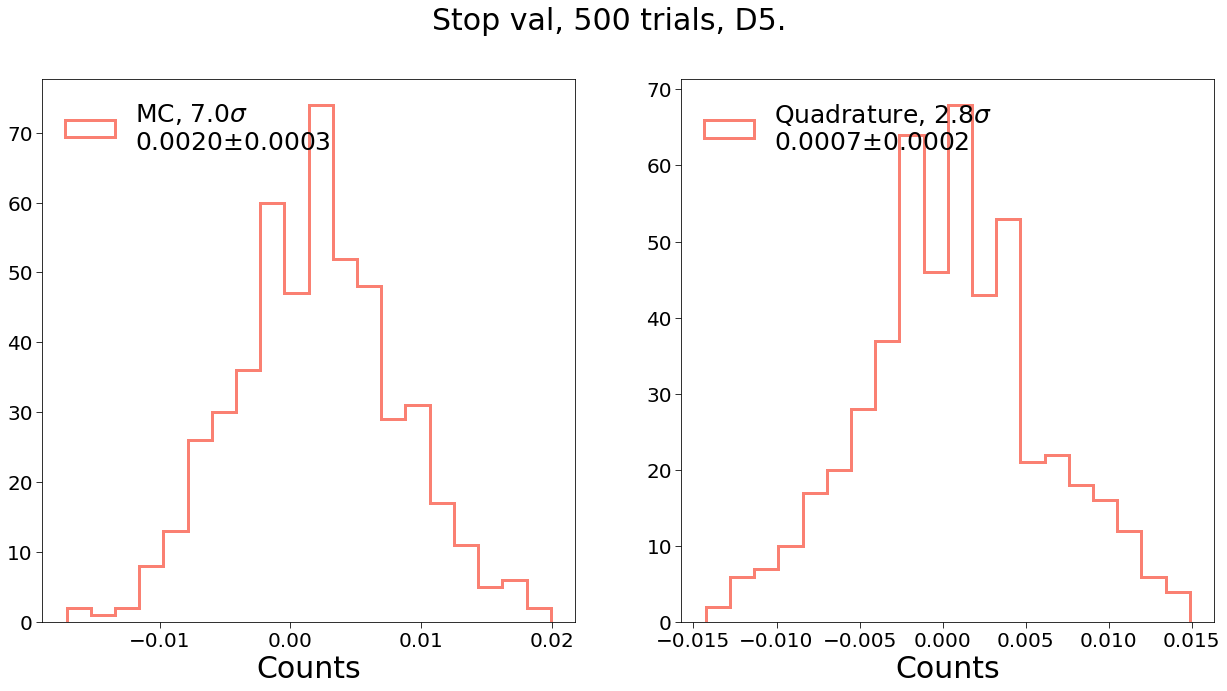

In [164]:
all_MI_estimates = np.load('./D3p_bias_test_random.npy')

analytic = np.load('./mine-pytorch/mine/D3p_analytic_MC.npy')

last_id = 500#np.where(all_MI_estimates == 0)[1][0] - 1
print(last_id)

all_MI_estimates = all_MI_estimates[:last_id, :]
all_MI_estimates = all_MI_estimates - analytic

#all_MI_estimates[all_MI_estimates<-0.02] = 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 10))

bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, 0].flatten(), alpha=1, bins=bins, 
         label=f'MC, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 0])) / (np.std(all_MI_estimates[:last_id, 0])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 0]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 0])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)

ax2.hist(all_MI_estimates[:last_id, 1].flatten(), alpha=1, bins=bins, 
         label=f'Quadrature, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1])) / (np.std(all_MI_estimates[:last_id, 1])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 1]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 1])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)




#ax1.axhline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('MI [nats]', fontsize=30)
ax1.set_xlabel('Counts', fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=20, size=6)
ax2.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax2.set_xlabel('MI [nats]', fontsize=30)
ax2.set_xlabel('Counts', fontsize=30)

plt.suptitle('Stop val, 500 trials, D5.', fontsize=30)

#ax1.set_xticks(np.arange(5))
#ax1.set_xticklabels([1000, 5000, 10000, 50000, 100000]);

500


Text(0.5, 0.98, 'Stop val, 500 trials, D5 prime.')

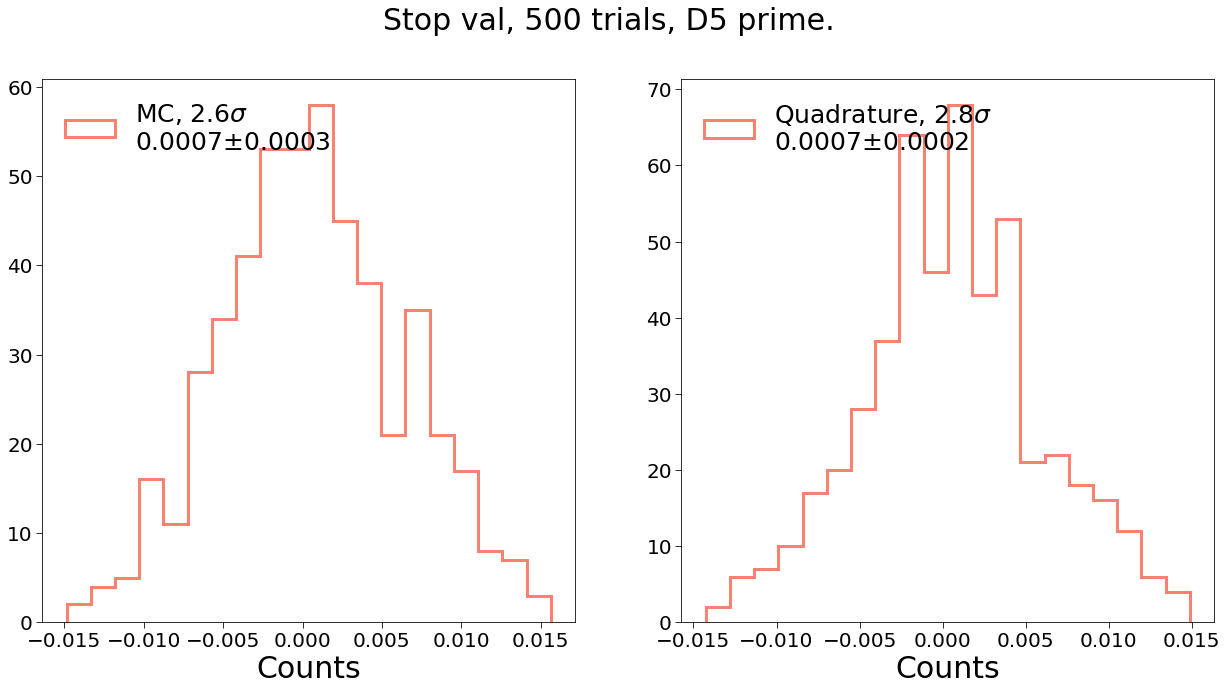

In [165]:
all_MI_estimates = np.load('./D3p_bias_test_minmax.npy')

analytic = np.load('./mine-pytorch/mine/D3p_analytic_MC.npy')

last_id = 500#np.where(all_MI_estimates == 0)[1][0] - 1
print(last_id)

all_MI_estimates = all_MI_estimates[:last_id, :]
all_MI_estimates = all_MI_estimates - analytic

#all_MI_estimates[all_MI_estimates<-0.02] = 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 10))

bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, 0].flatten(), alpha=1, bins=bins, 
         label=f'MC, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 0])) / (np.std(all_MI_estimates[:last_id, 0])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 0]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 0])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)

ax2.hist(all_MI_estimates[:last_id, 1].flatten(), alpha=1, bins=bins, 
         label=f'Quadrature, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1])) / (np.std(all_MI_estimates[:last_id, 1])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 1]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 1])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)




#ax1.axhline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('MI [nats]', fontsize=30)
ax1.set_xlabel('Counts', fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=20, size=6)
ax2.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax2.set_xlabel('MI [nats]', fontsize=30)
ax2.set_xlabel('Counts', fontsize=30)

plt.suptitle('Stop val, 500 trials, D5 prime.', fontsize=30)

#ax1.set_xticks(np.arange(5))
#ax1.set_xticklabels([1000, 5000, 10000, 50000, 100000]);

50


Text(0.5, 0.98, 'Stop val, 500 trials, D3 prime.')

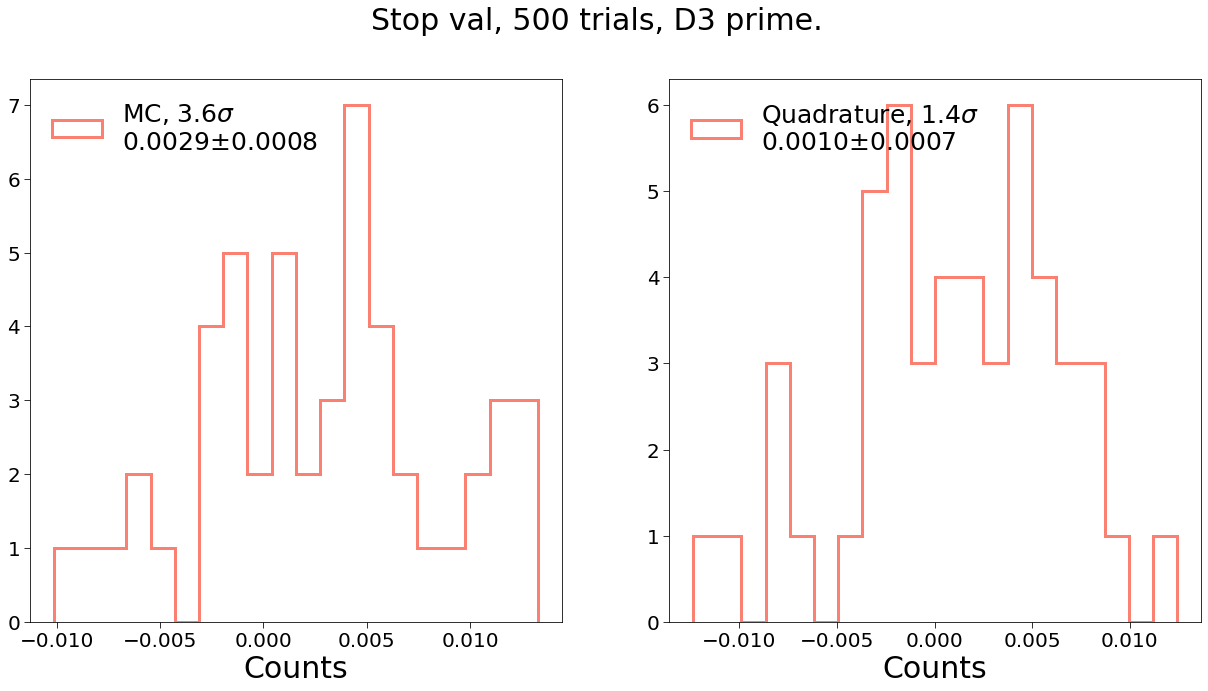

In [166]:
all_MI_estimates = np.load('./D3p_bias_test_kmeans.npy')

analytic = np.load('./mine-pytorch/mine/D3p_analytic_MC.npy')

last_id = 50#np.where(all_MI_estimates == 0)[1][0] - 1
print(last_id)

all_MI_estimates = all_MI_estimates[:last_id, :]
all_MI_estimates = all_MI_estimates - analytic

#all_MI_estimates = all_MI_estimates[all_MI_estimates[:, 0]>-0.02, 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 10))

bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, 0].flatten(), alpha=1, bins=bins, 
         label=f'MC, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 0])) / (np.std(all_MI_estimates[:last_id, 0])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 0]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 0])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)

ax2.hist(all_MI_estimates[:last_id, 1].flatten(), alpha=1, bins=bins, 
         label=f'Quadrature, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1])) / (np.std(all_MI_estimates[:last_id, 1])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 1]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 1])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)




#ax1.axhline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax1.set_xlabel('MI [nats]', fontsize=30)
ax1.set_xlabel('Counts', fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=20, size=6)
ax2.legend(fontsize=legendsize, frameon=False, loc='upper left')
ax2.set_xlabel('MI [nats]', fontsize=30)
ax2.set_xlabel('Counts', fontsize=30)

plt.suptitle('Stop val, 500 trials, D3 prime.', fontsize=30)

#ax1.set_xticks(np.arange(5))
#ax1.set_xticklabels([1000, 5000, 10000, 50000, 100000]);

### Check if final fit is done with a different optimiser

In [21]:
# todo

500


Text(0.5, 0.98, 'Stop val, 500 trials, D3.')

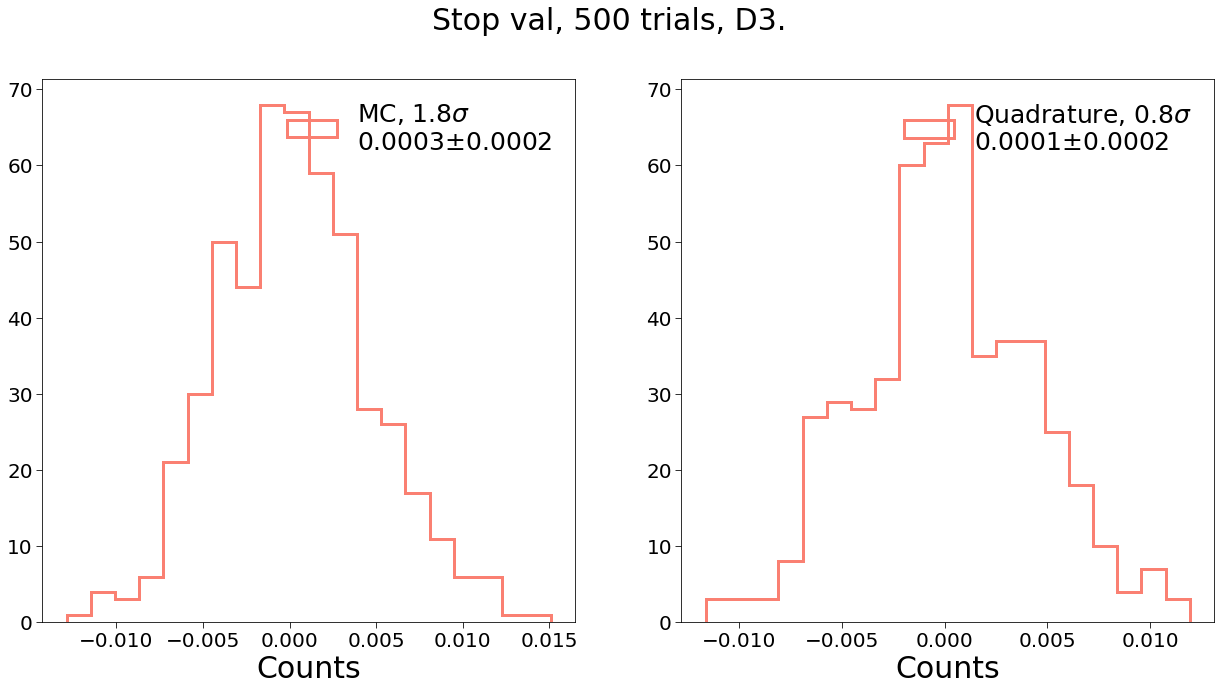

In [46]:
all_MI_estimates = np.load('./D3_bias_test_MI_diffopt.npy')

analytic = np.load('./mine-pytorch/mine/D3_analytic_MC.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0] - 1
print(last_id)

all_MI_estimates = all_MI_estimates[:last_id, :]
all_MI_estimates = all_MI_estimates - analytic

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 10))

bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, 0].flatten(), alpha=1, bins=bins, 
         label=f'MC, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 0])) / (np.std(all_MI_estimates[:last_id, 0])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 0]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 0])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)

ax2.hist(all_MI_estimates[:last_id, 1].flatten(), alpha=1, bins=bins, 
         label=f'Quadrature, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1])) / (np.std(all_MI_estimates[:last_id, 1])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 1]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 1])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)




#ax1.axhline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False)
ax1.set_xlabel('MI [nats]', fontsize=30)
ax1.set_xlabel('Counts', fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=20, size=6)
ax2.legend(fontsize=legendsize, frameon=False)
ax2.set_xlabel('MI [nats]', fontsize=30)
ax2.set_xlabel('Counts', fontsize=30)

plt.suptitle('Stop val, 500 trials, D3.', fontsize=30)

#ax1.set_xticks(np.arange(5))
#ax1.set_xticklabels([1000, 5000, 10000, 50000, 100000]);

500


Text(0.5, 0.98, 'Stop val, 500 trials, D3.')

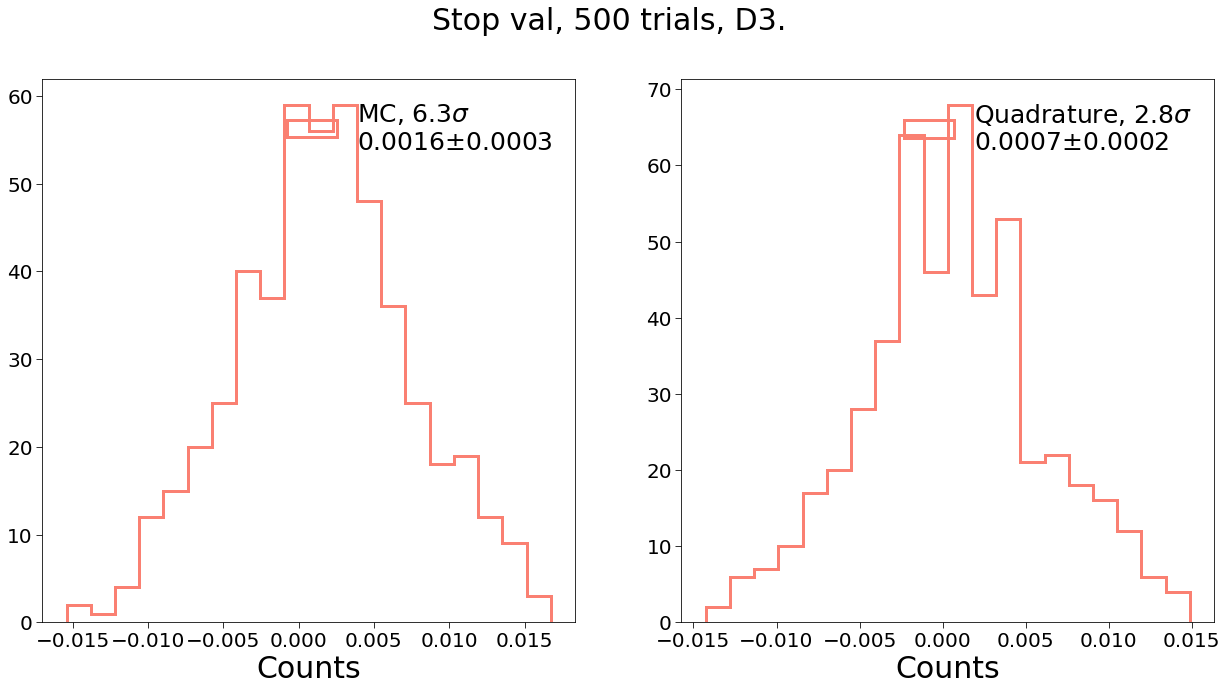

In [47]:
all_MI_estimates = np.load('./D3p_bias_test_MI_diffopt.npy')

analytic = np.load('./mine-pytorch/mine/D3p_analytic_MC.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0] - 1
print(last_id)

all_MI_estimates = all_MI_estimates[:last_id, :]
all_MI_estimates = all_MI_estimates - analytic

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 10))

bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, 0].flatten(), alpha=1, bins=bins, 
         label=f'MC, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 0])) / (np.std(all_MI_estimates[:last_id, 0])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 0]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 0])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)

ax2.hist(all_MI_estimates[:last_id, 1].flatten(), alpha=1, bins=bins, 
         label=f'Quadrature, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1])) / (np.std(all_MI_estimates[:last_id, 1])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 1]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 1])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)




#ax1.axhline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False)
ax1.set_xlabel('MI [nats]', fontsize=30)
ax1.set_xlabel('Counts', fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=20, size=6)
ax2.legend(fontsize=legendsize, frameon=False)
ax2.set_xlabel('MI [nats]', fontsize=30)
ax2.set_xlabel('Counts', fontsize=30)

plt.suptitle('Stop val, 500 trials, D3.', fontsize=30)

#ax1.set_xticks(np.arange(5))
#ax1.set_xticklabels([1000, 5000, 10000, 50000, 100000]);

500


Text(0.5, 0.98, 'Stop val, 500 trials, D3.')

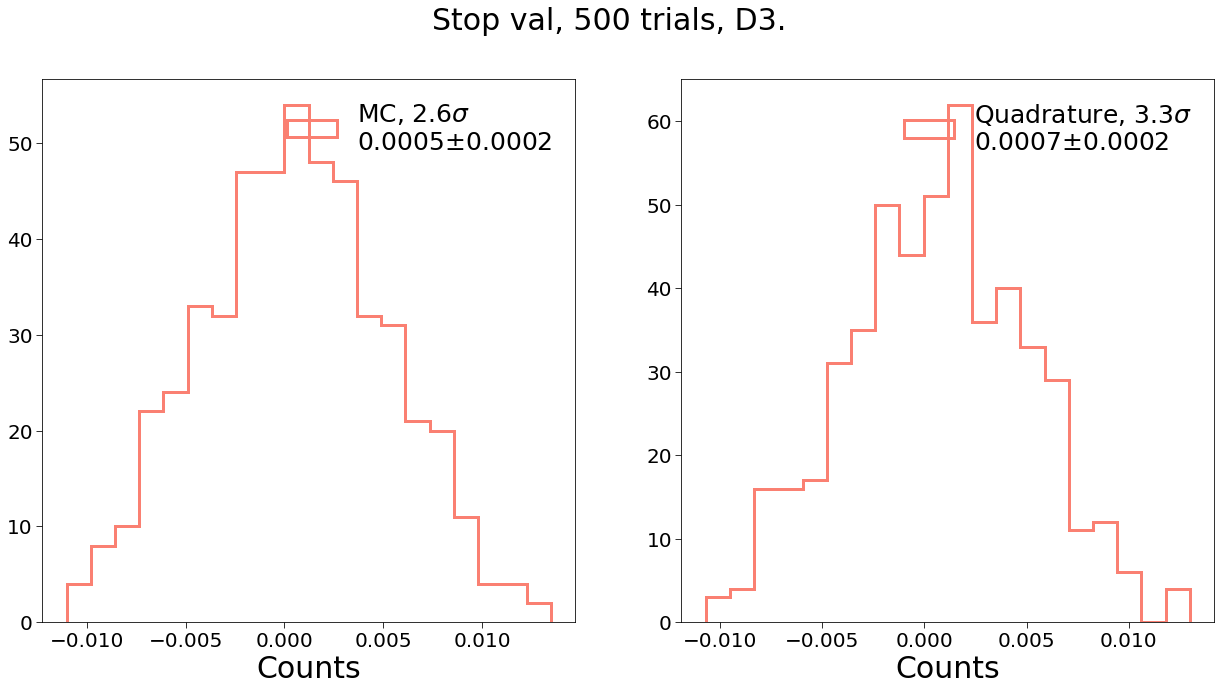

In [49]:
all_MI_estimates = np.load('./D5_bias_test_MI_diffopt.npy')

analytic = np.load('./mine-pytorch/mine/D5_analytic_MC.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0] - 1
print(last_id)

all_MI_estimates = all_MI_estimates[:last_id, :]
all_MI_estimates = all_MI_estimates - analytic

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 10))

bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, 0].flatten(), alpha=1, bins=bins, 
         label=f'MC, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 0])) / (np.std(all_MI_estimates[:last_id, 0])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 0]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 0])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)

ax2.hist(all_MI_estimates[:last_id, 1].flatten(), alpha=1, bins=bins, 
         label=f'Quadrature, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1])) / (np.std(all_MI_estimates[:last_id, 1])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 1]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 1])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)




#ax1.axhline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False)
ax1.set_xlabel('MI [nats]', fontsize=30)
ax1.set_xlabel('Counts', fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=20, size=6)
ax2.legend(fontsize=legendsize, frameon=False)
ax2.set_xlabel('MI [nats]', fontsize=30)
ax2.set_xlabel('Counts', fontsize=30)

plt.suptitle('Stop val, 500 trials, D3.', fontsize=30)

#ax1.set_xticks(np.arange(5))
#ax1.set_xticklabels([1000, 5000, 10000, 50000, 100000]);

500


Text(0.5, 0.98, 'Stop val, 500 trials, D3.')

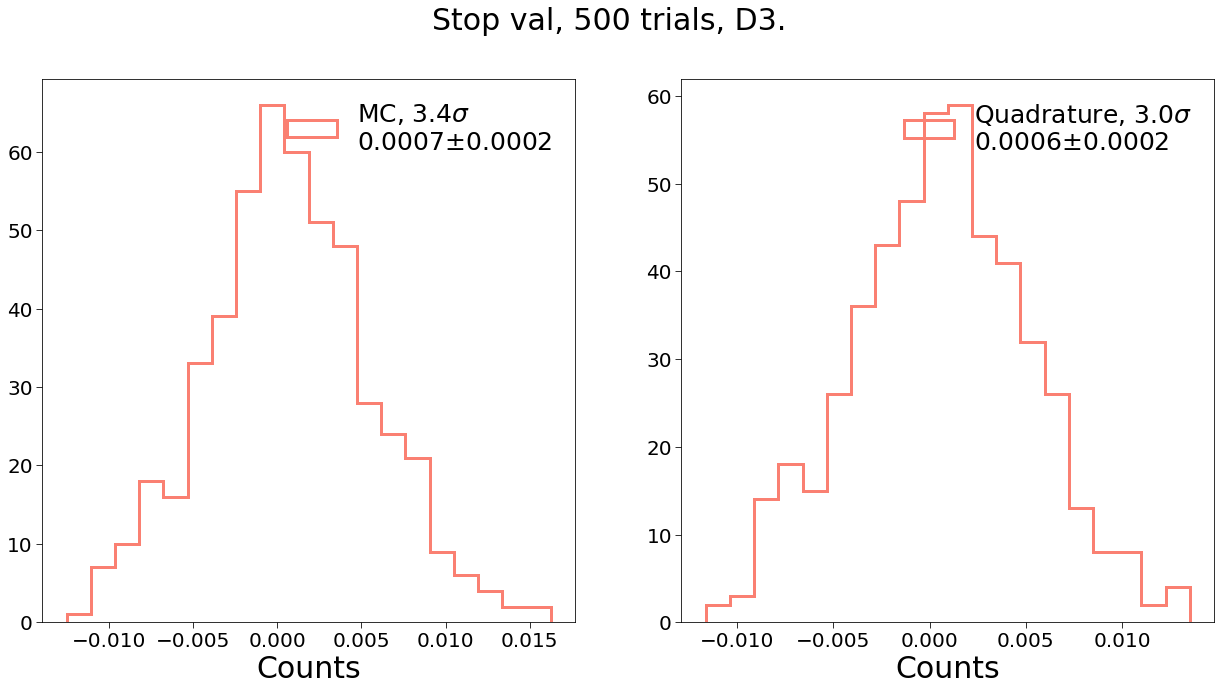

In [50]:
all_MI_estimates = np.load('./D5p_bias_test_MI_diffopt.npy')

analytic = np.load('./mine-pytorch/mine/D5p_analytic_MC.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0] - 1
print(last_id)

all_MI_estimates = all_MI_estimates[:last_id, :]
all_MI_estimates = all_MI_estimates - analytic

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 10))

bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, 0].flatten(), alpha=1, bins=bins, 
         label=f'MC, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 0])) / (np.std(all_MI_estimates[:last_id, 0])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 0]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 0])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)

ax2.hist(all_MI_estimates[:last_id, 1].flatten(), alpha=1, bins=bins, 
         label=f'Quadrature, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1])) / (np.std(all_MI_estimates[:last_id, 1])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 1]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 1])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)




#ax1.axhline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False)
ax1.set_xlabel('MI [nats]', fontsize=30)
ax1.set_xlabel('Counts', fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=20, size=6)
ax2.legend(fontsize=legendsize, frameon=False)
ax2.set_xlabel('MI [nats]', fontsize=30)
ax2.set_xlabel('Counts', fontsize=30)

plt.suptitle('Stop val, 500 trials, D3.', fontsize=30)

#ax1.set_xticks(np.arange(5))
#ax1.set_xticklabels([1000, 5000, 10000, 50000, 100000]);

### Finally, try pygmmis on D3p only. Does it work any better?

In [ ]:
# todo

500


Text(0.5, 0.98, 'Stop val, 500 trials, D3.')

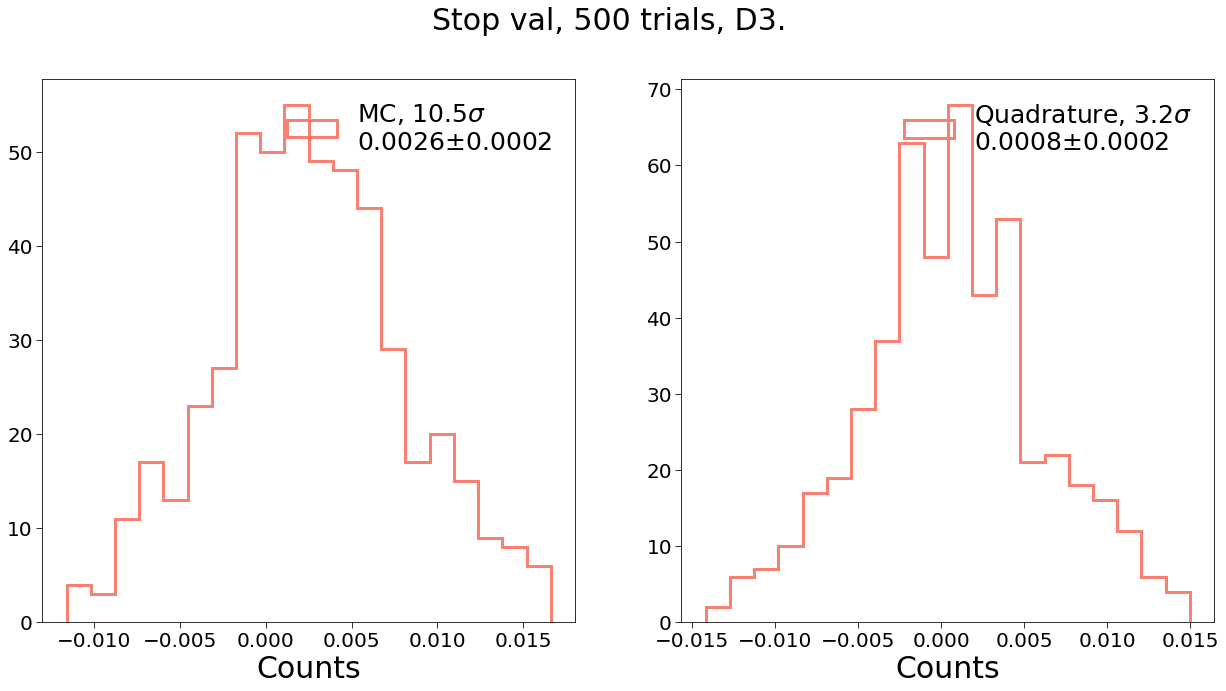

In [40]:
all_MI_estimates = np.load('./D3p_bias_test_MI_pygmmis.npy')

analytic = np.load('./mine-pytorch/mine/D3p_analytic_MC.npy')

last_id = 500#np.where(all_MI_estimates == 0)[0][0] - 1
print(last_id)

all_MI_estimates = all_MI_estimates[:last_id, :]
all_MI_estimates = all_MI_estimates - analytic

all_MI_estimates[all_MI_estimates<-0.2] = 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 10))

bins=20
alpha=0.5
legendsize=25

ax1.hist(all_MI_estimates[:last_id, 0].flatten(), alpha=1, bins=bins, 
         label=f'MC, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 0])) / (np.std(all_MI_estimates[:last_id, 0])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 0]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 0])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)

ax2.hist(all_MI_estimates[:last_id, 1].flatten(), alpha=1, bins=bins, 
         label=f'Quadrature, {np.sqrt(last_id)*(np.mean(all_MI_estimates[:last_id, 1])) / (np.std(all_MI_estimates[:last_id, 1])):.1f}$\sigma$\n{np.mean(all_MI_estimates[:last_id, 1]):.4f}$\pm${np.std(all_MI_estimates[:last_id, 1])/np.sqrt(last_id):.4f}', 
         color='salmon', histtype='step', lw=3)




#ax1.axhline(analytic-analytic, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False)
ax1.set_xlabel('MI [nats]', fontsize=30)
ax1.set_xlabel('Counts', fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=20, size=6)
ax2.legend(fontsize=legendsize, frameon=False)
ax2.set_xlabel('MI [nats]', fontsize=30)
ax2.set_xlabel('Counts', fontsize=30)

plt.suptitle('Stop val, 500 trials, D3.', fontsize=30)

#ax1.set_xticks(np.arange(5))
#ax1.set_xticklabels([1000, 5000, 10000, 50000, 100000]);

### Bootstrap

In [211]:
knn_estimates_bs = np.load('./mine-pytorch/mine/bs_knn.npy')
mine_estimates_bs = np.load('./mine-pytorch/mine/bs_mine.npy')
MI_estimates = np.load('./mine-pytorch/mine/bs_ours.npy')
MI_analytical = np.load('./mine-pytorch/mine/bs_analytic.npy')

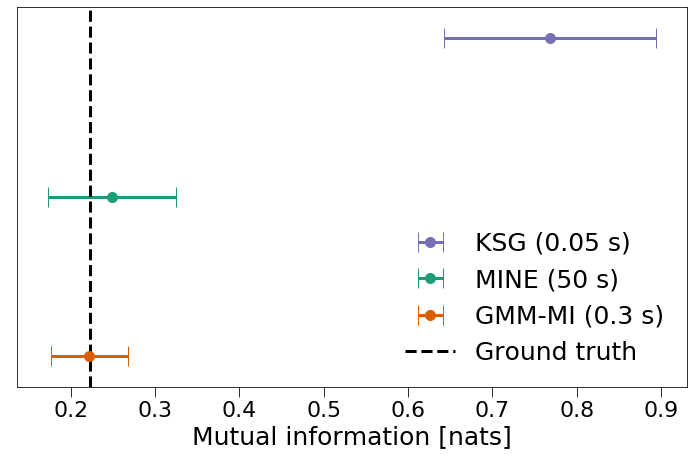

In [233]:
# let's plot all of this
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

np.mean(knn_estimates_bs), np.std(knn_estimates_bs)

sigmas = 1
lw = 3
label = '$N=200$ samples to fit, 20 bootstrap realisations'
ax.tick_params(axis='both', which='major', labelsize=22, size=10)
ax.errorbar(np.mean(knn_estimates_bs), 0.6, xerr=sigmas*np.std(knn_estimates_bs), yerr=None, fmt='.', markersize=20, color='#7570b3', capsize=10, elinewidth=lw, label='KSG (0.05 s)')
ax.errorbar(np.mean(mine_estimates_bs), 0.5, xerr=sigmas*np.std(mine_estimates_bs), yerr=None, fmt='.', markersize=20, color='#1b9e77', capsize=10, elinewidth=lw, label='MINE (50 s)')
ax.errorbar( np.mean(MI_estimates), 0.4, yerr=None, xerr=sigmas*np.std(MI_estimates), fmt='.', markersize=20, color='#d95f02', capsize=10, elinewidth=lw, label='GMM-MI (0.3 s)')
#ax.errorbar( np.mean(true_estimates_bs), 0.3, yerr=None, xerr=np.std(true_estimates_bs), fmt='.', markersize=20, color='grey', capsize=10, elinewidth=2, label='True')
ax.axvline(MI_analytical, 0, linestyle='--', lw=3, color='k', label='Ground truth')

handles, labels = ax.get_legend_handles_labels()
i1, i2 = 0, 1
handles[i1], handles[i2] = handles[i2], handles[i1] 
labels[i1], labels[i2] = labels[i2], labels[i1] 

i1, i2 = 1, 2
handles[i1], handles[i2] = handles[i2], handles[i1] 
labels[i1], labels[i2] = labels[i2], labels[i1] 

i1, i2 = 2, 3
handles[i1], handles[i2] = handles[i2], handles[i1] 
labels[i1], labels[i2] = labels[i2], labels[i1]

#i1, i2 = 3, 4
#handles[i1], handles[i2] = handles[i2], handles[i1] 
#labels[i1], labels[i2] = labels[i2], labels[i1]

#ax.set_title(label, fontsize=30)
ax.legend(handles, labels, fontsize=25, frameon=False, loc='lower right')
        
ax.axes.yaxis.set_ticks([])
ax.set_ylim((0.38, 0.62))

#ax.set_xscale('log')

ax.set_xlabel('Mutual information [nats]', fontsize=25);
plt.savefig('./figures/MI_bootstrap.pdf',  bbox_inches='tight');

### Gamma exp

In [146]:
knn_estimates = np.load('./mine-pytorch/mine/gamma_exp_knn.npy')
mine_estimates = np.load('./mine-pytorch/mine/gamma_exp_mine.npy')
all_MI_estimates = np.load('./mine-pytorch/mine/gamma_exp_ours.npy')
analytic = np.load('./mine-pytorch/mine/gamma_exp_analytic.npy')

thetas = np.logspace(-1, 2, 20)

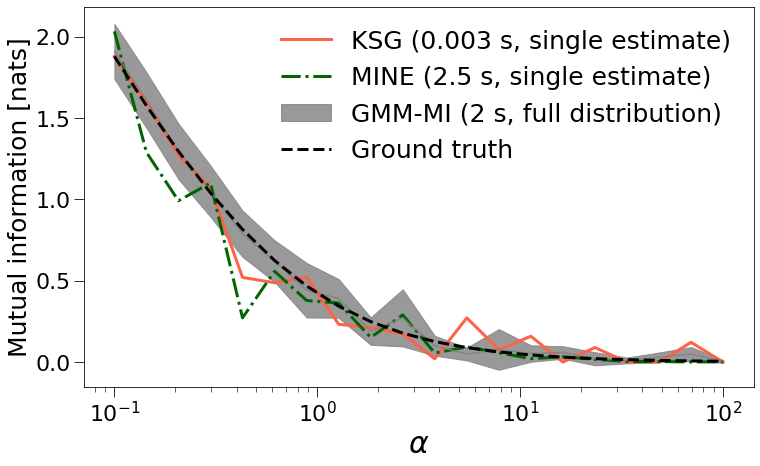

In [147]:
# let's plot all of this
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

sigmas = 2
lw=3
label = '$N=200$ samples to fit, 20 bootstrap realisations'
ax.tick_params(axis='both', which='major', labelsize=22, size=10)
ax.tick_params(axis='both', which='minor', labelsize=22, size=5)
ax.plot(thetas, knn_estimates, c='tomato', lw=lw, label='KSG (0.003 s, single estimate)')
ax.plot(thetas, mine_estimates, c='darkgreen', ls='-.', lw=lw, label='MINE (2.5 s, single estimate)')
ax.plot(thetas, all_MI_estimates[:, 0], color='grey', alpha=0.8)
ax.fill_between(thetas, all_MI_estimates[:, 0] - sigmas*all_MI_estimates[:, 1], all_MI_estimates[:, 0]+sigmas*all_MI_estimates[:, 1], color='grey', alpha=0.8, label='GMM-MI (2 s, full distribution)')
ax.plot(thetas, analytic, ls='--', c='black', lw=lw, label='Ground truth')

handles, labels = ax.get_legend_handles_labels()
i1, i2 = -1, -2
handles[i1], handles[i2] = handles[i2], handles[i1] 
labels[i1], labels[i2] = labels[i2], labels[i1] 

#ax.set_title(label, fontsize=30)
ax.legend(handles, labels, fontsize=25, frameon=False)
        
ax.set_xlabel(r'$\alpha$', fontsize=30)
ax.set_ylabel('Mutual information [nats]', fontsize=25);

ax.set_xscale('log')
#ax.set_ylim((1e-5, 2))

plt.savefig('./figures/gamma_exp_comparison.pdf',  bbox_inches='tight');

### Exp exp

In [150]:
knn_estimates = np.load('./mine-pytorch/mine/exp_exp_knn.npy')
mine_estimates = np.load('./mine-pytorch/mine/exp_exp_mine.npy')
all_MI_estimates = np.load('./mine-pytorch/mine/exp_exp_ours.npy')
analytic = np.load('./mine-pytorch/mine/exp_exp_analytic.npy')

thetas = np.logspace(-1, 2, 20)

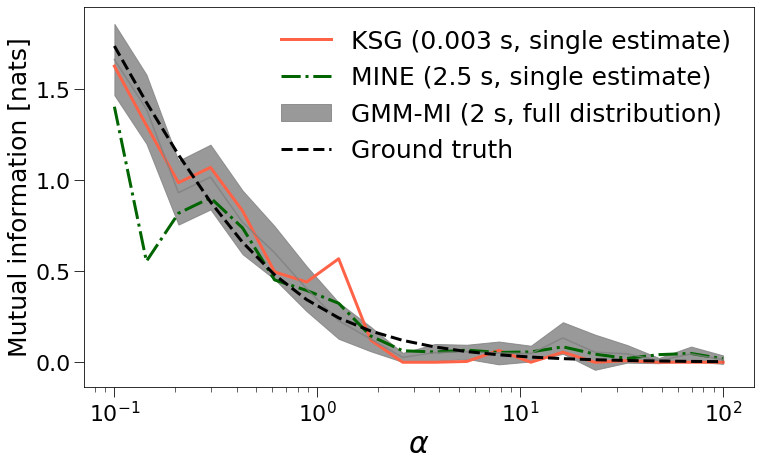

In [151]:
# let's plot all of this
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

sigmas = 2
lw=3
ax.tick_params(axis='both', which='major', labelsize=22, size=10)
ax.tick_params(axis='both', which='minor', labelsize=22, size=5)
ax.plot(thetas, knn_estimates, c='tomato', lw=lw, label='KSG (0.003 s, single estimate)')
ax.plot(thetas, mine_estimates, c='darkgreen', ls='-.', lw=lw, label='MINE (2.5 s, single estimate)')
ax.plot(thetas, all_MI_estimates[:, 0], color='grey', alpha=0.8)
ax.fill_between(thetas, all_MI_estimates[:, 0] - sigmas*all_MI_estimates[:, 1], all_MI_estimates[:, 0]+sigmas*all_MI_estimates[:, 1], color='grey', alpha=0.8, label='GMM-MI (2 s, full distribution)')
ax.plot(thetas, analytic, ls='--', c='black', lw=lw, label='Ground truth')

handles, labels = ax.get_legend_handles_labels()
i1, i2 = -1, -2
handles[i1], handles[i2] = handles[i2], handles[i1] 
labels[i1], labels[i2] = labels[i2], labels[i1] 

#ax.set_title(label, fontsize=30)
ax.legend(handles, labels, fontsize=25, frameon=False)
        
ax.set_xlabel(r'$\alpha$', fontsize=30)
ax.set_ylabel('Mutual information [nats]', fontsize=25);

ax.set_xscale('log')
#ax.set_ylim((1e-5, 2))

plt.savefig('./figures/exp_exp_comparison.pdf',  bbox_inches='tight');

### Quick test about duplicates

In [78]:
class my_GMM(GMM):
    """
    Custom GMM class based on the sklearn GMM class.
    This allows to work with a GMM with fixed parameters, without fitting it.
    It also allows to estimate MI with a certain number of MC samples.
    The different initialisation types are dealt with separately.
    """
    def __init__(self,
                 n_components=1,
                 covariance_type="full",
                 tol=1e-5,
                 reg_covar=1e-6,
                 max_iter=100,
                 n_init=1,
                 init_params="random",
                 random_state=None,
                 warm_start=False,
                 verbose=0,
                 verbose_interval=10,
                 weights_init=None,
                 means_init=None,
                 precisions_init=None,
                 covariances_init=None
                 ):
        super(my_GMM, self).__init__(n_components=n_components,
                 covariance_type=covariance_type,
                 tol=tol,
                 reg_covar=reg_covar,
                 max_iter=max_iter,
                 n_init=n_init,
                 init_params=init_params,
                 random_state=random_state,
                 warm_start=warm_start,
                 verbose=verbose,
                 verbose_interval=verbose_interval,
                 weights_init=weights_init,
                 means_init=means_init,
                 precisions_init=precisions_init,
                )

        self.means_ = means_init
        if covariances_init is None:
            covariances_init = np.linalg.inv(self.precisions_init)
        self.covariances_ = covariances_init
        self.covariances_init = covariances_init
        self.weights_ = weights_init
        #self.random_state = random_state
        self.covariance_type = covariance_type
        self.precisions_cholesky_ = _compute_precision_cholesky(
                self.covariances_, self.covariance_type
            )


    def score_samples(self, X):
        """Compute the log-likelihood of each sample.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        log_prob : array, shape (n_samples,)
            Log-likelihood of each sample in `X` under the current model.
        """
        #check_is_fitted(self)
        #X = self._validate_data(X, reset=False)

        return logsumexp(self._estimate_weighted_log_prob(X), axis=1)

    def predict(self, X):
        """Predict the labels for the data samples in X using trained model.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        labels : array, shape (n_samples,)
            Component labels.
        """
        #check_is_fitted(self)
        #X = self._validate_data(X, reset=False)
        return self._estimate_weighted_log_prob(X).argmax(axis=1)

    def predict_proba(self, X):
        """Evaluate the components' density for each sample.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        resp : array, shape (n_samples, n_components)
            Density of each Gaussian component for each sample in X.
        """
        # copied here to remove the fitting check
        #check_is_fitted(self)
        #X = self._validate_data(X, reset=False)
        _, log_resp = self._estimate_log_prob_resp(X)
        return np.exp(log_resp)

    def sample(self, n_samples=1):
        """Generate random samples from the fitted Gaussian distribution.
        Parameters
        ----------
        n_samples : int, default=1
            Number of samples to generate.
        Returns
        -------
        X : array, shape (n_samples, n_features)
            Randomly generated sample.
        y : array, shape (nsamples,)
            Component labels.
        """
        # copied here to remove the fitting check
        # check_is_fitted(self)

        if n_samples < 1:
            raise ValueError(
                "Invalid value for 'n_samples': %d . The sampling requires at "
                "least one sample." % (self.n_components)
            )

        _, n_features = self.means_.shape
        rng = check_random_state(self.random_state)
        n_samples_comp = rng.multinomial(n_samples, self.weights_)

        if self.covariance_type == "full":
            X = np.vstack(
                [
                    rng.multivariate_normal(mean, covariance, int(sample))
                    for (mean, covariance, sample) in zip(
                        self.means_, self.covariances_, n_samples_comp
                    )
                ]
            )
        elif self.covariance_type == "tied":
            X = np.vstack(
                [
                    rng.multivariate_normal(mean, self.covariances_, int(sample))
                    for (mean, sample) in zip(self.means_, n_samples_comp)
                ]
            )
        else:
            X = np.vstack(
                [
                    mean + rng.randn(sample, n_features) * np.sqrt(covariance)
                    for (mean, covariance, sample) in zip(
                        self.means_, self.covariances_, n_samples_comp
                    )
                ]
            )

        y = np.concatenate(
            [np.full(sample, j, dtype=int) for j, sample in enumerate(n_samples_comp)]
        )

        return (X, y)

    def score_samples_marginal(self, X, index=0):
        """Compute the log-likelihood of each sample for the marginal model, indexed by either 0 (x) or 1 (y).
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        index: integer
            Either 0 (marginal x) or 1 (marginal y).
        Returns
        -------
        log_prob : array, shape (n_samples,)
            Log-likelihood of each sample in `X` under the current model.
        """

        oned_cholesky = np.sqrt(1/self.covariances_[:, index, index]).reshape(-1, 1, 1)
        marginal_logprob = _estimate_log_gaussian_prob(
            X, self.means_[:, index].reshape(-1, 1), oned_cholesky, self.covariance_type
        )

        return logsumexp(np.log(self.weights_) + marginal_logprob, axis=1)


    def estimate_MI_MC(self, MC_samples=100):
        """
        Compute the mutual information (MI) associated with a particular GMM model, using MC integration
        Parameters
        ----------
        MC_samples : integer
            Number of Monte Carlo samples to perform numerical integration of the MI integral.
        Returns
        ----------
        MI : integer
            The value of mutual information.
        -------
        """
        # sample MC samples
        points, clusters = self.sample(MC_samples)
        
        # we first evaluate the log-likelihood for the joint probability
        joint = self.score_samples(points)

        # we then evaluate the marginals; index=0 corresponds to x, index=y corresponds to y
        marginal_x = self.score_samples_marginal(points[:, :1], index=0)
        marginal_y = self.score_samples_marginal(points[:, 1:], index=1)

        MI = np.mean(joint - marginal_x - marginal_y)
        return MI
    
    def fit_predict(self, X, y=None):
        """Estimate model parameters using X and predict the labels for X.
        The method fits the model n_init times and sets the parameters with
        which the model has the largest likelihood or lower bound. Within each
        trial, the method iterates between E-step and M-step for `max_iter`
        times until the change of likelihood or lower bound is less than
        `tol`, otherwise, a :class:`~sklearn.exceptions.ConvergenceWarning` is
        raised. After fitting, it predicts the most probable label for the
        input data points.
        .. versionadded:: 0.20
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        y : Ignored
            Not used, present for API consistency by convention.
        Returns
        -------
        labels : array, shape (n_samples,)
            Component labels.
        """
        X = self._validate_data(X, dtype=[np.float64, np.float32], ensure_min_samples=2)
        if X.shape[0] < self.n_components:
            raise ValueError(
                "Expected n_samples >= n_components "
                f"but got n_components = {self.n_components}, "
                f"n_samples = {X.shape[0]}"
            )
        self._check_initial_parameters(X)

        # if we enable warm_start, we will have a unique initialisation
        do_init = not (self.warm_start and hasattr(self, "converged_"))
        n_init = self.n_init if do_init else 1

        max_lower_bound = -np.inf
        self.converged_ = False

        random_state = check_random_state(self.random_state)

        n_samples, _ = X.shape
        for init in range(n_init):
            self._print_verbose_msg_init_beg(init)

            if do_init:
                self._initialize_parameters(X, random_state)

            lower_bound = -np.inf if do_init else self.lower_bound_

            for n_iter in range(1, self.max_iter + 1):
                #if n_iter==179:
                #    try:
                #        #print(n_iter)
                #        print(np.linalg.eig(self.covariances_[2]))
                #        #print(self.means_[2])
                #        #ind = np.argsort(log_resp[:, 2])[-5:]
                #        #print(X[ind])
                #        #print(log_resp[np.argmax(log_resp[:, 2])])
                #        #plt.hist(log_resp[:, 4])
                #    except:
                #        pass

                prev_lower_bound = lower_bound

                log_prob_norm, log_resp = self._e_step(X)
                self._m_step(X, log_resp)
                lower_bound = self._compute_lower_bound(log_resp, log_prob_norm)

                change = lower_bound - prev_lower_bound
                self._print_verbose_msg_iter_end(n_iter, change)

                if abs(change) < self.tol:
                    self.converged_ = True
                    break

            self._print_verbose_msg_init_end(lower_bound)

            if lower_bound > max_lower_bound or max_lower_bound == -np.inf:
                max_lower_bound = lower_bound
                best_params = self._get_parameters()
                best_n_iter = n_iter

        if not self.converged_:
            warnings.warn(
                "Initialization %d did not converge. "
                "Try different init parameters, "
                "or increase max_iter, tol "
                "or check for degenerate data." % (init + 1),
                ConvergenceWarning,
            )

        self._set_parameters(best_params)
        self.n_iter_ = best_n_iter
        self.lower_bound_ = max_lower_bound

        # Always do a final e-step to guarantee that the labels returned by
        # fit_predict(X) are always consistent with fit(X).predict(X)
        # for any value of max_iter and tol (and any random_state).
        _, log_resp = self._e_step(X)

        return log_resp.argmax(axis=1)
        
def MI_procedure_diffconvergence(X, n_components=1, n_folds=5, n_inits=5, init_type='random', n_bootstrap=100, MC_samples=1e5, reg_covar=1e-6, tol=1e-6):
    """
    Docstring TO DO
    """
    initial_time = time.time()
    # this will be used to store mean validation log-likelihood 
    val_scores_seeds = np.zeros(n_inits)
    train_scores_seeds = np.zeros(n_inits)

    # prepare the folds; note the splitting will be the same for all initialisations
    # the random seed is fixed here, but results should be independent of the exact split
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # fix the random seed first
    for r in range(n_inits):

        w_init, m_init, c_init, p_init = initialize_parameters(X, r, n_components=n_components, init_type=init_type)
        validation_scores = []
        training_scores = []
        
        for train_indices, valid_indices in kf.split(X):
            X_training = X[train_indices]
            X_validation = X[valid_indices]
            
            fitted_gmm = my_GMM(n_components=n_components, reg_covar=reg_covar, 
                            tol=tol, max_iter=10000, 
                            random_state=r, weights_init=w_init, 
                            means_init=m_init, precisions_init=p_init).fit(X_training)

            # we take the mean logL per sample, since folds might have slightly different sizes
            val_score = fitted_gmm.score_samples(X_validation).mean()
            train_score = fitted_gmm.score_samples(X_training).mean()

            #print(val_score)
            validation_scores.append(np.copy(val_score))
            training_scores.append(np.copy(train_score))


        # take mean of current seed's val scores
        val_scores_seeds[r] = np.mean(validation_scores)
        train_scores_seeds[r] = np.mean(training_scores)

        #print()
        
    # select seed with highest val score
    best_seed = np.argmax(val_scores_seeds)
    best_val_score = np.max(val_scores_seeds)
    best_train_score = np.max(train_scores_seeds)
    
    return best_seed, best_val_score, best_train_score

# now we also focus on initialising the GMM parameters
# we provide four different initialisation types, which return weights, means and covs
# these will go as input into the GMM class, so that we can ignore whatever happens there

  
def initialize_parameters(X, random_state, n_components=1, s=None, reg_covar=1e-6, init_type='random'):
    """Initialize the model parameters.
    Parameters
    ----------
    X : array-like of shape  (n_samples, n_features)
    random_state : RandomState
        A random number generator instance that controls the random seed used for the method chosen to initialize the parameters.
    n_components: int
        Number of components of the GMM to fit.
    s : float
        If set, sets component variances in the 'random' and 'minmax' cases. 
        If s is not given, it will be set such that the volume of all components
        completely fills the space covered by data.
    init_type : {'random', 'minmax', 'kmeans', 'random_sklearn', 'kmeans_sklearn'}, default='random'
        The method used to initialize the weights, the means and the
        precisions.
        Must be one of:
            'random': weights are set uniformly, covariances are proportional to identity (with prefactor s^2). 
            For each mean, a data sample is selected at random, and a multivariant Gaussian with variance s^2 offset is added.
            'minmax': same as above, but means are distributed randomly over the range that is covered by data.
            'kmeans': k-means clustering run as in Algorithm 1 from Bloemer & Bujna (arXiv:1312.5946), as implemented by Melchior & Goulding (arXiv:1611.05806)
             WARNING: The result of this call are not deterministic even if rng is set because scipy.cluster.vq.kmeans2 uses its own initialization. 
             TO DO: require scipy > 1.7, and include "seed=random_state" in the kmeans call
            'kmeans_sklearn' : responsibilities are initialized using kmeans.
            'random_sklearn' : responsibilities are initialized randomly.
    reg_covar : float
        The regularization added to the diagonal of the covariance matrices.
    Returns
    ----------
    weights : array, shape (n_components, 1)
        The initial weights of the GMM model.
    means : array, shape (n_components, n_features)
        The initial means of the GMM model.        
    covariances : array, shape (n_components, n_features, n_features)
        The initial covariance matrices of the GMM model.        
    """
    n_samples, n_dim = X.shape

    random_state = check_random_state(random_state)
    if s is None and (init_type=='random' or init_type=='minmax'):
        min_pos = X.min(axis=0)
        max_pos = X.max(axis=0)
        vol_data = np.prod(max_pos-min_pos)
        s = (vol_data / n_components * gamma(n_dim*0.5 + 1))**(1/n_dim) / np.sqrt(np.pi)
        print(f"Scale s set to s={s:.2f}...")

    if init_type == "random":

        weights = np.repeat(1/n_components, n_components)
        # initialize components around data points with uncertainty s
        refs = random_state.randint(0, n_samples, size=n_components)

        means = X[refs] + random_state.multivariate_normal(np.zeros(n_dim), s**2 * np.eye(n_dim), size=n_components)
        
        covariances = np.repeat(s**2 * np.eye(n_dim)[np.newaxis, :, :], n_components, axis=0)

    elif init_type == "minmax":

        weights = np.repeat(1/n_components, n_components)

        min_pos = X.min(axis=0)
        max_pos = X.max(axis=0)
        means = min_pos + (max_pos-min_pos)*random_state.rand(n_components, n_dim)
        
        covariances = np.repeat(s**2 * np.eye(n_dim)[np.newaxis, :, :], n_components, axis=0)

    elif init_type == 'kmeans':
        from scipy.cluster.vq import kmeans2
        center, label = kmeans2(X, n_components)
        weights = np.zeros(n_components)
        means = np.zeros((n_components, n_dim))
        covariances = np.zeros((n_components, n_dim, n_dim))

        for k in range(n_components):
            mask = (label == k)
            weights[k] = mask.sum() / len(X)
            means[k,:] = X[mask].mean(axis=0)
            d_m = X[mask] - means[k,:] 
            # funny way of saying: for each point i, do the outer product
            # of d_m with its transpose and sum over i
            covariances[k,:,:] = (d_m[:, :, None] * d_m[:, None, :]).sum(axis=0) / len(X)

    elif init_type == "random_sklearn":
        resp = random_state.rand(n_samples, n_components)
        resp /= resp.sum(axis=1)[:, np.newaxis]
        nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
        
        weights = nk/n_samples
        means = np.dot(resp.T, X) / nk[:, np.newaxis]
        covariances = _estimate_gaussian_covariances_full(resp, X, nk, means, reg_covar)

    elif init_type == "kmeans_sklearn":
        resp = np.zeros((n_samples, n_components))
        label = (
            cluster.KMeans(
                n_clusters=n_components, n_init=1, random_state=random_state
            )
            .fit(X)
            .labels_
        )
        resp[np.arange(n_samples), label] = 1
        nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
        
        weights = nk/n_samples
        means = np.dot(resp.T, X) / nk[:, np.newaxis]
        covariances = _estimate_gaussian_covariances_full(resp, X, nk, means, reg_covar)

    else:
        # TO DO: raise error instead of just priting it
        print("Error: initalisation type not specified or not known; it should be one of 'random', 'minmax', 'kmeans', 'random_sklearn', 'kmeans_sklearn'")
        
    precisions = np.empty_like(covariances)
    for i in range(n_components):
        precisions[i] = np.linalg.inv(covariances[i])
        
    return weights, means, covariances, precisions


In [79]:
# three different models, chosen based on the number of components
n_components = 3

# fix random state for stability across runs
random_state = 13

if n_components == 1:
    weights = np.array([1.0])
    mu0, mu1, mu2 = [-1, 1], [0, 2], [-1.5, 2]
    means = np.array([mu0])
    C0, C1, C2 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]]
    covariances = np.array([C1])
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=random_state)
elif n_components == 2:
    weights = np.array([0.96, 0.04])
    mu0, mu1 = [0, 0], [1, 1]
    means = np.array([mu0, mu1])
    C0, C1 = [[1, 0], [0, 1]], [[0.1, 0.], [0., 0.1]]
    covariances = np.array([C0, C1])
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=random_state)
elif n_components == 3:
    weights = np.array([0.3, 0.45, 0.25])
    mu0, mu1, mu2 = [-1, 1], [0, 2], [-1.5, 2]
    means = np.array([mu0, mu1, mu2])
    C0, C1, C2 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]]
    covariances = np.array([C0, C1, C2])
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=random_state)
elif n_components == 5:
    weights = np.array([0.2, 0.35, 0.15, 0.12, 0.18])
    mu0, mu1, mu2, mu3, mu4 = [-1, 1], [0, 2], [-1.5, 2], [2, 1], [-0.25, 0]
    means = np.array([mu0, mu1, mu2, mu3, mu4])
    C0, C1, C2, C3, C4 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]], [[0.5, -0.1], [-0.1, 0.9]], [[0.2, -0.05], [-0.05, 0.1]]
    covariances = np.array([C0, C1, C2, C3, C4])
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=random_state)
elif n_components == 6:
    # this is for D5'
    n_components = 5
    weights = np.array([0.2, 0.35, 0.15, 0.12, 0.18])
    mu0, mu1, mu2, mu3, mu4 = [-1, 1], [0, 2], [-1.5, 2], [3, 1], [-0.25, 0]
    means = np.array([mu0, mu1, mu2, mu3, mu4])
    C0, C1, C2, C3, C4 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]], [[0.5, -0.1], [-0.1, 0.9]], [[0.2, -0.05], [-0.05, 0.1]]
    covariances = np.array([C0, C1, C2, C3, C4])
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=random_state)

In [80]:
gmm_true = my_GMM(n_components=3, weights_init=weights, means_init=means, covariances_init=covariances, random_state=0+50000)
X = gmm_true.sample(5e3)[0]


from sklearn.feature_selection import mutual_info_regression

In [81]:
X_r = np.repeat(X, 2, axis=0)

In [82]:
mutual_info_regression(X[:, :1], X[:, 1], n_neighbors=2)

array([0.12293754])

In [83]:
mutual_info_regression(X_r[:, :1], X_r[:, 1], n_neighbors=2)

array([0.44215453])

In [89]:
n_inits = 10
n_folds = 5
init_type = 'random_sklearn'
MC_samples = 1e5
tol = 1e-6
reg_covar = 1e-15
components_range = 100
patience = 1


best_val = -np.inf
pat_counter = 0
for n_components in range(3, 4):
    current_seed, current_val, _ = MI_procedure_diffconvergence(X_r, n_components=n_components, n_folds=n_folds, 
                                                       init_type=init_type, n_inits=n_inits, n_bootstrap=100, 
                                                       MC_samples=MC_samples, tol=tol, reg_covar=reg_covar)

    # check if convergence has been reached based on val score
    if 1<0:# > best_val:
        best_val = current_val
        best_seed = current_seed
        print(n_components, best_val)
    else:
        # if val score has not increased, then we should stop and calculate MI with the previous parameters
        pat_counter += 1
        if pat_counter >= patience:
            best_components = 3#n_components-patience # note we retrieve the model based on patience!
            print(f'Convergence reached at {best_components} components') 

            w_init, m_init, c_init, p_init = initialize_parameters(X, best_seed, n_components=best_components, init_type=init_type)

            single_MI_estimate = my_GMM(n_components=best_components, reg_covar=reg_covar, 
                            tol=tol, max_iter=10000, 
                            random_state=best_seed, weights_init=w_init, 
                            means_init=m_init, precisions_init=p_init).fit(X).estimate_MI_MC(MC_samples=MC_samples)

            print(best_components, single_MI_estimate) 
            break



Convergence reached at 3 components
3 0.13291502391105028
